In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.796346
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.776354


[3]	valid_0's rmse: 0.756933


[4]	valid_0's rmse: 0.739145


[5]	valid_0's rmse: 0.72303


[6]	valid_0's rmse: 0.70806


[7]	valid_0's rmse: 0.693416


[8]	valid_0's rmse: 0.679863


[9]	valid_0's rmse: 0.667819


[10]	valid_0's rmse: 0.656151


[11]	valid_0's rmse: 0.645582


[12]	valid_0's rmse: 0.63621


[13]	valid_0's rmse: 0.627329


[14]	valid_0's rmse: 0.619368


[15]	valid_0's rmse: 0.611971


[16]	valid_0's rmse: 0.605025


[17]	valid_0's rmse: 0.598602


[18]	valid_0's rmse: 0.592404


[19]	valid_0's rmse: 0.586697


[20]	valid_0's rmse: 0.581438


[21]	valid_0's rmse: 0.576646


[22]	valid_0's rmse: 0.57248


[23]	valid_0's rmse: 0.568519


[24]	valid_0's rmse: 0.564886


[25]	valid_0's rmse: 0.561624


[26]	valid_0's rmse: 0.558681


[27]	valid_0's rmse: 0.555879


[28]	valid_0's rmse: 0.553287


[29]	valid_0's rmse: 0.550754


[30]	valid_0's rmse: 0.548391


[31]	valid_0's rmse: 0.546237


[32]	valid_0's rmse: 0.544255


[33]	valid_0's rmse: 0.542471


[34]	valid_0's rmse: 0.540809


[35]	valid_0's rmse: 0.539382


[36]	valid_0's rmse: 0.538079


[37]	valid_0's rmse: 0.536744


[38]	valid_0's rmse: 0.535525


[39]	valid_0's rmse: 0.53435


[40]	valid_0's rmse: 0.533197


[41]	valid_0's rmse: 0.532207


[42]	valid_0's rmse: 0.531338
[43]	valid_0's rmse: 0.530442


[44]	valid_0's rmse: 0.529576
[45]	valid_0's rmse: 0.528732


[46]	valid_0's rmse: 0.528105
[47]	valid_0's rmse: 0.52754


[48]	valid_0's rmse: 0.526953
[49]	valid_0's rmse: 0.526413


[50]	valid_0's rmse: 0.525846


[51]	valid_0's rmse: 0.525321
[52]	valid_0's rmse: 0.524881


[53]	valid_0's rmse: 0.524473
[54]	valid_0's rmse: 0.524004


[55]	valid_0's rmse: 0.523552
[56]	valid_0's rmse: 0.523198


[57]	valid_0's rmse: 0.52288
[58]	valid_0's rmse: 0.522511


[59]	valid_0's rmse: 0.52221
[60]	valid_0's rmse: 0.521853


[61]	valid_0's rmse: 0.521468
[62]	valid_0's rmse: 0.521154


[63]	valid_0's rmse: 0.520927
[64]	valid_0's rmse: 0.520655


[65]	valid_0's rmse: 0.520393
[66]	valid_0's rmse: 0.520188


[67]	valid_0's rmse: 0.519918
[68]	valid_0's rmse: 0.519712


[69]	valid_0's rmse: 0.519505
[70]	valid_0's rmse: 0.519353


[71]	valid_0's rmse: 0.519141


[72]	valid_0's rmse: 0.51896
[73]	valid_0's rmse: 0.518741


[74]	valid_0's rmse: 0.518534
[75]	valid_0's rmse: 0.518361


[76]	valid_0's rmse: 0.518256
[77]	valid_0's rmse: 0.518115


[78]	valid_0's rmse: 0.51793
[79]	valid_0's rmse: 0.517798


[80]	valid_0's rmse: 0.517661
[81]	valid_0's rmse: 0.517583


[82]	valid_0's rmse: 0.517468
[83]	valid_0's rmse: 0.517392


[84]	valid_0's rmse: 0.517328
[85]	valid_0's rmse: 0.517243


[86]	valid_0's rmse: 0.517079
[87]	valid_0's rmse: 0.516916


[88]	valid_0's rmse: 0.516839
[89]	valid_0's rmse: 0.516748


[90]	valid_0's rmse: 0.516591
[91]	valid_0's rmse: 0.516438


[92]	valid_0's rmse: 0.516286
[93]	valid_0's rmse: 0.516209


[94]	valid_0's rmse: 0.51606
[95]	valid_0's rmse: 0.515945


[96]	valid_0's rmse: 0.515866
[97]	valid_0's rmse: 0.515787


[98]	valid_0's rmse: 0.515643
[99]	valid_0's rmse: 0.515572


[100]	valid_0's rmse: 0.515445
[101]	valid_0's rmse: 0.515395


[102]	valid_0's rmse: 0.515323
[103]	valid_0's rmse: 0.515245


[104]	valid_0's rmse: 0.515234
[105]	valid_0's rmse: 0.515181


[106]	valid_0's rmse: 0.515099
[107]	valid_0's rmse: 0.515071


[108]	valid_0's rmse: 0.515024
[109]	valid_0's rmse: 0.514948


[110]	valid_0's rmse: 0.514886
[111]	valid_0's rmse: 0.514807


[112]	valid_0's rmse: 0.514754
[113]	valid_0's rmse: 0.514739


[114]	valid_0's rmse: 0.514701
[115]	valid_0's rmse: 0.51463


[116]	valid_0's rmse: 0.514564
[117]	valid_0's rmse: 0.514484


[118]	valid_0's rmse: 0.514414
[119]	valid_0's rmse: 0.514356


[120]	valid_0's rmse: 0.51427
[121]	valid_0's rmse: 0.514223


[122]	valid_0's rmse: 0.514186
[123]	valid_0's rmse: 0.514083


[124]	valid_0's rmse: 0.514044
[125]	valid_0's rmse: 0.513973


[126]	valid_0's rmse: 0.513912
[127]	valid_0's rmse: 0.51386


[128]	valid_0's rmse: 0.513863
[129]	valid_0's rmse: 0.51387


[130]	valid_0's rmse: 0.513834
[131]	valid_0's rmse: 0.51379


[132]	valid_0's rmse: 0.513763
[133]	valid_0's rmse: 0.513739


[134]	valid_0's rmse: 0.513688
[135]	valid_0's rmse: 0.513684


[136]	valid_0's rmse: 0.513619
[137]	valid_0's rmse: 0.513632


[138]	valid_0's rmse: 0.51361
[139]	valid_0's rmse: 0.513591


[140]	valid_0's rmse: 0.513585
[141]	valid_0's rmse: 0.513615


[142]	valid_0's rmse: 0.513557
[143]	valid_0's rmse: 0.513508


[144]	valid_0's rmse: 0.513449
[145]	valid_0's rmse: 0.513459


[146]	valid_0's rmse: 0.51343
[147]	valid_0's rmse: 0.513412


[148]	valid_0's rmse: 0.513407
[149]	valid_0's rmse: 0.513394


[150]	valid_0's rmse: 0.513408
[151]	valid_0's rmse: 0.513399


[152]	valid_0's rmse: 0.513344
[153]	valid_0's rmse: 0.513294


[154]	valid_0's rmse: 0.513293
[155]	valid_0's rmse: 0.513297


[156]	valid_0's rmse: 0.513284
[157]	valid_0's rmse: 0.513243


[158]	valid_0's rmse: 0.513262
[159]	valid_0's rmse: 0.513236


[160]	valid_0's rmse: 0.513245
[161]	valid_0's rmse: 0.513237


[162]	valid_0's rmse: 0.513208
[163]	valid_0's rmse: 0.513179


[164]	valid_0's rmse: 0.513141
[165]	valid_0's rmse: 0.513126


[166]	valid_0's rmse: 0.513128
[167]	valid_0's rmse: 0.513122


[168]	valid_0's rmse: 0.513143
[169]	valid_0's rmse: 0.513146


[170]	valid_0's rmse: 0.513098
[171]	valid_0's rmse: 0.513067


[172]	valid_0's rmse: 0.513029
[173]	valid_0's rmse: 0.513025


[174]	valid_0's rmse: 0.512983
[175]	valid_0's rmse: 0.512987


[176]	valid_0's rmse: 0.512977
[177]	valid_0's rmse: 0.512965


[178]	valid_0's rmse: 0.512962
[179]	valid_0's rmse: 0.512953


[180]	valid_0's rmse: 0.512933
[181]	valid_0's rmse: 0.512926


[182]	valid_0's rmse: 0.51293
[183]	valid_0's rmse: 0.512927


[184]	valid_0's rmse: 0.512915
[185]	valid_0's rmse: 0.512944


[186]	valid_0's rmse: 0.512925
[187]	valid_0's rmse: 0.512914
[188]	valid_0's rmse: 0.512916


[189]	valid_0's rmse: 0.512926
[190]	valid_0's rmse: 0.512934


[191]	valid_0's rmse: 0.512917
[192]	valid_0's rmse: 0.512886


[193]	valid_0's rmse: 0.512866
[194]	valid_0's rmse: 0.512845


[195]	valid_0's rmse: 0.512848
[196]	valid_0's rmse: 0.512858


[197]	valid_0's rmse: 0.512848
[198]	valid_0's rmse: 0.512841


[199]	valid_0's rmse: 0.512836
[200]	valid_0's rmse: 0.512833


[201]	valid_0's rmse: 0.512861
[202]	valid_0's rmse: 0.51285
[203]	valid_0's rmse: 0.512845


[204]	valid_0's rmse: 0.512837
[205]	valid_0's rmse: 0.512814


[206]	valid_0's rmse: 0.51282
[207]	valid_0's rmse: 0.512825


[208]	valid_0's rmse: 0.512829
[209]	valid_0's rmse: 0.512816


[210]	valid_0's rmse: 0.5128
[211]	valid_0's rmse: 0.512782


[212]	valid_0's rmse: 0.512794
[213]	valid_0's rmse: 0.512773


[214]	valid_0's rmse: 0.512782
[215]	valid_0's rmse: 0.512778


[216]	valid_0's rmse: 0.512779
[217]	valid_0's rmse: 0.512775


[218]	valid_0's rmse: 0.512749
[219]	valid_0's rmse: 0.51274


[220]	valid_0's rmse: 0.512716
[221]	valid_0's rmse: 0.51269


[222]	valid_0's rmse: 0.512697
[223]	valid_0's rmse: 0.512697


[224]	valid_0's rmse: 0.512697
[225]	valid_0's rmse: 0.512665


[226]	valid_0's rmse: 0.512656
[227]	valid_0's rmse: 0.512672


[228]	valid_0's rmse: 0.512677
[229]	valid_0's rmse: 0.512667


[230]	valid_0's rmse: 0.512706
[231]	valid_0's rmse: 0.512676


[232]	valid_0's rmse: 0.512659
[233]	valid_0's rmse: 0.512655


[234]	valid_0's rmse: 0.51264
[235]	valid_0's rmse: 0.51265


[236]	valid_0's rmse: 0.512666
[237]	valid_0's rmse: 0.512657


[238]	valid_0's rmse: 0.512659
[239]	valid_0's rmse: 0.512661


[240]	valid_0's rmse: 0.512672
[241]	valid_0's rmse: 0.512664


[242]	valid_0's rmse: 0.512665
[243]	valid_0's rmse: 0.512658


[244]	valid_0's rmse: 0.512661
[245]	valid_0's rmse: 0.51266


[246]	valid_0's rmse: 0.512668
[247]	valid_0's rmse: 0.512671


[248]	valid_0's rmse: 0.512673
[249]	valid_0's rmse: 0.512679


[250]	valid_0's rmse: 0.512662
[251]	valid_0's rmse: 0.512652


[252]	valid_0's rmse: 0.512651
[253]	valid_0's rmse: 0.51265


[254]	valid_0's rmse: 0.512651
[255]	valid_0's rmse: 0.51263


[256]	valid_0's rmse: 0.512615
[257]	valid_0's rmse: 0.512626


[258]	valid_0's rmse: 0.512612
[259]	valid_0's rmse: 0.512604


[260]	valid_0's rmse: 0.512597
[261]	valid_0's rmse: 0.512601


[262]	valid_0's rmse: 0.512608
[263]	valid_0's rmse: 0.51262


[264]	valid_0's rmse: 0.512613
[265]	valid_0's rmse: 0.512599


[266]	valid_0's rmse: 0.512586
[267]	valid_0's rmse: 0.512579


[268]	valid_0's rmse: 0.512581
[269]	valid_0's rmse: 0.512569
[270]	valid_0's rmse: 0.512593


[271]	valid_0's rmse: 0.512574
[272]	valid_0's rmse: 0.512554


[273]	valid_0's rmse: 0.512558
[274]	valid_0's rmse: 0.512554


[275]	valid_0's rmse: 0.512529
[276]	valid_0's rmse: 0.512524


[277]	valid_0's rmse: 0.512527
[278]	valid_0's rmse: 0.512521
[279]	valid_0's rmse: 0.512554


[280]	valid_0's rmse: 0.512542
[281]	valid_0's rmse: 0.512564


[282]	valid_0's rmse: 0.512563
[283]	valid_0's rmse: 0.512565
[284]	valid_0's rmse: 0.512565


[285]	valid_0's rmse: 0.51257
[286]	valid_0's rmse: 0.512557


[287]	valid_0's rmse: 0.512558
[288]	valid_0's rmse: 0.512569


[289]	valid_0's rmse: 0.512555
[290]	valid_0's rmse: 0.512542


[291]	valid_0's rmse: 0.512523
[292]	valid_0's rmse: 0.512529


[293]	valid_0's rmse: 0.512526
[294]	valid_0's rmse: 0.512539


[295]	valid_0's rmse: 0.512532
[296]	valid_0's rmse: 0.512555


[297]	valid_0's rmse: 0.512533
[298]	valid_0's rmse: 0.512551


[299]	valid_0's rmse: 0.512549
[300]	valid_0's rmse: 0.512561


[301]	valid_0's rmse: 0.512555
[302]	valid_0's rmse: 0.512545


[303]	valid_0's rmse: 0.51255
[304]	valid_0's rmse: 0.512558


[305]	valid_0's rmse: 0.512559
[306]	valid_0's rmse: 0.512569


[307]	valid_0's rmse: 0.512574
[308]	valid_0's rmse: 0.51257


[309]	valid_0's rmse: 0.512575
[310]	valid_0's rmse: 0.512565


[311]	valid_0's rmse: 0.512571
[312]	valid_0's rmse: 0.512555


[313]	valid_0's rmse: 0.512541
[314]	valid_0's rmse: 0.512541
[315]	valid_0's rmse: 0.512533


[316]	valid_0's rmse: 0.512538
[317]	valid_0's rmse: 0.512535


[318]	valid_0's rmse: 0.512511
[319]	valid_0's rmse: 0.512522
[320]	valid_0's rmse: 0.512536


[321]	valid_0's rmse: 0.512526
[322]	valid_0's rmse: 0.512524


[323]	valid_0's rmse: 0.51251
[324]	valid_0's rmse: 0.512484
[325]	valid_0's rmse: 0.512485


[326]	valid_0's rmse: 0.512481
[327]	valid_0's rmse: 0.512499
[328]	valid_0's rmse: 0.512496


[329]	valid_0's rmse: 0.512527
[330]	valid_0's rmse: 0.512525


[331]	valid_0's rmse: 0.512508
[332]	valid_0's rmse: 0.51249


[333]	valid_0's rmse: 0.512497
[334]	valid_0's rmse: 0.512482


[335]	valid_0's rmse: 0.512465
[336]	valid_0's rmse: 0.512451


[337]	valid_0's rmse: 0.512461
[338]	valid_0's rmse: 0.512441


[339]	valid_0's rmse: 0.51244
[340]	valid_0's rmse: 0.512449


[341]	valid_0's rmse: 0.512466
[342]	valid_0's rmse: 0.512484
[343]	valid_0's rmse: 0.512484


[344]	valid_0's rmse: 0.51249
[345]	valid_0's rmse: 0.512491


[346]	valid_0's rmse: 0.512475
[347]	valid_0's rmse: 0.512475


[348]	valid_0's rmse: 0.512458
[349]	valid_0's rmse: 0.512456


[350]	valid_0's rmse: 0.512457
[351]	valid_0's rmse: 0.512459


[352]	valid_0's rmse: 0.512455
[353]	valid_0's rmse: 0.512457


[354]	valid_0's rmse: 0.512464
[355]	valid_0's rmse: 0.512451


[356]	valid_0's rmse: 0.512448
[357]	valid_0's rmse: 0.51244
[358]	valid_0's rmse: 0.51243


[359]	valid_0's rmse: 0.51243
[360]	valid_0's rmse: 0.512421


[361]	valid_0's rmse: 0.512408
[362]	valid_0's rmse: 0.512376


[363]	valid_0's rmse: 0.512367
[364]	valid_0's rmse: 0.512334


[365]	valid_0's rmse: 0.512336
[366]	valid_0's rmse: 0.512321


[367]	valid_0's rmse: 0.512322
[368]	valid_0's rmse: 0.512322
[369]	valid_0's rmse: 0.512308


[370]	valid_0's rmse: 0.512309
[371]	valid_0's rmse: 0.512319


[372]	valid_0's rmse: 0.512326
[373]	valid_0's rmse: 0.512325


[374]	valid_0's rmse: 0.512318
[375]	valid_0's rmse: 0.512329


[376]	valid_0's rmse: 0.512335
[377]	valid_0's rmse: 0.512345


[378]	valid_0's rmse: 0.512345
[379]	valid_0's rmse: 0.512346
[380]	valid_0's rmse: 0.512358


[381]	valid_0's rmse: 0.512354
[382]	valid_0's rmse: 0.512378


[383]	valid_0's rmse: 0.512376
[384]	valid_0's rmse: 0.512391
[385]	valid_0's rmse: 0.512392


[386]	valid_0's rmse: 0.512394
[387]	valid_0's rmse: 0.512383


[388]	valid_0's rmse: 0.512383
[389]	valid_0's rmse: 0.512382


[390]	valid_0's rmse: 0.512392
[391]	valid_0's rmse: 0.512394


[392]	valid_0's rmse: 0.512398
[393]	valid_0's rmse: 0.512394


[394]	valid_0's rmse: 0.512413
[395]	valid_0's rmse: 0.512413


[396]	valid_0's rmse: 0.512411
[397]	valid_0's rmse: 0.51243


[398]	valid_0's rmse: 0.512438
[399]	valid_0's rmse: 0.512429
[400]	valid_0's rmse: 0.512424


[401]	valid_0's rmse: 0.512444
[402]	valid_0's rmse: 0.512458
[403]	valid_0's rmse: 0.512439


[404]	valid_0's rmse: 0.512423
[405]	valid_0's rmse: 0.512425


[406]	valid_0's rmse: 0.512437
[407]	valid_0's rmse: 0.51245
[408]	valid_0's rmse: 0.512456


[409]	valid_0's rmse: 0.51246
[410]	valid_0's rmse: 0.512431


[411]	valid_0's rmse: 0.512434
[412]	valid_0's rmse: 0.512437
[413]	valid_0's rmse: 0.512431


[414]	valid_0's rmse: 0.512421
[415]	valid_0's rmse: 0.512423
[416]	valid_0's rmse: 0.512411


[417]	valid_0's rmse: 0.512429
[418]	valid_0's rmse: 0.512432


[419]	valid_0's rmse: 0.512449
Early stopping, best iteration is:
[369]	valid_0's rmse: 0.512308


0.180820246596 0.262459959374
[0.26245995937350264]
-1 mean score 0.262459959374


0.172827099875


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916639  0.012471  0.186722    7  2017-04-16
472     2.507290  2.539744 -0.032453  0.178478    1  2017-04-17
473     2.661330  2.661563 -0.000234  0.201436    2  2017-04-18
474     2.754815  2.745661  0.009153  0.173124    3  2017-04-19
475     2.713762  2.693526  0.020236  0.190488    4  2017-04-20
476     2.999000  2.997375  0.001625  0.125954    5  2017-04-21
477     3.075529  3.092502 -0.016972  0.153588    6  2017-04-22

0.172827099875


pred         y     error    error2  day        date
dayidx                                                         
471     2.916639  2.929110  0.012471  0.186722    7  2017-04-16
472     2.539744  2.507290 -0.032453  0.178478    1  2017-04-17
473     2.661563  2.661330 -0.000234  0.201436    2  2017-04-18
474     2.745661  2.754815  0.009153  0.173124    3  2017-04-19
475     2.693526  2.713762  0.020236  0.190488    4  2017-04-20
476     2.997375  2.999000  0.001625  0.125954    5  2017-04-21
477     3.092502  3.075529 -0.016972  0.153588    6  2017-04-22

(829, 242)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.786723
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.766211


[3]	valid_0's rmse: 0.747038


[4]	valid_0's rmse: 0.729186


[5]	valid_0's rmse: 0.712789


[6]	valid_0's rmse: 0.697818


[7]	valid_0's rmse: 0.683843


[8]	valid_0's rmse: 0.670642
[9]	valid_0's rmse: 0.658387


[10]	valid_0's rmse: 0.646946


[11]	valid_0's rmse: 0.636922


[12]	valid_0's rmse: 0.627534


[13]	valid_0's rmse: 0.618504


[14]	valid_0's rmse: 0.61042


[15]	valid_0's rmse: 0.603116


[16]	valid_0's rmse: 0.596293


[17]	valid_0's rmse: 0.589922


[18]	valid_0's rmse: 0.583903
[19]	valid_0's rmse: 0.578443


[20]	valid_0's rmse: 0.573538


[21]	valid_0's rmse: 0.568998


[22]	valid_0's rmse: 0.565065


[23]	valid_0's rmse: 0.561217
[24]	valid_0's rmse: 0.557819


[25]	valid_0's rmse: 0.554724


[26]	valid_0's rmse: 0.551862
[27]	valid_0's rmse: 0.549101


[28]	valid_0's rmse: 0.54662
[29]	valid_0's rmse: 0.544142


[30]	valid_0's rmse: 0.541863


[31]	valid_0's rmse: 0.539758
[32]	valid_0's rmse: 0.537942


[33]	valid_0's rmse: 0.536217
[34]	valid_0's rmse: 0.53463


[35]	valid_0's rmse: 0.533149
[36]	valid_0's rmse: 0.531944


[37]	valid_0's rmse: 0.530671
[38]	valid_0's rmse: 0.529542


[39]	valid_0's rmse: 0.528501
[40]	valid_0's rmse: 0.527497


[41]	valid_0's rmse: 0.526458
[42]	valid_0's rmse: 0.52561


[43]	valid_0's rmse: 0.524722
[44]	valid_0's rmse: 0.523921


[45]	valid_0's rmse: 0.523174
[46]	valid_0's rmse: 0.522582


[47]	valid_0's rmse: 0.522071
[48]	valid_0's rmse: 0.521502


[49]	valid_0's rmse: 0.520954
[50]	valid_0's rmse: 0.520405


[51]	valid_0's rmse: 0.519908
[52]	valid_0's rmse: 0.519464


[53]	valid_0's rmse: 0.519071
[54]	valid_0's rmse: 0.518619


[55]	valid_0's rmse: 0.518177
[56]	valid_0's rmse: 0.517869


[57]	valid_0's rmse: 0.517498
[58]	valid_0's rmse: 0.517127


[59]	valid_0's rmse: 0.51689
[60]	valid_0's rmse: 0.516526


[61]	valid_0's rmse: 0.516182
[62]	valid_0's rmse: 0.515879


[63]	valid_0's rmse: 0.515668
[64]	valid_0's rmse: 0.51535


[65]	valid_0's rmse: 0.51509
[66]	valid_0's rmse: 0.514883


[67]	valid_0's rmse: 0.51466
[68]	valid_0's rmse: 0.514348


[69]	valid_0's rmse: 0.514121
[70]	valid_0's rmse: 0.514072


[71]	valid_0's rmse: 0.513832
[72]	valid_0's rmse: 0.513664


[73]	valid_0's rmse: 0.51346
[74]	valid_0's rmse: 0.513273


[75]	valid_0's rmse: 0.513142
[76]	valid_0's rmse: 0.512958


[77]	valid_0's rmse: 0.51278
[78]	valid_0's rmse: 0.512624


[79]	valid_0's rmse: 0.512383
[80]	valid_0's rmse: 0.512227


[81]	valid_0's rmse: 0.512121
[82]	valid_0's rmse: 0.511969


[83]	valid_0's rmse: 0.511881
[84]	valid_0's rmse: 0.511738


[85]	valid_0's rmse: 0.511669
[86]	valid_0's rmse: 0.5115


[87]	valid_0's rmse: 0.51131
[88]	valid_0's rmse: 0.511125


[89]	valid_0's rmse: 0.510986
[90]	valid_0's rmse: 0.510911


[91]	valid_0's rmse: 0.510848
[92]	valid_0's rmse: 0.510741


[93]	valid_0's rmse: 0.510651
[94]	valid_0's rmse: 0.510549


[95]	valid_0's rmse: 0.510384
[96]	valid_0's rmse: 0.510226


[97]	valid_0's rmse: 0.510123
[98]	valid_0's rmse: 0.510018


[99]	valid_0's rmse: 0.50996
[100]	valid_0's rmse: 0.509849


[101]	valid_0's rmse: 0.509735
[102]	valid_0's rmse: 0.509579


[103]	valid_0's rmse: 0.509499
[104]	valid_0's rmse: 0.509322


[105]	valid_0's rmse: 0.50927
[106]	valid_0's rmse: 0.509104


[107]	valid_0's rmse: 0.509083
[108]	valid_0's rmse: 0.509042


[109]	valid_0's rmse: 0.508987
[110]	valid_0's rmse: 0.508948


[111]	valid_0's rmse: 0.508833
[112]	valid_0's rmse: 0.508716


[113]	valid_0's rmse: 0.508678
[114]	valid_0's rmse: 0.508621


[115]	valid_0's rmse: 0.508488
[116]	valid_0's rmse: 0.508445


[117]	valid_0's rmse: 0.508441
[118]	valid_0's rmse: 0.508436


[119]	valid_0's rmse: 0.50839
[120]	valid_0's rmse: 0.50834


[121]	valid_0's rmse: 0.508295
[122]	valid_0's rmse: 0.508261


[123]	valid_0's rmse: 0.508222
[124]	valid_0's rmse: 0.508172


[125]	valid_0's rmse: 0.508127
[126]	valid_0's rmse: 0.508011


[127]	valid_0's rmse: 0.508018
[128]	valid_0's rmse: 0.507982


[129]	valid_0's rmse: 0.507917
[130]	valid_0's rmse: 0.507884


[131]	valid_0's rmse: 0.507799
[132]	valid_0's rmse: 0.507715


[133]	valid_0's rmse: 0.507676
[134]	valid_0's rmse: 0.50765


[135]	valid_0's rmse: 0.507625
[136]	valid_0's rmse: 0.507613


[137]	valid_0's rmse: 0.50758
[138]	valid_0's rmse: 0.507598


[139]	valid_0's rmse: 0.507577
[140]	valid_0's rmse: 0.507543


[141]	valid_0's rmse: 0.507463
[142]	valid_0's rmse: 0.507466


[143]	valid_0's rmse: 0.50744
[144]	valid_0's rmse: 0.5074


[145]	valid_0's rmse: 0.507395
[146]	valid_0's rmse: 0.507346


[147]	valid_0's rmse: 0.507382
[148]	valid_0's rmse: 0.507366


[149]	valid_0's rmse: 0.507332
[150]	valid_0's rmse: 0.507316


[151]	valid_0's rmse: 0.507292
[152]	valid_0's rmse: 0.507273


[153]	valid_0's rmse: 0.507224
[154]	valid_0's rmse: 0.507187


[155]	valid_0's rmse: 0.507173
[156]	valid_0's rmse: 0.507176


[157]	valid_0's rmse: 0.507151
[158]	valid_0's rmse: 0.507148


[159]	valid_0's rmse: 0.507141
[160]	valid_0's rmse: 0.507114


[161]	valid_0's rmse: 0.507101
[162]	valid_0's rmse: 0.507078


[163]	valid_0's rmse: 0.507078
[164]	valid_0's rmse: 0.507099


[165]	valid_0's rmse: 0.507101
[166]	valid_0's rmse: 0.507097


[167]	valid_0's rmse: 0.507092
[168]	valid_0's rmse: 0.507104


[169]	valid_0's rmse: 0.507043
[170]	valid_0's rmse: 0.507033


[171]	valid_0's rmse: 0.507044
[172]	valid_0's rmse: 0.507052


[173]	valid_0's rmse: 0.507037
[174]	valid_0's rmse: 0.507038


[175]	valid_0's rmse: 0.507028
[176]	valid_0's rmse: 0.506957


[177]	valid_0's rmse: 0.506972
[178]	valid_0's rmse: 0.506959


[179]	valid_0's rmse: 0.506881
[180]	valid_0's rmse: 0.506843


[181]	valid_0's rmse: 0.506824
[182]	valid_0's rmse: 0.506834
[183]	valid_0's rmse: 0.506826


[184]	valid_0's rmse: 0.506831
[185]	valid_0's rmse: 0.506817


[186]	valid_0's rmse: 0.506813
[187]	valid_0's rmse: 0.506787


[188]	valid_0's rmse: 0.506798
[189]	valid_0's rmse: 0.506786
[190]	valid_0's rmse: 0.506775


[191]	valid_0's rmse: 0.506745
[192]	valid_0's rmse: 0.506711


[193]	valid_0's rmse: 0.506697
[194]	valid_0's rmse: 0.50669


[195]	valid_0's rmse: 0.506683
[196]	valid_0's rmse: 0.506679


[197]	valid_0's rmse: 0.506642
[198]	valid_0's rmse: 0.506664


[199]	valid_0's rmse: 0.506659
[200]	valid_0's rmse: 0.506619


[201]	valid_0's rmse: 0.506626
[202]	valid_0's rmse: 0.506627


[203]	valid_0's rmse: 0.506641
[204]	valid_0's rmse: 0.506581


[205]	valid_0's rmse: 0.506579
[206]	valid_0's rmse: 0.506541


[207]	valid_0's rmse: 0.506556
[208]	valid_0's rmse: 0.506537


[209]	valid_0's rmse: 0.506537
[210]	valid_0's rmse: 0.506535


[211]	valid_0's rmse: 0.50654
[212]	valid_0's rmse: 0.506541


[213]	valid_0's rmse: 0.506555
[214]	valid_0's rmse: 0.506584
[215]	valid_0's rmse: 0.506562


[216]	valid_0's rmse: 0.50654
[217]	valid_0's rmse: 0.506529


[218]	valid_0's rmse: 0.506529
[219]	valid_0's rmse: 0.506512


[220]	valid_0's rmse: 0.506542
[221]	valid_0's rmse: 0.506533


[222]	valid_0's rmse: 0.50654
[223]	valid_0's rmse: 0.506565
[224]	valid_0's rmse: 0.506574


[225]	valid_0's rmse: 0.506568
[226]	valid_0's rmse: 0.506542


[227]	valid_0's rmse: 0.506567
[228]	valid_0's rmse: 0.50654


[229]	valid_0's rmse: 0.506536
[230]	valid_0's rmse: 0.506522


[231]	valid_0's rmse: 0.506519
[232]	valid_0's rmse: 0.506492


[233]	valid_0's rmse: 0.506496
[234]	valid_0's rmse: 0.506498


[235]	valid_0's rmse: 0.506512
[236]	valid_0's rmse: 0.506507


[237]	valid_0's rmse: 0.506493
[238]	valid_0's rmse: 0.50648
[239]	valid_0's rmse: 0.506485


[240]	valid_0's rmse: 0.506479
[241]	valid_0's rmse: 0.506498


[242]	valid_0's rmse: 0.506489
[243]	valid_0's rmse: 0.506501


[244]	valid_0's rmse: 0.506519
[245]	valid_0's rmse: 0.506513


[246]	valid_0's rmse: 0.506496
[247]	valid_0's rmse: 0.506507


[248]	valid_0's rmse: 0.506481
[249]	valid_0's rmse: 0.506486


[250]	valid_0's rmse: 0.506491
[251]	valid_0's rmse: 0.506517


[252]	valid_0's rmse: 0.506526
[253]	valid_0's rmse: 0.506518


[254]	valid_0's rmse: 0.506546
[255]	valid_0's rmse: 0.50655


[256]	valid_0's rmse: 0.506547
[257]	valid_0's rmse: 0.506513


[258]	valid_0's rmse: 0.50651
[259]	valid_0's rmse: 0.506512
[260]	valid_0's rmse: 0.50653


[261]	valid_0's rmse: 0.506548
[262]	valid_0's rmse: 0.506524


[263]	valid_0's rmse: 0.50651
[264]	valid_0's rmse: 0.506507


[265]	valid_0's rmse: 0.506448
[266]	valid_0's rmse: 0.506447
[267]	valid_0's rmse: 0.506475


[268]	valid_0's rmse: 0.506446
[269]	valid_0's rmse: 0.506429


[270]	valid_0's rmse: 0.506419
[271]	valid_0's rmse: 0.506414


[272]	valid_0's rmse: 0.506413
[273]	valid_0's rmse: 0.506429
[274]	valid_0's rmse: 0.506442


[275]	valid_0's rmse: 0.506435
[276]	valid_0's rmse: 0.506429


[277]	valid_0's rmse: 0.506459
[278]	valid_0's rmse: 0.506419


[279]	valid_0's rmse: 0.506427
[280]	valid_0's rmse: 0.506416
[281]	valid_0's rmse: 0.506428


[282]	valid_0's rmse: 0.506447
[283]	valid_0's rmse: 0.506448


[284]	valid_0's rmse: 0.506431
[285]	valid_0's rmse: 0.506423


[286]	valid_0's rmse: 0.506465
[287]	valid_0's rmse: 0.506491


[288]	valid_0's rmse: 0.506454
[289]	valid_0's rmse: 0.50644


[290]	valid_0's rmse: 0.506459
[291]	valid_0's rmse: 0.506462


[292]	valid_0's rmse: 0.506431
[293]	valid_0's rmse: 0.506444
[294]	valid_0's rmse: 0.506425


[295]	valid_0's rmse: 0.506431
[296]	valid_0's rmse: 0.506422


[297]	valid_0's rmse: 0.506412
[298]	valid_0's rmse: 0.506416


[299]	valid_0's rmse: 0.506417
[300]	valid_0's rmse: 0.506432
[301]	valid_0's rmse: 0.506426


[302]	valid_0's rmse: 0.50645


[303]	valid_0's rmse: 0.506455
[304]	valid_0's rmse: 0.506492
[305]	valid_0's rmse: 0.506504


[306]	valid_0's rmse: 0.5065
[307]	valid_0's rmse: 0.506516
[308]	valid_0's rmse: 0.506515


[309]	valid_0's rmse: 0.506512
[310]	valid_0's rmse: 0.506505


[311]	valid_0's rmse: 0.506514
[312]	valid_0's rmse: 0.506524
[313]	valid_0's rmse: 0.506515


[314]	valid_0's rmse: 0.506527
[315]	valid_0's rmse: 0.506527


[316]	valid_0's rmse: 0.506523
[317]	valid_0's rmse: 0.506521
[318]	valid_0's rmse: 0.506525


[319]	valid_0's rmse: 0.50652
[320]	valid_0's rmse: 0.506516
[321]	valid_0's rmse: 0.506498


[322]	valid_0's rmse: 0.506518
[323]	valid_0's rmse: 0.506514


[324]	valid_0's rmse: 0.506506
[325]	valid_0's rmse: 0.506511


[326]	valid_0's rmse: 0.506497
[327]	valid_0's rmse: 0.506517
[328]	valid_0's rmse: 0.506515


[329]	valid_0's rmse: 0.506511
[330]	valid_0's rmse: 0.506517
[331]	valid_0's rmse: 0.506519


[332]	valid_0's rmse: 0.506521
[333]	valid_0's rmse: 0.506493
[334]	valid_0's rmse: 0.506503


[335]	valid_0's rmse: 0.506492
[336]	valid_0's rmse: 0.506485


[337]	valid_0's rmse: 0.506502
[338]	valid_0's rmse: 0.506485


[339]	valid_0's rmse: 0.506502
[340]	valid_0's rmse: 0.506513


[341]	valid_0's rmse: 0.506515
[342]	valid_0's rmse: 0.506523


[343]	valid_0's rmse: 0.506529
[344]	valid_0's rmse: 0.506516


[345]	valid_0's rmse: 0.506525
[346]	valid_0's rmse: 0.506519
[347]	valid_0's rmse: 0.506506


Early stopping, best iteration is:
[297]	valid_0's rmse: 0.506412


0.182167155576 0.256453259952
[0.25645325995217139]
-1 mean score 0.256453259952
0.188922367407


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898562  0.030548  0.202158    7  2017-04-16
472     2.507290  2.550216 -0.042925  0.201579    1  2017-04-17
473     2.661330  2.649666  0.011664  0.222666    2  2017-04-18
474     2.754815  2.729501  0.025314  0.186109    3  2017-04-19
475     2.713762  2.696472  0.017290  0.205410    4  2017-04-20
476     2.999000  2.998817  0.000183  0.140922    5  2017-04-21
477     3.075529  3.087228 -0.011699  0.163612    6  2017-04-22

0.188922367407


pred         y     error    error2  day        date
dayidx                                                         
471     2.898562  2.929110  0.030548  0.202158    7  2017-04-16
472     2.550216  2.507290 -0.042925  0.201579    1  2017-04-17
473     2.649666  2.661330  0.011664  0.222666    2  2017-04-18
474     2.729501  2.754815  0.025314  0.186109    3  2017-04-19
475     2.696472  2.713762  0.017290  0.205410    4  2017-04-20
476     2.998817  2.999000  0.000183  0.140922    5  2017-04-21
477     3.087228  3.075529 -0.011699  0.163612    6  2017-04-22

(829, 242)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788104
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.767623
[3]	valid_0's rmse: 0.749157


[4]	valid_0's rmse: 0.731854


[5]	valid_0's rmse: 0.715868


[6]	valid_0's rmse: 0.700467
[7]	valid_0's rmse: 0.686724


[8]	valid_0's rmse: 0.673555
[9]	valid_0's rmse: 0.661683


[10]	valid_0's rmse: 0.650765


[11]	valid_0's rmse: 0.640337


[12]	valid_0's rmse: 0.630791
[13]	valid_0's rmse: 0.621825


[14]	valid_0's rmse: 0.613978
[15]	valid_0's rmse: 0.606593

[16]	valid_0's rmse: 0.599901
[17]	valid_0's rmse: 0.593394


[18]	valid_0's rmse: 0.587472
[19]	valid_0's rmse: 0.582172


[20]	valid_0's rmse: 0.577505
[21]	valid_0's rmse: 0.572878


[22]	valid_0's rmse: 0.568961
[23]	valid_0's rmse: 0.565006


[24]	valid_0's rmse: 0.561437
[25]	valid_0's rmse: 0.558213


[26]	valid_0's rmse: 0.555388
[27]	valid_0's rmse: 0.552614


[28]	valid_0's rmse: 0.550058
[29]	valid_0's rmse: 0.547622


[30]	valid_0's rmse: 0.545425
[31]	valid_0's rmse: 0.543406


[32]	valid_0's rmse: 0.541538
[33]	valid_0's rmse: 0.539852


[34]	valid_0's rmse: 0.53826
[35]	valid_0's rmse: 0.536854


[36]	valid_0's rmse: 0.535513
[37]	valid_0's rmse: 0.534248


[38]	valid_0's rmse: 0.533059
[39]	valid_0's rmse: 0.532009


[40]	valid_0's rmse: 0.531009
[41]	valid_0's rmse: 0.530056


[42]	valid_0's rmse: 0.529208
[43]	valid_0's rmse: 0.528414


[44]	valid_0's rmse: 0.527606
[45]	valid_0's rmse: 0.526907


[46]	valid_0's rmse: 0.526308
[47]	valid_0's rmse: 0.525807


[48]	valid_0's rmse: 0.525268
[49]	valid_0's rmse: 0.524721


[50]	valid_0's rmse: 0.524178
[51]	valid_0's rmse: 0.523608


[52]	valid_0's rmse: 0.523158
[53]	valid_0's rmse: 0.522783


[54]	valid_0's rmse: 0.522345
[55]	valid_0's rmse: 0.521904


[56]	valid_0's rmse: 0.521495
[57]	valid_0's rmse: 0.521226


[58]	valid_0's rmse: 0.520884
[59]	valid_0's rmse: 0.520603


[60]	valid_0's rmse: 0.520311
[61]	valid_0's rmse: 0.520022


[62]	valid_0's rmse: 0.519771
[63]	valid_0's rmse: 0.519533


[64]	valid_0's rmse: 0.519313
[65]	valid_0's rmse: 0.519071


[66]	valid_0's rmse: 0.518848
[67]	valid_0's rmse: 0.518589


[68]	valid_0's rmse: 0.518376
[69]	valid_0's rmse: 0.518179


[70]	valid_0's rmse: 0.517966
[71]	valid_0's rmse: 0.5178


[72]	valid_0's rmse: 0.517624
[73]	valid_0's rmse: 0.517369


[74]	valid_0's rmse: 0.517183
[75]	valid_0's rmse: 0.516905


[76]	valid_0's rmse: 0.516794
[77]	valid_0's rmse: 0.516628


[78]	valid_0's rmse: 0.516536
[79]	valid_0's rmse: 0.516381


[80]	valid_0's rmse: 0.516247
[81]	valid_0's rmse: 0.516136


[82]	valid_0's rmse: 0.515924
[83]	valid_0's rmse: 0.515762


[84]	valid_0's rmse: 0.515695
[85]	valid_0's rmse: 0.515619


[86]	valid_0's rmse: 0.515511
[87]	valid_0's rmse: 0.515384


[88]	valid_0's rmse: 0.515187
[89]	valid_0's rmse: 0.515019


[90]	valid_0's rmse: 0.514861
[91]	valid_0's rmse: 0.514766


[92]	valid_0's rmse: 0.51468
[93]	valid_0's rmse: 0.514555


[94]	valid_0's rmse: 0.514525
[95]	valid_0's rmse: 0.514462


[96]	valid_0's rmse: 0.5144
[97]	valid_0's rmse: 0.514263


[98]	valid_0's rmse: 0.514143
[99]	valid_0's rmse: 0.514098


[100]	valid_0's rmse: 0.513962
[101]	valid_0's rmse: 0.513895


[102]	valid_0's rmse: 0.513835
[103]	valid_0's rmse: 0.513743


[104]	valid_0's rmse: 0.513666
[105]	valid_0's rmse: 0.51357


[106]	valid_0's rmse: 0.513459
[107]	valid_0's rmse: 0.513402


[108]	valid_0's rmse: 0.51338
[109]	valid_0's rmse: 0.513301


[110]	valid_0's rmse: 0.513217
[111]	valid_0's rmse: 0.513067


[112]	valid_0's rmse: 0.512902
[113]	valid_0's rmse: 0.512848


[114]	valid_0's rmse: 0.512771
[115]	valid_0's rmse: 0.512662


[116]	valid_0's rmse: 0.512679
[117]	valid_0's rmse: 0.512607


[118]	valid_0's rmse: 0.512569
[119]	valid_0's rmse: 0.512518


[120]	valid_0's rmse: 0.512484
[121]	valid_0's rmse: 0.512409


[122]	valid_0's rmse: 0.512348
[123]	valid_0's rmse: 0.512212


[124]	valid_0's rmse: 0.512196
[125]	valid_0's rmse: 0.512148


[126]	valid_0's rmse: 0.512141
[127]	valid_0's rmse: 0.512107


[128]	valid_0's rmse: 0.512097
[129]	valid_0's rmse: 0.51211


[130]	valid_0's rmse: 0.512106
[131]	valid_0's rmse: 0.512036


[132]	valid_0's rmse: 0.511987
[133]	valid_0's rmse: 0.511958


[134]	valid_0's rmse: 0.511892
[135]	valid_0's rmse: 0.511888


[136]	valid_0's rmse: 0.511838
[137]	valid_0's rmse: 0.511813


[138]	valid_0's rmse: 0.511772
[139]	valid_0's rmse: 0.511728


[140]	valid_0's rmse: 0.511638
[141]	valid_0's rmse: 0.511612


[142]	valid_0's rmse: 0.511607
[143]	valid_0's rmse: 0.511569


[144]	valid_0's rmse: 0.511527
[145]	valid_0's rmse: 0.511526


[146]	valid_0's rmse: 0.511491
[147]	valid_0's rmse: 0.511503


[148]	valid_0's rmse: 0.511512
[149]	valid_0's rmse: 0.511447


[150]	valid_0's rmse: 0.511414
[151]	valid_0's rmse: 0.511376


[152]	valid_0's rmse: 0.511392
[153]	valid_0's rmse: 0.511373


[154]	valid_0's rmse: 0.511358
[155]	valid_0's rmse: 0.511347


[156]	valid_0's rmse: 0.511322
[157]	valid_0's rmse: 0.511285


[158]	valid_0's rmse: 0.511265
[159]	valid_0's rmse: 0.511188


[160]	valid_0's rmse: 0.511126
[161]	valid_0's rmse: 0.511105


[162]	valid_0's rmse: 0.511126
[163]	valid_0's rmse: 0.511147


[164]	valid_0's rmse: 0.511164
[165]	valid_0's rmse: 0.511155


[166]	valid_0's rmse: 0.511096
[167]	valid_0's rmse: 0.511102


[168]	valid_0's rmse: 0.511071
[169]	valid_0's rmse: 0.511048
[170]	valid_0's rmse: 0.511046


[171]	valid_0's rmse: 0.511049
[172]	valid_0's rmse: 0.511043


[173]	valid_0's rmse: 0.511056
[174]	valid_0's rmse: 0.511083
[175]	valid_0's rmse: 0.511078


[176]	valid_0's rmse: 0.51106
[177]	valid_0's rmse: 0.511043
[178]	valid_0's rmse: 0.511043


[179]	valid_0's rmse: 0.511009
[180]	valid_0's rmse: 0.511015


[181]	valid_0's rmse: 0.510972
[182]	valid_0's rmse: 0.510955


[183]	valid_0's rmse: 0.510941
[184]	valid_0's rmse: 0.510918


[185]	valid_0's rmse: 0.51093
[186]	valid_0's rmse: 0.510914
[187]	valid_0's rmse: 0.510928


[188]	valid_0's rmse: 0.510938
[189]	valid_0's rmse: 0.510899


[190]	valid_0's rmse: 0.510895
[191]	valid_0's rmse: 0.510874


[192]	valid_0's rmse: 0.51088
[193]	valid_0's rmse: 0.510881
[194]	valid_0's rmse: 0.510902


[195]	valid_0's rmse: 0.510919
[196]	valid_0's rmse: 0.510935
[197]	valid_0's rmse: 0.510918


[198]	valid_0's rmse: 0.51093
[199]	valid_0's rmse: 0.51094


[200]	valid_0's rmse: 0.510934
[201]	valid_0's rmse: 0.510926


[202]	valid_0's rmse: 0.510936
[203]	valid_0's rmse: 0.510915
[204]	valid_0's rmse: 0.510899


[205]	valid_0's rmse: 0.510857
[206]	valid_0's rmse: 0.510861
[207]	valid_0's rmse: 0.510868


[208]	valid_0's rmse: 0.510868
[209]	valid_0's rmse: 0.5109
[210]	valid_0's rmse: 0.510881


[211]	valid_0's rmse: 0.510858
[212]	valid_0's rmse: 0.510885


[213]	valid_0's rmse: 0.510866
[214]	valid_0's rmse: 0.510843


[215]	valid_0's rmse: 0.510836
[216]	valid_0's rmse: 0.510847


[217]	valid_0's rmse: 0.510847
[218]	valid_0's rmse: 0.510808


[219]	valid_0's rmse: 0.510811
[220]	valid_0's rmse: 0.51083
[221]	valid_0's rmse: 0.510821


[222]	valid_0's rmse: 0.510797
[223]	valid_0's rmse: 0.510795


[224]	valid_0's rmse: 0.510786
[225]	valid_0's rmse: 0.510801


[226]	valid_0's rmse: 0.510809
[227]	valid_0's rmse: 0.510814
[228]	valid_0's rmse: 0.51081


[229]	valid_0's rmse: 0.510869
[230]	valid_0's rmse: 0.51086


[231]	valid_0's rmse: 0.510867
[232]	valid_0's rmse: 0.510858
[233]	valid_0's rmse: 0.510866


[234]	valid_0's rmse: 0.510862
[235]	valid_0's rmse: 0.510869
[236]	valid_0's rmse: 0.510869


[237]	valid_0's rmse: 0.510847
[238]	valid_0's rmse: 0.510852
[239]	valid_0's rmse: 0.510848


[240]	valid_0's rmse: 0.510859
[241]	valid_0's rmse: 0.510852
[242]	valid_0's rmse: 0.510868


[243]	valid_0's rmse: 0.510877
[244]	valid_0's rmse: 0.510865


[245]	valid_0's rmse: 0.510875
[246]	valid_0's rmse: 0.51087
[247]	valid_0's rmse: 0.510885


[248]	valid_0's rmse: 0.510867
[249]	valid_0's rmse: 0.51085


[250]	valid_0's rmse: 0.510852
[251]	valid_0's rmse: 0.510845


[252]	valid_0's rmse: 0.510867
[253]	valid_0's rmse: 0.510863
[254]	valid_0's rmse: 0.510847


[255]	valid_0's rmse: 0.510839
[256]	valid_0's rmse: 0.510852


[257]	valid_0's rmse: 0.51087
[258]	valid_0's rmse: 0.510888
[259]	valid_0's rmse: 0.510856


[260]	valid_0's rmse: 0.510836
[261]	valid_0's rmse: 0.510831


[262]	valid_0's rmse: 0.510824
[263]	valid_0's rmse: 0.510825
[264]	valid_0's rmse: 0.510811


[265]	valid_0's rmse: 0.510791
[266]	valid_0's rmse: 0.510794
[267]	valid_0's rmse: 0.510794


[268]	valid_0's rmse: 0.510785
[269]	valid_0's rmse: 0.510799
[270]	valid_0's rmse: 0.510809


[271]	valid_0's rmse: 0.51082
[272]	valid_0's rmse: 0.510829


[273]	valid_0's rmse: 0.510835
[274]	valid_0's rmse: 0.510846
[275]	valid_0's rmse: 0.510854


[276]	valid_0's rmse: 0.51089
[277]	valid_0's rmse: 0.510883
[278]	valid_0's rmse: 0.510881


[279]	valid_0's rmse: 0.51087
[280]	valid_0's rmse: 0.510863


[281]	valid_0's rmse: 0.510858
[282]	valid_0's rmse: 0.510861


[283]	valid_0's rmse: 0.510838
[284]	valid_0's rmse: 0.510832
[285]	valid_0's rmse: 0.51082


[286]	valid_0's rmse: 0.510836
[287]	valid_0's rmse: 0.510839
[288]	valid_0's rmse: 0.510847


[289]	valid_0's rmse: 0.510816
[290]	valid_0's rmse: 0.510817


[291]	valid_0's rmse: 0.510812
[292]	valid_0's rmse: 0.510806
[293]	valid_0's rmse: 0.510801


[294]	valid_0's rmse: 0.510775
[295]	valid_0's rmse: 0.510766


[296]	valid_0's rmse: 0.510753
[297]	valid_0's rmse: 0.510773
[298]	valid_0's rmse: 0.510764


[299]	valid_0's rmse: 0.51077
[300]	valid_0's rmse: 0.510772


[301]	valid_0's rmse: 0.510762
[302]	valid_0's rmse: 0.510771


[303]	valid_0's rmse: 0.510759
[304]	valid_0's rmse: 0.510745
[305]	valid_0's rmse: 0.510739


[306]	valid_0's rmse: 0.510738
[307]	valid_0's rmse: 0.510761
[308]	valid_0's rmse: 0.510754


[309]	valid_0's rmse: 0.510747
[310]	valid_0's rmse: 0.510749


[311]	valid_0's rmse: 0.510733
[312]	valid_0's rmse: 0.510723
[313]	valid_0's rmse: 0.510749


[314]	valid_0's rmse: 0.510705
[315]	valid_0's rmse: 0.510697
[316]	valid_0's rmse: 0.510685


[317]	valid_0's rmse: 0.51069
[318]	valid_0's rmse: 0.51071
[319]	valid_0's rmse: 0.510726


[320]	valid_0's rmse: 0.510723
[321]	valid_0's rmse: 0.510726
[322]	valid_0's rmse: 0.510752


[323]	valid_0's rmse: 0.510767
[324]	valid_0's rmse: 0.510765
[325]	valid_0's rmse: 0.510756


[326]	valid_0's rmse: 0.510766
[327]	valid_0's rmse: 0.510765
[328]	valid_0's rmse: 0.510785


[329]	valid_0's rmse: 0.510797
[330]	valid_0's rmse: 0.510768
[331]	valid_0's rmse: 0.510782


[332]	valid_0's rmse: 0.510768
[333]	valid_0's rmse: 0.510775
[334]	valid_0's rmse: 0.510752


[335]	valid_0's rmse: 0.51075
[336]	valid_0's rmse: 0.510757
[337]	valid_0's rmse: 0.510758


[338]	valid_0's rmse: 0.510781
[339]	valid_0's rmse: 0.510787
[340]	valid_0's rmse: 0.510772


[341]	valid_0's rmse: 0.510777
[342]	valid_0's rmse: 0.510769
[343]	valid_0's rmse: 0.510776


[344]	valid_0's rmse: 0.510779
[345]	valid_0's rmse: 0.5108
[346]	valid_0's rmse: 0.510787


[347]	valid_0's rmse: 0.510775
[348]	valid_0's rmse: 0.510786
[349]	valid_0's rmse: 0.510795


[350]	valid_0's rmse: 0.5108
[351]	valid_0's rmse: 0.510832


[352]	valid_0's rmse: 0.510849
[353]	valid_0's rmse: 0.510858
[354]	valid_0's rmse: 0.510856


[355]	valid_0's rmse: 0.510864
[356]	valid_0's rmse: 0.510868


[357]	valid_0's rmse: 0.510893
[358]	valid_0's rmse: 0.510909
[359]	valid_0's rmse: 0.510898


[360]	valid_0's rmse: 0.510914
[361]	valid_0's rmse: 0.510925
[362]	valid_0's rmse: 0.510937


[363]	valid_0's rmse: 0.510935
[364]	valid_0's rmse: 0.510921


[365]	valid_0's rmse: 0.510948
[366]	valid_0's rmse: 0.510952
Early stopping, best iteration is:
[316]	valid_0's rmse: 0.510685


0.180573141375 0.260799295306
[0.26079929530598966]
-1 mean score 0.260799295306
0.186979328215


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886553  0.042557  0.200360    7  2017-04-16
472     2.507290  2.543887 -0.036597  0.190785    1  2017-04-17
473     2.661330  2.650690  0.010640  0.218552    2  2017-04-18
474     2.754815  2.755577 -0.000762  0.192790    3  2017-04-19
475     2.713762  2.704675  0.009087  0.205483    4  2017-04-20
476     2.999000  3.000112 -0.001112  0.139065    5  2017-04-21
477     3.075529  3.086090 -0.010561  0.161820    6  2017-04-22

0.186979328215


pred         y     error    error2  day        date
dayidx                                                         
471     2.886553  2.929110  0.042557  0.200360    7  2017-04-16
472     2.543887  2.507290 -0.036597  0.190785    1  2017-04-17
473     2.650690  2.661330  0.010640  0.218552    2  2017-04-18
474     2.755577  2.754815 -0.000762  0.192790    3  2017-04-19
475     2.704675  2.713762  0.009087  0.205483    4  2017-04-20
476     3.000112  2.999000 -0.001112  0.139065    5  2017-04-21
477     3.086090  3.075529 -0.010561  0.161820    6  2017-04-22

(829, 242)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)


(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.787383
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.767467


[3]	valid_0's rmse: 0.74829


[4]	valid_0's rmse: 0.730832


[5]	valid_0's rmse: 0.714758


[6]	valid_0's rmse: 0.69976


[7]	valid_0's rmse: 0.685909


[8]	valid_0's rmse: 0.673197


[9]	valid_0's rmse: 0.661335
[10]	valid_0's rmse: 0.649979


[11]	valid_0's rmse: 0.639967


[12]	valid_0's rmse: 0.630721


[13]	valid_0's rmse: 0.622133


[14]	valid_0's rmse: 0.614234
[15]	valid_0's rmse: 0.606638


[16]	valid_0's rmse: 0.599894


[17]	valid_0's rmse: 0.593517
[18]	valid_0's rmse: 0.587426


[19]	valid_0's rmse: 0.581786


[20]	valid_0's rmse: 0.576951


[21]	valid_0's rmse: 0.572578


[22]	valid_0's rmse: 0.568663
[23]	valid_0's rmse: 0.564862


[24]	valid_0's rmse: 0.561406
[25]	valid_0's rmse: 0.558183


[26]	valid_0's rmse: 0.555313
[27]	valid_0's rmse: 0.552603


[28]	valid_0's rmse: 0.54999
[29]	valid_0's rmse: 0.547543


[30]	valid_0's rmse: 0.545177


[31]	valid_0's rmse: 0.543126
[32]	valid_0's rmse: 0.541275


[33]	valid_0's rmse: 0.539472
[34]	valid_0's rmse: 0.53795


[35]	valid_0's rmse: 0.536571
[36]	valid_0's rmse: 0.535344


[37]	valid_0's rmse: 0.534116
[38]	valid_0's rmse: 0.532899


[39]	valid_0's rmse: 0.53191
[40]	valid_0's rmse: 0.53091


[41]	valid_0's rmse: 0.529967
[42]	valid_0's rmse: 0.529113


[43]	valid_0's rmse: 0.528352
[44]	valid_0's rmse: 0.527622


[45]	valid_0's rmse: 0.526943
[46]	valid_0's rmse: 0.52637


[47]	valid_0's rmse: 0.525824
[48]	valid_0's rmse: 0.525322


[49]	valid_0's rmse: 0.524765
[50]	valid_0's rmse: 0.524229


[51]	valid_0's rmse: 0.523723
[52]	valid_0's rmse: 0.523337


[53]	valid_0's rmse: 0.522953
[54]	valid_0's rmse: 0.522535


[55]	valid_0's rmse: 0.522143
[56]	valid_0's rmse: 0.521809


[57]	valid_0's rmse: 0.521473
[58]	valid_0's rmse: 0.521216


[59]	valid_0's rmse: 0.520931
[60]	valid_0's rmse: 0.520655


[61]	valid_0's rmse: 0.52029
[62]	valid_0's rmse: 0.520097


[63]	valid_0's rmse: 0.519815
[64]	valid_0's rmse: 0.519475


[65]	valid_0's rmse: 0.519219
[66]	valid_0's rmse: 0.519016


[67]	valid_0's rmse: 0.518858
[68]	valid_0's rmse: 0.518591


[69]	valid_0's rmse: 0.518372
[70]	valid_0's rmse: 0.518168


[71]	valid_0's rmse: 0.517918
[72]	valid_0's rmse: 0.517748


[73]	valid_0's rmse: 0.517552
[74]	valid_0's rmse: 0.517396


[75]	valid_0's rmse: 0.517277
[76]	valid_0's rmse: 0.517167


[77]	valid_0's rmse: 0.516962
[78]	valid_0's rmse: 0.516848


[79]	valid_0's rmse: 0.516719
[80]	valid_0's rmse: 0.51651


[81]	valid_0's rmse: 0.516392
[82]	valid_0's rmse: 0.516303


[83]	valid_0's rmse: 0.51617
[84]	valid_0's rmse: 0.51605


[85]	valid_0's rmse: 0.515865
[86]	valid_0's rmse: 0.515734


[87]	valid_0's rmse: 0.515567
[88]	valid_0's rmse: 0.515445


[89]	valid_0's rmse: 0.515314
[90]	valid_0's rmse: 0.515264


[91]	valid_0's rmse: 0.515162
[92]	valid_0's rmse: 0.515075


[93]	valid_0's rmse: 0.515015
[94]	valid_0's rmse: 0.514913


[95]	valid_0's rmse: 0.514807
[96]	valid_0's rmse: 0.514719


[97]	valid_0's rmse: 0.51466
[98]	valid_0's rmse: 0.514562


[99]	valid_0's rmse: 0.514492
[100]	valid_0's rmse: 0.514434


[101]	valid_0's rmse: 0.514356
[102]	valid_0's rmse: 0.514204


[103]	valid_0's rmse: 0.51403
[104]	valid_0's rmse: 0.513887


[105]	valid_0's rmse: 0.513833
[106]	valid_0's rmse: 0.513785


[107]	valid_0's rmse: 0.513704
[108]	valid_0's rmse: 0.513673


[109]	valid_0's rmse: 0.513584
[110]	valid_0's rmse: 0.513551


[111]	valid_0's rmse: 0.513516
[112]	valid_0's rmse: 0.513501


[113]	valid_0's rmse: 0.513464
[114]	valid_0's rmse: 0.5134


[115]	valid_0's rmse: 0.51325
[116]	valid_0's rmse: 0.513231


[117]	valid_0's rmse: 0.51322
[118]	valid_0's rmse: 0.51323


[119]	valid_0's rmse: 0.513193
[120]	valid_0's rmse: 0.513165


[121]	valid_0's rmse: 0.513157
[122]	valid_0's rmse: 0.513086


[123]	valid_0's rmse: 0.513051
[124]	valid_0's rmse: 0.512953


[125]	valid_0's rmse: 0.512941
[126]	valid_0's rmse: 0.51285


[127]	valid_0's rmse: 0.512788
[128]	valid_0's rmse: 0.512773


[129]	valid_0's rmse: 0.512745
[130]	valid_0's rmse: 0.512731


[131]	valid_0's rmse: 0.512644
[132]	valid_0's rmse: 0.512634


[133]	valid_0's rmse: 0.512583
[134]	valid_0's rmse: 0.512526


[135]	valid_0's rmse: 0.512511
[136]	valid_0's rmse: 0.512531


[137]	valid_0's rmse: 0.51244
[138]	valid_0's rmse: 0.512386


[139]	valid_0's rmse: 0.512385
[140]	valid_0's rmse: 0.512365


[141]	valid_0's rmse: 0.51237
[142]	valid_0's rmse: 0.512388


[143]	valid_0's rmse: 0.512367
[144]	valid_0's rmse: 0.512308


[145]	valid_0's rmse: 0.5123
[146]	valid_0's rmse: 0.512221


[147]	valid_0's rmse: 0.512132
[148]	valid_0's rmse: 0.512098


[149]	valid_0's rmse: 0.512033
[150]	valid_0's rmse: 0.511997


[151]	valid_0's rmse: 0.51199
[152]	valid_0's rmse: 0.511982


[153]	valid_0's rmse: 0.511979
[154]	valid_0's rmse: 0.511982


[155]	valid_0's rmse: 0.511942
[156]	valid_0's rmse: 0.511977


[157]	valid_0's rmse: 0.511983
[158]	valid_0's rmse: 0.511977


[159]	valid_0's rmse: 0.511946
[160]	valid_0's rmse: 0.511928


[161]	valid_0's rmse: 0.51189
[162]	valid_0's rmse: 0.511829


[163]	valid_0's rmse: 0.511833
[164]	valid_0's rmse: 0.511835


[165]	valid_0's rmse: 0.511814
[166]	valid_0's rmse: 0.511841


[167]	valid_0's rmse: 0.511821
[168]	valid_0's rmse: 0.511816


[169]	valid_0's rmse: 0.511816
[170]	valid_0's rmse: 0.511796


[171]	valid_0's rmse: 0.51179
[172]	valid_0's rmse: 0.511767


[173]	valid_0's rmse: 0.511749
[174]	valid_0's rmse: 0.511721


[175]	valid_0's rmse: 0.511699
[176]	valid_0's rmse: 0.511682


[177]	valid_0's rmse: 0.511681
[178]	valid_0's rmse: 0.511679


[179]	valid_0's rmse: 0.511667
[180]	valid_0's rmse: 0.511662


[181]	valid_0's rmse: 0.511622
[182]	valid_0's rmse: 0.511574


[183]	valid_0's rmse: 0.511528
[184]	valid_0's rmse: 0.511525


[185]	valid_0's rmse: 0.511533
[186]	valid_0's rmse: 0.511493


[187]	valid_0's rmse: 0.511489
[188]	valid_0's rmse: 0.511489


[189]	valid_0's rmse: 0.511429
[190]	valid_0's rmse: 0.511404


[191]	valid_0's rmse: 0.511377
[192]	valid_0's rmse: 0.511375
[193]	valid_0's rmse: 0.511395


[194]	valid_0's rmse: 0.511375
[195]	valid_0's rmse: 0.511365


[196]	valid_0's rmse: 0.511371
[197]	valid_0's rmse: 0.511375


[198]	valid_0's rmse: 0.511375
[199]	valid_0's rmse: 0.511349


[200]	valid_0's rmse: 0.511354
[201]	valid_0's rmse: 0.51132


[202]	valid_0's rmse: 0.511325
[203]	valid_0's rmse: 0.511327


[204]	valid_0's rmse: 0.511343
[205]	valid_0's rmse: 0.51134


[206]	valid_0's rmse: 0.511315
[207]	valid_0's rmse: 0.511318


[208]	valid_0's rmse: 0.511304
[209]	valid_0's rmse: 0.511242


[210]	valid_0's rmse: 0.511254
[211]	valid_0's rmse: 0.511204


[212]	valid_0's rmse: 0.511207
[213]	valid_0's rmse: 0.511218
[214]	valid_0's rmse: 0.511227


[215]	valid_0's rmse: 0.511211
[216]	valid_0's rmse: 0.511216


[217]	valid_0's rmse: 0.511208
[218]	valid_0's rmse: 0.511187


[219]	valid_0's rmse: 0.511198
[220]	valid_0's rmse: 0.511171


[221]	valid_0's rmse: 0.51112
[222]	valid_0's rmse: 0.511085


[223]	valid_0's rmse: 0.511121
[224]	valid_0's rmse: 0.511121


[225]	valid_0's rmse: 0.511123
[226]	valid_0's rmse: 0.511123


[227]	valid_0's rmse: 0.51114
[228]	valid_0's rmse: 0.511136


[229]	valid_0's rmse: 0.511138
[230]	valid_0's rmse: 0.511138


[231]	valid_0's rmse: 0.511139
[232]	valid_0's rmse: 0.511133


[233]	valid_0's rmse: 0.511145
[234]	valid_0's rmse: 0.511159


[235]	valid_0's rmse: 0.511162
[236]	valid_0's rmse: 0.511165


[237]	valid_0's rmse: 0.511147
[238]	valid_0's rmse: 0.511133


[239]	valid_0's rmse: 0.511148
[240]	valid_0's rmse: 0.511132


[241]	valid_0's rmse: 0.511122
[242]	valid_0's rmse: 0.511147


[243]	valid_0's rmse: 0.511167
[244]	valid_0's rmse: 0.511203


[245]	valid_0's rmse: 0.511198
[246]	valid_0's rmse: 0.511196
[247]	valid_0's rmse: 0.511231


[248]	valid_0's rmse: 0.511242
[249]	valid_0's rmse: 0.511267
[250]	valid_0's rmse: 0.511266


[251]	valid_0's rmse: 0.511278
[252]	valid_0's rmse: 0.511271


[253]	valid_0's rmse: 0.511283
[254]	valid_0's rmse: 0.511285


[255]	valid_0's rmse: 0.511278
[256]	valid_0's rmse: 0.511292


[257]	valid_0's rmse: 0.511274
[258]	valid_0's rmse: 0.511287


[259]	valid_0's rmse: 0.511294
[260]	valid_0's rmse: 0.511286


[261]	valid_0's rmse: 0.511296
[262]	valid_0's rmse: 0.511282


[263]	valid_0's rmse: 0.511292
[264]	valid_0's rmse: 0.51129
[265]	valid_0's rmse: 0.511299


[266]	valid_0's rmse: 0.511278
[267]	valid_0's rmse: 0.511267


[268]	valid_0's rmse: 0.511274
[269]	valid_0's rmse: 0.51129
[270]	valid_0's rmse: 0.511287


[271]	valid_0's rmse: 0.511293
[272]	valid_0's rmse: 0.511296
Early stopping, best iteration is:
[222]	valid_0's rmse: 0.511085


0.198315943019 0.261207465421
[0.26120746542077361]
-1 mean score 0.261207465421
0.196016360041


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881326  0.047784  0.213321    7  2017-04-16
472     2.507290  2.540343 -0.033053  0.201932    1  2017-04-17
473     2.661330  2.653554  0.007776  0.225038    2  2017-04-18
474     2.754815  2.736705  0.018110  0.189951    3  2017-04-19
475     2.713762  2.707738  0.006023  0.222036    4  2017-04-20
476     2.999000  2.978254  0.020745  0.148620    5  2017-04-21
477     3.075529  3.076382 -0.000852  0.171216    6  2017-04-22

0.196016360041


pred         y     error    error2  day        date
dayidx                                                         
471     2.881326  2.929110  0.047784  0.213321    7  2017-04-16
472     2.540343  2.507290 -0.033053  0.201932    1  2017-04-17
473     2.653554  2.661330  0.007776  0.225038    2  2017-04-18
474     2.736705  2.754815  0.018110  0.189951    3  2017-04-19
475     2.707738  2.713762  0.006023  0.222036    4  2017-04-20
476     2.978254  2.999000  0.020745  0.148620    5  2017-04-21
477     3.076382  3.075529 -0.000852  0.171216    6  2017-04-22

(829, 242)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.787872
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.767919


[3]	valid_0's rmse: 0.749373


[4]	valid_0's rmse: 0.731385


[5]	valid_0's rmse: 0.715383


[6]	valid_0's rmse: 0.700347


[7]	valid_0's rmse: 0.686465


[8]	valid_0's rmse: 0.673499


[9]	valid_0's rmse: 0.661215


[10]	valid_0's rmse: 0.650145


[11]	valid_0's rmse: 0.640047


[12]	valid_0's rmse: 0.630906


[13]	valid_0's rmse: 0.621839


[14]	valid_0's rmse: 0.613734


[15]	valid_0's rmse: 0.606158


[16]	valid_0's rmse: 0.599201


[17]	valid_0's rmse: 0.593151


[18]	valid_0's rmse: 0.587195


[19]	valid_0's rmse: 0.581673


[20]	valid_0's rmse: 0.576866


[21]	valid_0's rmse: 0.57257


[22]	valid_0's rmse: 0.568565


[23]	valid_0's rmse: 0.564853


[24]	valid_0's rmse: 0.561395


[25]	valid_0's rmse: 0.55824


[26]	valid_0's rmse: 0.555393


[27]	valid_0's rmse: 0.552657
[28]	valid_0's rmse: 0.550155


[29]	valid_0's rmse: 0.547736


[30]	valid_0's rmse: 0.54548


[31]	valid_0's rmse: 0.543406
[32]	valid_0's rmse: 0.541627


[33]	valid_0's rmse: 0.539874
[34]	valid_0's rmse: 0.538275


[35]	valid_0's rmse: 0.536849


[36]	valid_0's rmse: 0.535597
[37]	valid_0's rmse: 0.534379


[38]	valid_0's rmse: 0.533228
[39]	valid_0's rmse: 0.532137


[40]	valid_0's rmse: 0.531143
[41]	valid_0's rmse: 0.530253


[42]	valid_0's rmse: 0.529481
[43]	valid_0's rmse: 0.52876


[44]	valid_0's rmse: 0.528045
[45]	valid_0's rmse: 0.527376


[46]	valid_0's rmse: 0.526874
[47]	valid_0's rmse: 0.52633


[48]	valid_0's rmse: 0.525771
[49]	valid_0's rmse: 0.525335


[50]	valid_0's rmse: 0.524797
[51]	valid_0's rmse: 0.524297


[52]	valid_0's rmse: 0.523866
[53]	valid_0's rmse: 0.523508


[54]	valid_0's rmse: 0.523118
[55]	valid_0's rmse: 0.522751


[56]	valid_0's rmse: 0.522373
[57]	valid_0's rmse: 0.522026


[58]	valid_0's rmse: 0.521724
[59]	valid_0's rmse: 0.521451


[60]	valid_0's rmse: 0.521163
[61]	valid_0's rmse: 0.520847


[62]	valid_0's rmse: 0.520612
[63]	valid_0's rmse: 0.520424


[64]	valid_0's rmse: 0.520127
[65]	valid_0's rmse: 0.519911


[66]	valid_0's rmse: 0.519729
[67]	valid_0's rmse: 0.519505


[68]	valid_0's rmse: 0.519272
[69]	valid_0's rmse: 0.519106


[70]	valid_0's rmse: 0.518964
[71]	valid_0's rmse: 0.518777


[72]	valid_0's rmse: 0.518604
[73]	valid_0's rmse: 0.518422


[74]	valid_0's rmse: 0.518288
[75]	valid_0's rmse: 0.518091


[76]	valid_0's rmse: 0.51798
[77]	valid_0's rmse: 0.5179


[78]	valid_0's rmse: 0.517767
[79]	valid_0's rmse: 0.517605


[80]	valid_0's rmse: 0.517415
[81]	valid_0's rmse: 0.517245


[82]	valid_0's rmse: 0.517103
[83]	valid_0's rmse: 0.517024


[84]	valid_0's rmse: 0.51691
[85]	valid_0's rmse: 0.516748


[86]	valid_0's rmse: 0.516559
[87]	valid_0's rmse: 0.516433


[88]	valid_0's rmse: 0.516239
[89]	valid_0's rmse: 0.516169


[90]	valid_0's rmse: 0.515971
[91]	valid_0's rmse: 0.515818


[92]	valid_0's rmse: 0.515716
[93]	valid_0's rmse: 0.515647


[94]	valid_0's rmse: 0.515459
[95]	valid_0's rmse: 0.515295


[96]	valid_0's rmse: 0.515255
[97]	valid_0's rmse: 0.515171


[98]	valid_0's rmse: 0.515162
[99]	valid_0's rmse: 0.515104


[100]	valid_0's rmse: 0.515043
[101]	valid_0's rmse: 0.514917


[102]	valid_0's rmse: 0.51475
[103]	valid_0's rmse: 0.51469


[104]	valid_0's rmse: 0.514564
[105]	valid_0's rmse: 0.514465


[106]	valid_0's rmse: 0.514331
[107]	valid_0's rmse: 0.514317


[108]	valid_0's rmse: 0.514228
[109]	valid_0's rmse: 0.51417


[110]	valid_0's rmse: 0.51412
[111]	valid_0's rmse: 0.513984


[112]	valid_0's rmse: 0.513927
[113]	valid_0's rmse: 0.513884


[114]	valid_0's rmse: 0.513797
[115]	valid_0's rmse: 0.513743


[116]	valid_0's rmse: 0.513724
[117]	valid_0's rmse: 0.513682


[118]	valid_0's rmse: 0.51363
[119]	valid_0's rmse: 0.513586


[120]	valid_0's rmse: 0.513524
[121]	valid_0's rmse: 0.513472


[122]	valid_0's rmse: 0.513438
[123]	valid_0's rmse: 0.513436


[124]	valid_0's rmse: 0.513393
[125]	valid_0's rmse: 0.513377


[126]	valid_0's rmse: 0.513361
[127]	valid_0's rmse: 0.51334


[128]	valid_0's rmse: 0.513331
[129]	valid_0's rmse: 0.513293


[130]	valid_0's rmse: 0.513277
[131]	valid_0's rmse: 0.513251


[132]	valid_0's rmse: 0.513271
[133]	valid_0's rmse: 0.513277


[134]	valid_0's rmse: 0.513269
[135]	valid_0's rmse: 0.513242


[136]	valid_0's rmse: 0.513195
[137]	valid_0's rmse: 0.513121


[138]	valid_0's rmse: 0.513065
[139]	valid_0's rmse: 0.513034


[140]	valid_0's rmse: 0.513016
[141]	valid_0's rmse: 0.512978


[142]	valid_0's rmse: 0.512976
[143]	valid_0's rmse: 0.512951


[144]	valid_0's rmse: 0.512924
[145]	valid_0's rmse: 0.512915


[146]	valid_0's rmse: 0.512914
[147]	valid_0's rmse: 0.512925


[148]	valid_0's rmse: 0.512907
[149]	valid_0's rmse: 0.51285


[150]	valid_0's rmse: 0.512841
[151]	valid_0's rmse: 0.512799


[152]	valid_0's rmse: 0.512771
[153]	valid_0's rmse: 0.512771


[154]	valid_0's rmse: 0.512754
[155]	valid_0's rmse: 0.512774


[156]	valid_0's rmse: 0.512764
[157]	valid_0's rmse: 0.512772


[158]	valid_0's rmse: 0.512771
[159]	valid_0's rmse: 0.512773


[160]	valid_0's rmse: 0.512775
[161]	valid_0's rmse: 0.512755


[162]	valid_0's rmse: 0.512695
[163]	valid_0's rmse: 0.512674


[164]	valid_0's rmse: 0.512679
[165]	valid_0's rmse: 0.5126


[166]	valid_0's rmse: 0.512602
[167]	valid_0's rmse: 0.512604


[168]	valid_0's rmse: 0.512577
[169]	valid_0's rmse: 0.512512


[170]	valid_0's rmse: 0.512512
[171]	valid_0's rmse: 0.512497


[172]	valid_0's rmse: 0.512463
[173]	valid_0's rmse: 0.512457


[174]	valid_0's rmse: 0.512484
[175]	valid_0's rmse: 0.512483


[176]	valid_0's rmse: 0.512479
[177]	valid_0's rmse: 0.512476


[178]	valid_0's rmse: 0.512477
[179]	valid_0's rmse: 0.51246


[180]	valid_0's rmse: 0.512465
[181]	valid_0's rmse: 0.512439


[182]	valid_0's rmse: 0.512449
[183]	valid_0's rmse: 0.51243


[184]	valid_0's rmse: 0.512411
[185]	valid_0's rmse: 0.512393


[186]	valid_0's rmse: 0.512395
[187]	valid_0's rmse: 0.512392


[188]	valid_0's rmse: 0.51237
[189]	valid_0's rmse: 0.512367


[190]	valid_0's rmse: 0.51235
[191]	valid_0's rmse: 0.512346


[192]	valid_0's rmse: 0.512343
[193]	valid_0's rmse: 0.512359


[194]	valid_0's rmse: 0.51236
[195]	valid_0's rmse: 0.512369


[196]	valid_0's rmse: 0.512346
[197]	valid_0's rmse: 0.512328


[198]	valid_0's rmse: 0.512302
[199]	valid_0's rmse: 0.512287


[200]	valid_0's rmse: 0.512317
[201]	valid_0's rmse: 0.512287


[202]	valid_0's rmse: 0.512289
[203]	valid_0's rmse: 0.512287


[204]	valid_0's rmse: 0.512309
[205]	valid_0's rmse: 0.51225


[206]	valid_0's rmse: 0.51223
[207]	valid_0's rmse: 0.512216


[208]	valid_0's rmse: 0.512231
[209]	valid_0's rmse: 0.512233


[210]	valid_0's rmse: 0.512229
[211]	valid_0's rmse: 0.512227


[212]	valid_0's rmse: 0.512234
[213]	valid_0's rmse: 0.512237


[214]	valid_0's rmse: 0.512254
[215]	valid_0's rmse: 0.512251


[216]	valid_0's rmse: 0.512243
[217]	valid_0's rmse: 0.512249


[218]	valid_0's rmse: 0.512231
[219]	valid_0's rmse: 0.512225


[220]	valid_0's rmse: 0.512212
[221]	valid_0's rmse: 0.51221


[222]	valid_0's rmse: 0.512202
[223]	valid_0's rmse: 0.512182


[224]	valid_0's rmse: 0.51218
[225]	valid_0's rmse: 0.512188


[226]	valid_0's rmse: 0.512179
[227]	valid_0's rmse: 0.51219


[228]	valid_0's rmse: 0.512172
[229]	valid_0's rmse: 0.512171
[230]	valid_0's rmse: 0.512178


[231]	valid_0's rmse: 0.512178
[232]	valid_0's rmse: 0.512182


[233]	valid_0's rmse: 0.512202
[234]	valid_0's rmse: 0.512213
[235]	valid_0's rmse: 0.512215


[236]	valid_0's rmse: 0.512175
[237]	valid_0's rmse: 0.512146


[238]	valid_0's rmse: 0.512136
[239]	valid_0's rmse: 0.512147


[240]	valid_0's rmse: 0.512117
[241]	valid_0's rmse: 0.512112


[242]	valid_0's rmse: 0.512112
[243]	valid_0's rmse: 0.512102


[244]	valid_0's rmse: 0.512117
[245]	valid_0's rmse: 0.51211


[246]	valid_0's rmse: 0.512108
[247]	valid_0's rmse: 0.51212


[248]	valid_0's rmse: 0.512106
[249]	valid_0's rmse: 0.512102


[250]	valid_0's rmse: 0.51212
[251]	valid_0's rmse: 0.512101


[252]	valid_0's rmse: 0.512098
[253]	valid_0's rmse: 0.51209


[254]	valid_0's rmse: 0.512093
[255]	valid_0's rmse: 0.512085


[256]	valid_0's rmse: 0.512104
[257]	valid_0's rmse: 0.512083


[258]	valid_0's rmse: 0.512039
[259]	valid_0's rmse: 0.512017


[260]	valid_0's rmse: 0.512017
[261]	valid_0's rmse: 0.512023


[262]	valid_0's rmse: 0.512053
[263]	valid_0's rmse: 0.512047


[264]	valid_0's rmse: 0.512091
[265]	valid_0's rmse: 0.51209


[266]	valid_0's rmse: 0.512099
[267]	valid_0's rmse: 0.512078


[268]	valid_0's rmse: 0.512058
[269]	valid_0's rmse: 0.512044
[270]	valid_0's rmse: 0.512049


[271]	valid_0's rmse: 0.512053
[272]	valid_0's rmse: 0.512061


[273]	valid_0's rmse: 0.512045
[274]	valid_0's rmse: 0.512046


[275]	valid_0's rmse: 0.512024
[276]	valid_0's rmse: 0.512024


[277]	valid_0's rmse: 0.512025
[278]	valid_0's rmse: 0.51202


[279]	valid_0's rmse: 0.512011
[280]	valid_0's rmse: 0.512017


[281]	valid_0's rmse: 0.512019
[282]	valid_0's rmse: 0.512033


[283]	valid_0's rmse: 0.512027
[284]	valid_0's rmse: 0.51204
[285]	valid_0's rmse: 0.512037


[286]	valid_0's rmse: 0.512031
[287]	valid_0's rmse: 0.51206


[288]	valid_0's rmse: 0.512041
[289]	valid_0's rmse: 0.512045


[290]	valid_0's rmse: 0.512054
[291]	valid_0's rmse: 0.51208


[292]	valid_0's rmse: 0.512081
[293]	valid_0's rmse: 0.512087
[294]	valid_0's rmse: 0.512083


[295]	valid_0's rmse: 0.512094


[296]	valid_0's rmse: 0.512091
[297]	valid_0's rmse: 0.512118
[298]	valid_0's rmse: 0.512126


[299]	valid_0's rmse: 0.512136
[300]	valid_0's rmse: 0.512132


[301]	valid_0's rmse: 0.512145
[302]	valid_0's rmse: 0.512117


[303]	valid_0's rmse: 0.512126
[304]	valid_0's rmse: 0.512111


[305]	valid_0's rmse: 0.512103
[306]	valid_0's rmse: 0.512108


[307]	valid_0's rmse: 0.512118
[308]	valid_0's rmse: 0.51212


[309]	valid_0's rmse: 0.512117
[310]	valid_0's rmse: 0.51213


[311]	valid_0's rmse: 0.512145
[312]	valid_0's rmse: 0.512145
[313]	valid_0's rmse: 0.512143


[314]	valid_0's rmse: 0.512161
[315]	valid_0's rmse: 0.51214


[316]	valid_0's rmse: 0.512147
[317]	valid_0's rmse: 0.512136
[318]	valid_0's rmse: 0.512133


[319]	valid_0's rmse: 0.51213
[320]	valid_0's rmse: 0.512149


[321]	valid_0's rmse: 0.512128
[322]	valid_0's rmse: 0.512116


[323]	valid_0's rmse: 0.512131
[324]	valid_0's rmse: 0.512132


[325]	valid_0's rmse: 0.512126
[326]	valid_0's rmse: 0.51213


[327]	valid_0's rmse: 0.512148
[328]	valid_0's rmse: 0.512129
[329]	valid_0's rmse: 0.512124
Early stopping, best iteration is:
[279]	valid_0's rmse: 0.512011


0.188506482584 0.262155690267
[0.26215569026651037]
-1 mean score 0.262155690267
0.190658654641


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884327  0.044783  0.205537    7  2017-04-16
472     2.507290  2.538625 -0.031335  0.199843    1  2017-04-17
473     2.661330  2.640326  0.021004  0.215040    2  2017-04-18
474     2.754815  2.743497  0.011318  0.184202    3  2017-04-19
475     2.713762  2.707319  0.006443  0.215732    4  2017-04-20
476     2.999000  2.984925  0.014074  0.146750    5  2017-04-21
477     3.075529  3.083601 -0.008072  0.167507    6  2017-04-22

0.190658654641


pred         y     error    error2  day        date
dayidx                                                         
471     2.884327  2.929110  0.044783  0.205537    7  2017-04-16
472     2.538625  2.507290 -0.031335  0.199843    1  2017-04-17
473     2.640326  2.661330  0.021004  0.215040    2  2017-04-18
474     2.743497  2.754815  0.011318  0.184202    3  2017-04-19
475     2.707319  2.713762  0.006443  0.215732    4  2017-04-20
476     2.984925  2.999000  0.014074  0.146750    5  2017-04-21
477     3.083601  3.075529 -0.008072  0.167507    6  2017-04-22

(829, 242)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788617
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.768274


[3]	valid_0's rmse: 0.749606


[4]	valid_0's rmse: 0.732272


[5]	valid_0's rmse: 0.716363


[6]	valid_0's rmse: 0.701206


[7]	valid_0's rmse: 0.686944


[8]	valid_0's rmse: 0.674469


[9]	valid_0's rmse: 0.662623


[10]	valid_0's rmse: 0.65185


[11]	valid_0's rmse: 0.641421


[12]	valid_0's rmse: 0.631876
[13]	valid_0's rmse: 0.622899

[14]	valid_0's rmse: 0.614898


[15]	valid_0's rmse: 0.607703


[16]	valid_0's rmse: 0.601034


[17]	valid_0's rmse: 0.595009


[18]	valid_0's rmse: 0.589385


[19]	valid_0's rmse: 0.584133


[20]	valid_0's rmse: 0.579412


[21]	valid_0's rmse: 0.574823


[22]	valid_0's rmse: 0.570823


[23]	valid_0's rmse: 0.567163
[24]	valid_0's rmse: 0.563633


[25]	valid_0's rmse: 0.560456


[26]	valid_0's rmse: 0.557794


[27]	valid_0's rmse: 0.555251
[28]	valid_0's rmse: 0.552709


[29]	valid_0's rmse: 0.550268
[30]	valid_0's rmse: 0.548127


[31]	valid_0's rmse: 0.546183
[32]	valid_0's rmse: 0.544466


[33]	valid_0's rmse: 0.542779
[34]	valid_0's rmse: 0.541213


[35]	valid_0's rmse: 0.539745
[36]	valid_0's rmse: 0.538573


[37]	valid_0's rmse: 0.537338
[38]	valid_0's rmse: 0.536277


[39]	valid_0's rmse: 0.535224
[40]	valid_0's rmse: 0.534286


[41]	valid_0's rmse: 0.53342
[42]	valid_0's rmse: 0.53262


[43]	valid_0's rmse: 0.531884
[44]	valid_0's rmse: 0.53116


[45]	valid_0's rmse: 0.530399
[46]	valid_0's rmse: 0.529921


[47]	valid_0's rmse: 0.529374
[48]	valid_0's rmse: 0.528817


[49]	valid_0's rmse: 0.528319
[50]	valid_0's rmse: 0.527784


[51]	valid_0's rmse: 0.527229
[52]	valid_0's rmse: 0.526776


[53]	valid_0's rmse: 0.526455
[54]	valid_0's rmse: 0.52606


[55]	valid_0's rmse: 0.525644
[56]	valid_0's rmse: 0.525237


[57]	valid_0's rmse: 0.524877
[58]	valid_0's rmse: 0.52451


[59]	valid_0's rmse: 0.524274
[60]	valid_0's rmse: 0.523993


[61]	valid_0's rmse: 0.523717
[62]	valid_0's rmse: 0.523471


[63]	valid_0's rmse: 0.523218
[64]	valid_0's rmse: 0.522924


[65]	valid_0's rmse: 0.52265
[66]	valid_0's rmse: 0.522413


[67]	valid_0's rmse: 0.522219
[68]	valid_0's rmse: 0.521973


[69]	valid_0's rmse: 0.521775
[70]	valid_0's rmse: 0.52158


[71]	valid_0's rmse: 0.521346
[72]	valid_0's rmse: 0.521034


[73]	valid_0's rmse: 0.520859
[74]	valid_0's rmse: 0.520578


[75]	valid_0's rmse: 0.520396
[76]	valid_0's rmse: 0.520247


[77]	valid_0's rmse: 0.520137
[78]	valid_0's rmse: 0.519926


[79]	valid_0's rmse: 0.519773
[80]	valid_0's rmse: 0.519632


[81]	valid_0's rmse: 0.519449
[82]	valid_0's rmse: 0.519274


[83]	valid_0's rmse: 0.519161
[84]	valid_0's rmse: 0.51905


[85]	valid_0's rmse: 0.518891
[86]	valid_0's rmse: 0.518783


[87]	valid_0's rmse: 0.51871
[88]	valid_0's rmse: 0.518581


[89]	valid_0's rmse: 0.518431
[90]	valid_0's rmse: 0.518335


[91]	valid_0's rmse: 0.518175
[92]	valid_0's rmse: 0.518073


[93]	valid_0's rmse: 0.517951
[94]	valid_0's rmse: 0.517905


[95]	valid_0's rmse: 0.517785
[96]	valid_0's rmse: 0.517747


[97]	valid_0's rmse: 0.517588
[98]	valid_0's rmse: 0.517478


[99]	valid_0's rmse: 0.517435
[100]	valid_0's rmse: 0.51732


[101]	valid_0's rmse: 0.517263
[102]	valid_0's rmse: 0.517134


[103]	valid_0's rmse: 0.51702
[104]	valid_0's rmse: 0.516973


[105]	valid_0's rmse: 0.516924
[106]	valid_0's rmse: 0.516819


[107]	valid_0's rmse: 0.51674
[108]	valid_0's rmse: 0.516721


[109]	valid_0's rmse: 0.516718
[110]	valid_0's rmse: 0.516619


[111]	valid_0's rmse: 0.516556
[112]	valid_0's rmse: 0.516432


[113]	valid_0's rmse: 0.516344
[114]	valid_0's rmse: 0.51626


[115]	valid_0's rmse: 0.516179
[116]	valid_0's rmse: 0.51609


[117]	valid_0's rmse: 0.516068
[118]	valid_0's rmse: 0.516032


[119]	valid_0's rmse: 0.515954
[120]	valid_0's rmse: 0.515918


[121]	valid_0's rmse: 0.515852
[122]	valid_0's rmse: 0.515766


[123]	valid_0's rmse: 0.515714
[124]	valid_0's rmse: 0.515708


[125]	valid_0's rmse: 0.515667
[126]	valid_0's rmse: 0.515586


[127]	valid_0's rmse: 0.51556
[128]	valid_0's rmse: 0.515507


[129]	valid_0's rmse: 0.515461
[130]	valid_0's rmse: 0.515484


[131]	valid_0's rmse: 0.515471
[132]	valid_0's rmse: 0.515453


[133]	valid_0's rmse: 0.515444
[134]	valid_0's rmse: 0.515407


[135]	valid_0's rmse: 0.515381
[136]	valid_0's rmse: 0.515371


[137]	valid_0's rmse: 0.515246
[138]	valid_0's rmse: 0.51526


[139]	valid_0's rmse: 0.51524
[140]	valid_0's rmse: 0.515188


[141]	valid_0's rmse: 0.515178
[142]	valid_0's rmse: 0.515187


[143]	valid_0's rmse: 0.51516
[144]	valid_0's rmse: 0.515114


[145]	valid_0's rmse: 0.515081
[146]	valid_0's rmse: 0.515077


[147]	valid_0's rmse: 0.515071
[148]	valid_0's rmse: 0.515084


[149]	valid_0's rmse: 0.515077
[150]	valid_0's rmse: 0.515033


[151]	valid_0's rmse: 0.514977
[152]	valid_0's rmse: 0.514967


[153]	valid_0's rmse: 0.514938
[154]	valid_0's rmse: 0.514927


[155]	valid_0's rmse: 0.514914
[156]	valid_0's rmse: 0.514896


[157]	valid_0's rmse: 0.514863
[158]	valid_0's rmse: 0.514838


[159]	valid_0's rmse: 0.514814
[160]	valid_0's rmse: 0.514802


[161]	valid_0's rmse: 0.514802
[162]	valid_0's rmse: 0.514755


[163]	valid_0's rmse: 0.514729
[164]	valid_0's rmse: 0.514715


[165]	valid_0's rmse: 0.514714
[166]	valid_0's rmse: 0.514689


[167]	valid_0's rmse: 0.514664
[168]	valid_0's rmse: 0.514624


[169]	valid_0's rmse: 0.514585
[170]	valid_0's rmse: 0.514553


[171]	valid_0's rmse: 0.514547
[172]	valid_0's rmse: 0.514535


[173]	valid_0's rmse: 0.514509
[174]	valid_0's rmse: 0.514506


[175]	valid_0's rmse: 0.514482
[176]	valid_0's rmse: 0.514375


[177]	valid_0's rmse: 0.51435
[178]	valid_0's rmse: 0.514354


[179]	valid_0's rmse: 0.514297
[180]	valid_0's rmse: 0.514294


[181]	valid_0's rmse: 0.514283
[182]	valid_0's rmse: 0.514281


[183]	valid_0's rmse: 0.51427
[184]	valid_0's rmse: 0.514285


[185]	valid_0's rmse: 0.514284
[186]	valid_0's rmse: 0.514294


[187]	valid_0's rmse: 0.514293
[188]	valid_0's rmse: 0.514271


[189]	valid_0's rmse: 0.514269
[190]	valid_0's rmse: 0.514278


[191]	valid_0's rmse: 0.51425
[192]	valid_0's rmse: 0.514252


[193]	valid_0's rmse: 0.514231
[194]	valid_0's rmse: 0.514252


[195]	valid_0's rmse: 0.514229
[196]	valid_0's rmse: 0.514229


[197]	valid_0's rmse: 0.514215
[198]	valid_0's rmse: 0.514222


[199]	valid_0's rmse: 0.514212
[200]	valid_0's rmse: 0.514225


[201]	valid_0's rmse: 0.514216
[202]	valid_0's rmse: 0.51422


[203]	valid_0's rmse: 0.514232
[204]	valid_0's rmse: 0.514258
[205]	valid_0's rmse: 0.514252


[206]	valid_0's rmse: 0.514217
[207]	valid_0's rmse: 0.514223


[208]	valid_0's rmse: 0.514222
[209]	valid_0's rmse: 0.514207


[210]	valid_0's rmse: 0.514213
[211]	valid_0's rmse: 0.514172


[212]	valid_0's rmse: 0.514132
[213]	valid_0's rmse: 0.51413


[214]	valid_0's rmse: 0.514143
[215]	valid_0's rmse: 0.514096


[216]	valid_0's rmse: 0.514113
[217]	valid_0's rmse: 0.514132
[218]	valid_0's rmse: 0.51411


[219]	valid_0's rmse: 0.514116
[220]	valid_0's rmse: 0.514107


[221]	valid_0's rmse: 0.514083
[222]	valid_0's rmse: 0.514087


[223]	valid_0's rmse: 0.514071
[224]	valid_0's rmse: 0.514081


[225]	valid_0's rmse: 0.514098
[226]	valid_0's rmse: 0.514112


[227]	valid_0's rmse: 0.514159
[228]	valid_0's rmse: 0.514175


[229]	valid_0's rmse: 0.514172
[230]	valid_0's rmse: 0.514187


[231]	valid_0's rmse: 0.514173
[232]	valid_0's rmse: 0.514171
[233]	valid_0's rmse: 0.514183


[234]	valid_0's rmse: 0.514176
[235]	valid_0's rmse: 0.514181


[236]	valid_0's rmse: 0.514156
[237]	valid_0's rmse: 0.514149


[238]	valid_0's rmse: 0.51414
[239]	valid_0's rmse: 0.514154


[240]	valid_0's rmse: 0.514148
[241]	valid_0's rmse: 0.514129


[242]	valid_0's rmse: 0.514132
[243]	valid_0's rmse: 0.514104


[244]	valid_0's rmse: 0.51408
[245]	valid_0's rmse: 0.514098


[246]	valid_0's rmse: 0.514068
[247]	valid_0's rmse: 0.514066


[248]	valid_0's rmse: 0.514039
[249]	valid_0's rmse: 0.514033


[250]	valid_0's rmse: 0.514039
[251]	valid_0's rmse: 0.514058


[252]	valid_0's rmse: 0.51407
[253]	valid_0's rmse: 0.514047


[254]	valid_0's rmse: 0.514051
[255]	valid_0's rmse: 0.51405


[256]	valid_0's rmse: 0.514027
[257]	valid_0's rmse: 0.514021


[258]	valid_0's rmse: 0.513991
[259]	valid_0's rmse: 0.513999


[260]	valid_0's rmse: 0.513994
[261]	valid_0's rmse: 0.51397


[262]	valid_0's rmse: 0.513989
[263]	valid_0's rmse: 0.514003
[264]	valid_0's rmse: 0.514012


[265]	valid_0's rmse: 0.514033
[266]	valid_0's rmse: 0.51399


[267]	valid_0's rmse: 0.513978
[268]	valid_0's rmse: 0.513956
[269]	valid_0's rmse: 0.513945


[270]	valid_0's rmse: 0.513955
[271]	valid_0's rmse: 0.513955


[272]	valid_0's rmse: 0.513986
[273]	valid_0's rmse: 0.513994


[274]	valid_0's rmse: 0.513994
[275]	valid_0's rmse: 0.514001


[276]	valid_0's rmse: 0.513992
[277]	valid_0's rmse: 0.513985


[278]	valid_0's rmse: 0.514012
[279]	valid_0's rmse: 0.514009


[280]	valid_0's rmse: 0.514016
[281]	valid_0's rmse: 0.51404


[282]	valid_0's rmse: 0.513983
[283]	valid_0's rmse: 0.513978


[284]	valid_0's rmse: 0.513976
[285]	valid_0's rmse: 0.51398


[286]	valid_0's rmse: 0.513995
[287]	valid_0's rmse: 0.514007


[288]	valid_0's rmse: 0.513999
[289]	valid_0's rmse: 0.513988


[290]	valid_0's rmse: 0.513999
[291]	valid_0's rmse: 0.513993


[292]	valid_0's rmse: 0.513991
[293]	valid_0's rmse: 0.514
[294]	valid_0's rmse: 0.513986


[295]	valid_0's rmse: 0.513994
[296]	valid_0's rmse: 0.513986


[297]	valid_0's rmse: 0.513979
[298]	valid_0's rmse: 0.513973


[299]	valid_0's rmse: 0.513997
[300]	valid_0's rmse: 0.514019


[301]	valid_0's rmse: 0.514056
[302]	valid_0's rmse: 0.514061


[303]	valid_0's rmse: 0.514064
[304]	valid_0's rmse: 0.514049
[305]	valid_0's rmse: 0.514046


[306]	valid_0's rmse: 0.514051
[307]	valid_0's rmse: 0.514047


[308]	valid_0's rmse: 0.51404
[309]	valid_0's rmse: 0.514055


[310]	valid_0's rmse: 0.514084
[311]	valid_0's rmse: 0.514109


[312]	valid_0's rmse: 0.514104
[313]	valid_0's rmse: 0.514092


[314]	valid_0's rmse: 0.514096
[315]	valid_0's rmse: 0.514065


[316]	valid_0's rmse: 0.514096
[317]	valid_0's rmse: 0.514107


[318]	valid_0's rmse: 0.514093
[319]	valid_0's rmse: 0.514119
Early stopping, best iteration is:
[269]	valid_0's rmse: 0.513945


0.191627409105 0.264139237456
[0.26413923745592499]
-1 mean score 0.264139237456
0.194707742043


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897085  0.032025  0.219878    7  2017-04-16
472     2.507290  2.549729 -0.042439  0.204313    1  2017-04-17
473     2.661330  2.640171  0.021159  0.223819    2  2017-04-18
474     2.754815  2.738520  0.016295  0.186155    3  2017-04-19
475     2.713762  2.709746  0.004015  0.210370    4  2017-04-20
476     2.999000  2.971788  0.027212  0.147020    5  2017-04-21
477     3.075529  3.098008 -0.022479  0.171401    6  2017-04-22

0.194707742043


pred         y     error    error2  day        date
dayidx                                                         
471     2.897085  2.929110  0.032025  0.219878    7  2017-04-16
472     2.549729  2.507290 -0.042439  0.204313    1  2017-04-17
473     2.640171  2.661330  0.021159  0.223819    2  2017-04-18
474     2.738520  2.754815  0.016295  0.186155    3  2017-04-19
475     2.709746  2.713762  0.004015  0.210370    4  2017-04-20
476     2.971788  2.999000  0.027212  0.147020    5  2017-04-21
477     3.098008  3.075529 -0.022479  0.171401    6  2017-04-22

(829, 242)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.786721
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.766745


[3]	valid_0's rmse: 0.747969


[4]	valid_0's rmse: 0.73035


[5]	valid_0's rmse: 0.714325


[6]	valid_0's rmse: 0.699492


[7]	valid_0's rmse: 0.685384


[8]	valid_0's rmse: 0.672319


[9]	valid_0's rmse: 0.660186


[10]	valid_0's rmse: 0.649188


[11]	valid_0's rmse: 0.638996


[12]	valid_0's rmse: 0.629701


[13]	valid_0's rmse: 0.621043


[14]	valid_0's rmse: 0.612973


[15]	valid_0's rmse: 0.605695


[16]	valid_0's rmse: 0.599024


[17]	valid_0's rmse: 0.592893


[18]	valid_0's rmse: 0.58719
[19]	valid_0's rmse: 0.581705


[20]	valid_0's rmse: 0.576727


[21]	valid_0's rmse: 0.57218


[22]	valid_0's rmse: 0.568251


[23]	valid_0's rmse: 0.564522


[24]	valid_0's rmse: 0.561162


[25]	valid_0's rmse: 0.558101


[26]	valid_0's rmse: 0.555266


[27]	valid_0's rmse: 0.552607
[28]	valid_0's rmse: 0.550162

[29]	valid_0's rmse: 0.547781
[30]	valid_0's rmse: 0.545493


[31]	valid_0's rmse: 0.543476
[32]	valid_0's rmse: 0.541704


[33]	valid_0's rmse: 0.539977
[34]	valid_0's rmse: 0.538424


[35]	valid_0's rmse: 0.537114
[36]	valid_0's rmse: 0.535863


[37]	valid_0's rmse: 0.534677
[38]	valid_0's rmse: 0.533467


[39]	valid_0's rmse: 0.532393


[40]	valid_0's rmse: 0.531447


[41]	valid_0's rmse: 0.530557
[42]	valid_0's rmse: 0.529809


[43]	valid_0's rmse: 0.529034
[44]	valid_0's rmse: 0.528247


[45]	valid_0's rmse: 0.527533
[46]	valid_0's rmse: 0.526968


[47]	valid_0's rmse: 0.526491
[48]	valid_0's rmse: 0.525918


[49]	valid_0's rmse: 0.525409
[50]	valid_0's rmse: 0.524889


[51]	valid_0's rmse: 0.52446
[52]	valid_0's rmse: 0.523993


[53]	valid_0's rmse: 0.523625
[54]	valid_0's rmse: 0.523205


[55]	valid_0's rmse: 0.52283
[56]	valid_0's rmse: 0.522418


[57]	valid_0's rmse: 0.522109
[58]	valid_0's rmse: 0.5218


[59]	valid_0's rmse: 0.521486
[60]	valid_0's rmse: 0.521187


[61]	valid_0's rmse: 0.520871
[62]	valid_0's rmse: 0.520626


[63]	valid_0's rmse: 0.520368
[64]	valid_0's rmse: 0.520108


[65]	valid_0's rmse: 0.519872
[66]	valid_0's rmse: 0.519612


[67]	valid_0's rmse: 0.51942
[68]	valid_0's rmse: 0.519153


[69]	valid_0's rmse: 0.518907
[70]	valid_0's rmse: 0.518727


[71]	valid_0's rmse: 0.518468
[72]	valid_0's rmse: 0.518275


[73]	valid_0's rmse: 0.51806
[74]	valid_0's rmse: 0.517843


[75]	valid_0's rmse: 0.517687
[76]	valid_0's rmse: 0.517498


[77]	valid_0's rmse: 0.517265
[78]	valid_0's rmse: 0.517098


[79]	valid_0's rmse: 0.516967
[80]	valid_0's rmse: 0.516797


[81]	valid_0's rmse: 0.516714
[82]	valid_0's rmse: 0.516562


[83]	valid_0's rmse: 0.516386
[84]	valid_0's rmse: 0.516245


[85]	valid_0's rmse: 0.516126
[86]	valid_0's rmse: 0.515931


[87]	valid_0's rmse: 0.515769
[88]	valid_0's rmse: 0.515653


[89]	valid_0's rmse: 0.515564
[90]	valid_0's rmse: 0.515452


[91]	valid_0's rmse: 0.515424
[92]	valid_0's rmse: 0.515217


[93]	valid_0's rmse: 0.514974
[94]	valid_0's rmse: 0.514796


[95]	valid_0's rmse: 0.514743
[96]	valid_0's rmse: 0.514619


[97]	valid_0's rmse: 0.514527
[98]	valid_0's rmse: 0.514483


[99]	valid_0's rmse: 0.514415
[100]	valid_0's rmse: 0.514376


[101]	valid_0's rmse: 0.514312
[102]	valid_0's rmse: 0.514207


[103]	valid_0's rmse: 0.514181
[104]	valid_0's rmse: 0.514001


[105]	valid_0's rmse: 0.513978
[106]	valid_0's rmse: 0.513885


[107]	valid_0's rmse: 0.513757
[108]	valid_0's rmse: 0.513641


[109]	valid_0's rmse: 0.513605
[110]	valid_0's rmse: 0.51356


[111]	valid_0's rmse: 0.513484
[112]	valid_0's rmse: 0.513443


[113]	valid_0's rmse: 0.513422
[114]	valid_0's rmse: 0.513381


[115]	valid_0's rmse: 0.513266
[116]	valid_0's rmse: 0.513209


[117]	valid_0's rmse: 0.513185
[118]	valid_0's rmse: 0.513146


[119]	valid_0's rmse: 0.513122
[120]	valid_0's rmse: 0.513086


[121]	valid_0's rmse: 0.51305
[122]	valid_0's rmse: 0.513024


[123]	valid_0's rmse: 0.512981
[124]	valid_0's rmse: 0.512944


[125]	valid_0's rmse: 0.512915
[126]	valid_0's rmse: 0.512926


[127]	valid_0's rmse: 0.512867
[128]	valid_0's rmse: 0.512838


[129]	valid_0's rmse: 0.512816
[130]	valid_0's rmse: 0.512804


[131]	valid_0's rmse: 0.512808
[132]	valid_0's rmse: 0.512709


[133]	valid_0's rmse: 0.512694
[134]	valid_0's rmse: 0.512692


[135]	valid_0's rmse: 0.512676
[136]	valid_0's rmse: 0.51266


[137]	valid_0's rmse: 0.51256
[138]	valid_0's rmse: 0.512549


[139]	valid_0's rmse: 0.512527
[140]	valid_0's rmse: 0.512483


[141]	valid_0's rmse: 0.512494
[142]	valid_0's rmse: 0.512504


[143]	valid_0's rmse: 0.512474
[144]	valid_0's rmse: 0.512449


[145]	valid_0's rmse: 0.512431
[146]	valid_0's rmse: 0.512399


[147]	valid_0's rmse: 0.512326
[148]	valid_0's rmse: 0.512309


[149]	valid_0's rmse: 0.512278
[150]	valid_0's rmse: 0.51226


[151]	valid_0's rmse: 0.512264
[152]	valid_0's rmse: 0.512249


[153]	valid_0's rmse: 0.512247
[154]	valid_0's rmse: 0.512211


[155]	valid_0's rmse: 0.512216
[156]	valid_0's rmse: 0.512223


[157]	valid_0's rmse: 0.512201
[158]	valid_0's rmse: 0.512209


[159]	valid_0's rmse: 0.512224
[160]	valid_0's rmse: 0.512257


[161]	valid_0's rmse: 0.512236
[162]	valid_0's rmse: 0.512175


[163]	valid_0's rmse: 0.512148
[164]	valid_0's rmse: 0.512156


[165]	valid_0's rmse: 0.512148
[166]	valid_0's rmse: 0.512068


[167]	valid_0's rmse: 0.512048
[168]	valid_0's rmse: 0.512028


[169]	valid_0's rmse: 0.512007
[170]	valid_0's rmse: 0.512038


[171]	valid_0's rmse: 0.512014
[172]	valid_0's rmse: 0.511976


[173]	valid_0's rmse: 0.511984
[174]	valid_0's rmse: 0.511972


[175]	valid_0's rmse: 0.511931
[176]	valid_0's rmse: 0.511915


[177]	valid_0's rmse: 0.511929
[178]	valid_0's rmse: 0.511917


[179]	valid_0's rmse: 0.511892
[180]	valid_0's rmse: 0.511878


[181]	valid_0's rmse: 0.511865
[182]	valid_0's rmse: 0.511875


[183]	valid_0's rmse: 0.511854
[184]	valid_0's rmse: 0.511813


[185]	valid_0's rmse: 0.511788
[186]	valid_0's rmse: 0.511789


[187]	valid_0's rmse: 0.511777
[188]	valid_0's rmse: 0.511795


[189]	valid_0's rmse: 0.511768
[190]	valid_0's rmse: 0.511735


[191]	valid_0's rmse: 0.51176
[192]	valid_0's rmse: 0.511742


[193]	valid_0's rmse: 0.511716
[194]	valid_0's rmse: 0.511735
[195]	valid_0's rmse: 0.511725


[196]	valid_0's rmse: 0.511736
[197]	valid_0's rmse: 0.511713


[198]	valid_0's rmse: 0.51168
[199]	valid_0's rmse: 0.51167


[200]	valid_0's rmse: 0.511657
[201]	valid_0's rmse: 0.511638


[202]	valid_0's rmse: 0.511623
[203]	valid_0's rmse: 0.511614


[204]	valid_0's rmse: 0.511583
[205]	valid_0's rmse: 0.511586


[206]	valid_0's rmse: 0.511586
[207]	valid_0's rmse: 0.511606
[208]	valid_0's rmse: 0.511597


[209]	valid_0's rmse: 0.511571
[210]	valid_0's rmse: 0.511557


[211]	valid_0's rmse: 0.511546
[212]	valid_0's rmse: 0.511522


[213]	valid_0's rmse: 0.511521
[214]	valid_0's rmse: 0.511508


[215]	valid_0's rmse: 0.511522
[216]	valid_0's rmse: 0.51151


[217]	valid_0's rmse: 0.511481
[218]	valid_0's rmse: 0.511437


[219]	valid_0's rmse: 0.511436
[220]	valid_0's rmse: 0.511421


[221]	valid_0's rmse: 0.511444
[222]	valid_0's rmse: 0.511446


[223]	valid_0's rmse: 0.511448
[224]	valid_0's rmse: 0.511415


[225]	valid_0's rmse: 0.511419
[226]	valid_0's rmse: 0.511441


[227]	valid_0's rmse: 0.511448
[228]	valid_0's rmse: 0.511453


[229]	valid_0's rmse: 0.511486
[230]	valid_0's rmse: 0.511503


[231]	valid_0's rmse: 0.511523
[232]	valid_0's rmse: 0.511504


[233]	valid_0's rmse: 0.51151
[234]	valid_0's rmse: 0.511498


[235]	valid_0's rmse: 0.511503
[236]	valid_0's rmse: 0.511511


[237]	valid_0's rmse: 0.511501
[238]	valid_0's rmse: 0.511482


[239]	valid_0's rmse: 0.511487
[240]	valid_0's rmse: 0.511453


[241]	valid_0's rmse: 0.511469
[242]	valid_0's rmse: 0.511489


[243]	valid_0's rmse: 0.511458
[244]	valid_0's rmse: 0.511451


[245]	valid_0's rmse: 0.511455
[246]	valid_0's rmse: 0.511442


[247]	valid_0's rmse: 0.511421
[248]	valid_0's rmse: 0.511431


[249]	valid_0's rmse: 0.511406
[250]	valid_0's rmse: 0.511406


[251]	valid_0's rmse: 0.511369
[252]	valid_0's rmse: 0.511332


[253]	valid_0's rmse: 0.511337
[254]	valid_0's rmse: 0.511354
[255]	valid_0's rmse: 0.511349


[256]	valid_0's rmse: 0.51136
[257]	valid_0's rmse: 0.511358


[258]	valid_0's rmse: 0.511326
[259]	valid_0's rmse: 0.511302


[260]	valid_0's rmse: 0.511317
[261]	valid_0's rmse: 0.51133


[262]	valid_0's rmse: 0.511325
[263]	valid_0's rmse: 0.511329


[264]	valid_0's rmse: 0.511344
[265]	valid_0's rmse: 0.511372


[266]	valid_0's rmse: 0.511366
[267]	valid_0's rmse: 0.511377


[268]	valid_0's rmse: 0.511347
[269]	valid_0's rmse: 0.511325


[270]	valid_0's rmse: 0.511322
[271]	valid_0's rmse: 0.511316


[272]	valid_0's rmse: 0.511317
[273]	valid_0's rmse: 0.511326


[274]	valid_0's rmse: 0.511338
[275]	valid_0's rmse: 0.511308


[276]	valid_0's rmse: 0.51131
[277]	valid_0's rmse: 0.511309


[278]	valid_0's rmse: 0.511281
[279]	valid_0's rmse: 0.511268
[280]	valid_0's rmse: 0.511254


[281]	valid_0's rmse: 0.511259
[282]	valid_0's rmse: 0.511251


[283]	valid_0's rmse: 0.511203
[284]	valid_0's rmse: 0.511204
[285]	valid_0's rmse: 0.511199


[286]	valid_0's rmse: 0.51121
[287]	valid_0's rmse: 0.511227


[288]	valid_0's rmse: 0.511238
[289]	valid_0's rmse: 0.511238
[290]	valid_0's rmse: 0.511227


[291]	valid_0's rmse: 0.51122
[292]	valid_0's rmse: 0.511187


[293]	valid_0's rmse: 0.511198
[294]	valid_0's rmse: 0.511194


[295]	valid_0's rmse: 0.511191
[296]	valid_0's rmse: 0.511188


[297]	valid_0's rmse: 0.511195
[298]	valid_0's rmse: 0.511198
[299]	valid_0's rmse: 0.511211


[300]	valid_0's rmse: 0.511187


[301]	valid_0's rmse: 0.511186
[302]	valid_0's rmse: 0.511196
[303]	valid_0's rmse: 0.511195


[304]	valid_0's rmse: 0.511205
[305]	valid_0's rmse: 0.511199


[306]	valid_0's rmse: 0.511173
[307]	valid_0's rmse: 0.511188
[308]	valid_0's rmse: 0.511213


[309]	valid_0's rmse: 0.511204


[310]	valid_0's rmse: 0.511205
[311]	valid_0's rmse: 0.51118


[312]	valid_0's rmse: 0.511194
[313]	valid_0's rmse: 0.51122


[314]	valid_0's rmse: 0.511233
[315]	valid_0's rmse: 0.511233


[316]	valid_0's rmse: 0.511215
[317]	valid_0's rmse: 0.511225
[318]	valid_0's rmse: 0.511216


[319]	valid_0's rmse: 0.511213
[320]	valid_0's rmse: 0.51117


[321]	valid_0's rmse: 0.51118
[322]	valid_0's rmse: 0.511172


[323]	valid_0's rmse: 0.511177
[324]	valid_0's rmse: 0.511184


[325]	valid_0's rmse: 0.511187
[326]	valid_0's rmse: 0.511229


[327]	valid_0's rmse: 0.511241
[328]	valid_0's rmse: 0.511225
[329]	valid_0's rmse: 0.511245


[330]	valid_0's rmse: 0.511266
[331]	valid_0's rmse: 0.511268
[332]	valid_0's rmse: 0.511273


[333]	valid_0's rmse: 0.511264
[334]	valid_0's rmse: 0.511263
[335]	valid_0's rmse: 0.511274


[336]	valid_0's rmse: 0.511289
[337]	valid_0's rmse: 0.511292
[338]	valid_0's rmse: 0.511299


[339]	valid_0's rmse: 0.511292
[340]	valid_0's rmse: 0.511292


[341]	valid_0's rmse: 0.511277
[342]	valid_0's rmse: 0.511271


[343]	valid_0's rmse: 0.511261
[344]	valid_0's rmse: 0.511276


[345]	valid_0's rmse: 0.511293
[346]	valid_0's rmse: 0.511287


[347]	valid_0's rmse: 0.51129
[348]	valid_0's rmse: 0.511298
[349]	valid_0's rmse: 0.511289


[350]	valid_0's rmse: 0.511286
[351]	valid_0's rmse: 0.511293
[352]	valid_0's rmse: 0.511272


[353]	valid_0's rmse: 0.511287
[354]	valid_0's rmse: 0.511276
[355]	valid_0's rmse: 0.511267


[356]	valid_0's rmse: 0.511273
[357]	valid_0's rmse: 0.51128
[358]	valid_0's rmse: 0.511289


[359]	valid_0's rmse: 0.511278
[360]	valid_0's rmse: 0.511282
[361]	valid_0's rmse: 0.511284


[362]	valid_0's rmse: 0.511278
[363]	valid_0's rmse: 0.51128
[364]	valid_0's rmse: 0.511277


[365]	valid_0's rmse: 0.511309
[366]	valid_0's rmse: 0.511318


[367]	valid_0's rmse: 0.511304
[368]	valid_0's rmse: 0.511306


[369]	valid_0's rmse: 0.511291
[370]	valid_0's rmse: 0.511279
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.51117


0.180933767921 0.261295035462
[0.26129503546150307]
-1 mean score 0.261295035462
0.192866158957


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913207  0.015903  0.213293    7  2017-04-16
472     2.507290  2.560798 -0.053508  0.203215    1  2017-04-17
473     2.661330  2.639400  0.021930  0.228956    2  2017-04-18
474     2.754815  2.736023  0.018792  0.183991    3  2017-04-19
475     2.713762  2.709882  0.003880  0.206581    4  2017-04-20
476     2.999000  2.978923  0.020077  0.137658    5  2017-04-21
477     3.075529  3.113306 -0.037777  0.176369    6  2017-04-22

0.192866158957


pred         y     error    error2  day        date
dayidx                                                         
471     2.913207  2.929110  0.015903  0.213293    7  2017-04-16
472     2.560798  2.507290 -0.053508  0.203215    1  2017-04-17
473     2.639400  2.661330  0.021930  0.228956    2  2017-04-18
474     2.736023  2.754815  0.018792  0.183991    3  2017-04-19
475     2.709882  2.713762  0.003880  0.206581    4  2017-04-20
476     2.978923  2.999000  0.020077  0.137658    5  2017-04-21
477     3.113306  3.075529 -0.037777  0.176369    6  2017-04-22

(829, 242)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779308
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.760407


[3]	valid_0's rmse: 0.742035


[4]	valid_0's rmse: 0.725326


[5]	valid_0's rmse: 0.709931


[6]	valid_0's rmse: 0.695685


[7]	valid_0's rmse: 0.681887


[8]	valid_0's rmse: 0.669151


[9]	valid_0's rmse: 0.657753


[10]	valid_0's rmse: 0.646812


[11]	valid_0's rmse: 0.636788


[12]	valid_0's rmse: 0.627865


[13]	valid_0's rmse: 0.619558


[14]	valid_0's rmse: 0.612083


[15]	valid_0's rmse: 0.605052


[16]	valid_0's rmse: 0.598732


[17]	valid_0's rmse: 0.592794


[18]	valid_0's rmse: 0.586965


[19]	valid_0's rmse: 0.581651


[20]	valid_0's rmse: 0.576863


[21]	valid_0's rmse: 0.572433


[22]	valid_0's rmse: 0.568519


[23]	valid_0's rmse: 0.564725


[24]	valid_0's rmse: 0.561462


[25]	valid_0's rmse: 0.558354


[26]	valid_0's rmse: 0.555553


[27]	valid_0's rmse: 0.552949


[28]	valid_0's rmse: 0.550504


[29]	valid_0's rmse: 0.548217


[30]	valid_0's rmse: 0.546006


[31]	valid_0's rmse: 0.544082


[32]	valid_0's rmse: 0.542279


[33]	valid_0's rmse: 0.540651


[34]	valid_0's rmse: 0.539202


[35]	valid_0's rmse: 0.537832


[36]	valid_0's rmse: 0.536665
[37]	valid_0's rmse: 0.535407


[38]	valid_0's rmse: 0.534296
[39]	valid_0's rmse: 0.533287


[40]	valid_0's rmse: 0.532272


[41]	valid_0's rmse: 0.531392
[42]	valid_0's rmse: 0.530606


[43]	valid_0's rmse: 0.529797
[44]	valid_0's rmse: 0.529016


[45]	valid_0's rmse: 0.528252
[46]	valid_0's rmse: 0.527667


[47]	valid_0's rmse: 0.527053
[48]	valid_0's rmse: 0.526487


[49]	valid_0's rmse: 0.526003
[50]	valid_0's rmse: 0.525437


[51]	valid_0's rmse: 0.524896
[52]	valid_0's rmse: 0.524405


[53]	valid_0's rmse: 0.524008
[54]	valid_0's rmse: 0.523585


[55]	valid_0's rmse: 0.523162
[56]	valid_0's rmse: 0.522843


[57]	valid_0's rmse: 0.522537
[58]	valid_0's rmse: 0.522205


[59]	valid_0's rmse: 0.521965
[60]	valid_0's rmse: 0.521605


[61]	valid_0's rmse: 0.521264
[62]	valid_0's rmse: 0.521005


[63]	valid_0's rmse: 0.520754
[64]	valid_0's rmse: 0.520441


[65]	valid_0's rmse: 0.520235
[66]	valid_0's rmse: 0.519979


[67]	valid_0's rmse: 0.519744
[68]	valid_0's rmse: 0.519553


[69]	valid_0's rmse: 0.519351
[70]	valid_0's rmse: 0.519227


[71]	valid_0's rmse: 0.51895
[72]	valid_0's rmse: 0.51877


[73]	valid_0's rmse: 0.518617
[74]	valid_0's rmse: 0.518362


[75]	valid_0's rmse: 0.518162
[76]	valid_0's rmse: 0.518021


[77]	valid_0's rmse: 0.517826
[78]	valid_0's rmse: 0.5176


[79]	valid_0's rmse: 0.517404
[80]	valid_0's rmse: 0.517242


[81]	valid_0's rmse: 0.517096
[82]	valid_0's rmse: 0.516945


[83]	valid_0's rmse: 0.516775
[84]	valid_0's rmse: 0.516671


[85]	valid_0's rmse: 0.516579
[86]	valid_0's rmse: 0.516399


[87]	valid_0's rmse: 0.51625
[88]	valid_0's rmse: 0.516108


[89]	valid_0's rmse: 0.515968
[90]	valid_0's rmse: 0.51585


[91]	valid_0's rmse: 0.515733
[92]	valid_0's rmse: 0.515637


[93]	valid_0's rmse: 0.515584
[94]	valid_0's rmse: 0.515556


[95]	valid_0's rmse: 0.515558
[96]	valid_0's rmse: 0.515457


[97]	valid_0's rmse: 0.515376
[98]	valid_0's rmse: 0.515175


[99]	valid_0's rmse: 0.515091
[100]	valid_0's rmse: 0.51501


[101]	valid_0's rmse: 0.514932
[102]	valid_0's rmse: 0.514786


[103]	valid_0's rmse: 0.514631
[104]	valid_0's rmse: 0.514512


[105]	valid_0's rmse: 0.514378
[106]	valid_0's rmse: 0.514302


[107]	valid_0's rmse: 0.514254
[108]	valid_0's rmse: 0.51418


[109]	valid_0's rmse: 0.514164
[110]	valid_0's rmse: 0.51404


[111]	valid_0's rmse: 0.513925
[112]	valid_0's rmse: 0.513848


[113]	valid_0's rmse: 0.513751
[114]	valid_0's rmse: 0.513696


[115]	valid_0's rmse: 0.513594
[116]	valid_0's rmse: 0.513583


[117]	valid_0's rmse: 0.513535
[118]	valid_0's rmse: 0.513458


[119]	valid_0's rmse: 0.513391
[120]	valid_0's rmse: 0.513319


[121]	valid_0's rmse: 0.513309
[122]	valid_0's rmse: 0.513237


[123]	valid_0's rmse: 0.513186
[124]	valid_0's rmse: 0.513096


[125]	valid_0's rmse: 0.513096
[126]	valid_0's rmse: 0.513084


[127]	valid_0's rmse: 0.513084
[128]	valid_0's rmse: 0.513071


[129]	valid_0's rmse: 0.513035
[130]	valid_0's rmse: 0.512998


[131]	valid_0's rmse: 0.51296
[132]	valid_0's rmse: 0.512863


[133]	valid_0's rmse: 0.512803
[134]	valid_0's rmse: 0.512762


[135]	valid_0's rmse: 0.512739
[136]	valid_0's rmse: 0.512705


[137]	valid_0's rmse: 0.512662
[138]	valid_0's rmse: 0.512653


[139]	valid_0's rmse: 0.512651
[140]	valid_0's rmse: 0.512616


[141]	valid_0's rmse: 0.512565
[142]	valid_0's rmse: 0.512567


[143]	valid_0's rmse: 0.51256
[144]	valid_0's rmse: 0.512487


[145]	valid_0's rmse: 0.512459
[146]	valid_0's rmse: 0.512408


[147]	valid_0's rmse: 0.51235
[148]	valid_0's rmse: 0.512312


[149]	valid_0's rmse: 0.51229
[150]	valid_0's rmse: 0.512297


[151]	valid_0's rmse: 0.512303
[152]	valid_0's rmse: 0.512291


[153]	valid_0's rmse: 0.512275
[154]	valid_0's rmse: 0.512252


[155]	valid_0's rmse: 0.512222
[156]	valid_0's rmse: 0.512219


[157]	valid_0's rmse: 0.512199
[158]	valid_0's rmse: 0.512163


[159]	valid_0's rmse: 0.512148
[160]	valid_0's rmse: 0.512157


[161]	valid_0's rmse: 0.512139
[162]	valid_0's rmse: 0.512145


[163]	valid_0's rmse: 0.512126
[164]	valid_0's rmse: 0.512114


[165]	valid_0's rmse: 0.512106
[166]	valid_0's rmse: 0.51204


[167]	valid_0's rmse: 0.512029
[168]	valid_0's rmse: 0.512028


[169]	valid_0's rmse: 0.512012
[170]	valid_0's rmse: 0.511943


[171]	valid_0's rmse: 0.511927
[172]	valid_0's rmse: 0.511879


[173]	valid_0's rmse: 0.511857
[174]	valid_0's rmse: 0.511861


[175]	valid_0's rmse: 0.511838
[176]	valid_0's rmse: 0.511799


[177]	valid_0's rmse: 0.511795
[178]	valid_0's rmse: 0.511779


[179]	valid_0's rmse: 0.511777
[180]	valid_0's rmse: 0.51178


[181]	valid_0's rmse: 0.511777
[182]	valid_0's rmse: 0.511787


[183]	valid_0's rmse: 0.51177
[184]	valid_0's rmse: 0.511758


[185]	valid_0's rmse: 0.511748
[186]	valid_0's rmse: 0.511749


[187]	valid_0's rmse: 0.51176
[188]	valid_0's rmse: 0.511731


[189]	valid_0's rmse: 0.511755
[190]	valid_0's rmse: 0.511724


[191]	valid_0's rmse: 0.511724
[192]	valid_0's rmse: 0.511699


[193]	valid_0's rmse: 0.511679
[194]	valid_0's rmse: 0.511662


[195]	valid_0's rmse: 0.511677
[196]	valid_0's rmse: 0.511655


[197]	valid_0's rmse: 0.511627
[198]	valid_0's rmse: 0.511607


[199]	valid_0's rmse: 0.511592
[200]	valid_0's rmse: 0.511584


[201]	valid_0's rmse: 0.511571
[202]	valid_0's rmse: 0.51153


[203]	valid_0's rmse: 0.511543
[204]	valid_0's rmse: 0.511525


[205]	valid_0's rmse: 0.511533
[206]	valid_0's rmse: 0.511539


[207]	valid_0's rmse: 0.511542
[208]	valid_0's rmse: 0.511526


[209]	valid_0's rmse: 0.51152
[210]	valid_0's rmse: 0.511521


[211]	valid_0's rmse: 0.511512
[212]	valid_0's rmse: 0.511469


[213]	valid_0's rmse: 0.511463
[214]	valid_0's rmse: 0.511443


[215]	valid_0's rmse: 0.511443
[216]	valid_0's rmse: 0.511438


[217]	valid_0's rmse: 0.511442
[218]	valid_0's rmse: 0.511446


[219]	valid_0's rmse: 0.511401
[220]	valid_0's rmse: 0.511389


[221]	valid_0's rmse: 0.51138
[222]	valid_0's rmse: 0.511389


[223]	valid_0's rmse: 0.511379
[224]	valid_0's rmse: 0.511381
[225]	valid_0's rmse: 0.511377


[226]	valid_0's rmse: 0.511393
[227]	valid_0's rmse: 0.511379
[228]	valid_0's rmse: 0.511386


[229]	valid_0's rmse: 0.511393
[230]	valid_0's rmse: 0.511377


[231]	valid_0's rmse: 0.511364
[232]	valid_0's rmse: 0.511371
[233]	valid_0's rmse: 0.511384


[234]	valid_0's rmse: 0.511408
[235]	valid_0's rmse: 0.511399


[236]	valid_0's rmse: 0.511385
[237]	valid_0's rmse: 0.511399


[238]	valid_0's rmse: 0.511413
[239]	valid_0's rmse: 0.511436


[240]	valid_0's rmse: 0.511422
[241]	valid_0's rmse: 0.511421


[242]	valid_0's rmse: 0.511418
[243]	valid_0's rmse: 0.511426


[244]	valid_0's rmse: 0.511411
[245]	valid_0's rmse: 0.511417


[246]	valid_0's rmse: 0.511422
[247]	valid_0's rmse: 0.511429
[248]	valid_0's rmse: 0.511396


[249]	valid_0's rmse: 0.511396
[250]	valid_0's rmse: 0.511361


[251]	valid_0's rmse: 0.511345
[252]	valid_0's rmse: 0.511324
[253]	valid_0's rmse: 0.511334


[254]	valid_0's rmse: 0.511339
[255]	valid_0's rmse: 0.51133


[256]	valid_0's rmse: 0.511286
[257]	valid_0's rmse: 0.511306


[258]	valid_0's rmse: 0.511287
[259]	valid_0's rmse: 0.511273


[260]	valid_0's rmse: 0.511273
[261]	valid_0's rmse: 0.511247


[262]	valid_0's rmse: 0.511201
[263]	valid_0's rmse: 0.511187


[264]	valid_0's rmse: 0.511207
[265]	valid_0's rmse: 0.511223


[266]	valid_0's rmse: 0.511212
[267]	valid_0's rmse: 0.511208


[268]	valid_0's rmse: 0.511193
[269]	valid_0's rmse: 0.511207
[270]	valid_0's rmse: 0.511214


[271]	valid_0's rmse: 0.511193
[272]	valid_0's rmse: 0.511185


[273]	valid_0's rmse: 0.511175
[274]	valid_0's rmse: 0.511171


[275]	valid_0's rmse: 0.511178
[276]	valid_0's rmse: 0.511186


[277]	valid_0's rmse: 0.511177
[278]	valid_0's rmse: 0.511216


[279]	valid_0's rmse: 0.511186
[280]	valid_0's rmse: 0.51122


[281]	valid_0's rmse: 0.511224
[282]	valid_0's rmse: 0.511206


[283]	valid_0's rmse: 0.511198
[284]	valid_0's rmse: 0.511214
[285]	valid_0's rmse: 0.51122


[286]	valid_0's rmse: 0.511216
[287]	valid_0's rmse: 0.511212


[288]	valid_0's rmse: 0.511201
[289]	valid_0's rmse: 0.511204
[290]	valid_0's rmse: 0.511212


[291]	valid_0's rmse: 0.511207
[292]	valid_0's rmse: 0.511192


[293]	valid_0's rmse: 0.511175
[294]	valid_0's rmse: 0.511195


[295]	valid_0's rmse: 0.511161
[296]	valid_0's rmse: 0.511175


[297]	valid_0's rmse: 0.511167
[298]	valid_0's rmse: 0.511171


[299]	valid_0's rmse: 0.511166
[300]	valid_0's rmse: 0.511197


[301]	valid_0's rmse: 0.511202
[302]	valid_0's rmse: 0.511181


[303]	valid_0's rmse: 0.511158
[304]	valid_0's rmse: 0.511171


[305]	valid_0's rmse: 0.511176
[306]	valid_0's rmse: 0.511202
[307]	valid_0's rmse: 0.511232


[308]	valid_0's rmse: 0.511233
[309]	valid_0's rmse: 0.511235


[310]	valid_0's rmse: 0.511258
[311]	valid_0's rmse: 0.511269


[312]	valid_0's rmse: 0.511269
[313]	valid_0's rmse: 0.511276


[314]	valid_0's rmse: 0.511279
[315]	valid_0's rmse: 0.511291


[316]	valid_0's rmse: 0.511298
[317]	valid_0's rmse: 0.511281
[318]	valid_0's rmse: 0.511281


[319]	valid_0's rmse: 0.511283
[320]	valid_0's rmse: 0.511298


[321]	valid_0's rmse: 0.511308
[322]	valid_0's rmse: 0.511297


[323]	valid_0's rmse: 0.511314
[324]	valid_0's rmse: 0.511314


[325]	valid_0's rmse: 0.511325
[326]	valid_0's rmse: 0.511316


[327]	valid_0's rmse: 0.511312
[328]	valid_0's rmse: 0.511309


[329]	valid_0's rmse: 0.51132
[330]	valid_0's rmse: 0.511334


[331]	valid_0's rmse: 0.511329
[332]	valid_0's rmse: 0.511332


[333]	valid_0's rmse: 0.511336
[334]	valid_0's rmse: 0.511339
[335]	valid_0's rmse: 0.51134


[336]	valid_0's rmse: 0.51136
[337]	valid_0's rmse: 0.511342


[338]	valid_0's rmse: 0.511342
[339]	valid_0's rmse: 0.511333


[340]	valid_0's rmse: 0.511328
[341]	valid_0's rmse: 0.511331
[342]	valid_0's rmse: 0.511334


[343]	valid_0's rmse: 0.511341
[344]	valid_0's rmse: 0.511325
[345]	valid_0's rmse: 0.511317


[346]	valid_0's rmse: 0.511314
[347]	valid_0's rmse: 0.511311
[348]	valid_0's rmse: 0.511306


[349]	valid_0's rmse: 0.511321
[350]	valid_0's rmse: 0.51132
[351]	valid_0's rmse: 0.511299


[352]	valid_0's rmse: 0.511283
[353]	valid_0's rmse: 0.511272
Early stopping, best iteration is:
[303]	valid_0's rmse: 0.511158


0.184710747995 0.261282615408
[0.26128261540839293]
-1 mean score 0.261282615408
0.199168034524


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937331 -0.008221  0.229885    7  2017-04-16
472     2.507290  2.578060 -0.070769  0.210869    1  2017-04-17
473     2.661330  2.657540  0.003790  0.230720    2  2017-04-18
474     2.754815  2.737423  0.017392  0.189227    3  2017-04-19
475     2.713762  2.709183  0.004579  0.216769    4  2017-04-20
476     2.999000  2.966531  0.032469  0.147956    5  2017-04-21
477     3.075529  3.098079 -0.022549  0.168751    6  2017-04-22

0.199168034524


pred         y     error    error2  day        date
dayidx                                                         
471     2.937331  2.929110 -0.008221  0.229885    7  2017-04-16
472     2.578060  2.507290 -0.070769  0.210869    1  2017-04-17
473     2.657540  2.661330  0.003790  0.230720    2  2017-04-18
474     2.737423  2.754815  0.017392  0.189227    3  2017-04-19
475     2.709183  2.713762  0.004579  0.216769    4  2017-04-20
476     2.966531  2.999000  0.032469  0.147956    5  2017-04-21
477     3.098079  3.075529 -0.022549  0.168751    6  2017-04-22

(829, 242)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78855
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.768607


[3]	valid_0's rmse: 0.750056


[4]	valid_0's rmse: 0.732751


[5]	valid_0's rmse: 0.716831


[6]	valid_0's rmse: 0.70253


[7]	valid_0's rmse: 0.689203


[8]	valid_0's rmse: 0.676496


[9]	valid_0's rmse: 0.664632


[10]	valid_0's rmse: 0.653678


[11]	valid_0's rmse: 0.644226


[12]	valid_0's rmse: 0.635321


[13]	valid_0's rmse: 0.626701


[14]	valid_0's rmse: 0.618953


[15]	valid_0's rmse: 0.611994


[16]	valid_0's rmse: 0.605607


[17]	valid_0's rmse: 0.59946


[18]	valid_0's rmse: 0.59388
[19]	valid_0's rmse: 0.588629


[20]	valid_0's rmse: 0.583991


[21]	valid_0's rmse: 0.579788


[22]	valid_0's rmse: 0.576009
[23]	valid_0's rmse: 0.572196


[24]	valid_0's rmse: 0.568885


[25]	valid_0's rmse: 0.565818


[26]	valid_0's rmse: 0.563058


[27]	valid_0's rmse: 0.560414
[28]	valid_0's rmse: 0.557959


[29]	valid_0's rmse: 0.555652


[30]	valid_0's rmse: 0.55353


[31]	valid_0's rmse: 0.551565


[32]	valid_0's rmse: 0.549838
[33]	valid_0's rmse: 0.548143


[34]	valid_0's rmse: 0.546628
[35]	valid_0's rmse: 0.545315


[36]	valid_0's rmse: 0.544083


[37]	valid_0's rmse: 0.542807
[38]	valid_0's rmse: 0.541706


[39]	valid_0's rmse: 0.540662
[40]	valid_0's rmse: 0.539629


[41]	valid_0's rmse: 0.538766
[42]	valid_0's rmse: 0.537995


[43]	valid_0's rmse: 0.537268
[44]	valid_0's rmse: 0.536517


[45]	valid_0's rmse: 0.535681
[46]	valid_0's rmse: 0.535117


[47]	valid_0's rmse: 0.534545
[48]	valid_0's rmse: 0.534


[49]	valid_0's rmse: 0.533382
[50]	valid_0's rmse: 0.532905


[51]	valid_0's rmse: 0.532303
[52]	valid_0's rmse: 0.531884


[53]	valid_0's rmse: 0.531476
[54]	valid_0's rmse: 0.531064


[55]	valid_0's rmse: 0.530652
[56]	valid_0's rmse: 0.530285


[57]	valid_0's rmse: 0.529994
[58]	valid_0's rmse: 0.529713


[59]	valid_0's rmse: 0.529429
[60]	valid_0's rmse: 0.529046


[61]	valid_0's rmse: 0.528765
[62]	valid_0's rmse: 0.528408


[63]	valid_0's rmse: 0.5281
[64]	valid_0's rmse: 0.527782


[65]	valid_0's rmse: 0.527502
[66]	valid_0's rmse: 0.527184


[67]	valid_0's rmse: 0.526963
[68]	valid_0's rmse: 0.526688


[69]	valid_0's rmse: 0.526396
[70]	valid_0's rmse: 0.526195


[71]	valid_0's rmse: 0.525915
[72]	valid_0's rmse: 0.52575


[73]	valid_0's rmse: 0.525598
[74]	valid_0's rmse: 0.525313


[75]	valid_0's rmse: 0.525153
[76]	valid_0's rmse: 0.524943


[77]	valid_0's rmse: 0.524712
[78]	valid_0's rmse: 0.524489


[79]	valid_0's rmse: 0.524279
[80]	valid_0's rmse: 0.524106


[81]	valid_0's rmse: 0.524021
[82]	valid_0's rmse: 0.523865


[83]	valid_0's rmse: 0.523717
[84]	valid_0's rmse: 0.523601


[85]	valid_0's rmse: 0.523471
[86]	valid_0's rmse: 0.523231


[87]	valid_0's rmse: 0.523122
[88]	valid_0's rmse: 0.522889


[89]	valid_0's rmse: 0.522622
[90]	valid_0's rmse: 0.522537


[91]	valid_0's rmse: 0.522344
[92]	valid_0's rmse: 0.522173


[93]	valid_0's rmse: 0.522063
[94]	valid_0's rmse: 0.521939


[95]	valid_0's rmse: 0.521846
[96]	valid_0's rmse: 0.521761


[97]	valid_0's rmse: 0.521698
[98]	valid_0's rmse: 0.521555


[99]	valid_0's rmse: 0.52145
[100]	valid_0's rmse: 0.521408


[101]	valid_0's rmse: 0.521357
[102]	valid_0's rmse: 0.521319


[103]	valid_0's rmse: 0.521223
[104]	valid_0's rmse: 0.521165


[105]	valid_0's rmse: 0.521093
[106]	valid_0's rmse: 0.520966


[107]	valid_0's rmse: 0.520877
[108]	valid_0's rmse: 0.520815


[109]	valid_0's rmse: 0.520756
[110]	valid_0's rmse: 0.520691


[111]	valid_0's rmse: 0.520591
[112]	valid_0's rmse: 0.520581


[113]	valid_0's rmse: 0.520595
[114]	valid_0's rmse: 0.520529


[115]	valid_0's rmse: 0.520383
[116]	valid_0's rmse: 0.520311


[117]	valid_0's rmse: 0.52024
[118]	valid_0's rmse: 0.520216


[119]	valid_0's rmse: 0.520169
[120]	valid_0's rmse: 0.520122


[121]	valid_0's rmse: 0.520088
[122]	valid_0's rmse: 0.520073


[123]	valid_0's rmse: 0.520016
[124]	valid_0's rmse: 0.520007


[125]	valid_0's rmse: 0.51994
[126]	valid_0's rmse: 0.519841


[127]	valid_0's rmse: 0.519751
[128]	valid_0's rmse: 0.519702


[129]	valid_0's rmse: 0.519654
[130]	valid_0's rmse: 0.519565


[131]	valid_0's rmse: 0.519486
[132]	valid_0's rmse: 0.519471


[133]	valid_0's rmse: 0.519368
[134]	valid_0's rmse: 0.519316


[135]	valid_0's rmse: 0.51932
[136]	valid_0's rmse: 0.519306


[137]	valid_0's rmse: 0.519269
[138]	valid_0's rmse: 0.519276


[139]	valid_0's rmse: 0.519265
[140]	valid_0's rmse: 0.51929


[141]	valid_0's rmse: 0.51924
[142]	valid_0's rmse: 0.519216


[143]	valid_0's rmse: 0.519181
[144]	valid_0's rmse: 0.519123


[145]	valid_0's rmse: 0.519071
[146]	valid_0's rmse: 0.519089
[147]	valid_0's rmse: 0.519117


[148]	valid_0's rmse: 0.519099
[149]	valid_0's rmse: 0.519113
[150]	valid_0's rmse: 0.519084


[151]	valid_0's rmse: 0.519002
[152]	valid_0's rmse: 0.518997


[153]	valid_0's rmse: 0.518995
[154]	valid_0's rmse: 0.518999


[155]	valid_0's rmse: 0.518973
[156]	valid_0's rmse: 0.518955


[157]	valid_0's rmse: 0.518924
[158]	valid_0's rmse: 0.518896


[159]	valid_0's rmse: 0.518912
[160]	valid_0's rmse: 0.518864


[161]	valid_0's rmse: 0.51883
[162]	valid_0's rmse: 0.51871


[163]	valid_0's rmse: 0.518696
[164]	valid_0's rmse: 0.51871


[165]	valid_0's rmse: 0.518656
[166]	valid_0's rmse: 0.518642


[167]	valid_0's rmse: 0.51863
[168]	valid_0's rmse: 0.518643


[169]	valid_0's rmse: 0.518604
[170]	valid_0's rmse: 0.518569


[171]	valid_0's rmse: 0.518543
[172]	valid_0's rmse: 0.518521


[173]	valid_0's rmse: 0.518514
[174]	valid_0's rmse: 0.518499


[175]	valid_0's rmse: 0.518498
[176]	valid_0's rmse: 0.518519


[177]	valid_0's rmse: 0.518515
[178]	valid_0's rmse: 0.518516


[179]	valid_0's rmse: 0.518528
[180]	valid_0's rmse: 0.518557


[181]	valid_0's rmse: 0.518522
[182]	valid_0's rmse: 0.518489


[183]	valid_0's rmse: 0.518478
[184]	valid_0's rmse: 0.518463


[185]	valid_0's rmse: 0.518469
[186]	valid_0's rmse: 0.518438


[187]	valid_0's rmse: 0.51842
[188]	valid_0's rmse: 0.518387


[189]	valid_0's rmse: 0.518375
[190]	valid_0's rmse: 0.518384


[191]	valid_0's rmse: 0.518377
[192]	valid_0's rmse: 0.51837


[193]	valid_0's rmse: 0.518372
[194]	valid_0's rmse: 0.518408


[195]	valid_0's rmse: 0.51837
[196]	valid_0's rmse: 0.518356


[197]	valid_0's rmse: 0.518334
[198]	valid_0's rmse: 0.518335


[199]	valid_0's rmse: 0.518317
[200]	valid_0's rmse: 0.518306


[201]	valid_0's rmse: 0.518316
[202]	valid_0's rmse: 0.518311


[203]	valid_0's rmse: 0.51832
[204]	valid_0's rmse: 0.518319


[205]	valid_0's rmse: 0.518306
[206]	valid_0's rmse: 0.518296


[207]	valid_0's rmse: 0.518266
[208]	valid_0's rmse: 0.518239


[209]	valid_0's rmse: 0.518214
[210]	valid_0's rmse: 0.518206


[211]	valid_0's rmse: 0.518156
[212]	valid_0's rmse: 0.51814


[213]	valid_0's rmse: 0.518146
[214]	valid_0's rmse: 0.518119


[215]	valid_0's rmse: 0.518116
[216]	valid_0's rmse: 0.518107


[217]	valid_0's rmse: 0.518101
[218]	valid_0's rmse: 0.518094


[219]	valid_0's rmse: 0.518063
[220]	valid_0's rmse: 0.518095


[221]	valid_0's rmse: 0.518097
[222]	valid_0's rmse: 0.518074


[223]	valid_0's rmse: 0.518106
[224]	valid_0's rmse: 0.518088


[225]	valid_0's rmse: 0.518091
[226]	valid_0's rmse: 0.51807


[227]	valid_0's rmse: 0.518106
[228]	valid_0's rmse: 0.518097


[229]	valid_0's rmse: 0.518101
[230]	valid_0's rmse: 0.518117


[231]	valid_0's rmse: 0.518132
[232]	valid_0's rmse: 0.518173


[233]	valid_0's rmse: 0.518175
[234]	valid_0's rmse: 0.518165


[235]	valid_0's rmse: 0.518185
[236]	valid_0's rmse: 0.51818


[237]	valid_0's rmse: 0.518159
[238]	valid_0's rmse: 0.518174


[239]	valid_0's rmse: 0.518173
[240]	valid_0's rmse: 0.518203


[241]	valid_0's rmse: 0.518213
[242]	valid_0's rmse: 0.518199


[243]	valid_0's rmse: 0.518185
[244]	valid_0's rmse: 0.518199


[245]	valid_0's rmse: 0.518198
[246]	valid_0's rmse: 0.518176


[247]	valid_0's rmse: 0.5182
[248]	valid_0's rmse: 0.518193


[249]	valid_0's rmse: 0.518153
[250]	valid_0's rmse: 0.518187


[251]	valid_0's rmse: 0.518198
[252]	valid_0's rmse: 0.518205
[253]	valid_0's rmse: 0.518223


[254]	valid_0's rmse: 0.518197
[255]	valid_0's rmse: 0.518196


[256]	valid_0's rmse: 0.518212
[257]	valid_0's rmse: 0.518215


[258]	valid_0's rmse: 0.518214
[259]	valid_0's rmse: 0.518193


[260]	valid_0's rmse: 0.518173
[261]	valid_0's rmse: 0.518187


[262]	valid_0's rmse: 0.518173
[263]	valid_0's rmse: 0.518157
[264]	valid_0's rmse: 0.518144


[265]	valid_0's rmse: 0.518156
[266]	valid_0's rmse: 0.518159


[267]	valid_0's rmse: 0.518151
[268]	valid_0's rmse: 0.518165
[269]	valid_0's rmse: 0.51816
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.518063


0.201771391959 0.26838890845
[0.26838890844985724]
-1 mean score 0.26838890845
0.207520040535


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923845  0.005265  0.224157    7  2017-04-16
472     2.507290  2.571918 -0.064628  0.226613    1  2017-04-17
473     2.661330  2.676789 -0.015460  0.250962    2  2017-04-18
474     2.754815  2.742903  0.011912  0.201892    3  2017-04-19
475     2.713762  2.711150  0.002612  0.222139    4  2017-04-20
476     2.999000  2.959965  0.039035  0.152708    5  2017-04-21
477     3.075529  3.093235 -0.017706  0.174169    6  2017-04-22

0.207520040535


pred         y     error    error2  day        date
dayidx                                                         
471     2.923845  2.929110  0.005265  0.224157    7  2017-04-16
472     2.571918  2.507290 -0.064628  0.226613    1  2017-04-17
473     2.676789  2.661330 -0.015460  0.250962    2  2017-04-18
474     2.742903  2.754815  0.011912  0.201892    3  2017-04-19
475     2.711150  2.713762  0.002612  0.222139    4  2017-04-20
476     2.959965  2.999000  0.039035  0.152708    5  2017-04-21
477     3.093235  3.075529 -0.017706  0.174169    6  2017-04-22

(829, 242)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790562
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770555


[3]	valid_0's rmse: 0.752637


[4]	valid_0's rmse: 0.735919


[5]	valid_0's rmse: 0.720309


[6]	valid_0's rmse: 0.705444


[7]	valid_0's rmse: 0.692236


[8]	valid_0's rmse: 0.679489


[9]	valid_0's rmse: 0.668137


[10]	valid_0's rmse: 0.657734


[11]	valid_0's rmse: 0.647528


[12]	valid_0's rmse: 0.638189


[13]	valid_0's rmse: 0.629619


[14]	valid_0's rmse: 0.62206


[15]	valid_0's rmse: 0.61487


[16]	valid_0's rmse: 0.60845


[17]	valid_0's rmse: 0.602142


[18]	valid_0's rmse: 0.596267


[19]	valid_0's rmse: 0.591206


[20]	valid_0's rmse: 0.586609


[21]	valid_0's rmse: 0.582164


[22]	valid_0's rmse: 0.578322
[23]	valid_0's rmse: 0.574486


[24]	valid_0's rmse: 0.571002


[25]	valid_0's rmse: 0.567896


[26]	valid_0's rmse: 0.565115
[27]	valid_0's rmse: 0.562402


[28]	valid_0's rmse: 0.559856
[29]	valid_0's rmse: 0.557463


[30]	valid_0's rmse: 0.555319


[31]	valid_0's rmse: 0.553347
[32]	valid_0's rmse: 0.551537


[33]	valid_0's rmse: 0.549873
[34]	valid_0's rmse: 0.548296


[35]	valid_0's rmse: 0.546854


[36]	valid_0's rmse: 0.54554


[37]	valid_0's rmse: 0.544327


[38]	valid_0's rmse: 0.543204
[39]	valid_0's rmse: 0.542148


[40]	valid_0's rmse: 0.54116
[41]	valid_0's rmse: 0.540266


[42]	valid_0's rmse: 0.539416
[43]	valid_0's rmse: 0.53862


[44]	valid_0's rmse: 0.537865
[45]	valid_0's rmse: 0.537107


[46]	valid_0's rmse: 0.536533
[47]	valid_0's rmse: 0.53599


[48]	valid_0's rmse: 0.535379
[49]	valid_0's rmse: 0.534853


[50]	valid_0's rmse: 0.53428


[51]	valid_0's rmse: 0.533728
[52]	valid_0's rmse: 0.533282


[53]	valid_0's rmse: 0.532905
[54]	valid_0's rmse: 0.532542


[55]	valid_0's rmse: 0.532121
[56]	valid_0's rmse: 0.531667


[57]	valid_0's rmse: 0.531251
[58]	valid_0's rmse: 0.530891


[59]	valid_0's rmse: 0.530593
[60]	valid_0's rmse: 0.530265


[61]	valid_0's rmse: 0.529951
[62]	valid_0's rmse: 0.529683


[63]	valid_0's rmse: 0.52945
[64]	valid_0's rmse: 0.529179


[65]	valid_0's rmse: 0.528958
[66]	valid_0's rmse: 0.528665


[67]	valid_0's rmse: 0.528439
[68]	valid_0's rmse: 0.528255


[69]	valid_0's rmse: 0.528083
[70]	valid_0's rmse: 0.527892


[71]	valid_0's rmse: 0.527502
[72]	valid_0's rmse: 0.527367


[73]	valid_0's rmse: 0.527133
[74]	valid_0's rmse: 0.526914


[75]	valid_0's rmse: 0.526646
[76]	valid_0's rmse: 0.526487


[77]	valid_0's rmse: 0.526328
[78]	valid_0's rmse: 0.526111


[79]	valid_0's rmse: 0.525932
[80]	valid_0's rmse: 0.525758


[81]	valid_0's rmse: 0.525569
[82]	valid_0's rmse: 0.525466


[83]	valid_0's rmse: 0.525356
[84]	valid_0's rmse: 0.525286


[85]	valid_0's rmse: 0.525095
[86]	valid_0's rmse: 0.525048


[87]	valid_0's rmse: 0.524936
[88]	valid_0's rmse: 0.524762


[89]	valid_0's rmse: 0.524717
[90]	valid_0's rmse: 0.524557


[91]	valid_0's rmse: 0.524272
[92]	valid_0's rmse: 0.524152


[93]	valid_0's rmse: 0.523997
[94]	valid_0's rmse: 0.523899


[95]	valid_0's rmse: 0.523813
[96]	valid_0's rmse: 0.523634


[97]	valid_0's rmse: 0.52351
[98]	valid_0's rmse: 0.523373


[99]	valid_0's rmse: 0.523239
[100]	valid_0's rmse: 0.523105


[101]	valid_0's rmse: 0.522974
[102]	valid_0's rmse: 0.522888


[103]	valid_0's rmse: 0.522799
[104]	valid_0's rmse: 0.522639


[105]	valid_0's rmse: 0.522571
[106]	valid_0's rmse: 0.522438


[107]	valid_0's rmse: 0.522402
[108]	valid_0's rmse: 0.522388


[109]	valid_0's rmse: 0.522252
[110]	valid_0's rmse: 0.522175


[111]	valid_0's rmse: 0.522149
[112]	valid_0's rmse: 0.522112


[113]	valid_0's rmse: 0.522
[114]	valid_0's rmse: 0.52195


[115]	valid_0's rmse: 0.521882
[116]	valid_0's rmse: 0.521857


[117]	valid_0's rmse: 0.521882
[118]	valid_0's rmse: 0.521812


[119]	valid_0's rmse: 0.52179
[120]	valid_0's rmse: 0.521775


[121]	valid_0's rmse: 0.521658
[122]	valid_0's rmse: 0.521611


[123]	valid_0's rmse: 0.521584
[124]	valid_0's rmse: 0.521592


[125]	valid_0's rmse: 0.521544
[126]	valid_0's rmse: 0.521496


[127]	valid_0's rmse: 0.52146
[128]	valid_0's rmse: 0.521462


[129]	valid_0's rmse: 0.52142
[130]	valid_0's rmse: 0.521434


[131]	valid_0's rmse: 0.521365
[132]	valid_0's rmse: 0.52137


[133]	valid_0's rmse: 0.521388
[134]	valid_0's rmse: 0.521384


[135]	valid_0's rmse: 0.521328
[136]	valid_0's rmse: 0.521239


[137]	valid_0's rmse: 0.521232
[138]	valid_0's rmse: 0.521209


[139]	valid_0's rmse: 0.521205
[140]	valid_0's rmse: 0.521167


[141]	valid_0's rmse: 0.521132
[142]	valid_0's rmse: 0.521082


[143]	valid_0's rmse: 0.521056
[144]	valid_0's rmse: 0.521062


[145]	valid_0's rmse: 0.521025
[146]	valid_0's rmse: 0.521016


[147]	valid_0's rmse: 0.520976
[148]	valid_0's rmse: 0.520941


[149]	valid_0's rmse: 0.520875
[150]	valid_0's rmse: 0.52086


[151]	valid_0's rmse: 0.520871
[152]	valid_0's rmse: 0.520847


[153]	valid_0's rmse: 0.520825
[154]	valid_0's rmse: 0.520814


[155]	valid_0's rmse: 0.520805
[156]	valid_0's rmse: 0.520823


[157]	valid_0's rmse: 0.5208
[158]	valid_0's rmse: 0.520811


[159]	valid_0's rmse: 0.52083
[160]	valid_0's rmse: 0.520836


[161]	valid_0's rmse: 0.52084
[162]	valid_0's rmse: 0.5208


[163]	valid_0's rmse: 0.520795
[164]	valid_0's rmse: 0.520726


[165]	valid_0's rmse: 0.520717
[166]	valid_0's rmse: 0.520628


[167]	valid_0's rmse: 0.520596
[168]	valid_0's rmse: 0.520574


[169]	valid_0's rmse: 0.520596
[170]	valid_0's rmse: 0.520596


[171]	valid_0's rmse: 0.520532
[172]	valid_0's rmse: 0.520547


[173]	valid_0's rmse: 0.520527
[174]	valid_0's rmse: 0.520514


[175]	valid_0's rmse: 0.520504
[176]	valid_0's rmse: 0.52043


[177]	valid_0's rmse: 0.520434
[178]	valid_0's rmse: 0.520409


[179]	valid_0's rmse: 0.520362
[180]	valid_0's rmse: 0.520357


[181]	valid_0's rmse: 0.520323
[182]	valid_0's rmse: 0.520333


[183]	valid_0's rmse: 0.520363
[184]	valid_0's rmse: 0.52032


[185]	valid_0's rmse: 0.520321
[186]	valid_0's rmse: 0.520305


[187]	valid_0's rmse: 0.520293
[188]	valid_0's rmse: 0.5203


[189]	valid_0's rmse: 0.520292
[190]	valid_0's rmse: 0.520247


[191]	valid_0's rmse: 0.520252
[192]	valid_0's rmse: 0.520247


[193]	valid_0's rmse: 0.520215
[194]	valid_0's rmse: 0.520186


[195]	valid_0's rmse: 0.520152
[196]	valid_0's rmse: 0.520082


[197]	valid_0's rmse: 0.520064
[198]	valid_0's rmse: 0.520009


[199]	valid_0's rmse: 0.520001
[200]	valid_0's rmse: 0.520055


[201]	valid_0's rmse: 0.520056
[202]	valid_0's rmse: 0.520052


[203]	valid_0's rmse: 0.520048
[204]	valid_0's rmse: 0.520074


[205]	valid_0's rmse: 0.520049
[206]	valid_0's rmse: 0.520055


[207]	valid_0's rmse: 0.520069
[208]	valid_0's rmse: 0.520056


[209]	valid_0's rmse: 0.520051
[210]	valid_0's rmse: 0.520059


[211]	valid_0's rmse: 0.520042
[212]	valid_0's rmse: 0.520057


[213]	valid_0's rmse: 0.520079
[214]	valid_0's rmse: 0.520088
[215]	valid_0's rmse: 0.520072


[216]	valid_0's rmse: 0.520054
[217]	valid_0's rmse: 0.520037
[218]	valid_0's rmse: 0.520026


[219]	valid_0's rmse: 0.520003
[220]	valid_0's rmse: 0.52001


[221]	valid_0's rmse: 0.520015
[222]	valid_0's rmse: 0.519988


[223]	valid_0's rmse: 0.51997
[224]	valid_0's rmse: 0.519981


[225]	valid_0's rmse: 0.519955
[226]	valid_0's rmse: 0.519933


[227]	valid_0's rmse: 0.519939
[228]	valid_0's rmse: 0.519943


[229]	valid_0's rmse: 0.519911
[230]	valid_0's rmse: 0.519889


[231]	valid_0's rmse: 0.519886
[232]	valid_0's rmse: 0.519883


[233]	valid_0's rmse: 0.519874
[234]	valid_0's rmse: 0.519859


[235]	valid_0's rmse: 0.519831
[236]	valid_0's rmse: 0.519807


[237]	valid_0's rmse: 0.519806
[238]	valid_0's rmse: 0.519788


[239]	valid_0's rmse: 0.519821
[240]	valid_0's rmse: 0.51981


[241]	valid_0's rmse: 0.519779
[242]	valid_0's rmse: 0.519775
[243]	valid_0's rmse: 0.519807


[244]	valid_0's rmse: 0.519805
[245]	valid_0's rmse: 0.519795


[246]	valid_0's rmse: 0.519787
[247]	valid_0's rmse: 0.519758


[248]	valid_0's rmse: 0.519737
[249]	valid_0's rmse: 0.519771


[250]	valid_0's rmse: 0.519765
[251]	valid_0's rmse: 0.519748


[252]	valid_0's rmse: 0.519747
[253]	valid_0's rmse: 0.519751


[254]	valid_0's rmse: 0.519724
[255]	valid_0's rmse: 0.519716


[256]	valid_0's rmse: 0.51973
[257]	valid_0's rmse: 0.519732
[258]	valid_0's rmse: 0.519753


[259]	valid_0's rmse: 0.519746
[260]	valid_0's rmse: 0.519748


[261]	valid_0's rmse: 0.519732
[262]	valid_0's rmse: 0.519716
[263]	valid_0's rmse: 0.519728


[264]	valid_0's rmse: 0.519767
[265]	valid_0's rmse: 0.519775


[266]	valid_0's rmse: 0.519772
[267]	valid_0's rmse: 0.519747


[268]	valid_0's rmse: 0.519737
[269]	valid_0's rmse: 0.519704


[270]	valid_0's rmse: 0.519698
[271]	valid_0's rmse: 0.519692
[272]	valid_0's rmse: 0.519707


[273]	valid_0's rmse: 0.519656


[274]	valid_0's rmse: 0.519657
[275]	valid_0's rmse: 0.519666


[276]	valid_0's rmse: 0.519672
[277]	valid_0's rmse: 0.519634


[278]	valid_0's rmse: 0.519641
[279]	valid_0's rmse: 0.519637


[280]	valid_0's rmse: 0.519606
[281]	valid_0's rmse: 0.519614


[282]	valid_0's rmse: 0.519615
[283]	valid_0's rmse: 0.519615
[284]	valid_0's rmse: 0.519615


[285]	valid_0's rmse: 0.519616
[286]	valid_0's rmse: 0.519612


[287]	valid_0's rmse: 0.519601
[288]	valid_0's rmse: 0.519589


[289]	valid_0's rmse: 0.519583
[290]	valid_0's rmse: 0.519545


[291]	valid_0's rmse: 0.519517
[292]	valid_0's rmse: 0.519557


[293]	valid_0's rmse: 0.519557
[294]	valid_0's rmse: 0.519553


[295]	valid_0's rmse: 0.51955
[296]	valid_0's rmse: 0.519551


[297]	valid_0's rmse: 0.519555
[298]	valid_0's rmse: 0.519531
[299]	valid_0's rmse: 0.519526


[300]	valid_0's rmse: 0.519531
[301]	valid_0's rmse: 0.51952
[302]	valid_0's rmse: 0.519548


[303]	valid_0's rmse: 0.519555
[304]	valid_0's rmse: 0.519567
[305]	valid_0's rmse: 0.519577


[306]	valid_0's rmse: 0.519587
[307]	valid_0's rmse: 0.519578


[308]	valid_0's rmse: 0.519587
[309]	valid_0's rmse: 0.519619
[310]	valid_0's rmse: 0.519628


[311]	valid_0's rmse: 0.519606
[312]	valid_0's rmse: 0.519606


[313]	valid_0's rmse: 0.519617
[314]	valid_0's rmse: 0.519618


[315]	valid_0's rmse: 0.519622
[316]	valid_0's rmse: 0.519616


[317]	valid_0's rmse: 0.519611
[318]	valid_0's rmse: 0.519609


[319]	valid_0's rmse: 0.519613
[320]	valid_0's rmse: 0.519624


[321]	valid_0's rmse: 0.519613
[322]	valid_0's rmse: 0.519608


[323]	valid_0's rmse: 0.519599
[324]	valid_0's rmse: 0.519609
[325]	valid_0's rmse: 0.519608


[326]	valid_0's rmse: 0.519617
[327]	valid_0's rmse: 0.519616


[328]	valid_0's rmse: 0.51963
[329]	valid_0's rmse: 0.51963
[330]	valid_0's rmse: 0.519642


[331]	valid_0's rmse: 0.51963
[332]	valid_0's rmse: 0.519624
[333]	valid_0's rmse: 0.519618


[334]	valid_0's rmse: 0.51962
[335]	valid_0's rmse: 0.51962


[336]	valid_0's rmse: 0.519596
[337]	valid_0's rmse: 0.519588


[338]	valid_0's rmse: 0.519579
[339]	valid_0's rmse: 0.519573


[340]	valid_0's rmse: 0.519578
[341]	valid_0's rmse: 0.519586
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.519517


0.190079823002 0.269898056072
[0.26989805607223538]
-1 mean score 0.269898056072
0.199733946882


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920472  0.008638  0.216874    7  2017-04-16
472     2.507290  2.572129 -0.064838  0.207317    1  2017-04-17
473     2.661330  2.660048  0.001281  0.237939    2  2017-04-18
474     2.754815  2.746857  0.007957  0.201991    3  2017-04-19
475     2.713762  2.719026 -0.005265  0.216675    4  2017-04-20
476     2.999000  2.969036  0.029964  0.150011    5  2017-04-21
477     3.075529  3.088780 -0.013250  0.167331    6  2017-04-22

0.199733946882


pred         y     error    error2  day        date
dayidx                                                         
471     2.920472  2.929110  0.008638  0.216874    7  2017-04-16
472     2.572129  2.507290 -0.064838  0.207317    1  2017-04-17
473     2.660048  2.661330  0.001281  0.237939    2  2017-04-18
474     2.746857  2.754815  0.007957  0.201991    3  2017-04-19
475     2.719026  2.713762 -0.005265  0.216675    4  2017-04-20
476     2.969036  2.999000  0.029964  0.150011    5  2017-04-21
477     3.088780  3.075529 -0.013250  0.167331    6  2017-04-22

(829, 242)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789057
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769809


[3]	valid_0's rmse: 0.7513


[4]	valid_0's rmse: 0.734524


[5]	valid_0's rmse: 0.719184


[6]	valid_0's rmse: 0.704701


[7]	valid_0's rmse: 0.691548


[8]	valid_0's rmse: 0.679359


[9]	valid_0's rmse: 0.667913


[10]	valid_0's rmse: 0.656896


[11]	valid_0's rmse: 0.647352


[12]	valid_0's rmse: 0.638681


[13]	valid_0's rmse: 0.630447


[14]	valid_0's rmse: 0.622978


[15]	valid_0's rmse: 0.615725


[16]	valid_0's rmse: 0.609308


[17]	valid_0's rmse: 0.603358
[18]	valid_0's rmse: 0.597476


[19]	valid_0's rmse: 0.592125


[20]	valid_0's rmse: 0.587572


[21]	valid_0's rmse: 0.583422


[22]	valid_0's rmse: 0.579622


[23]	valid_0's rmse: 0.57601


[24]	valid_0's rmse: 0.572659


[25]	valid_0's rmse: 0.569534


[26]	valid_0's rmse: 0.566832


[27]	valid_0's rmse: 0.564301
[28]	valid_0's rmse: 0.561804


[29]	valid_0's rmse: 0.559571
[30]	valid_0's rmse: 0.557311


[31]	valid_0's rmse: 0.555468
[32]	valid_0's rmse: 0.553667


[33]	valid_0's rmse: 0.551952
[34]	valid_0's rmse: 0.550536


[35]	valid_0's rmse: 0.549228


[36]	valid_0's rmse: 0.548028
[37]	valid_0's rmse: 0.546851


[38]	valid_0's rmse: 0.545605
[39]	valid_0's rmse: 0.544587


[40]	valid_0's rmse: 0.543586
[41]	valid_0's rmse: 0.542667


[42]	valid_0's rmse: 0.541837
[43]	valid_0's rmse: 0.541058


[44]	valid_0's rmse: 0.540283
[45]	valid_0's rmse: 0.539611


[46]	valid_0's rmse: 0.538971
[47]	valid_0's rmse: 0.538412


[48]	valid_0's rmse: 0.537904
[49]	valid_0's rmse: 0.537402


[50]	valid_0's rmse: 0.536906
[51]	valid_0's rmse: 0.53633


[52]	valid_0's rmse: 0.535864
[53]	valid_0's rmse: 0.535485


[54]	valid_0's rmse: 0.535079
[55]	valid_0's rmse: 0.534696


[56]	valid_0's rmse: 0.534347
[57]	valid_0's rmse: 0.534039


[58]	valid_0's rmse: 0.533716
[59]	valid_0's rmse: 0.533471


[60]	valid_0's rmse: 0.533158
[61]	valid_0's rmse: 0.532825


[62]	valid_0's rmse: 0.532496
[63]	valid_0's rmse: 0.532237


[64]	valid_0's rmse: 0.531928
[65]	valid_0's rmse: 0.531654


[66]	valid_0's rmse: 0.531319
[67]	valid_0's rmse: 0.530994


[68]	valid_0's rmse: 0.53077
[69]	valid_0's rmse: 0.530606


[70]	valid_0's rmse: 0.530353
[71]	valid_0's rmse: 0.530057


[72]	valid_0's rmse: 0.529872
[73]	valid_0's rmse: 0.529645


[74]	valid_0's rmse: 0.529338
[75]	valid_0's rmse: 0.529086


[76]	valid_0's rmse: 0.528954
[77]	valid_0's rmse: 0.528777


[78]	valid_0's rmse: 0.5286
[79]	valid_0's rmse: 0.528463


[80]	valid_0's rmse: 0.528258
[81]	valid_0's rmse: 0.528176


[82]	valid_0's rmse: 0.528012
[83]	valid_0's rmse: 0.527922


[84]	valid_0's rmse: 0.527806
[85]	valid_0's rmse: 0.527598


[86]	valid_0's rmse: 0.527414
[87]	valid_0's rmse: 0.527236


[88]	valid_0's rmse: 0.527114
[89]	valid_0's rmse: 0.527064


[90]	valid_0's rmse: 0.526922
[91]	valid_0's rmse: 0.526726


[92]	valid_0's rmse: 0.526554
[93]	valid_0's rmse: 0.526402


[94]	valid_0's rmse: 0.526317
[95]	valid_0's rmse: 0.526236


[96]	valid_0's rmse: 0.526186
[97]	valid_0's rmse: 0.526126


[98]	valid_0's rmse: 0.526042
[99]	valid_0's rmse: 0.526058


[100]	valid_0's rmse: 0.526
[101]	valid_0's rmse: 0.52596


[102]	valid_0's rmse: 0.525781
[103]	valid_0's rmse: 0.525728


[104]	valid_0's rmse: 0.525664
[105]	valid_0's rmse: 0.525549


[106]	valid_0's rmse: 0.525373
[107]	valid_0's rmse: 0.525267


[108]	valid_0's rmse: 0.525161
[109]	valid_0's rmse: 0.525138


[110]	valid_0's rmse: 0.525046
[111]	valid_0's rmse: 0.524913


[112]	valid_0's rmse: 0.524783
[113]	valid_0's rmse: 0.524768


[114]	valid_0's rmse: 0.524774
[115]	valid_0's rmse: 0.524659


[116]	valid_0's rmse: 0.524562
[117]	valid_0's rmse: 0.524565


[118]	valid_0's rmse: 0.524541
[119]	valid_0's rmse: 0.524562


[120]	valid_0's rmse: 0.524552
[121]	valid_0's rmse: 0.524478


[122]	valid_0's rmse: 0.524476
[123]	valid_0's rmse: 0.524422


[124]	valid_0's rmse: 0.524362
[125]	valid_0's rmse: 0.524286


[126]	valid_0's rmse: 0.524255
[127]	valid_0's rmse: 0.524203


[128]	valid_0's rmse: 0.524174
[129]	valid_0's rmse: 0.52415


[130]	valid_0's rmse: 0.524157
[131]	valid_0's rmse: 0.524087


[132]	valid_0's rmse: 0.524054
[133]	valid_0's rmse: 0.524035


[134]	valid_0's rmse: 0.523997
[135]	valid_0's rmse: 0.523976


[136]	valid_0's rmse: 0.523919
[137]	valid_0's rmse: 0.523948


[138]	valid_0's rmse: 0.523902
[139]	valid_0's rmse: 0.52387


[140]	valid_0's rmse: 0.52379
[141]	valid_0's rmse: 0.523775


[142]	valid_0's rmse: 0.523748
[143]	valid_0's rmse: 0.523724


[144]	valid_0's rmse: 0.523736
[145]	valid_0's rmse: 0.52376


[146]	valid_0's rmse: 0.523739
[147]	valid_0's rmse: 0.523741


[148]	valid_0's rmse: 0.523772
[149]	valid_0's rmse: 0.523732


[150]	valid_0's rmse: 0.523712
[151]	valid_0's rmse: 0.523675


[152]	valid_0's rmse: 0.523623
[153]	valid_0's rmse: 0.52355


[154]	valid_0's rmse: 0.523529
[155]	valid_0's rmse: 0.523478


[156]	valid_0's rmse: 0.523476
[157]	valid_0's rmse: 0.523445


[158]	valid_0's rmse: 0.523455
[159]	valid_0's rmse: 0.523434
[160]	valid_0's rmse: 0.523416


[161]	valid_0's rmse: 0.523391


[162]	valid_0's rmse: 0.523346
[163]	valid_0's rmse: 0.523335


[164]	valid_0's rmse: 0.523331
[165]	valid_0's rmse: 0.523305


[166]	valid_0's rmse: 0.523306
[167]	valid_0's rmse: 0.523294


[168]	valid_0's rmse: 0.523251
[169]	valid_0's rmse: 0.523264


[170]	valid_0's rmse: 0.523257
[171]	valid_0's rmse: 0.523217


[172]	valid_0's rmse: 0.523109
[173]	valid_0's rmse: 0.523089


[174]	valid_0's rmse: 0.523081
[175]	valid_0's rmse: 0.52304


[176]	valid_0's rmse: 0.523017
[177]	valid_0's rmse: 0.523036


[178]	valid_0's rmse: 0.522985
[179]	valid_0's rmse: 0.523002


[180]	valid_0's rmse: 0.523012
[181]	valid_0's rmse: 0.522979


[182]	valid_0's rmse: 0.522964
[183]	valid_0's rmse: 0.522929


[184]	valid_0's rmse: 0.522927
[185]	valid_0's rmse: 0.522918


[186]	valid_0's rmse: 0.522913
[187]	valid_0's rmse: 0.522918


[188]	valid_0's rmse: 0.522919
[189]	valid_0's rmse: 0.522907


[190]	valid_0's rmse: 0.522891
[191]	valid_0's rmse: 0.522885


[192]	valid_0's rmse: 0.522852
[193]	valid_0's rmse: 0.52287


[194]	valid_0's rmse: 0.522885
[195]	valid_0's rmse: 0.522886


[196]	valid_0's rmse: 0.522884
[197]	valid_0's rmse: 0.522884


[198]	valid_0's rmse: 0.522871
[199]	valid_0's rmse: 0.522863


[200]	valid_0's rmse: 0.522885
[201]	valid_0's rmse: 0.522862


[202]	valid_0's rmse: 0.522865
[203]	valid_0's rmse: 0.522827


[204]	valid_0's rmse: 0.522846
[205]	valid_0's rmse: 0.522842


[206]	valid_0's rmse: 0.522844
[207]	valid_0's rmse: 0.522849


[208]	valid_0's rmse: 0.522857
[209]	valid_0's rmse: 0.522844


[210]	valid_0's rmse: 0.522852
[211]	valid_0's rmse: 0.522778


[212]	valid_0's rmse: 0.522766
[213]	valid_0's rmse: 0.522729


[214]	valid_0's rmse: 0.522694
[215]	valid_0's rmse: 0.522708


[216]	valid_0's rmse: 0.522701
[217]	valid_0's rmse: 0.522691


[218]	valid_0's rmse: 0.522664
[219]	valid_0's rmse: 0.522637
[220]	valid_0's rmse: 0.522622


[221]	valid_0's rmse: 0.522628
[222]	valid_0's rmse: 0.522607


[223]	valid_0's rmse: 0.522627
[224]	valid_0's rmse: 0.522612


[225]	valid_0's rmse: 0.522611
[226]	valid_0's rmse: 0.522602


[227]	valid_0's rmse: 0.522597
[228]	valid_0's rmse: 0.522565


[229]	valid_0's rmse: 0.522592
[230]	valid_0's rmse: 0.522571


[231]	valid_0's rmse: 0.522562
[232]	valid_0's rmse: 0.522557


[233]	valid_0's rmse: 0.522555
[234]	valid_0's rmse: 0.522553


[235]	valid_0's rmse: 0.522553
[236]	valid_0's rmse: 0.522564


[237]	valid_0's rmse: 0.522546
[238]	valid_0's rmse: 0.522545


[239]	valid_0's rmse: 0.522555
[240]	valid_0's rmse: 0.52255


[241]	valid_0's rmse: 0.522575
[242]	valid_0's rmse: 0.522554


[243]	valid_0's rmse: 0.522516
[244]	valid_0's rmse: 0.522499


[245]	valid_0's rmse: 0.522492
[246]	valid_0's rmse: 0.522516


[247]	valid_0's rmse: 0.522507
[248]	valid_0's rmse: 0.522471


[249]	valid_0's rmse: 0.522461
[250]	valid_0's rmse: 0.522472


[251]	valid_0's rmse: 0.522483
[252]	valid_0's rmse: 0.522473


[253]	valid_0's rmse: 0.522484
[254]	valid_0's rmse: 0.522498


[255]	valid_0's rmse: 0.522462
[256]	valid_0's rmse: 0.522459


[257]	valid_0's rmse: 0.522448
[258]	valid_0's rmse: 0.522424


[259]	valid_0's rmse: 0.522389
[260]	valid_0's rmse: 0.52239


[261]	valid_0's rmse: 0.52238
[262]	valid_0's rmse: 0.522407


[263]	valid_0's rmse: 0.522429
[264]	valid_0's rmse: 0.522439


[265]	valid_0's rmse: 0.522452
[266]	valid_0's rmse: 0.522437


[267]	valid_0's rmse: 0.522414
[268]	valid_0's rmse: 0.522414


[269]	valid_0's rmse: 0.522416
[270]	valid_0's rmse: 0.522419


[271]	valid_0's rmse: 0.522445
[272]	valid_0's rmse: 0.522452


[273]	valid_0's rmse: 0.522454
[274]	valid_0's rmse: 0.522464


[275]	valid_0's rmse: 0.522469
[276]	valid_0's rmse: 0.522454


[277]	valid_0's rmse: 0.522457
[278]	valid_0's rmse: 0.522463


[279]	valid_0's rmse: 0.522459
[280]	valid_0's rmse: 0.522475


[281]	valid_0's rmse: 0.522483
[282]	valid_0's rmse: 0.522507
[283]	valid_0's rmse: 0.522502


[284]	valid_0's rmse: 0.522516
[285]	valid_0's rmse: 0.522539


[286]	valid_0's rmse: 0.522525
[287]	valid_0's rmse: 0.522555


[288]	valid_0's rmse: 0.522523
[289]	valid_0's rmse: 0.522501
[290]	valid_0's rmse: 0.522484


[291]	valid_0's rmse: 0.522477
[292]	valid_0's rmse: 0.522489
[293]	valid_0's rmse: 0.522469


[294]	valid_0's rmse: 0.522458
[295]	valid_0's rmse: 0.522438


[296]	valid_0's rmse: 0.522435
[297]	valid_0's rmse: 0.522421


[298]	valid_0's rmse: 0.522412
[299]	valid_0's rmse: 0.522402


[300]	valid_0's rmse: 0.522393
[301]	valid_0's rmse: 0.522389


[302]	valid_0's rmse: 0.522382
[303]	valid_0's rmse: 0.522399
[304]	valid_0's rmse: 0.522395


[305]	valid_0's rmse: 0.522418
[306]	valid_0's rmse: 0.522423


[307]	valid_0's rmse: 0.522432
[308]	valid_0's rmse: 0.522424
[309]	valid_0's rmse: 0.522433


[310]	valid_0's rmse: 0.522439
[311]	valid_0's rmse: 0.522455
Early stopping, best iteration is:
[261]	valid_0's rmse: 0.52238


0.195312095452 0.272880352307
[0.27288035230681018]
-1 mean score 0.272880352307
0.201342767987


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908071  0.021039  0.225322    7  2017-04-16
472     2.507290  2.572049 -0.064758  0.205876    1  2017-04-17
473     2.661330  2.660245  0.001085  0.235561    2  2017-04-18
474     2.754815  2.742921  0.011894  0.204279    3  2017-04-19
475     2.713762  2.736562 -0.022800  0.218655    4  2017-04-20
476     2.999000  2.972832  0.026168  0.149450    5  2017-04-21
477     3.075529  3.081654 -0.006124  0.170257    6  2017-04-22

0.201342767987


pred         y     error    error2  day        date
dayidx                                                         
471     2.908071  2.929110  0.021039  0.225322    7  2017-04-16
472     2.572049  2.507290 -0.064758  0.205876    1  2017-04-17
473     2.660245  2.661330  0.001085  0.235561    2  2017-04-18
474     2.742921  2.754815  0.011894  0.204279    3  2017-04-19
475     2.736562  2.713762 -0.022800  0.218655    4  2017-04-20
476     2.972832  2.999000  0.026168  0.149450    5  2017-04-21
477     3.081654  3.075529 -0.006124  0.170257    6  2017-04-22

(829, 242)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78832
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769083


[3]	valid_0's rmse: 0.751263


[4]	valid_0's rmse: 0.734024


[5]	valid_0's rmse: 0.718648


[6]	valid_0's rmse: 0.70433


[7]	valid_0's rmse: 0.690955


[8]	valid_0's rmse: 0.678497


[9]	valid_0's rmse: 0.666689


[10]	valid_0's rmse: 0.656264


[11]	valid_0's rmse: 0.64663


[12]	valid_0's rmse: 0.637896


[13]	valid_0's rmse: 0.629219


[14]	valid_0's rmse: 0.62139


[15]	valid_0's rmse: 0.614147


[16]	valid_0's rmse: 0.607486


[17]	valid_0's rmse: 0.601619
[18]	valid_0's rmse: 0.595973


[19]	valid_0's rmse: 0.590762


[20]	valid_0's rmse: 0.586158


[21]	valid_0's rmse: 0.582064


[22]	valid_0's rmse: 0.578158


[23]	valid_0's rmse: 0.574552


[24]	valid_0's rmse: 0.571279
[25]	valid_0's rmse: 0.568178

[26]	valid_0's rmse: 0.5654


[27]	valid_0's rmse: 0.562801
[28]	valid_0's rmse: 0.560319


[29]	valid_0's rmse: 0.558028
[30]	valid_0's rmse: 0.555871


[31]	valid_0's rmse: 0.553914
[32]	valid_0's rmse: 0.552291


[33]	valid_0's rmse: 0.550632
[34]	valid_0's rmse: 0.549254


[35]	valid_0's rmse: 0.547925


[36]	valid_0's rmse: 0.54678
[37]	valid_0's rmse: 0.545566


[38]	valid_0's rmse: 0.544443
[39]	valid_0's rmse: 0.543374


[40]	valid_0's rmse: 0.542329
[41]	valid_0's rmse: 0.541452


[42]	valid_0's rmse: 0.540736
[43]	valid_0's rmse: 0.539932


[44]	valid_0's rmse: 0.53915
[45]	valid_0's rmse: 0.538479


[46]	valid_0's rmse: 0.537975
[47]	valid_0's rmse: 0.537448


[48]	valid_0's rmse: 0.536934
[49]	valid_0's rmse: 0.536406


[50]	valid_0's rmse: 0.535893
[51]	valid_0's rmse: 0.535401


[52]	valid_0's rmse: 0.534992
[53]	valid_0's rmse: 0.534607


[54]	valid_0's rmse: 0.534222
[55]	valid_0's rmse: 0.533856


[56]	valid_0's rmse: 0.533451
[57]	valid_0's rmse: 0.533265


[58]	valid_0's rmse: 0.532931
[59]	valid_0's rmse: 0.532623


[60]	valid_0's rmse: 0.532312
[61]	valid_0's rmse: 0.53198


[62]	valid_0's rmse: 0.531677
[63]	valid_0's rmse: 0.531429


[64]	valid_0's rmse: 0.531113
[65]	valid_0's rmse: 0.530843


[66]	valid_0's rmse: 0.530553
[67]	valid_0's rmse: 0.530282


[68]	valid_0's rmse: 0.530005
[69]	valid_0's rmse: 0.529815


[70]	valid_0's rmse: 0.529559
[71]	valid_0's rmse: 0.529332


[72]	valid_0's rmse: 0.529221
[73]	valid_0's rmse: 0.529099


[74]	valid_0's rmse: 0.528905
[75]	valid_0's rmse: 0.528649


[76]	valid_0's rmse: 0.528455
[77]	valid_0's rmse: 0.528296


[78]	valid_0's rmse: 0.528078
[79]	valid_0's rmse: 0.527881


[80]	valid_0's rmse: 0.527647


[81]	valid_0's rmse: 0.527348
[82]	valid_0's rmse: 0.527191


[83]	valid_0's rmse: 0.527009
[84]	valid_0's rmse: 0.526925


[85]	valid_0's rmse: 0.52681
[86]	valid_0's rmse: 0.526703


[87]	valid_0's rmse: 0.526547
[88]	valid_0's rmse: 0.526431


[89]	valid_0's rmse: 0.526237
[90]	valid_0's rmse: 0.526078


[91]	valid_0's rmse: 0.525966
[92]	valid_0's rmse: 0.52587


[93]	valid_0's rmse: 0.52569
[94]	valid_0's rmse: 0.525651


[95]	valid_0's rmse: 0.525591
[96]	valid_0's rmse: 0.525413


[97]	valid_0's rmse: 0.525382
[98]	valid_0's rmse: 0.525245


[99]	valid_0's rmse: 0.525212
[100]	valid_0's rmse: 0.525106


[101]	valid_0's rmse: 0.525084
[102]	valid_0's rmse: 0.525006


[103]	valid_0's rmse: 0.524985
[104]	valid_0's rmse: 0.524964


[105]	valid_0's rmse: 0.524942
[106]	valid_0's rmse: 0.52474


[107]	valid_0's rmse: 0.524629
[108]	valid_0's rmse: 0.524517


[109]	valid_0's rmse: 0.52451
[110]	valid_0's rmse: 0.524307


[111]	valid_0's rmse: 0.524203
[112]	valid_0's rmse: 0.524202


[113]	valid_0's rmse: 0.524118
[114]	valid_0's rmse: 0.524062


[115]	valid_0's rmse: 0.523947
[116]	valid_0's rmse: 0.523914


[117]	valid_0's rmse: 0.523904
[118]	valid_0's rmse: 0.523876


[119]	valid_0's rmse: 0.523827
[120]	valid_0's rmse: 0.523825


[121]	valid_0's rmse: 0.523776
[122]	valid_0's rmse: 0.523793


[123]	valid_0's rmse: 0.523732
[124]	valid_0's rmse: 0.523668


[125]	valid_0's rmse: 0.52367
[126]	valid_0's rmse: 0.523668


[127]	valid_0's rmse: 0.523652
[128]	valid_0's rmse: 0.52368


[129]	valid_0's rmse: 0.523663
[130]	valid_0's rmse: 0.523644


[131]	valid_0's rmse: 0.52366
[132]	valid_0's rmse: 0.523656


[133]	valid_0's rmse: 0.523657
[134]	valid_0's rmse: 0.523648


[135]	valid_0's rmse: 0.523641
[136]	valid_0's rmse: 0.523556


[137]	valid_0's rmse: 0.523501
[138]	valid_0's rmse: 0.523489


[139]	valid_0's rmse: 0.52348
[140]	valid_0's rmse: 0.523457


[141]	valid_0's rmse: 0.523438
[142]	valid_0's rmse: 0.5234


[143]	valid_0's rmse: 0.523397
[144]	valid_0's rmse: 0.523353


[145]	valid_0's rmse: 0.523334
[146]	valid_0's rmse: 0.523331


[147]	valid_0's rmse: 0.523297
[148]	valid_0's rmse: 0.523297


[149]	valid_0's rmse: 0.523225
[150]	valid_0's rmse: 0.523212


[151]	valid_0's rmse: 0.523201
[152]	valid_0's rmse: 0.523204


[153]	valid_0's rmse: 0.52322
[154]	valid_0's rmse: 0.523244


[155]	valid_0's rmse: 0.523217
[156]	valid_0's rmse: 0.523177


[157]	valid_0's rmse: 0.523156
[158]	valid_0's rmse: 0.523141


[159]	valid_0's rmse: 0.523123
[160]	valid_0's rmse: 0.523096


[161]	valid_0's rmse: 0.523086
[162]	valid_0's rmse: 0.523077


[163]	valid_0's rmse: 0.523074
[164]	valid_0's rmse: 0.523103


[165]	valid_0's rmse: 0.523083
[166]	valid_0's rmse: 0.5231


[167]	valid_0's rmse: 0.523095
[168]	valid_0's rmse: 0.523067


[169]	valid_0's rmse: 0.523012
[170]	valid_0's rmse: 0.522969


[171]	valid_0's rmse: 0.522954
[172]	valid_0's rmse: 0.52289


[173]	valid_0's rmse: 0.522907
[174]	valid_0's rmse: 0.52289


[175]	valid_0's rmse: 0.52292
[176]	valid_0's rmse: 0.522925


[177]	valid_0's rmse: 0.522915
[178]	valid_0's rmse: 0.522903


[179]	valid_0's rmse: 0.52286
[180]	valid_0's rmse: 0.522856


[181]	valid_0's rmse: 0.522873
[182]	valid_0's rmse: 0.52285


[183]	valid_0's rmse: 0.522823
[184]	valid_0's rmse: 0.522796


[185]	valid_0's rmse: 0.522755
[186]	valid_0's rmse: 0.522736


[187]	valid_0's rmse: 0.522747
[188]	valid_0's rmse: 0.522763


[189]	valid_0's rmse: 0.522767
[190]	valid_0's rmse: 0.52276


[191]	valid_0's rmse: 0.522758
[192]	valid_0's rmse: 0.522773


[193]	valid_0's rmse: 0.522756
[194]	valid_0's rmse: 0.522776


[195]	valid_0's rmse: 0.52275
[196]	valid_0's rmse: 0.522758


[197]	valid_0's rmse: 0.52279
[198]	valid_0's rmse: 0.522815


[199]	valid_0's rmse: 0.522845
[200]	valid_0's rmse: 0.522815


[201]	valid_0's rmse: 0.522843
[202]	valid_0's rmse: 0.522845


[203]	valid_0's rmse: 0.522836
[204]	valid_0's rmse: 0.522818


[205]	valid_0's rmse: 0.522814
[206]	valid_0's rmse: 0.52279


[207]	valid_0's rmse: 0.522789
[208]	valid_0's rmse: 0.522791


[209]	valid_0's rmse: 0.522793
[210]	valid_0's rmse: 0.522745


[211]	valid_0's rmse: 0.522734
[212]	valid_0's rmse: 0.522721


[213]	valid_0's rmse: 0.522698
[214]	valid_0's rmse: 0.522676


[215]	valid_0's rmse: 0.52267
[216]	valid_0's rmse: 0.522643


[217]	valid_0's rmse: 0.522671
[218]	valid_0's rmse: 0.522647


[219]	valid_0's rmse: 0.522644
[220]	valid_0's rmse: 0.522647


[221]	valid_0's rmse: 0.522633
[222]	valid_0's rmse: 0.522666


[223]	valid_0's rmse: 0.522694
[224]	valid_0's rmse: 0.522686


[225]	valid_0's rmse: 0.522686
[226]	valid_0's rmse: 0.522674


[227]	valid_0's rmse: 0.522681
[228]	valid_0's rmse: 0.522702


[229]	valid_0's rmse: 0.522688
[230]	valid_0's rmse: 0.522661


[231]	valid_0's rmse: 0.52266
[232]	valid_0's rmse: 0.52263


[233]	valid_0's rmse: 0.522599
[234]	valid_0's rmse: 0.522581


[235]	valid_0's rmse: 0.522575
[236]	valid_0's rmse: 0.522556


[237]	valid_0's rmse: 0.522558
[238]	valid_0's rmse: 0.522576


[239]	valid_0's rmse: 0.522584
[240]	valid_0's rmse: 0.522572


[241]	valid_0's rmse: 0.52258
[242]	valid_0's rmse: 0.522595


[243]	valid_0's rmse: 0.522588
[244]	valid_0's rmse: 0.522572


[245]	valid_0's rmse: 0.522596
[246]	valid_0's rmse: 0.522581


[247]	valid_0's rmse: 0.522591
[248]	valid_0's rmse: 0.522594


[249]	valid_0's rmse: 0.522579
[250]	valid_0's rmse: 0.5226


[251]	valid_0's rmse: 0.522598
[252]	valid_0's rmse: 0.522607


[253]	valid_0's rmse: 0.522602
[254]	valid_0's rmse: 0.522625


[255]	valid_0's rmse: 0.522588
[256]	valid_0's rmse: 0.522563


[257]	valid_0's rmse: 0.522568
[258]	valid_0's rmse: 0.522571
[259]	valid_0's rmse: 0.522558


[260]	valid_0's rmse: 0.522572
[261]	valid_0's rmse: 0.522571


[262]	valid_0's rmse: 0.522552
[263]	valid_0's rmse: 0.522533


[264]	valid_0's rmse: 0.522542
[265]	valid_0's rmse: 0.522545


[266]	valid_0's rmse: 0.522497
[267]	valid_0's rmse: 0.522506


[268]	valid_0's rmse: 0.522504
[269]	valid_0's rmse: 0.522488


[270]	valid_0's rmse: 0.522475
[271]	valid_0's rmse: 0.522471


[272]	valid_0's rmse: 0.522454
[273]	valid_0's rmse: 0.522458


[274]	valid_0's rmse: 0.522464
[275]	valid_0's rmse: 0.522459


[276]	valid_0's rmse: 0.522443
[277]	valid_0's rmse: 0.522422


[278]	valid_0's rmse: 0.522417
[279]	valid_0's rmse: 0.522424


[280]	valid_0's rmse: 0.522411
[281]	valid_0's rmse: 0.522407


[282]	valid_0's rmse: 0.522396
[283]	valid_0's rmse: 0.522403


[284]	valid_0's rmse: 0.522392
[285]	valid_0's rmse: 0.522402


[286]	valid_0's rmse: 0.522381
[287]	valid_0's rmse: 0.522379
[288]	valid_0's rmse: 0.522377


[289]	valid_0's rmse: 0.522354
[290]	valid_0's rmse: 0.522354


[291]	valid_0's rmse: 0.522371
[292]	valid_0's rmse: 0.52237


[293]	valid_0's rmse: 0.522349
[294]	valid_0's rmse: 0.522364


[295]	valid_0's rmse: 0.522365
[296]	valid_0's rmse: 0.522342
[297]	valid_0's rmse: 0.522337


[298]	valid_0's rmse: 0.522309
[299]	valid_0's rmse: 0.522303
[300]	valid_0's rmse: 0.522287


[301]	valid_0's rmse: 0.522322
[302]	valid_0's rmse: 0.522342


[303]	valid_0's rmse: 0.522344
[304]	valid_0's rmse: 0.522323


[305]	valid_0's rmse: 0.522312
[306]	valid_0's rmse: 0.522323


[307]	valid_0's rmse: 0.522347
[308]	valid_0's rmse: 0.522342
[309]	valid_0's rmse: 0.522352


[310]	valid_0's rmse: 0.522352
[311]	valid_0's rmse: 0.522372


[312]	valid_0's rmse: 0.522361
[313]	valid_0's rmse: 0.522363


[314]	valid_0's rmse: 0.522362
[315]	valid_0's rmse: 0.522353


[316]	valid_0's rmse: 0.522367
[317]	valid_0's rmse: 0.522373
[318]	valid_0's rmse: 0.522366


[319]	valid_0's rmse: 0.522358
[320]	valid_0's rmse: 0.522369
[321]	valid_0's rmse: 0.522357


[322]	valid_0's rmse: 0.522347


[323]	valid_0's rmse: 0.522337
[324]	valid_0's rmse: 0.522322


[325]	valid_0's rmse: 0.522321
[326]	valid_0's rmse: 0.52233


[327]	valid_0's rmse: 0.522331
[328]	valid_0's rmse: 0.522328


[329]	valid_0's rmse: 0.522323
[330]	valid_0's rmse: 0.522331


[331]	valid_0's rmse: 0.522303
[332]	valid_0's rmse: 0.522294
[333]	valid_0's rmse: 0.522296


[334]	valid_0's rmse: 0.522306
[335]	valid_0's rmse: 0.522292


[336]	valid_0's rmse: 0.522288
[337]	valid_0's rmse: 0.522304


[338]	valid_0's rmse: 0.522311
[339]	valid_0's rmse: 0.522304


[340]	valid_0's rmse: 0.522307
[341]	valid_0's rmse: 0.522307


[342]	valid_0's rmse: 0.522317
[343]	valid_0's rmse: 0.52234
[344]	valid_0's rmse: 0.522333


[345]	valid_0's rmse: 0.522322
[346]	valid_0's rmse: 0.522314


[347]	valid_0's rmse: 0.522307
[348]	valid_0's rmse: 0.522308
[349]	valid_0's rmse: 0.52231


[350]	valid_0's rmse: 0.522298
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.522287


0.189218178469 0.272784061243
[0.27278406124298521]
-1 mean score 0.272784061243
0.197271768533


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898404  0.030706  0.216922    7  2017-04-16
472     2.507290  2.563527 -0.056237  0.206968    1  2017-04-17
473     2.661330  2.664207 -0.002877  0.225429    2  2017-04-18
474     2.754815  2.750743  0.004071  0.193550    3  2017-04-19
475     2.713762  2.732831 -0.019069  0.215104    4  2017-04-20
476     2.999000  2.968134  0.030866  0.152241    5  2017-04-21
477     3.075529  3.089248 -0.013719  0.170688    6  2017-04-22

0.197271768533


pred         y     error    error2  day        date
dayidx                                                         
471     2.898404  2.929110  0.030706  0.216922    7  2017-04-16
472     2.563527  2.507290 -0.056237  0.206968    1  2017-04-17
473     2.664207  2.661330 -0.002877  0.225429    2  2017-04-18
474     2.750743  2.754815  0.004071  0.193550    3  2017-04-19
475     2.732831  2.713762 -0.019069  0.215104    4  2017-04-20
476     2.968134  2.999000  0.030866  0.152241    5  2017-04-21
477     3.089248  3.075529 -0.013719  0.170688    6  2017-04-22

(829, 242)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789856
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770206


[3]	valid_0's rmse: 0.752173


[4]	valid_0's rmse: 0.735553


[5]	valid_0's rmse: 0.720202


[6]	valid_0's rmse: 0.705521


[7]	valid_0's rmse: 0.69188


[8]	valid_0's rmse: 0.679849


[9]	valid_0's rmse: 0.668489


[10]	valid_0's rmse: 0.658194


[11]	valid_0's rmse: 0.648192


[12]	valid_0's rmse: 0.638939


[13]	valid_0's rmse: 0.630415


[14]	valid_0's rmse: 0.622659


[15]	valid_0's rmse: 0.61577


[16]	valid_0's rmse: 0.609449


[17]	valid_0's rmse: 0.60366


[18]	valid_0's rmse: 0.598287


[19]	valid_0's rmse: 0.593263


[20]	valid_0's rmse: 0.588693


[21]	valid_0's rmse: 0.584292


[22]	valid_0's rmse: 0.580374


[23]	valid_0's rmse: 0.576842


[24]	valid_0's rmse: 0.573416


[25]	valid_0's rmse: 0.570335


[26]	valid_0's rmse: 0.567655
[27]	valid_0's rmse: 0.565151


[28]	valid_0's rmse: 0.562707
[29]	valid_0's rmse: 0.560382


[30]	valid_0's rmse: 0.558287


[31]	valid_0's rmse: 0.556447
[32]	valid_0's rmse: 0.554799


[33]	valid_0's rmse: 0.553157
[34]	valid_0's rmse: 0.551724


[35]	valid_0's rmse: 0.550374
[36]	valid_0's rmse: 0.5492


[37]	valid_0's rmse: 0.547947
[38]	valid_0's rmse: 0.546971


[39]	valid_0's rmse: 0.545922
[40]	valid_0's rmse: 0.545012


[41]	valid_0's rmse: 0.544054
[42]	valid_0's rmse: 0.543254


[43]	valid_0's rmse: 0.542499
[44]	valid_0's rmse: 0.541708


[45]	valid_0's rmse: 0.540912
[46]	valid_0's rmse: 0.540363


[47]	valid_0's rmse: 0.539789


[48]	valid_0's rmse: 0.539284
[49]	valid_0's rmse: 0.538776


[50]	valid_0's rmse: 0.538247


[51]	valid_0's rmse: 0.537718
[52]	valid_0's rmse: 0.537312


[53]	valid_0's rmse: 0.536944
[54]	valid_0's rmse: 0.536515


[55]	valid_0's rmse: 0.536089
[56]	valid_0's rmse: 0.535717


[57]	valid_0's rmse: 0.535391
[58]	valid_0's rmse: 0.535109


[59]	valid_0's rmse: 0.534789
[60]	valid_0's rmse: 0.534417


[61]	valid_0's rmse: 0.534068
[62]	valid_0's rmse: 0.533784


[63]	valid_0's rmse: 0.533453
[64]	valid_0's rmse: 0.533103


[65]	valid_0's rmse: 0.532761
[66]	valid_0's rmse: 0.532527


[67]	valid_0's rmse: 0.53235
[68]	valid_0's rmse: 0.532132


[69]	valid_0's rmse: 0.531939
[70]	valid_0's rmse: 0.531768


[71]	valid_0's rmse: 0.531563
[72]	valid_0's rmse: 0.53142


[73]	valid_0's rmse: 0.531214
[74]	valid_0's rmse: 0.531023


[75]	valid_0's rmse: 0.530817
[76]	valid_0's rmse: 0.530627


[77]	valid_0's rmse: 0.530472
[78]	valid_0's rmse: 0.530319


[79]	valid_0's rmse: 0.530075
[80]	valid_0's rmse: 0.529818


[81]	valid_0's rmse: 0.529684
[82]	valid_0's rmse: 0.529516


[83]	valid_0's rmse: 0.529256
[84]	valid_0's rmse: 0.529033


[85]	valid_0's rmse: 0.528922
[86]	valid_0's rmse: 0.52877


[87]	valid_0's rmse: 0.528539
[88]	valid_0's rmse: 0.528409


[89]	valid_0's rmse: 0.528335
[90]	valid_0's rmse: 0.528245


[91]	valid_0's rmse: 0.528134
[92]	valid_0's rmse: 0.528067


[93]	valid_0's rmse: 0.527904
[94]	valid_0's rmse: 0.527788


[95]	valid_0's rmse: 0.527648
[96]	valid_0's rmse: 0.527565


[97]	valid_0's rmse: 0.527449
[98]	valid_0's rmse: 0.527392


[99]	valid_0's rmse: 0.527327
[100]	valid_0's rmse: 0.527238


[101]	valid_0's rmse: 0.527225
[102]	valid_0's rmse: 0.527137


[103]	valid_0's rmse: 0.526946
[104]	valid_0's rmse: 0.526871


[105]	valid_0's rmse: 0.526817
[106]	valid_0's rmse: 0.526769


[107]	valid_0's rmse: 0.526744
[108]	valid_0's rmse: 0.526663


[109]	valid_0's rmse: 0.526607
[110]	valid_0's rmse: 0.526515


[111]	valid_0's rmse: 0.526529
[112]	valid_0's rmse: 0.526423


[113]	valid_0's rmse: 0.526373
[114]	valid_0's rmse: 0.52628


[115]	valid_0's rmse: 0.526201
[116]	valid_0's rmse: 0.526201


[117]	valid_0's rmse: 0.526202
[118]	valid_0's rmse: 0.526166


[119]	valid_0's rmse: 0.526102
[120]	valid_0's rmse: 0.526116


[121]	valid_0's rmse: 0.526014
[122]	valid_0's rmse: 0.526041


[123]	valid_0's rmse: 0.525979
[124]	valid_0's rmse: 0.525963


[125]	valid_0's rmse: 0.525872
[126]	valid_0's rmse: 0.525892


[127]	valid_0's rmse: 0.525877
[128]	valid_0's rmse: 0.525834


[129]	valid_0's rmse: 0.52582
[130]	valid_0's rmse: 0.525782


[131]	valid_0's rmse: 0.525717
[132]	valid_0's rmse: 0.525689


[133]	valid_0's rmse: 0.52566
[134]	valid_0's rmse: 0.525634


[135]	valid_0's rmse: 0.525567
[136]	valid_0's rmse: 0.525545


[137]	valid_0's rmse: 0.525457
[138]	valid_0's rmse: 0.525446
[139]	valid_0's rmse: 0.525437


[140]	valid_0's rmse: 0.525455
[141]	valid_0's rmse: 0.525448


[142]	valid_0's rmse: 0.525442
[143]	valid_0's rmse: 0.525457


[144]	valid_0's rmse: 0.525429
[145]	valid_0's rmse: 0.525373


[146]	valid_0's rmse: 0.525365
[147]	valid_0's rmse: 0.525318


[148]	valid_0's rmse: 0.5253
[149]	valid_0's rmse: 0.525266


[150]	valid_0's rmse: 0.52525
[151]	valid_0's rmse: 0.525233


[152]	valid_0's rmse: 0.525245
[153]	valid_0's rmse: 0.525225


[154]	valid_0's rmse: 0.525194
[155]	valid_0's rmse: 0.525195


[156]	valid_0's rmse: 0.525159
[157]	valid_0's rmse: 0.525145


[158]	valid_0's rmse: 0.52512
[159]	valid_0's rmse: 0.525109


[160]	valid_0's rmse: 0.525105
[161]	valid_0's rmse: 0.525072


[162]	valid_0's rmse: 0.525037
[163]	valid_0's rmse: 0.525038


[164]	valid_0's rmse: 0.525028
[165]	valid_0's rmse: 0.525025


[166]	valid_0's rmse: 0.524984
[167]	valid_0's rmse: 0.52495


[168]	valid_0's rmse: 0.524966
[169]	valid_0's rmse: 0.524954


[170]	valid_0's rmse: 0.524945
[171]	valid_0's rmse: 0.524948


[172]	valid_0's rmse: 0.524923
[173]	valid_0's rmse: 0.524939


[174]	valid_0's rmse: 0.524926
[175]	valid_0's rmse: 0.524898


[176]	valid_0's rmse: 0.524886
[177]	valid_0's rmse: 0.524884


[178]	valid_0's rmse: 0.524885
[179]	valid_0's rmse: 0.524892


[180]	valid_0's rmse: 0.524891
[181]	valid_0's rmse: 0.524912


[182]	valid_0's rmse: 0.524916
[183]	valid_0's rmse: 0.524868


[184]	valid_0's rmse: 0.524852
[185]	valid_0's rmse: 0.524852


[186]	valid_0's rmse: 0.52487
[187]	valid_0's rmse: 0.524851


[188]	valid_0's rmse: 0.524824
[189]	valid_0's rmse: 0.524818
[190]	valid_0's rmse: 0.524822


[191]	valid_0's rmse: 0.52481
[192]	valid_0's rmse: 0.524798


[193]	valid_0's rmse: 0.524802
[194]	valid_0's rmse: 0.524789
[195]	valid_0's rmse: 0.524811


[196]	valid_0's rmse: 0.524801
[197]	valid_0's rmse: 0.524766


[198]	valid_0's rmse: 0.524719
[199]	valid_0's rmse: 0.524708


[200]	valid_0's rmse: 0.524705
[201]	valid_0's rmse: 0.52471


[202]	valid_0's rmse: 0.524699
[203]	valid_0's rmse: 0.524682


[204]	valid_0's rmse: 0.524669
[205]	valid_0's rmse: 0.524667


[206]	valid_0's rmse: 0.524674
[207]	valid_0's rmse: 0.524665


[208]	valid_0's rmse: 0.524658
[209]	valid_0's rmse: 0.524649
[210]	valid_0's rmse: 0.524604


[211]	valid_0's rmse: 0.524588
[212]	valid_0's rmse: 0.524574


[213]	valid_0's rmse: 0.524606
[214]	valid_0's rmse: 0.524605


[215]	valid_0's rmse: 0.524599
[216]	valid_0's rmse: 0.524615


[217]	valid_0's rmse: 0.52462
[218]	valid_0's rmse: 0.524646


[219]	valid_0's rmse: 0.524677
[220]	valid_0's rmse: 0.524687


[221]	valid_0's rmse: 0.524706
[222]	valid_0's rmse: 0.524719


[223]	valid_0's rmse: 0.524693
[224]	valid_0's rmse: 0.524677


[225]	valid_0's rmse: 0.524685
[226]	valid_0's rmse: 0.52469


[227]	valid_0's rmse: 0.524681
[228]	valid_0's rmse: 0.524702


[229]	valid_0's rmse: 0.524701
[230]	valid_0's rmse: 0.524692


[231]	valid_0's rmse: 0.524713
[232]	valid_0's rmse: 0.524698


[233]	valid_0's rmse: 0.524675
[234]	valid_0's rmse: 0.524686


[235]	valid_0's rmse: 0.524634
[236]	valid_0's rmse: 0.524617


[237]	valid_0's rmse: 0.524615
[238]	valid_0's rmse: 0.524608


[239]	valid_0's rmse: 0.524645
[240]	valid_0's rmse: 0.524642


[241]	valid_0's rmse: 0.524645
[242]	valid_0's rmse: 0.524653


[243]	valid_0's rmse: 0.524611
[244]	valid_0's rmse: 0.524627


[245]	valid_0's rmse: 0.524644
[246]	valid_0's rmse: 0.524623


[247]	valid_0's rmse: 0.524619
[248]	valid_0's rmse: 0.524628


[249]	valid_0's rmse: 0.52461
[250]	valid_0's rmse: 0.52459


[251]	valid_0's rmse: 0.524588
[252]	valid_0's rmse: 0.524573


[253]	valid_0's rmse: 0.524565
[254]	valid_0's rmse: 0.524559


[255]	valid_0's rmse: 0.524592
[256]	valid_0's rmse: 0.52458


[257]	valid_0's rmse: 0.524578
[258]	valid_0's rmse: 0.52459


[259]	valid_0's rmse: 0.524578
[260]	valid_0's rmse: 0.5246


[261]	valid_0's rmse: 0.524618
[262]	valid_0's rmse: 0.524622


[263]	valid_0's rmse: 0.52462
[264]	valid_0's rmse: 0.524615


[265]	valid_0's rmse: 0.524615
[266]	valid_0's rmse: 0.524603


[267]	valid_0's rmse: 0.524608
[268]	valid_0's rmse: 0.52461


[269]	valid_0's rmse: 0.524601
[270]	valid_0's rmse: 0.524612


[271]	valid_0's rmse: 0.524603
[272]	valid_0's rmse: 0.524602
[273]	valid_0's rmse: 0.524613


[274]	valid_0's rmse: 0.524635
[275]	valid_0's rmse: 0.524644


[276]	valid_0's rmse: 0.524655
[277]	valid_0's rmse: 0.524643


[278]	valid_0's rmse: 0.524632
[279]	valid_0's rmse: 0.524603
[280]	valid_0's rmse: 0.524631


[281]	valid_0's rmse: 0.524626
[282]	valid_0's rmse: 0.524611


[283]	valid_0's rmse: 0.524591
[284]	valid_0's rmse: 0.524593


[285]	valid_0's rmse: 0.524585
[286]	valid_0's rmse: 0.524593


[287]	valid_0's rmse: 0.524598
[288]	valid_0's rmse: 0.524592


[289]	valid_0's rmse: 0.52462
[290]	valid_0's rmse: 0.524631


[291]	valid_0's rmse: 0.524614
[292]	valid_0's rmse: 0.524576


[293]	valid_0's rmse: 0.524596
[294]	valid_0's rmse: 0.524594


[295]	valid_0's rmse: 0.524578
[296]	valid_0's rmse: 0.524578


[297]	valid_0's rmse: 0.52461
[298]	valid_0's rmse: 0.524605


[299]	valid_0's rmse: 0.524632
[300]	valid_0's rmse: 0.524647


[301]	valid_0's rmse: 0.524647
[302]	valid_0's rmse: 0.524665


[303]	valid_0's rmse: 0.524637
[304]	valid_0's rmse: 0.52467
Early stopping, best iteration is:
[254]	valid_0's rmse: 0.524559


0.198092415888 0.275161697675
[0.27516169767527821]
-1 mean score 0.275161697675
0.202339553944


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896061  0.033049  0.221101    7  2017-04-16
472     2.507290  2.565792 -0.058501  0.209203    1  2017-04-17
473     2.661330  2.662714 -0.001384  0.240320    2  2017-04-18
474     2.754815  2.745179  0.009636  0.203293    3  2017-04-19
475     2.713762  2.738853 -0.025091  0.217848    4  2017-04-20
476     2.999000  2.965022  0.033978  0.149828    5  2017-04-21
477     3.075529  3.079401 -0.003872  0.174784    6  2017-04-22

0.202339553944


pred         y     error    error2  day        date
dayidx                                                         
471     2.896061  2.929110  0.033049  0.221101    7  2017-04-16
472     2.565792  2.507290 -0.058501  0.209203    1  2017-04-17
473     2.662714  2.661330 -0.001384  0.240320    2  2017-04-18
474     2.745179  2.754815  0.009636  0.203293    3  2017-04-19
475     2.738853  2.713762 -0.025091  0.217848    4  2017-04-20
476     2.965022  2.999000  0.033978  0.149828    5  2017-04-21
477     3.079401  3.075529 -0.003872  0.174784    6  2017-04-22

(829, 242)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788865
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769471


[3]	valid_0's rmse: 0.751186


[4]	valid_0's rmse: 0.734001


[5]	valid_0's rmse: 0.718561


[6]	valid_0's rmse: 0.704175


[7]	valid_0's rmse: 0.6905


[8]	valid_0's rmse: 0.677917


[9]	valid_0's rmse: 0.666134


[10]	valid_0's rmse: 0.655541


[11]	valid_0's rmse: 0.645785


[12]	valid_0's rmse: 0.636724


[13]	valid_0's rmse: 0.628314


[14]	valid_0's rmse: 0.620465


[15]	valid_0's rmse: 0.613385


[16]	valid_0's rmse: 0.60703


[17]	valid_0's rmse: 0.601169


[18]	valid_0's rmse: 0.595609


[19]	valid_0's rmse: 0.590335


[20]	valid_0's rmse: 0.585569


[21]	valid_0's rmse: 0.581301


[22]	valid_0's rmse: 0.577414


[23]	valid_0's rmse: 0.573765


[24]	valid_0's rmse: 0.570482


[25]	valid_0's rmse: 0.567548


[26]	valid_0's rmse: 0.56478


[27]	valid_0's rmse: 0.562146
[28]	valid_0's rmse: 0.55969


[29]	valid_0's rmse: 0.557321
[30]	valid_0's rmse: 0.555131


[31]	valid_0's rmse: 0.553172


[32]	valid_0's rmse: 0.551423
[33]	valid_0's rmse: 0.549686


[34]	valid_0's rmse: 0.548144
[35]	valid_0's rmse: 0.546813


[36]	valid_0's rmse: 0.545549
[37]	valid_0's rmse: 0.544272


[38]	valid_0's rmse: 0.54313
[39]	valid_0's rmse: 0.54209


[40]	valid_0's rmse: 0.541137


[41]	valid_0's rmse: 0.540307
[42]	valid_0's rmse: 0.539532


[43]	valid_0's rmse: 0.538735
[44]	valid_0's rmse: 0.537938


[45]	valid_0's rmse: 0.537178
[46]	valid_0's rmse: 0.536584


[47]	valid_0's rmse: 0.536015
[48]	valid_0's rmse: 0.535427


[49]	valid_0's rmse: 0.534904
[50]	valid_0's rmse: 0.534452


[51]	valid_0's rmse: 0.533958
[52]	valid_0's rmse: 0.533442


[53]	valid_0's rmse: 0.533049
[54]	valid_0's rmse: 0.532551


[55]	valid_0's rmse: 0.532137
[56]	valid_0's rmse: 0.531772


[57]	valid_0's rmse: 0.531449
[58]	valid_0's rmse: 0.531152


[59]	valid_0's rmse: 0.530864
[60]	valid_0's rmse: 0.530514


[61]	valid_0's rmse: 0.530123
[62]	valid_0's rmse: 0.529768


[63]	valid_0's rmse: 0.529429
[64]	valid_0's rmse: 0.529078


[65]	valid_0's rmse: 0.52886
[66]	valid_0's rmse: 0.528569


[67]	valid_0's rmse: 0.528394
[68]	valid_0's rmse: 0.528167


[69]	valid_0's rmse: 0.527946
[70]	valid_0's rmse: 0.527688


[71]	valid_0's rmse: 0.527407
[72]	valid_0's rmse: 0.527206


[73]	valid_0's rmse: 0.527
[74]	valid_0's rmse: 0.526893


[75]	valid_0's rmse: 0.526618
[76]	valid_0's rmse: 0.52643


[77]	valid_0's rmse: 0.526271
[78]	valid_0's rmse: 0.526052


[79]	valid_0's rmse: 0.52582
[80]	valid_0's rmse: 0.525667


[81]	valid_0's rmse: 0.525415
[82]	valid_0's rmse: 0.525238


[83]	valid_0's rmse: 0.524989
[84]	valid_0's rmse: 0.524869


[85]	valid_0's rmse: 0.52462


[86]	valid_0's rmse: 0.52446
[87]	valid_0's rmse: 0.524381


[88]	valid_0's rmse: 0.524292
[89]	valid_0's rmse: 0.52419


[90]	valid_0's rmse: 0.524111


[91]	valid_0's rmse: 0.523902
[92]	valid_0's rmse: 0.523826


[93]	valid_0's rmse: 0.523693
[94]	valid_0's rmse: 0.523658


[95]	valid_0's rmse: 0.523605
[96]	valid_0's rmse: 0.523513


[97]	valid_0's rmse: 0.523311
[98]	valid_0's rmse: 0.523128


[99]	valid_0's rmse: 0.523077
[100]	valid_0's rmse: 0.523022


[101]	valid_0's rmse: 0.522937
[102]	valid_0's rmse: 0.522854


[103]	valid_0's rmse: 0.522809
[104]	valid_0's rmse: 0.522752


[105]	valid_0's rmse: 0.522691
[106]	valid_0's rmse: 0.522648


[107]	valid_0's rmse: 0.522544
[108]	valid_0's rmse: 0.522483


[109]	valid_0's rmse: 0.522458
[110]	valid_0's rmse: 0.522323


[111]	valid_0's rmse: 0.522189
[112]	valid_0's rmse: 0.522119


[113]	valid_0's rmse: 0.522056
[114]	valid_0's rmse: 0.522005


[115]	valid_0's rmse: 0.521988
[116]	valid_0's rmse: 0.521937


[117]	valid_0's rmse: 0.521869
[118]	valid_0's rmse: 0.521827


[119]	valid_0's rmse: 0.521796
[120]	valid_0's rmse: 0.521706


[121]	valid_0's rmse: 0.521674
[122]	valid_0's rmse: 0.521671


[123]	valid_0's rmse: 0.521681
[124]	valid_0's rmse: 0.521574


[125]	valid_0's rmse: 0.521538
[126]	valid_0's rmse: 0.521507


[127]	valid_0's rmse: 0.521424
[128]	valid_0's rmse: 0.521375


[129]	valid_0's rmse: 0.521371
[130]	valid_0's rmse: 0.521354


[131]	valid_0's rmse: 0.521289
[132]	valid_0's rmse: 0.521304


[133]	valid_0's rmse: 0.521278
[134]	valid_0's rmse: 0.521236


[135]	valid_0's rmse: 0.521223
[136]	valid_0's rmse: 0.521181


[137]	valid_0's rmse: 0.521187
[138]	valid_0's rmse: 0.521154


[139]	valid_0's rmse: 0.521097
[140]	valid_0's rmse: 0.521096


[141]	valid_0's rmse: 0.521048
[142]	valid_0's rmse: 0.521055


[143]	valid_0's rmse: 0.521096
[144]	valid_0's rmse: 0.521065


[145]	valid_0's rmse: 0.521097
[146]	valid_0's rmse: 0.521031


[147]	valid_0's rmse: 0.521002
[148]	valid_0's rmse: 0.520947


[149]	valid_0's rmse: 0.520917
[150]	valid_0's rmse: 0.520923


[151]	valid_0's rmse: 0.520887
[152]	valid_0's rmse: 0.520864


[153]	valid_0's rmse: 0.52083
[154]	valid_0's rmse: 0.52082


[155]	valid_0's rmse: 0.520785
[156]	valid_0's rmse: 0.520763


[157]	valid_0's rmse: 0.52075
[158]	valid_0's rmse: 0.520784


[159]	valid_0's rmse: 0.520796
[160]	valid_0's rmse: 0.520782


[161]	valid_0's rmse: 0.520742
[162]	valid_0's rmse: 0.520697


[163]	valid_0's rmse: 0.520715
[164]	valid_0's rmse: 0.520718


[165]	valid_0's rmse: 0.52068
[166]	valid_0's rmse: 0.520674


[167]	valid_0's rmse: 0.520673
[168]	valid_0's rmse: 0.520664


[169]	valid_0's rmse: 0.520641
[170]	valid_0's rmse: 0.520633


[171]	valid_0's rmse: 0.520647
[172]	valid_0's rmse: 0.52061


[173]	valid_0's rmse: 0.52058
[174]	valid_0's rmse: 0.52056


[175]	valid_0's rmse: 0.520547
[176]	valid_0's rmse: 0.520574


[177]	valid_0's rmse: 0.520588
[178]	valid_0's rmse: 0.520587


[179]	valid_0's rmse: 0.520585
[180]	valid_0's rmse: 0.520588


[181]	valid_0's rmse: 0.520615
[182]	valid_0's rmse: 0.520588


[183]	valid_0's rmse: 0.520585
[184]	valid_0's rmse: 0.520589


[185]	valid_0's rmse: 0.520597
[186]	valid_0's rmse: 0.520583


[187]	valid_0's rmse: 0.520572
[188]	valid_0's rmse: 0.520549


[189]	valid_0's rmse: 0.520513
[190]	valid_0's rmse: 0.520512


[191]	valid_0's rmse: 0.520499
[192]	valid_0's rmse: 0.520513
[193]	valid_0's rmse: 0.520516


[194]	valid_0's rmse: 0.520531
[195]	valid_0's rmse: 0.520534


[196]	valid_0's rmse: 0.520535
[197]	valid_0's rmse: 0.520488


[198]	valid_0's rmse: 0.520501
[199]	valid_0's rmse: 0.520496


[200]	valid_0's rmse: 0.520528
[201]	valid_0's rmse: 0.520519


[202]	valid_0's rmse: 0.52055
[203]	valid_0's rmse: 0.520548


[204]	valid_0's rmse: 0.520561
[205]	valid_0's rmse: 0.520537


[206]	valid_0's rmse: 0.520553
[207]	valid_0's rmse: 0.520545


[208]	valid_0's rmse: 0.520545
[209]	valid_0's rmse: 0.520563
[210]	valid_0's rmse: 0.520529


[211]	valid_0's rmse: 0.520547
[212]	valid_0's rmse: 0.520561


[213]	valid_0's rmse: 0.520536
[214]	valid_0's rmse: 0.520534


[215]	valid_0's rmse: 0.520538
[216]	valid_0's rmse: 0.52054


[217]	valid_0's rmse: 0.520526
[218]	valid_0's rmse: 0.520518


[219]	valid_0's rmse: 0.520545
[220]	valid_0's rmse: 0.52052


[221]	valid_0's rmse: 0.520494
[222]	valid_0's rmse: 0.520494


[223]	valid_0's rmse: 0.520477
[224]	valid_0's rmse: 0.520479
[225]	valid_0's rmse: 0.520497


[226]	valid_0's rmse: 0.520522
[227]	valid_0's rmse: 0.520529


[228]	valid_0's rmse: 0.520531
[229]	valid_0's rmse: 0.520499


[230]	valid_0's rmse: 0.520455
[231]	valid_0's rmse: 0.52042


[232]	valid_0's rmse: 0.520425
[233]	valid_0's rmse: 0.520423


[234]	valid_0's rmse: 0.520411
[235]	valid_0's rmse: 0.520394


[236]	valid_0's rmse: 0.520403
[237]	valid_0's rmse: 0.520397


[238]	valid_0's rmse: 0.520388
[239]	valid_0's rmse: 0.520432
[240]	valid_0's rmse: 0.520431


[241]	valid_0's rmse: 0.520458
[242]	valid_0's rmse: 0.520436


[243]	valid_0's rmse: 0.520429
[244]	valid_0's rmse: 0.520434


[245]	valid_0's rmse: 0.520457
[246]	valid_0's rmse: 0.520439


[247]	valid_0's rmse: 0.520447
[248]	valid_0's rmse: 0.52046


[249]	valid_0's rmse: 0.520488
[250]	valid_0's rmse: 0.520484


[251]	valid_0's rmse: 0.520508
[252]	valid_0's rmse: 0.520487
[253]	valid_0's rmse: 0.520496


[254]	valid_0's rmse: 0.520501
[255]	valid_0's rmse: 0.520495


[256]	valid_0's rmse: 0.520496
[257]	valid_0's rmse: 0.520496
[258]	valid_0's rmse: 0.520486


[259]	valid_0's rmse: 0.520497
[260]	valid_0's rmse: 0.520503


[261]	valid_0's rmse: 0.520482
[262]	valid_0's rmse: 0.520481
[263]	valid_0's rmse: 0.520473


[264]	valid_0's rmse: 0.520459
[265]	valid_0's rmse: 0.52044


[266]	valid_0's rmse: 0.520441
[267]	valid_0's rmse: 0.52045


[268]	valid_0's rmse: 0.52046
[269]	valid_0's rmse: 0.520456


[270]	valid_0's rmse: 0.520485
[271]	valid_0's rmse: 0.520493


[272]	valid_0's rmse: 0.520465
[273]	valid_0's rmse: 0.520467


[274]	valid_0's rmse: 0.520464
[275]	valid_0's rmse: 0.520447


[276]	valid_0's rmse: 0.520459
[277]	valid_0's rmse: 0.520476


[278]	valid_0's rmse: 0.520499
[279]	valid_0's rmse: 0.520492
[280]	valid_0's rmse: 0.520493


[281]	valid_0's rmse: 0.520482
[282]	valid_0's rmse: 0.520461


[283]	valid_0's rmse: 0.520457
[284]	valid_0's rmse: 0.520461
[285]	valid_0's rmse: 0.52047


[286]	valid_0's rmse: 0.520461
[287]	valid_0's rmse: 0.520447


[288]	valid_0's rmse: 0.520437
Early stopping, best iteration is:
[238]	valid_0's rmse: 0.520388


0.198763050843 0.270803187898
[0.27080318789828894]
-1 mean score 0.270803187898
0.20705608718


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893479  0.035631  0.238986    7  2017-04-16
472     2.507290  2.562130 -0.054840  0.219042    1  2017-04-17
473     2.661330  2.668593 -0.007263  0.240049    2  2017-04-18
474     2.754815  2.747900  0.006915  0.207683    3  2017-04-19
475     2.713762  2.742761 -0.028999  0.217174    4  2017-04-20
476     2.999000  2.985909  0.013091  0.145938    5  2017-04-21
477     3.075529  3.103596 -0.028067  0.180520    6  2017-04-22

0.20705608718


pred         y     error    error2  day        date
dayidx                                                         
471     2.893479  2.929110  0.035631  0.238986    7  2017-04-16
472     2.562130  2.507290 -0.054840  0.219042    1  2017-04-17
473     2.668593  2.661330 -0.007263  0.240049    2  2017-04-18
474     2.747900  2.754815  0.006915  0.207683    3  2017-04-19
475     2.742761  2.713762 -0.028999  0.217174    4  2017-04-20
476     2.985909  2.999000  0.013091  0.145938    5  2017-04-21
477     3.103596  3.075529 -0.028067  0.180520    6  2017-04-22

(829, 242)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.780484
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761756


[3]	valid_0's rmse: 0.743628


[4]	valid_0's rmse: 0.727216


[5]	valid_0's rmse: 0.711983


[6]	valid_0's rmse: 0.698112


[7]	valid_0's rmse: 0.684702


[8]	valid_0's rmse: 0.672369


[9]	valid_0's rmse: 0.661325


[10]	valid_0's rmse: 0.650708


[11]	valid_0's rmse: 0.641016


[12]	valid_0's rmse: 0.632281


[13]	valid_0's rmse: 0.624089


[14]	valid_0's rmse: 0.616788


[15]	valid_0's rmse: 0.610005


[16]	valid_0's rmse: 0.603746


[17]	valid_0's rmse: 0.597999


[18]	valid_0's rmse: 0.592473


[19]	valid_0's rmse: 0.587414


[20]	valid_0's rmse: 0.582794


[21]	valid_0's rmse: 0.57853


[22]	valid_0's rmse: 0.574678


[23]	valid_0's rmse: 0.571052


[24]	valid_0's rmse: 0.567885


[25]	valid_0's rmse: 0.564888


[26]	valid_0's rmse: 0.562275


[27]	valid_0's rmse: 0.559735


[28]	valid_0's rmse: 0.557348


[29]	valid_0's rmse: 0.555169


[30]	valid_0's rmse: 0.553053


[31]	valid_0's rmse: 0.551148


[32]	valid_0's rmse: 0.549448


[33]	valid_0's rmse: 0.547851


[34]	valid_0's rmse: 0.546372


[35]	valid_0's rmse: 0.545013


[36]	valid_0's rmse: 0.543796


[37]	valid_0's rmse: 0.542614


[38]	valid_0's rmse: 0.541524


[39]	valid_0's rmse: 0.540457


[40]	valid_0's rmse: 0.539439


[41]	valid_0's rmse: 0.53858
[42]	valid_0's rmse: 0.537834


[43]	valid_0's rmse: 0.53712


[44]	valid_0's rmse: 0.536404
[45]	valid_0's rmse: 0.535635


[46]	valid_0's rmse: 0.535037
[47]	valid_0's rmse: 0.534414


[48]	valid_0's rmse: 0.533868
[49]	valid_0's rmse: 0.533392


[50]	valid_0's rmse: 0.532935


[51]	valid_0's rmse: 0.532388
[52]	valid_0's rmse: 0.531955


[53]	valid_0's rmse: 0.531575
[54]	valid_0's rmse: 0.531204


[55]	valid_0's rmse: 0.530814


[56]	valid_0's rmse: 0.530366
[57]	valid_0's rmse: 0.53003


[58]	valid_0's rmse: 0.529697
[59]	valid_0's rmse: 0.529347


[60]	valid_0's rmse: 0.528986
[61]	valid_0's rmse: 0.528659


[62]	valid_0's rmse: 0.528402
[63]	valid_0's rmse: 0.528195


[64]	valid_0's rmse: 0.527847
[65]	valid_0's rmse: 0.527647


[66]	valid_0's rmse: 0.5273
[67]	valid_0's rmse: 0.527054


[68]	valid_0's rmse: 0.526804
[69]	valid_0's rmse: 0.526692


[70]	valid_0's rmse: 0.526473
[71]	valid_0's rmse: 0.526079


[72]	valid_0's rmse: 0.525948
[73]	valid_0's rmse: 0.525712


[74]	valid_0's rmse: 0.525444
[75]	valid_0's rmse: 0.525134


[76]	valid_0's rmse: 0.524973
[77]	valid_0's rmse: 0.524798


[78]	valid_0's rmse: 0.524544
[79]	valid_0's rmse: 0.524362


[80]	valid_0's rmse: 0.52423
[81]	valid_0's rmse: 0.524073


[82]	valid_0's rmse: 0.523912
[83]	valid_0's rmse: 0.523676


[84]	valid_0's rmse: 0.523579
[85]	valid_0's rmse: 0.523442


[86]	valid_0's rmse: 0.52331
[87]	valid_0's rmse: 0.523193


[88]	valid_0's rmse: 0.523116
[89]	valid_0's rmse: 0.523031


[90]	valid_0's rmse: 0.522874
[91]	valid_0's rmse: 0.522753


[92]	valid_0's rmse: 0.522627
[93]	valid_0's rmse: 0.522529


[94]	valid_0's rmse: 0.522478
[95]	valid_0's rmse: 0.522352


[96]	valid_0's rmse: 0.522255
[97]	valid_0's rmse: 0.522201


[98]	valid_0's rmse: 0.52211
[99]	valid_0's rmse: 0.522042


[100]	valid_0's rmse: 0.522007
[101]	valid_0's rmse: 0.52195


[102]	valid_0's rmse: 0.521891
[103]	valid_0's rmse: 0.521786


[104]	valid_0's rmse: 0.521671
[105]	valid_0's rmse: 0.521628


[106]	valid_0's rmse: 0.521504
[107]	valid_0's rmse: 0.521454


[108]	valid_0's rmse: 0.521397
[109]	valid_0's rmse: 0.521314


[110]	valid_0's rmse: 0.521204


[111]	valid_0's rmse: 0.52101
[112]	valid_0's rmse: 0.520881


[113]	valid_0's rmse: 0.520732
[114]	valid_0's rmse: 0.520665


[115]	valid_0's rmse: 0.520621
[116]	valid_0's rmse: 0.520492


[117]	valid_0's rmse: 0.520442
[118]	valid_0's rmse: 0.520333


[119]	valid_0's rmse: 0.520316
[120]	valid_0's rmse: 0.520271


[121]	valid_0's rmse: 0.52019
[122]	valid_0's rmse: 0.520137


[123]	valid_0's rmse: 0.520088
[124]	valid_0's rmse: 0.520058


[125]	valid_0's rmse: 0.519943
[126]	valid_0's rmse: 0.519937


[127]	valid_0's rmse: 0.519926
[128]	valid_0's rmse: 0.519904


[129]	valid_0's rmse: 0.519884
[130]	valid_0's rmse: 0.519844


[131]	valid_0's rmse: 0.519853
[132]	valid_0's rmse: 0.519822


[133]	valid_0's rmse: 0.519836
[134]	valid_0's rmse: 0.51975


[135]	valid_0's rmse: 0.519712
[136]	valid_0's rmse: 0.519717


[137]	valid_0's rmse: 0.519751
[138]	valid_0's rmse: 0.51976


[139]	valid_0's rmse: 0.519715
[140]	valid_0's rmse: 0.519687


[141]	valid_0's rmse: 0.519703
[142]	valid_0's rmse: 0.519657


[143]	valid_0's rmse: 0.519595
[144]	valid_0's rmse: 0.519537


[145]	valid_0's rmse: 0.519502
[146]	valid_0's rmse: 0.519479


[147]	valid_0's rmse: 0.519468
[148]	valid_0's rmse: 0.519446


[149]	valid_0's rmse: 0.519454
[150]	valid_0's rmse: 0.519452


[151]	valid_0's rmse: 0.519367
[152]	valid_0's rmse: 0.519359


[153]	valid_0's rmse: 0.519354
[154]	valid_0's rmse: 0.519389


[155]	valid_0's rmse: 0.519389
[156]	valid_0's rmse: 0.519356


[157]	valid_0's rmse: 0.519346
[158]	valid_0's rmse: 0.519297


[159]	valid_0's rmse: 0.5193
[160]	valid_0's rmse: 0.519298


[161]	valid_0's rmse: 0.519258
[162]	valid_0's rmse: 0.519214


[163]	valid_0's rmse: 0.519181
[164]	valid_0's rmse: 0.519161


[165]	valid_0's rmse: 0.519141
[166]	valid_0's rmse: 0.51916


[167]	valid_0's rmse: 0.519166
[168]	valid_0's rmse: 0.519148


[169]	valid_0's rmse: 0.519076
[170]	valid_0's rmse: 0.519068


[171]	valid_0's rmse: 0.519031
[172]	valid_0's rmse: 0.519059


[173]	valid_0's rmse: 0.51903
[174]	valid_0's rmse: 0.519025


[175]	valid_0's rmse: 0.519021
[176]	valid_0's rmse: 0.519026


[177]	valid_0's rmse: 0.518997
[178]	valid_0's rmse: 0.518953


[179]	valid_0's rmse: 0.518962
[180]	valid_0's rmse: 0.518943


[181]	valid_0's rmse: 0.518974
[182]	valid_0's rmse: 0.518959


[183]	valid_0's rmse: 0.518926
[184]	valid_0's rmse: 0.518895


[185]	valid_0's rmse: 0.5189
[186]	valid_0's rmse: 0.518884


[187]	valid_0's rmse: 0.518887
[188]	valid_0's rmse: 0.51886


[189]	valid_0's rmse: 0.518838
[190]	valid_0's rmse: 0.518828


[191]	valid_0's rmse: 0.51884
[192]	valid_0's rmse: 0.518816


[193]	valid_0's rmse: 0.518816
[194]	valid_0's rmse: 0.518816


[195]	valid_0's rmse: 0.518814
[196]	valid_0's rmse: 0.518749


[197]	valid_0's rmse: 0.518722
[198]	valid_0's rmse: 0.518623


[199]	valid_0's rmse: 0.518624
[200]	valid_0's rmse: 0.518626


[201]	valid_0's rmse: 0.518564
[202]	valid_0's rmse: 0.518521


[203]	valid_0's rmse: 0.51851
[204]	valid_0's rmse: 0.518528


[205]	valid_0's rmse: 0.518485
[206]	valid_0's rmse: 0.518457


[207]	valid_0's rmse: 0.518469
[208]	valid_0's rmse: 0.518459


[209]	valid_0's rmse: 0.518465
[210]	valid_0's rmse: 0.518424


[211]	valid_0's rmse: 0.51842
[212]	valid_0's rmse: 0.518384


[213]	valid_0's rmse: 0.518399
[214]	valid_0's rmse: 0.518417


[215]	valid_0's rmse: 0.518407
[216]	valid_0's rmse: 0.518389


[217]	valid_0's rmse: 0.51836
[218]	valid_0's rmse: 0.518357


[219]	valid_0's rmse: 0.518324
[220]	valid_0's rmse: 0.518326


[221]	valid_0's rmse: 0.518316
[222]	valid_0's rmse: 0.518317


[223]	valid_0's rmse: 0.518307
[224]	valid_0's rmse: 0.5183


[225]	valid_0's rmse: 0.518293
[226]	valid_0's rmse: 0.518281


[227]	valid_0's rmse: 0.518266
[228]	valid_0's rmse: 0.518282


[229]	valid_0's rmse: 0.518298
[230]	valid_0's rmse: 0.518248


[231]	valid_0's rmse: 0.518248
[232]	valid_0's rmse: 0.518227


[233]	valid_0's rmse: 0.518236
[234]	valid_0's rmse: 0.518235


[235]	valid_0's rmse: 0.518234
[236]	valid_0's rmse: 0.518237


[237]	valid_0's rmse: 0.518264
[238]	valid_0's rmse: 0.518286
[239]	valid_0's rmse: 0.518297


[240]	valid_0's rmse: 0.518288
[241]	valid_0's rmse: 0.518297
[242]	valid_0's rmse: 0.518312


[243]	valid_0's rmse: 0.518312
[244]	valid_0's rmse: 0.5183


[245]	valid_0's rmse: 0.518309
[246]	valid_0's rmse: 0.518295


[247]	valid_0's rmse: 0.518291
[248]	valid_0's rmse: 0.518249


[249]	valid_0's rmse: 0.518264
[250]	valid_0's rmse: 0.518247


[251]	valid_0's rmse: 0.518236
[252]	valid_0's rmse: 0.518248


[253]	valid_0's rmse: 0.518246
[254]	valid_0's rmse: 0.518245


[255]	valid_0's rmse: 0.51823
[256]	valid_0's rmse: 0.518238


[257]	valid_0's rmse: 0.518222
[258]	valid_0's rmse: 0.518225


[259]	valid_0's rmse: 0.518199
[260]	valid_0's rmse: 0.518195


[261]	valid_0's rmse: 0.5182
[262]	valid_0's rmse: 0.518186


[263]	valid_0's rmse: 0.51817
[264]	valid_0's rmse: 0.518167


[265]	valid_0's rmse: 0.518168
[266]	valid_0's rmse: 0.518157


[267]	valid_0's rmse: 0.518159
[268]	valid_0's rmse: 0.518156


[269]	valid_0's rmse: 0.518134
[270]	valid_0's rmse: 0.518148


[271]	valid_0's rmse: 0.518141
[272]	valid_0's rmse: 0.518133


[273]	valid_0's rmse: 0.518118
[274]	valid_0's rmse: 0.518106


[275]	valid_0's rmse: 0.518106
[276]	valid_0's rmse: 0.518074


[277]	valid_0's rmse: 0.518069
[278]	valid_0's rmse: 0.518076


[279]	valid_0's rmse: 0.518067
[280]	valid_0's rmse: 0.518055


[281]	valid_0's rmse: 0.518055
[282]	valid_0's rmse: 0.518063
[283]	valid_0's rmse: 0.518078


[284]	valid_0's rmse: 0.518094
[285]	valid_0's rmse: 0.518099


[286]	valid_0's rmse: 0.518107
[287]	valid_0's rmse: 0.518108


[288]	valid_0's rmse: 0.518089
[289]	valid_0's rmse: 0.518085


[290]	valid_0's rmse: 0.518084
[291]	valid_0's rmse: 0.518085
[292]	valid_0's rmse: 0.518071


[293]	valid_0's rmse: 0.51807
[294]	valid_0's rmse: 0.518063


[295]	valid_0's rmse: 0.518064
[296]	valid_0's rmse: 0.518051


[297]	valid_0's rmse: 0.518082
[298]	valid_0's rmse: 0.51807


[299]	valid_0's rmse: 0.518068
[300]	valid_0's rmse: 0.518086


[301]	valid_0's rmse: 0.518099
[302]	valid_0's rmse: 0.518104


[303]	valid_0's rmse: 0.518111
[304]	valid_0's rmse: 0.518113


[305]	valid_0's rmse: 0.518115
[306]	valid_0's rmse: 0.518114


[307]	valid_0's rmse: 0.51812
[308]	valid_0's rmse: 0.518138


[309]	valid_0's rmse: 0.518133
[310]	valid_0's rmse: 0.518115


[311]	valid_0's rmse: 0.518098
[312]	valid_0's rmse: 0.518106


[313]	valid_0's rmse: 0.518097
[314]	valid_0's rmse: 0.518076


[315]	valid_0's rmse: 0.518098
[316]	valid_0's rmse: 0.518086


[317]	valid_0's rmse: 0.518098
[318]	valid_0's rmse: 0.518092


[319]	valid_0's rmse: 0.518061
[320]	valid_0's rmse: 0.518069


[321]	valid_0's rmse: 0.51807
[322]	valid_0's rmse: 0.518071


[323]	valid_0's rmse: 0.518082
[324]	valid_0's rmse: 0.518035


[325]	valid_0's rmse: 0.518042
[326]	valid_0's rmse: 0.518023


[327]	valid_0's rmse: 0.518022
[328]	valid_0's rmse: 0.518003


[329]	valid_0's rmse: 0.518003
[330]	valid_0's rmse: 0.517994


[331]	valid_0's rmse: 0.517998
[332]	valid_0's rmse: 0.518004


[333]	valid_0's rmse: 0.517981
[334]	valid_0's rmse: 0.517991
[335]	valid_0's rmse: 0.517985


[336]	valid_0's rmse: 0.517978
[337]	valid_0's rmse: 0.517965


[338]	valid_0's rmse: 0.517975
[339]	valid_0's rmse: 0.517983


[340]	valid_0's rmse: 0.517975
[341]	valid_0's rmse: 0.517967


[342]	valid_0's rmse: 0.517967
[343]	valid_0's rmse: 0.517975


[344]	valid_0's rmse: 0.517981
[345]	valid_0's rmse: 0.517986


[346]	valid_0's rmse: 0.517971
[347]	valid_0's rmse: 0.517957


[348]	valid_0's rmse: 0.517944
[349]	valid_0's rmse: 0.51795


[350]	valid_0's rmse: 0.517966
[351]	valid_0's rmse: 0.517975


[352]	valid_0's rmse: 0.517961
[353]	valid_0's rmse: 0.517958


[354]	valid_0's rmse: 0.517941
[355]	valid_0's rmse: 0.51796


[356]	valid_0's rmse: 0.517955
[357]	valid_0's rmse: 0.517942


[358]	valid_0's rmse: 0.517943
[359]	valid_0's rmse: 0.517966


[360]	valid_0's rmse: 0.517977
[361]	valid_0's rmse: 0.517967


[362]	valid_0's rmse: 0.517967
[363]	valid_0's rmse: 0.517962


[364]	valid_0's rmse: 0.517976
[365]	valid_0's rmse: 0.517973


[366]	valid_0's rmse: 0.51797
[367]	valid_0's rmse: 0.517951


[368]	valid_0's rmse: 0.517975
[369]	valid_0's rmse: 0.517985
[370]	valid_0's rmse: 0.517969


[371]	valid_0's rmse: 0.517968
[372]	valid_0's rmse: 0.51798


[373]	valid_0's rmse: 0.517984
[374]	valid_0's rmse: 0.517988


[375]	valid_0's rmse: 0.517978
[376]	valid_0's rmse: 0.517944
[377]	valid_0's rmse: 0.517962


[378]	valid_0's rmse: 0.517971
[379]	valid_0's rmse: 0.517985


[380]	valid_0's rmse: 0.517989
[381]	valid_0's rmse: 0.518005


[382]	valid_0's rmse: 0.518006
[383]	valid_0's rmse: 0.518021


[384]	valid_0's rmse: 0.518022
[385]	valid_0's rmse: 0.518033


[386]	valid_0's rmse: 0.518042
[387]	valid_0's rmse: 0.518042
[388]	valid_0's rmse: 0.518038


[389]	valid_0's rmse: 0.518036
[390]	valid_0's rmse: 0.518035


[391]	valid_0's rmse: 0.518063
[392]	valid_0's rmse: 0.518072


[393]	valid_0's rmse: 0.518072
[394]	valid_0's rmse: 0.518073
[395]	valid_0's rmse: 0.518073


[396]	valid_0's rmse: 0.518064
[397]	valid_0's rmse: 0.518042
[398]	valid_0's rmse: 0.518038


[399]	valid_0's rmse: 0.518034
[400]	valid_0's rmse: 0.518013


[401]	valid_0's rmse: 0.51801
[402]	valid_0's rmse: 0.518007
[403]	valid_0's rmse: 0.51802


[404]	valid_0's rmse: 0.518037
Early stopping, best iteration is:
[354]	valid_0's rmse: 0.517941


0.179117843436 0.268262486388
[0.268262486387566]
-1 mean score 0.268262486388
0.19949838766


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916336  0.012774  0.235260    7  2017-04-16
472     2.507290  2.555699 -0.048408  0.211758    1  2017-04-17
473     2.661330  2.656462  0.004868  0.236725    2  2017-04-18
474     2.754815  2.747407  0.007408  0.188508    3  2017-04-19
475     2.713762  2.758076 -0.044314  0.212456    4  2017-04-20
476     2.999000  2.993780  0.005220  0.146725    5  2017-04-21
477     3.075529  3.094240 -0.018711  0.165058    6  2017-04-22

0.19949838766


pred         y     error    error2  day        date
dayidx                                                         
471     2.916336  2.929110  0.012774  0.235260    7  2017-04-16
472     2.555699  2.507290 -0.048408  0.211758    1  2017-04-17
473     2.656462  2.661330  0.004868  0.236725    2  2017-04-18
474     2.747407  2.754815  0.007408  0.188508    3  2017-04-19
475     2.758076  2.713762 -0.044314  0.212456    4  2017-04-20
476     2.993780  2.999000  0.005220  0.146725    5  2017-04-21
477     3.094240  3.075529 -0.018711  0.165058    6  2017-04-22

(829, 242)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789637
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769996


[3]	valid_0's rmse: 0.75194


[4]	valid_0's rmse: 0.735168


[5]	valid_0's rmse: 0.719687


[6]	valid_0's rmse: 0.705711


[7]	valid_0's rmse: 0.692712


[8]	valid_0's rmse: 0.680435


[9]	valid_0's rmse: 0.669033


[10]	valid_0's rmse: 0.65839


[11]	valid_0's rmse: 0.648985


[12]	valid_0's rmse: 0.64023


[13]	valid_0's rmse: 0.63182


[14]	valid_0's rmse: 0.624219


[15]	valid_0's rmse: 0.617396


[16]	valid_0's rmse: 0.611131


[17]	valid_0's rmse: 0.605235


[18]	valid_0's rmse: 0.599752
[19]	valid_0's rmse: 0.594737


[20]	valid_0's rmse: 0.590234


[21]	valid_0's rmse: 0.586078


[22]	valid_0's rmse: 0.582304


[23]	valid_0's rmse: 0.57867
[24]	valid_0's rmse: 0.575611


[25]	valid_0's rmse: 0.572707


[26]	valid_0's rmse: 0.570089


[27]	valid_0's rmse: 0.56749
[28]	valid_0's rmse: 0.565131


[29]	valid_0's rmse: 0.562859


[30]	valid_0's rmse: 0.560721


[31]	valid_0's rmse: 0.558853
[32]	valid_0's rmse: 0.557142


[33]	valid_0's rmse: 0.555469
[34]	valid_0's rmse: 0.554016


[35]	valid_0's rmse: 0.55269


[36]	valid_0's rmse: 0.551509
[37]	valid_0's rmse: 0.550192


[38]	valid_0's rmse: 0.549106
[39]	valid_0's rmse: 0.548089


[40]	valid_0's rmse: 0.547011


[41]	valid_0's rmse: 0.546106
[42]	valid_0's rmse: 0.545316


[43]	valid_0's rmse: 0.544556
[44]	valid_0's rmse: 0.543834


[45]	valid_0's rmse: 0.543143


[46]	valid_0's rmse: 0.542571
[47]	valid_0's rmse: 0.542005


[48]	valid_0's rmse: 0.541461
[49]	valid_0's rmse: 0.5409


[50]	valid_0's rmse: 0.540437


[51]	valid_0's rmse: 0.539864
[52]	valid_0's rmse: 0.539495


[53]	valid_0's rmse: 0.539097
[54]	valid_0's rmse: 0.538694


[55]	valid_0's rmse: 0.538289
[56]	valid_0's rmse: 0.537926


[57]	valid_0's rmse: 0.537538
[58]	valid_0's rmse: 0.537221


[59]	valid_0's rmse: 0.536943
[60]	valid_0's rmse: 0.536661


[61]	valid_0's rmse: 0.536301
[62]	valid_0's rmse: 0.536033


[63]	valid_0's rmse: 0.535716
[64]	valid_0's rmse: 0.535346


[65]	valid_0's rmse: 0.535067
[66]	valid_0's rmse: 0.534729


[67]	valid_0's rmse: 0.534511
[68]	valid_0's rmse: 0.534216


[69]	valid_0's rmse: 0.534018
[70]	valid_0's rmse: 0.533846


[71]	valid_0's rmse: 0.5335
[72]	valid_0's rmse: 0.533285


[73]	valid_0's rmse: 0.533038
[74]	valid_0's rmse: 0.532847


[75]	valid_0's rmse: 0.532593
[76]	valid_0's rmse: 0.532367


[77]	valid_0's rmse: 0.532229
[78]	valid_0's rmse: 0.532068


[79]	valid_0's rmse: 0.531854
[80]	valid_0's rmse: 0.531618


[81]	valid_0's rmse: 0.531456
[82]	valid_0's rmse: 0.531314


[83]	valid_0's rmse: 0.531081
[84]	valid_0's rmse: 0.531006


[85]	valid_0's rmse: 0.530813
[86]	valid_0's rmse: 0.530716


[87]	valid_0's rmse: 0.530575
[88]	valid_0's rmse: 0.530368


[89]	valid_0's rmse: 0.53027
[90]	valid_0's rmse: 0.530225


[91]	valid_0's rmse: 0.530079
[92]	valid_0's rmse: 0.529979


[93]	valid_0's rmse: 0.529879
[94]	valid_0's rmse: 0.529844


[95]	valid_0's rmse: 0.529777
[96]	valid_0's rmse: 0.529658


[97]	valid_0's rmse: 0.529513
[98]	valid_0's rmse: 0.5294


[99]	valid_0's rmse: 0.529325
[100]	valid_0's rmse: 0.529284


[101]	valid_0's rmse: 0.529275
[102]	valid_0's rmse: 0.52913


[103]	valid_0's rmse: 0.528947
[104]	valid_0's rmse: 0.528859


[105]	valid_0's rmse: 0.52881
[106]	valid_0's rmse: 0.528719


[107]	valid_0's rmse: 0.528658
[108]	valid_0's rmse: 0.52865


[109]	valid_0's rmse: 0.528598
[110]	valid_0's rmse: 0.528539


[111]	valid_0's rmse: 0.528426
[112]	valid_0's rmse: 0.528408


[113]	valid_0's rmse: 0.528327
[114]	valid_0's rmse: 0.528297


[115]	valid_0's rmse: 0.528273
[116]	valid_0's rmse: 0.528243


[117]	valid_0's rmse: 0.52823
[118]	valid_0's rmse: 0.528189


[119]	valid_0's rmse: 0.528094
[120]	valid_0's rmse: 0.528054


[121]	valid_0's rmse: 0.528001
[122]	valid_0's rmse: 0.527961


[123]	valid_0's rmse: 0.527923
[124]	valid_0's rmse: 0.527849


[125]	valid_0's rmse: 0.527853
[126]	valid_0's rmse: 0.527738


[127]	valid_0's rmse: 0.5277
[128]	valid_0's rmse: 0.527657


[129]	valid_0's rmse: 0.527592
[130]	valid_0's rmse: 0.527504


[131]	valid_0's rmse: 0.527461
[132]	valid_0's rmse: 0.527427


[133]	valid_0's rmse: 0.527409
[134]	valid_0's rmse: 0.527402


[135]	valid_0's rmse: 0.52735
[136]	valid_0's rmse: 0.527361


[137]	valid_0's rmse: 0.52725
[138]	valid_0's rmse: 0.527177


[139]	valid_0's rmse: 0.527148
[140]	valid_0's rmse: 0.527171


[141]	valid_0's rmse: 0.52718
[142]	valid_0's rmse: 0.527184


[143]	valid_0's rmse: 0.527206
[144]	valid_0's rmse: 0.527157


[145]	valid_0's rmse: 0.527145
[146]	valid_0's rmse: 0.527139


[147]	valid_0's rmse: 0.527084
[148]	valid_0's rmse: 0.527055


[149]	valid_0's rmse: 0.527041
[150]	valid_0's rmse: 0.526998


[151]	valid_0's rmse: 0.526941
[152]	valid_0's rmse: 0.526951


[153]	valid_0's rmse: 0.52696
[154]	valid_0's rmse: 0.526927


[155]	valid_0's rmse: 0.526909
[156]	valid_0's rmse: 0.52689


[157]	valid_0's rmse: 0.52685
[158]	valid_0's rmse: 0.526807


[159]	valid_0's rmse: 0.526815
[160]	valid_0's rmse: 0.526806


[161]	valid_0's rmse: 0.526791
[162]	valid_0's rmse: 0.526769


[163]	valid_0's rmse: 0.526765
[164]	valid_0's rmse: 0.526745


[165]	valid_0's rmse: 0.526714
[166]	valid_0's rmse: 0.526708


[167]	valid_0's rmse: 0.526721
[168]	valid_0's rmse: 0.526673


[169]	valid_0's rmse: 0.526671
[170]	valid_0's rmse: 0.52666


[171]	valid_0's rmse: 0.526657
[172]	valid_0's rmse: 0.526678


[173]	valid_0's rmse: 0.526687
[174]	valid_0's rmse: 0.526699


[175]	valid_0's rmse: 0.526681
[176]	valid_0's rmse: 0.526681


[177]	valid_0's rmse: 0.526677
[178]	valid_0's rmse: 0.526694


[179]	valid_0's rmse: 0.52662
[180]	valid_0's rmse: 0.526632


[181]	valid_0's rmse: 0.526595
[182]	valid_0's rmse: 0.52659


[183]	valid_0's rmse: 0.526586
[184]	valid_0's rmse: 0.526586


[185]	valid_0's rmse: 0.526576
[186]	valid_0's rmse: 0.526514


[187]	valid_0's rmse: 0.526513
[188]	valid_0's rmse: 0.526534


[189]	valid_0's rmse: 0.526535
[190]	valid_0's rmse: 0.526555


[191]	valid_0's rmse: 0.526577
[192]	valid_0's rmse: 0.526541


[193]	valid_0's rmse: 0.526454
[194]	valid_0's rmse: 0.526482


[195]	valid_0's rmse: 0.526465
[196]	valid_0's rmse: 0.526465


[197]	valid_0's rmse: 0.526437
[198]	valid_0's rmse: 0.526415


[199]	valid_0's rmse: 0.526421
[200]	valid_0's rmse: 0.526423


[201]	valid_0's rmse: 0.526431
[202]	valid_0's rmse: 0.52646
[203]	valid_0's rmse: 0.526438


[204]	valid_0's rmse: 0.52647
[205]	valid_0's rmse: 0.526482


[206]	valid_0's rmse: 0.526443
[207]	valid_0's rmse: 0.526408


[208]	valid_0's rmse: 0.526407
[209]	valid_0's rmse: 0.526364


[210]	valid_0's rmse: 0.526357
[211]	valid_0's rmse: 0.526311


[212]	valid_0's rmse: 0.526308
[213]	valid_0's rmse: 0.52629


[214]	valid_0's rmse: 0.526256
[215]	valid_0's rmse: 0.526227


[216]	valid_0's rmse: 0.526193
[217]	valid_0's rmse: 0.526182


[218]	valid_0's rmse: 0.526158
[219]	valid_0's rmse: 0.526151


[220]	valid_0's rmse: 0.526111
[221]	valid_0's rmse: 0.526068


[222]	valid_0's rmse: 0.526045
[223]	valid_0's rmse: 0.526002


[224]	valid_0's rmse: 0.526011
[225]	valid_0's rmse: 0.525997


[226]	valid_0's rmse: 0.526009
[227]	valid_0's rmse: 0.526005


[228]	valid_0's rmse: 0.526008
[229]	valid_0's rmse: 0.526005


[230]	valid_0's rmse: 0.525994
[231]	valid_0's rmse: 0.525996


[232]	valid_0's rmse: 0.525967
[233]	valid_0's rmse: 0.525943


[234]	valid_0's rmse: 0.525927
[235]	valid_0's rmse: 0.525944


[236]	valid_0's rmse: 0.525937
[237]	valid_0's rmse: 0.525923


[238]	valid_0's rmse: 0.525892
[239]	valid_0's rmse: 0.525881


[240]	valid_0's rmse: 0.525874
[241]	valid_0's rmse: 0.525909
[242]	valid_0's rmse: 0.525935


[243]	valid_0's rmse: 0.525923
[244]	valid_0's rmse: 0.52593


[245]	valid_0's rmse: 0.525951
[246]	valid_0's rmse: 0.526002


[247]	valid_0's rmse: 0.526002
[248]	valid_0's rmse: 0.526033


[249]	valid_0's rmse: 0.526034
[250]	valid_0's rmse: 0.526042


[251]	valid_0's rmse: 0.526041
[252]	valid_0's rmse: 0.526021


[253]	valid_0's rmse: 0.526008
[254]	valid_0's rmse: 0.52599
[255]	valid_0's rmse: 0.525978


[256]	valid_0's rmse: 0.525981
[257]	valid_0's rmse: 0.525987


[258]	valid_0's rmse: 0.525968
[259]	valid_0's rmse: 0.525985
[260]	valid_0's rmse: 0.52598


[261]	valid_0's rmse: 0.525952
[262]	valid_0's rmse: 0.525967


[263]	valid_0's rmse: 0.525969
[264]	valid_0's rmse: 0.525947


[265]	valid_0's rmse: 0.525945
[266]	valid_0's rmse: 0.525956


[267]	valid_0's rmse: 0.525947
[268]	valid_0's rmse: 0.525912


[269]	valid_0's rmse: 0.525911
[270]	valid_0's rmse: 0.525917


[271]	valid_0's rmse: 0.525948
[272]	valid_0's rmse: 0.525947


[273]	valid_0's rmse: 0.525962
[274]	valid_0's rmse: 0.525965


[275]	valid_0's rmse: 0.525962
[276]	valid_0's rmse: 0.52598


[277]	valid_0's rmse: 0.525972
[278]	valid_0's rmse: 0.525959


[279]	valid_0's rmse: 0.525965
[280]	valid_0's rmse: 0.525966


[281]	valid_0's rmse: 0.525987
[282]	valid_0's rmse: 0.525985


[283]	valid_0's rmse: 0.52599
[284]	valid_0's rmse: 0.525981
[285]	valid_0's rmse: 0.525981


[286]	valid_0's rmse: 0.525985
[287]	valid_0's rmse: 0.525991


[288]	valid_0's rmse: 0.525981
[289]	valid_0's rmse: 0.525961


[290]	valid_0's rmse: 0.525956
Early stopping, best iteration is:
[240]	valid_0's rmse: 0.525874


0.201024258151 0.276543684822
[0.27654368482161684]
-1 mean score 0.276543684822
0.212257985907


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898600  0.030510  0.236333    7  2017-04-16
472     2.507290  2.566158 -0.058868  0.227109    1  2017-04-17
473     2.661330  2.652983  0.008347  0.258233    2  2017-04-18
474     2.754815  2.735598  0.019217  0.204467    3  2017-04-19
475     2.713762  2.749041 -0.035280  0.230063    4  2017-04-20
476     2.999000  2.992001  0.006998  0.156240    5  2017-04-21
477     3.075529  3.091436 -0.015906  0.173362    6  2017-04-22

0.212257985907


pred         y     error    error2  day        date
dayidx                                                         
471     2.898600  2.929110  0.030510  0.236333    7  2017-04-16
472     2.566158  2.507290 -0.058868  0.227109    1  2017-04-17
473     2.652983  2.661330  0.008347  0.258233    2  2017-04-18
474     2.735598  2.754815  0.019217  0.204467    3  2017-04-19
475     2.749041  2.713762 -0.035280  0.230063    4  2017-04-20
476     2.992001  2.999000  0.006998  0.156240    5  2017-04-21
477     3.091436  3.075529 -0.015906  0.173362    6  2017-04-22

(829, 242)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790255
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770749


[3]	valid_0's rmse: 0.75321


[4]	valid_0's rmse: 0.736917


[5]	valid_0's rmse: 0.72168


[6]	valid_0's rmse: 0.707266


[7]	valid_0's rmse: 0.694433


[8]	valid_0's rmse: 0.682074


[9]	valid_0's rmse: 0.67107


[10]	valid_0's rmse: 0.660899


[11]	valid_0's rmse: 0.651144


[12]	valid_0's rmse: 0.64207


[13]	valid_0's rmse: 0.633773


[14]	valid_0's rmse: 0.626448


[15]	valid_0's rmse: 0.619566


[16]	valid_0's rmse: 0.613408


[17]	valid_0's rmse: 0.607413


[18]	valid_0's rmse: 0.601866


[19]	valid_0's rmse: 0.597114


[20]	valid_0's rmse: 0.592596


[21]	valid_0's rmse: 0.588306


[22]	valid_0's rmse: 0.584561
[23]	valid_0's rmse: 0.580815


[24]	valid_0's rmse: 0.577532


[25]	valid_0's rmse: 0.574493


[26]	valid_0's rmse: 0.571824
[27]	valid_0's rmse: 0.569283


[28]	valid_0's rmse: 0.566875
[29]	valid_0's rmse: 0.564649


[30]	valid_0's rmse: 0.56265


[31]	valid_0's rmse: 0.560776
[32]	valid_0's rmse: 0.559098


[33]	valid_0's rmse: 0.5575
[34]	valid_0's rmse: 0.556104


[35]	valid_0's rmse: 0.554776


[36]	valid_0's rmse: 0.553514
[37]	valid_0's rmse: 0.552189


[38]	valid_0's rmse: 0.551192
[39]	valid_0's rmse: 0.550201


[40]	valid_0's rmse: 0.549224
[41]	valid_0's rmse: 0.548336


[42]	valid_0's rmse: 0.547644
[43]	valid_0's rmse: 0.546891


[44]	valid_0's rmse: 0.546126
[45]	valid_0's rmse: 0.545513


[46]	valid_0's rmse: 0.544937
[47]	valid_0's rmse: 0.544427


[48]	valid_0's rmse: 0.543886
[49]	valid_0's rmse: 0.543388


[50]	valid_0's rmse: 0.542854


[51]	valid_0's rmse: 0.542331
[52]	valid_0's rmse: 0.541915


[53]	valid_0's rmse: 0.541496
[54]	valid_0's rmse: 0.541112


[55]	valid_0's rmse: 0.540684
[56]	valid_0's rmse: 0.540252


[57]	valid_0's rmse: 0.539853
[58]	valid_0's rmse: 0.539473


[59]	valid_0's rmse: 0.539158
[60]	valid_0's rmse: 0.538855


[61]	valid_0's rmse: 0.538492
[62]	valid_0's rmse: 0.538197


[63]	valid_0's rmse: 0.537882
[64]	valid_0's rmse: 0.537538


[65]	valid_0's rmse: 0.537197
[66]	valid_0's rmse: 0.536876


[67]	valid_0's rmse: 0.536649
[68]	valid_0's rmse: 0.536395


[69]	valid_0's rmse: 0.536209
[70]	valid_0's rmse: 0.536001


[71]	valid_0's rmse: 0.535732
[72]	valid_0's rmse: 0.535499


[73]	valid_0's rmse: 0.535229
[74]	valid_0's rmse: 0.534973


[75]	valid_0's rmse: 0.53476
[76]	valid_0's rmse: 0.534484


[77]	valid_0's rmse: 0.53429
[78]	valid_0's rmse: 0.534212


[79]	valid_0's rmse: 0.533984
[80]	valid_0's rmse: 0.533759


[81]	valid_0's rmse: 0.53363
[82]	valid_0's rmse: 0.533466


[83]	valid_0's rmse: 0.533326
[84]	valid_0's rmse: 0.533226


[85]	valid_0's rmse: 0.533051
[86]	valid_0's rmse: 0.532907


[87]	valid_0's rmse: 0.532807
[88]	valid_0's rmse: 0.532684


[89]	valid_0's rmse: 0.532594
[90]	valid_0's rmse: 0.532555


[91]	valid_0's rmse: 0.532441
[92]	valid_0's rmse: 0.53233


[93]	valid_0's rmse: 0.532204
[94]	valid_0's rmse: 0.532086


[95]	valid_0's rmse: 0.532072
[96]	valid_0's rmse: 0.532017


[97]	valid_0's rmse: 0.531967
[98]	valid_0's rmse: 0.531817


[99]	valid_0's rmse: 0.531711
[100]	valid_0's rmse: 0.531655


[101]	valid_0's rmse: 0.531515
[102]	valid_0's rmse: 0.531319


[103]	valid_0's rmse: 0.531256
[104]	valid_0's rmse: 0.531192


[105]	valid_0's rmse: 0.531158
[106]	valid_0's rmse: 0.531087


[107]	valid_0's rmse: 0.531031
[108]	valid_0's rmse: 0.531016


[109]	valid_0's rmse: 0.530974
[110]	valid_0's rmse: 0.530884


[111]	valid_0's rmse: 0.530794
[112]	valid_0's rmse: 0.53071


[113]	valid_0's rmse: 0.530635
[114]	valid_0's rmse: 0.530605


[115]	valid_0's rmse: 0.530533
[116]	valid_0's rmse: 0.530485


[117]	valid_0's rmse: 0.530449
[118]	valid_0's rmse: 0.530417


[119]	valid_0's rmse: 0.530411
[120]	valid_0's rmse: 0.530347


[121]	valid_0's rmse: 0.530283
[122]	valid_0's rmse: 0.530231


[123]	valid_0's rmse: 0.530217
[124]	valid_0's rmse: 0.530056


[125]	valid_0's rmse: 0.530036
[126]	valid_0's rmse: 0.529978


[127]	valid_0's rmse: 0.529962
[128]	valid_0's rmse: 0.529883


[129]	valid_0's rmse: 0.529879
[130]	valid_0's rmse: 0.529876


[131]	valid_0's rmse: 0.529807
[132]	valid_0's rmse: 0.529768


[133]	valid_0's rmse: 0.529705
[134]	valid_0's rmse: 0.529643


[135]	valid_0's rmse: 0.529567
[136]	valid_0's rmse: 0.529511


[137]	valid_0's rmse: 0.529493
[138]	valid_0's rmse: 0.529511


[139]	valid_0's rmse: 0.529477
[140]	valid_0's rmse: 0.529461


[141]	valid_0's rmse: 0.529472
[142]	valid_0's rmse: 0.529413


[143]	valid_0's rmse: 0.529382
[144]	valid_0's rmse: 0.529361


[145]	valid_0's rmse: 0.529343
[146]	valid_0's rmse: 0.529248


[147]	valid_0's rmse: 0.529212
[148]	valid_0's rmse: 0.529194


[149]	valid_0's rmse: 0.529171
[150]	valid_0's rmse: 0.529189


[151]	valid_0's rmse: 0.52911
[152]	valid_0's rmse: 0.529101


[153]	valid_0's rmse: 0.529072
[154]	valid_0's rmse: 0.52905


[155]	valid_0's rmse: 0.52898
[156]	valid_0's rmse: 0.528953


[157]	valid_0's rmse: 0.528936
[158]	valid_0's rmse: 0.528915


[159]	valid_0's rmse: 0.528892
[160]	valid_0's rmse: 0.528898


[161]	valid_0's rmse: 0.528895
[162]	valid_0's rmse: 0.52889


[163]	valid_0's rmse: 0.528897
[164]	valid_0's rmse: 0.528937


[165]	valid_0's rmse: 0.528954
[166]	valid_0's rmse: 0.528869


[167]	valid_0's rmse: 0.528835
[168]	valid_0's rmse: 0.528823


[169]	valid_0's rmse: 0.52882
[170]	valid_0's rmse: 0.52882


[171]	valid_0's rmse: 0.52876
[172]	valid_0's rmse: 0.528811


[173]	valid_0's rmse: 0.528819
[174]	valid_0's rmse: 0.52882


[175]	valid_0's rmse: 0.528821
[176]	valid_0's rmse: 0.528786


[177]	valid_0's rmse: 0.52879
[178]	valid_0's rmse: 0.528827


[179]	valid_0's rmse: 0.52881
[180]	valid_0's rmse: 0.528777


[181]	valid_0's rmse: 0.528755
[182]	valid_0's rmse: 0.528708


[183]	valid_0's rmse: 0.52869
[184]	valid_0's rmse: 0.528678


[185]	valid_0's rmse: 0.528672
[186]	valid_0's rmse: 0.528673


[187]	valid_0's rmse: 0.528619
[188]	valid_0's rmse: 0.528591


[189]	valid_0's rmse: 0.52854
[190]	valid_0's rmse: 0.528547


[191]	valid_0's rmse: 0.528507
[192]	valid_0's rmse: 0.528477


[193]	valid_0's rmse: 0.528434
[194]	valid_0's rmse: 0.528425


[195]	valid_0's rmse: 0.528408
[196]	valid_0's rmse: 0.528391


[197]	valid_0's rmse: 0.528377
[198]	valid_0's rmse: 0.528358


[199]	valid_0's rmse: 0.528341
[200]	valid_0's rmse: 0.52834


[201]	valid_0's rmse: 0.528327
[202]	valid_0's rmse: 0.52833


[203]	valid_0's rmse: 0.528346
[204]	valid_0's rmse: 0.528316


[205]	valid_0's rmse: 0.528303
[206]	valid_0's rmse: 0.528284


[207]	valid_0's rmse: 0.528241
[208]	valid_0's rmse: 0.528239


[209]	valid_0's rmse: 0.528254
[210]	valid_0's rmse: 0.528243


[211]	valid_0's rmse: 0.528229
[212]	valid_0's rmse: 0.528249


[213]	valid_0's rmse: 0.528249
[214]	valid_0's rmse: 0.528266


[215]	valid_0's rmse: 0.528258
[216]	valid_0's rmse: 0.528265


[217]	valid_0's rmse: 0.528261
[218]	valid_0's rmse: 0.528247


[219]	valid_0's rmse: 0.52826
[220]	valid_0's rmse: 0.528238


[221]	valid_0's rmse: 0.528236
[222]	valid_0's rmse: 0.528237


[223]	valid_0's rmse: 0.528234
[224]	valid_0's rmse: 0.528251


[225]	valid_0's rmse: 0.528269
[226]	valid_0's rmse: 0.528293


[227]	valid_0's rmse: 0.52828
[228]	valid_0's rmse: 0.528291


[229]	valid_0's rmse: 0.528268
[230]	valid_0's rmse: 0.528316


[231]	valid_0's rmse: 0.528333
[232]	valid_0's rmse: 0.528332


[233]	valid_0's rmse: 0.528312
[234]	valid_0's rmse: 0.528313


[235]	valid_0's rmse: 0.528311
[236]	valid_0's rmse: 0.528298


[237]	valid_0's rmse: 0.528298
[238]	valid_0's rmse: 0.528249


[239]	valid_0's rmse: 0.52826
[240]	valid_0's rmse: 0.528276


[241]	valid_0's rmse: 0.528279
[242]	valid_0's rmse: 0.52828


[243]	valid_0's rmse: 0.528257
[244]	valid_0's rmse: 0.528273


[245]	valid_0's rmse: 0.528261
[246]	valid_0's rmse: 0.528273


[247]	valid_0's rmse: 0.528249
[248]	valid_0's rmse: 0.528267


[249]	valid_0's rmse: 0.528262
[250]	valid_0's rmse: 0.528248


[251]	valid_0's rmse: 0.52825
[252]	valid_0's rmse: 0.528254


[253]	valid_0's rmse: 0.52824
[254]	valid_0's rmse: 0.528229


[255]	valid_0's rmse: 0.52825
[256]	valid_0's rmse: 0.528256
[257]	valid_0's rmse: 0.528231


[258]	valid_0's rmse: 0.52825
[259]	valid_0's rmse: 0.528269


[260]	valid_0's rmse: 0.528269
[261]	valid_0's rmse: 0.528283


[262]	valid_0's rmse: 0.528326
[263]	valid_0's rmse: 0.528312


[264]	valid_0's rmse: 0.528303
[265]	valid_0's rmse: 0.528324


[266]	valid_0's rmse: 0.528332
[267]	valid_0's rmse: 0.528321


[268]	valid_0's rmse: 0.528344
[269]	valid_0's rmse: 0.528353
[270]	valid_0's rmse: 0.528392


[271]	valid_0's rmse: 0.528381
[272]	valid_0's rmse: 0.52839


[273]	valid_0's rmse: 0.528363
[274]	valid_0's rmse: 0.528366


[275]	valid_0's rmse: 0.528358
[276]	valid_0's rmse: 0.528351


[277]	valid_0's rmse: 0.528367
[278]	valid_0's rmse: 0.528364


[279]	valid_0's rmse: 0.528345
[280]	valid_0's rmse: 0.528335


[281]	valid_0's rmse: 0.528306
[282]	valid_0's rmse: 0.528306


[283]	valid_0's rmse: 0.528286
[284]	valid_0's rmse: 0.528279


[285]	valid_0's rmse: 0.528257
[286]	valid_0's rmse: 0.528282


[287]	valid_0's rmse: 0.528272
[288]	valid_0's rmse: 0.528252
[289]	valid_0's rmse: 0.528283


[290]	valid_0's rmse: 0.528303
[291]	valid_0's rmse: 0.528297
[292]	valid_0's rmse: 0.528313


[293]	valid_0's rmse: 0.52833
[294]	valid_0's rmse: 0.528334
[295]	valid_0's rmse: 0.528342


[296]	valid_0's rmse: 0.528376
[297]	valid_0's rmse: 0.528356


[298]	valid_0's rmse: 0.528368
[299]	valid_0's rmse: 0.52838


[300]	valid_0's rmse: 0.528396
[301]	valid_0's rmse: 0.528382


[302]	valid_0's rmse: 0.528364
[303]	valid_0's rmse: 0.528398


[304]	valid_0's rmse: 0.528382
Early stopping, best iteration is:
[254]	valid_0's rmse: 0.528229


0.199319372971 0.279025708529
[0.27902570852920944]
-1 mean score 0.279025708529
0.209026550564


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894251  0.034859  0.228172    7  2017-04-16
472     2.507290  2.549223 -0.041932  0.211871    1  2017-04-17
473     2.661330  2.644312  0.017018  0.252592    2  2017-04-18
474     2.754815  2.724383  0.030432  0.210344    3  2017-04-19
475     2.713762  2.741879 -0.028117  0.230512    4  2017-04-20
476     2.999000  2.997675  0.001325  0.152615    5  2017-04-21
477     3.075529  3.084132 -0.008603  0.177080    6  2017-04-22

0.209026550564


pred         y     error    error2  day        date
dayidx                                                         
471     2.894251  2.929110  0.034859  0.228172    7  2017-04-16
472     2.549223  2.507290 -0.041932  0.211871    1  2017-04-17
473     2.644312  2.661330  0.017018  0.252592    2  2017-04-18
474     2.724383  2.754815  0.030432  0.210344    3  2017-04-19
475     2.741879  2.713762 -0.028117  0.230512    4  2017-04-20
476     2.997675  2.999000  0.001325  0.152615    5  2017-04-21
477     3.084132  3.075529 -0.008603  0.177080    6  2017-04-22

(829, 242)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790698
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771695


[3]	valid_0's rmse: 0.753446


[4]	valid_0's rmse: 0.736998


[5]	valid_0's rmse: 0.721915


[6]	valid_0's rmse: 0.70785


[7]	valid_0's rmse: 0.694972


[8]	valid_0's rmse: 0.683114


[9]	valid_0's rmse: 0.672034


[10]	valid_0's rmse: 0.661322


[11]	valid_0's rmse: 0.651936


[12]	valid_0's rmse: 0.643371


[13]	valid_0's rmse: 0.635484


[14]	valid_0's rmse: 0.628168


[15]	valid_0's rmse: 0.621099


[16]	valid_0's rmse: 0.614941


[17]	valid_0's rmse: 0.609094
[18]	valid_0's rmse: 0.603514


[19]	valid_0's rmse: 0.598284


[20]	valid_0's rmse: 0.593852


[21]	valid_0's rmse: 0.589901
[22]	valid_0's rmse: 0.586181


[23]	valid_0's rmse: 0.582657


[24]	valid_0's rmse: 0.579495
[25]	valid_0's rmse: 0.576455

[26]	valid_0's rmse: 0.573819


[27]	valid_0's rmse: 0.571327
[28]	valid_0's rmse: 0.568808


[29]	valid_0's rmse: 0.566591
[30]	valid_0's rmse: 0.564461


[31]	valid_0's rmse: 0.562559
[32]	valid_0's rmse: 0.56072


[33]	valid_0's rmse: 0.559026


[34]	valid_0's rmse: 0.557578
[35]	valid_0's rmse: 0.556333


[36]	valid_0's rmse: 0.555086
[37]	valid_0's rmse: 0.553892


[38]	valid_0's rmse: 0.552641
[39]	valid_0's rmse: 0.551609


[40]	valid_0's rmse: 0.55065
[41]	valid_0's rmse: 0.549647


[42]	valid_0's rmse: 0.548812
[43]	valid_0's rmse: 0.548024


[44]	valid_0's rmse: 0.547262
[45]	valid_0's rmse: 0.546606


[46]	valid_0's rmse: 0.54595
[47]	valid_0's rmse: 0.545352


[48]	valid_0's rmse: 0.544854
[49]	valid_0's rmse: 0.544234


[50]	valid_0's rmse: 0.543723
[51]	valid_0's rmse: 0.543119


[52]	valid_0's rmse: 0.542706
[53]	valid_0's rmse: 0.542178


[54]	valid_0's rmse: 0.54181
[55]	valid_0's rmse: 0.541431


[56]	valid_0's rmse: 0.541014
[57]	valid_0's rmse: 0.540728


[58]	valid_0's rmse: 0.540488
[59]	valid_0's rmse: 0.540253


[60]	valid_0's rmse: 0.539963
[61]	valid_0's rmse: 0.539664


[62]	valid_0's rmse: 0.539498
[63]	valid_0's rmse: 0.539138


[64]	valid_0's rmse: 0.538834
[65]	valid_0's rmse: 0.538478


[66]	valid_0's rmse: 0.538198
[67]	valid_0's rmse: 0.538007


[68]	valid_0's rmse: 0.537768
[69]	valid_0's rmse: 0.537469


[70]	valid_0's rmse: 0.537247
[71]	valid_0's rmse: 0.53698


[72]	valid_0's rmse: 0.536861
[73]	valid_0's rmse: 0.536644


[74]	valid_0's rmse: 0.536411
[75]	valid_0's rmse: 0.536123


[76]	valid_0's rmse: 0.535925
[77]	valid_0's rmse: 0.535677


[78]	valid_0's rmse: 0.535522
[79]	valid_0's rmse: 0.535317


[80]	valid_0's rmse: 0.535157
[81]	valid_0's rmse: 0.535094


[82]	valid_0's rmse: 0.534978
[83]	valid_0's rmse: 0.53488


[84]	valid_0's rmse: 0.534805
[85]	valid_0's rmse: 0.534678


[86]	valid_0's rmse: 0.534598
[87]	valid_0's rmse: 0.534494


[88]	valid_0's rmse: 0.534391
[89]	valid_0's rmse: 0.534267


[90]	valid_0's rmse: 0.534173
[91]	valid_0's rmse: 0.533949


[92]	valid_0's rmse: 0.533732
[93]	valid_0's rmse: 0.533564


[94]	valid_0's rmse: 0.533466
[95]	valid_0's rmse: 0.533414


[96]	valid_0's rmse: 0.533254
[97]	valid_0's rmse: 0.533163


[98]	valid_0's rmse: 0.532996
[99]	valid_0's rmse: 0.532929


[100]	valid_0's rmse: 0.53291
[101]	valid_0's rmse: 0.532854


[102]	valid_0's rmse: 0.532795
[103]	valid_0's rmse: 0.532709


[104]	valid_0's rmse: 0.532629
[105]	valid_0's rmse: 0.532529


[106]	valid_0's rmse: 0.532337
[107]	valid_0's rmse: 0.532341


[108]	valid_0's rmse: 0.532266
[109]	valid_0's rmse: 0.532195


[110]	valid_0's rmse: 0.532165
[111]	valid_0's rmse: 0.532014


[112]	valid_0's rmse: 0.531979
[113]	valid_0's rmse: 0.531995


[114]	valid_0's rmse: 0.531939
[115]	valid_0's rmse: 0.531924


[116]	valid_0's rmse: 0.531886
[117]	valid_0's rmse: 0.531884


[118]	valid_0's rmse: 0.531902
[119]	valid_0's rmse: 0.531871


[120]	valid_0's rmse: 0.531792
[121]	valid_0's rmse: 0.531777


[122]	valid_0's rmse: 0.531808
[123]	valid_0's rmse: 0.531744


[124]	valid_0's rmse: 0.531694
[125]	valid_0's rmse: 0.531635


[126]	valid_0's rmse: 0.531602
[127]	valid_0's rmse: 0.53156


[128]	valid_0's rmse: 0.531534
[129]	valid_0's rmse: 0.531542


[130]	valid_0's rmse: 0.531508
[131]	valid_0's rmse: 0.531468


[132]	valid_0's rmse: 0.531433
[133]	valid_0's rmse: 0.531403


[134]	valid_0's rmse: 0.531357
[135]	valid_0's rmse: 0.531329


[136]	valid_0's rmse: 0.531343
[137]	valid_0's rmse: 0.531248


[138]	valid_0's rmse: 0.531211
[139]	valid_0's rmse: 0.531209


[140]	valid_0's rmse: 0.531199
[141]	valid_0's rmse: 0.531212


[142]	valid_0's rmse: 0.531154
[143]	valid_0's rmse: 0.531184


[144]	valid_0's rmse: 0.531161
[145]	valid_0's rmse: 0.531163


[146]	valid_0's rmse: 0.531139
[147]	valid_0's rmse: 0.531129


[148]	valid_0's rmse: 0.531135
[149]	valid_0's rmse: 0.531098


[150]	valid_0's rmse: 0.531088
[151]	valid_0's rmse: 0.531106


[152]	valid_0's rmse: 0.531134
[153]	valid_0's rmse: 0.531153


[154]	valid_0's rmse: 0.531154
[155]	valid_0's rmse: 0.531172


[156]	valid_0's rmse: 0.531112
[157]	valid_0's rmse: 0.531099


[158]	valid_0's rmse: 0.531044
[159]	valid_0's rmse: 0.530992


[160]	valid_0's rmse: 0.530972
[161]	valid_0's rmse: 0.530934


[162]	valid_0's rmse: 0.530883
[163]	valid_0's rmse: 0.530876


[164]	valid_0's rmse: 0.530863
[165]	valid_0's rmse: 0.530871


[166]	valid_0's rmse: 0.530848
[167]	valid_0's rmse: 0.530809


[168]	valid_0's rmse: 0.530787
[169]	valid_0's rmse: 0.530759


[170]	valid_0's rmse: 0.530737
[171]	valid_0's rmse: 0.530731


[172]	valid_0's rmse: 0.530717
[173]	valid_0's rmse: 0.530687


[174]	valid_0's rmse: 0.530686
[175]	valid_0's rmse: 0.530685


[176]	valid_0's rmse: 0.530702
[177]	valid_0's rmse: 0.530743


[178]	valid_0's rmse: 0.530729
[179]	valid_0's rmse: 0.530743


[180]	valid_0's rmse: 0.530729
[181]	valid_0's rmse: 0.530693


[182]	valid_0's rmse: 0.53069
[183]	valid_0's rmse: 0.530678


[184]	valid_0's rmse: 0.530675
[185]	valid_0's rmse: 0.530671


[186]	valid_0's rmse: 0.530675
[187]	valid_0's rmse: 0.530667


[188]	valid_0's rmse: 0.530674
[189]	valid_0's rmse: 0.530683


[190]	valid_0's rmse: 0.530688
[191]	valid_0's rmse: 0.53068


[192]	valid_0's rmse: 0.530628
[193]	valid_0's rmse: 0.530571


[194]	valid_0's rmse: 0.53057
[195]	valid_0's rmse: 0.530537


[196]	valid_0's rmse: 0.530512
[197]	valid_0's rmse: 0.530534


[198]	valid_0's rmse: 0.530503
[199]	valid_0's rmse: 0.530478


[200]	valid_0's rmse: 0.530483
[201]	valid_0's rmse: 0.530438


[202]	valid_0's rmse: 0.530433
[203]	valid_0's rmse: 0.530466


[204]	valid_0's rmse: 0.530456
[205]	valid_0's rmse: 0.530456


[206]	valid_0's rmse: 0.530417
[207]	valid_0's rmse: 0.530414


[208]	valid_0's rmse: 0.530392
[209]	valid_0's rmse: 0.530413


[210]	valid_0's rmse: 0.530403
[211]	valid_0's rmse: 0.530429


[212]	valid_0's rmse: 0.530392
[213]	valid_0's rmse: 0.530376
[214]	valid_0's rmse: 0.530375


[215]	valid_0's rmse: 0.530379
[216]	valid_0's rmse: 0.530371


[217]	valid_0's rmse: 0.53036
[218]	valid_0's rmse: 0.530361


[219]	valid_0's rmse: 0.530325
[220]	valid_0's rmse: 0.53034


[221]	valid_0's rmse: 0.530367
[222]	valid_0's rmse: 0.53037


[223]	valid_0's rmse: 0.530389
[224]	valid_0's rmse: 0.53041


[225]	valid_0's rmse: 0.530417
[226]	valid_0's rmse: 0.530397


[227]	valid_0's rmse: 0.530386
[228]	valid_0's rmse: 0.530407


[229]	valid_0's rmse: 0.530414
[230]	valid_0's rmse: 0.530391


[231]	valid_0's rmse: 0.530382
[232]	valid_0's rmse: 0.530394


[233]	valid_0's rmse: 0.530428
[234]	valid_0's rmse: 0.530422


[235]	valid_0's rmse: 0.530405
[236]	valid_0's rmse: 0.530392


[237]	valid_0's rmse: 0.530366
[238]	valid_0's rmse: 0.530328


[239]	valid_0's rmse: 0.530345
[240]	valid_0's rmse: 0.530355


[241]	valid_0's rmse: 0.530325
[242]	valid_0's rmse: 0.530305


[243]	valid_0's rmse: 0.530313
[244]	valid_0's rmse: 0.530324


[245]	valid_0's rmse: 0.530329
[246]	valid_0's rmse: 0.530347


[247]	valid_0's rmse: 0.530346
[248]	valid_0's rmse: 0.530318


[249]	valid_0's rmse: 0.530306
[250]	valid_0's rmse: 0.530298


[251]	valid_0's rmse: 0.530285
[252]	valid_0's rmse: 0.530242


[253]	valid_0's rmse: 0.530275
[254]	valid_0's rmse: 0.530253


[255]	valid_0's rmse: 0.530235
[256]	valid_0's rmse: 0.530246


[257]	valid_0's rmse: 0.530238
[258]	valid_0's rmse: 0.530217


[259]	valid_0's rmse: 0.5302
[260]	valid_0's rmse: 0.530208


[261]	valid_0's rmse: 0.53019
[262]	valid_0's rmse: 0.530178


[263]	valid_0's rmse: 0.530179
[264]	valid_0's rmse: 0.530198


[265]	valid_0's rmse: 0.53016
[266]	valid_0's rmse: 0.530173


[267]	valid_0's rmse: 0.53015
[268]	valid_0's rmse: 0.530147
[269]	valid_0's rmse: 0.530137


[270]	valid_0's rmse: 0.530124
[271]	valid_0's rmse: 0.530115


[272]	valid_0's rmse: 0.530128
[273]	valid_0's rmse: 0.530135


[274]	valid_0's rmse: 0.530132
[275]	valid_0's rmse: 0.530141


[276]	valid_0's rmse: 0.530162
[277]	valid_0's rmse: 0.530172


[278]	valid_0's rmse: 0.530158
[279]	valid_0's rmse: 0.530154
[280]	valid_0's rmse: 0.530161


[281]	valid_0's rmse: 0.530166
[282]	valid_0's rmse: 0.530199


[283]	valid_0's rmse: 0.530183
[284]	valid_0's rmse: 0.530161
[285]	valid_0's rmse: 0.530145


[286]	valid_0's rmse: 0.530173
[287]	valid_0's rmse: 0.530185


[288]	valid_0's rmse: 0.530184
[289]	valid_0's rmse: 0.530183


[290]	valid_0's rmse: 0.530175
[291]	valid_0's rmse: 0.530165


[292]	valid_0's rmse: 0.530166
[293]	valid_0's rmse: 0.530142


[294]	valid_0's rmse: 0.530135
[295]	valid_0's rmse: 0.530124


[296]	valid_0's rmse: 0.530122
[297]	valid_0's rmse: 0.530123
[298]	valid_0's rmse: 0.530129


[299]	valid_0's rmse: 0.530146
[300]	valid_0's rmse: 0.530142


[301]	valid_0's rmse: 0.530146
[302]	valid_0's rmse: 0.530138


[303]	valid_0's rmse: 0.530104
[304]	valid_0's rmse: 0.530123


[305]	valid_0's rmse: 0.530133
[306]	valid_0's rmse: 0.530155


[307]	valid_0's rmse: 0.530175
[308]	valid_0's rmse: 0.530192


[309]	valid_0's rmse: 0.530165
[310]	valid_0's rmse: 0.530174


[311]	valid_0's rmse: 0.530171
[312]	valid_0's rmse: 0.530154
[313]	valid_0's rmse: 0.530143


[314]	valid_0's rmse: 0.530146
[315]	valid_0's rmse: 0.530156


[316]	valid_0's rmse: 0.530141
[317]	valid_0's rmse: 0.530131
[318]	valid_0's rmse: 0.530126


[319]	valid_0's rmse: 0.530141
[320]	valid_0's rmse: 0.530147


[321]	valid_0's rmse: 0.530096
[322]	valid_0's rmse: 0.530093
[323]	valid_0's rmse: 0.53008


[324]	valid_0's rmse: 0.530057
[325]	valid_0's rmse: 0.530063


[326]	valid_0's rmse: 0.530072
[327]	valid_0's rmse: 0.530035


[328]	valid_0's rmse: 0.530056
[329]	valid_0's rmse: 0.530065


[330]	valid_0's rmse: 0.530063
[331]	valid_0's rmse: 0.530047
[332]	valid_0's rmse: 0.530059


[333]	valid_0's rmse: 0.530044
[334]	valid_0's rmse: 0.530088


[335]	valid_0's rmse: 0.530097
[336]	valid_0's rmse: 0.530088


[337]	valid_0's rmse: 0.530062
[338]	valid_0's rmse: 0.530054


[339]	valid_0's rmse: 0.530064
[340]	valid_0's rmse: 0.530044


[341]	valid_0's rmse: 0.530049
[342]	valid_0's rmse: 0.530075


[343]	valid_0's rmse: 0.530076
[344]	valid_0's rmse: 0.530067
[345]	valid_0's rmse: 0.530043


[346]	valid_0's rmse: 0.530042
[347]	valid_0's rmse: 0.53004


[348]	valid_0's rmse: 0.530047
[349]	valid_0's rmse: 0.530035
[350]	valid_0's rmse: 0.530049


[351]	valid_0's rmse: 0.530064
[352]	valid_0's rmse: 0.530055


[353]	valid_0's rmse: 0.53004
[354]	valid_0's rmse: 0.530048
[355]	valid_0's rmse: 0.530052


[356]	valid_0's rmse: 0.530049
[357]	valid_0's rmse: 0.530059
[358]	valid_0's rmse: 0.53006


[359]	valid_0's rmse: 0.530079
[360]	valid_0's rmse: 0.530071
[361]	valid_0's rmse: 0.530061


[362]	valid_0's rmse: 0.53002


[363]	valid_0's rmse: 0.530007
[364]	valid_0's rmse: 0.530012
[365]	valid_0's rmse: 0.530007


[366]	valid_0's rmse: 0.53001
[367]	valid_0's rmse: 0.530008
[368]	valid_0's rmse: 0.53001


[369]	valid_0's rmse: 0.530011
[370]	valid_0's rmse: 0.530005


[371]	valid_0's rmse: 0.529985
[372]	valid_0's rmse: 0.530001
[373]	valid_0's rmse: 0.530009


[374]	valid_0's rmse: 0.529999
[375]	valid_0's rmse: 0.53001


[376]	valid_0's rmse: 0.530011
[377]	valid_0's rmse: 0.530025
[378]	valid_0's rmse: 0.530025


[379]	valid_0's rmse: 0.530046
[380]	valid_0's rmse: 0.530046


[381]	valid_0's rmse: 0.530059
[382]	valid_0's rmse: 0.53005


[383]	valid_0's rmse: 0.530068
[384]	valid_0's rmse: 0.530067
[385]	valid_0's rmse: 0.530082


[386]	valid_0's rmse: 0.530084
[387]	valid_0's rmse: 0.5301


[388]	valid_0's rmse: 0.530103
[389]	valid_0's rmse: 0.530108
[390]	valid_0's rmse: 0.530099


[391]	valid_0's rmse: 0.53009
[392]	valid_0's rmse: 0.530084


[393]	valid_0's rmse: 0.530093
[394]	valid_0's rmse: 0.530082


[395]	valid_0's rmse: 0.530066
[396]	valid_0's rmse: 0.530039


[397]	valid_0's rmse: 0.530045
[398]	valid_0's rmse: 0.530044
[399]	valid_0's rmse: 0.530047


[400]	valid_0's rmse: 0.530042
[401]	valid_0's rmse: 0.530041


[402]	valid_0's rmse: 0.530022
[403]	valid_0's rmse: 0.530048


[404]	valid_0's rmse: 0.530051
[405]	valid_0's rmse: 0.530061


[406]	valid_0's rmse: 0.530055
[407]	valid_0's rmse: 0.530051
[408]	valid_0's rmse: 0.530027


[409]	valid_0's rmse: 0.530057
[410]	valid_0's rmse: 0.530062


[411]	valid_0's rmse: 0.530079
[412]	valid_0's rmse: 0.530085


[413]	valid_0's rmse: 0.530064
[414]	valid_0's rmse: 0.530061
[415]	valid_0's rmse: 0.530062


[416]	valid_0's rmse: 0.530069


[417]	valid_0's rmse: 0.530053
[418]	valid_0's rmse: 0.530047


[419]	valid_0's rmse: 0.530077
[420]	valid_0's rmse: 0.530067


[421]	valid_0's rmse: 0.53007
Early stopping, best iteration is:
[371]	valid_0's rmse: 0.529985


0.178247901223 0.280883928092
[0.28088392809195911]
-1 mean score 0.280883928092
0.195218761344


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891901  0.037209  0.218335    7  2017-04-16
472     2.507290  2.551194 -0.043904  0.194657    1  2017-04-17
473     2.661330  2.662886 -0.001556  0.224075    2  2017-04-18
474     2.754815  2.723915  0.030900  0.206702    3  2017-04-19
475     2.713762  2.720625 -0.006863  0.212463    4  2017-04-20
476     2.999000  2.995234  0.003765  0.146125    5  2017-04-21
477     3.075529  3.070233  0.005297  0.164174    6  2017-04-22

0.195218761344


pred         y     error    error2  day        date
dayidx                                                         
471     2.891901  2.929110  0.037209  0.218335    7  2017-04-16
472     2.551194  2.507290 -0.043904  0.194657    1  2017-04-17
473     2.662886  2.661330 -0.001556  0.224075    2  2017-04-18
474     2.723915  2.754815  0.030900  0.206702    3  2017-04-19
475     2.720625  2.713762 -0.006863  0.212463    4  2017-04-20
476     2.995234  2.999000  0.003765  0.146125    5  2017-04-21
477     3.070233  3.075529  0.005297  0.164174    6  2017-04-22

(829, 242)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789337
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770385


[3]	valid_0's rmse: 0.752731


[4]	valid_0's rmse: 0.735996


[5]	valid_0's rmse: 0.720992


[6]	valid_0's rmse: 0.706831


[7]	valid_0's rmse: 0.693894


[8]	valid_0's rmse: 0.681704


[9]	valid_0's rmse: 0.670271


[10]	valid_0's rmse: 0.660023


[11]	valid_0's rmse: 0.65056


[12]	valid_0's rmse: 0.641941


[13]	valid_0's rmse: 0.633484


[14]	valid_0's rmse: 0.625794


[15]	valid_0's rmse: 0.618635


[16]	valid_0's rmse: 0.612233


[17]	valid_0's rmse: 0.606599


[18]	valid_0's rmse: 0.601193


[19]	valid_0's rmse: 0.59603


[20]	valid_0's rmse: 0.5916


[21]	valid_0's rmse: 0.587571
[22]	valid_0's rmse: 0.58369


[23]	valid_0's rmse: 0.580164


[24]	valid_0's rmse: 0.576918
[25]	valid_0's rmse: 0.573927


[26]	valid_0's rmse: 0.571217
[27]	valid_0's rmse: 0.568613


[28]	valid_0's rmse: 0.566174
[29]	valid_0's rmse: 0.563954


[30]	valid_0's rmse: 0.561891


[31]	valid_0's rmse: 0.560078


[32]	valid_0's rmse: 0.558465
[33]	valid_0's rmse: 0.556804


[34]	valid_0's rmse: 0.555409
[35]	valid_0's rmse: 0.554047


[36]	valid_0's rmse: 0.552873
[37]	valid_0's rmse: 0.551681


[38]	valid_0's rmse: 0.55055
[39]	valid_0's rmse: 0.549508


[40]	valid_0's rmse: 0.548548
[41]	valid_0's rmse: 0.547616


[42]	valid_0's rmse: 0.546907
[43]	valid_0's rmse: 0.546165


[44]	valid_0's rmse: 0.545386
[45]	valid_0's rmse: 0.54475


[46]	valid_0's rmse: 0.544135
[47]	valid_0's rmse: 0.543572


[48]	valid_0's rmse: 0.543025
[49]	valid_0's rmse: 0.542506


[50]	valid_0's rmse: 0.54202
[51]	valid_0's rmse: 0.541476


[52]	valid_0's rmse: 0.540929
[53]	valid_0's rmse: 0.540463


[54]	valid_0's rmse: 0.540089
[55]	valid_0's rmse: 0.539636


[56]	valid_0's rmse: 0.539272
[57]	valid_0's rmse: 0.538964


[58]	valid_0's rmse: 0.538682
[59]	valid_0's rmse: 0.538427


[60]	valid_0's rmse: 0.538114
[61]	valid_0's rmse: 0.537792


[62]	valid_0's rmse: 0.537532
[63]	valid_0's rmse: 0.537247


[64]	valid_0's rmse: 0.536978
[65]	valid_0's rmse: 0.5367


[66]	valid_0's rmse: 0.536376
[67]	valid_0's rmse: 0.536091


[68]	valid_0's rmse: 0.535881
[69]	valid_0's rmse: 0.535739


[70]	valid_0's rmse: 0.535549
[71]	valid_0's rmse: 0.535275


[72]	valid_0's rmse: 0.535071
[73]	valid_0's rmse: 0.534854


[74]	valid_0's rmse: 0.534656
[75]	valid_0's rmse: 0.534451


[76]	valid_0's rmse: 0.534259
[77]	valid_0's rmse: 0.534039


[78]	valid_0's rmse: 0.533908
[79]	valid_0's rmse: 0.533762


[80]	valid_0's rmse: 0.533524
[81]	valid_0's rmse: 0.533359


[82]	valid_0's rmse: 0.533224
[83]	valid_0's rmse: 0.533086


[84]	valid_0's rmse: 0.532962
[85]	valid_0's rmse: 0.532844


[86]	valid_0's rmse: 0.532745
[87]	valid_0's rmse: 0.532652


[88]	valid_0's rmse: 0.532453
[89]	valid_0's rmse: 0.532307


[90]	valid_0's rmse: 0.532225
[91]	valid_0's rmse: 0.532065


[92]	valid_0's rmse: 0.531958
[93]	valid_0's rmse: 0.531912


[94]	valid_0's rmse: 0.531733
[95]	valid_0's rmse: 0.531602


[96]	valid_0's rmse: 0.531563
[97]	valid_0's rmse: 0.531449


[98]	valid_0's rmse: 0.5313
[99]	valid_0's rmse: 0.531215


[100]	valid_0's rmse: 0.531124
[101]	valid_0's rmse: 0.53104


[102]	valid_0's rmse: 0.530947
[103]	valid_0's rmse: 0.530834


[104]	valid_0's rmse: 0.530791
[105]	valid_0's rmse: 0.530745


[106]	valid_0's rmse: 0.530686
[107]	valid_0's rmse: 0.530659


[108]	valid_0's rmse: 0.530588
[109]	valid_0's rmse: 0.530515


[110]	valid_0's rmse: 0.53047
[111]	valid_0's rmse: 0.530269


[112]	valid_0's rmse: 0.530249
[113]	valid_0's rmse: 0.530181


[114]	valid_0's rmse: 0.530143
[115]	valid_0's rmse: 0.530078


[116]	valid_0's rmse: 0.53004
[117]	valid_0's rmse: 0.529956


[118]	valid_0's rmse: 0.529894
[119]	valid_0's rmse: 0.529866


[120]	valid_0's rmse: 0.529843
[121]	valid_0's rmse: 0.529849


[122]	valid_0's rmse: 0.52986
[123]	valid_0's rmse: 0.52979


[124]	valid_0's rmse: 0.529718
[125]	valid_0's rmse: 0.529668


[126]	valid_0's rmse: 0.529664
[127]	valid_0's rmse: 0.529677


[128]	valid_0's rmse: 0.529656
[129]	valid_0's rmse: 0.529581


[130]	valid_0's rmse: 0.529588
[131]	valid_0's rmse: 0.52952


[132]	valid_0's rmse: 0.529509
[133]	valid_0's rmse: 0.529511


[134]	valid_0's rmse: 0.529474
[135]	valid_0's rmse: 0.529433


[136]	valid_0's rmse: 0.529382
[137]	valid_0's rmse: 0.529397


[138]	valid_0's rmse: 0.529385
[139]	valid_0's rmse: 0.529329


[140]	valid_0's rmse: 0.529332
[141]	valid_0's rmse: 0.529271


[142]	valid_0's rmse: 0.529251
[143]	valid_0's rmse: 0.529251


[144]	valid_0's rmse: 0.529202
[145]	valid_0's rmse: 0.52924


[146]	valid_0's rmse: 0.529237
[147]	valid_0's rmse: 0.529198


[148]	valid_0's rmse: 0.529174
[149]	valid_0's rmse: 0.529186


[150]	valid_0's rmse: 0.529181
[151]	valid_0's rmse: 0.529157


[152]	valid_0's rmse: 0.529157
[153]	valid_0's rmse: 0.529122


[154]	valid_0's rmse: 0.529079
[155]	valid_0's rmse: 0.529084


[156]	valid_0's rmse: 0.52907
[157]	valid_0's rmse: 0.529039


[158]	valid_0's rmse: 0.529021
[159]	valid_0's rmse: 0.529002


[160]	valid_0's rmse: 0.528969
[161]	valid_0's rmse: 0.528954


[162]	valid_0's rmse: 0.528907
[163]	valid_0's rmse: 0.528884


[164]	valid_0's rmse: 0.528891
[165]	valid_0's rmse: 0.528901


[166]	valid_0's rmse: 0.528905
[167]	valid_0's rmse: 0.528882


[168]	valid_0's rmse: 0.528929
[169]	valid_0's rmse: 0.528938
[170]	valid_0's rmse: 0.52898


[171]	valid_0's rmse: 0.52893


[172]	valid_0's rmse: 0.528904
[173]	valid_0's rmse: 0.528914


[174]	valid_0's rmse: 0.52887
[175]	valid_0's rmse: 0.528851


[176]	valid_0's rmse: 0.528789
[177]	valid_0's rmse: 0.528788


[178]	valid_0's rmse: 0.528797
[179]	valid_0's rmse: 0.528796


[180]	valid_0's rmse: 0.528745
[181]	valid_0's rmse: 0.528726


[182]	valid_0's rmse: 0.528722
[183]	valid_0's rmse: 0.5287


[184]	valid_0's rmse: 0.52869
[185]	valid_0's rmse: 0.528675


[186]	valid_0's rmse: 0.528644
[187]	valid_0's rmse: 0.528631


[188]	valid_0's rmse: 0.528616
[189]	valid_0's rmse: 0.528611


[190]	valid_0's rmse: 0.528623
[191]	valid_0's rmse: 0.528636


[192]	valid_0's rmse: 0.528623
[193]	valid_0's rmse: 0.528614


[194]	valid_0's rmse: 0.528616
[195]	valid_0's rmse: 0.528633


[196]	valid_0's rmse: 0.528626
[197]	valid_0's rmse: 0.528622


[198]	valid_0's rmse: 0.528647
[199]	valid_0's rmse: 0.528624


[200]	valid_0's rmse: 0.528604
[201]	valid_0's rmse: 0.52862


[202]	valid_0's rmse: 0.528638
[203]	valid_0's rmse: 0.528593


[204]	valid_0's rmse: 0.528622
[205]	valid_0's rmse: 0.528568


[206]	valid_0's rmse: 0.528545
[207]	valid_0's rmse: 0.528526


[208]	valid_0's rmse: 0.528551
[209]	valid_0's rmse: 0.528501


[210]	valid_0's rmse: 0.528458
[211]	valid_0's rmse: 0.528444


[212]	valid_0's rmse: 0.528454
[213]	valid_0's rmse: 0.528472


[214]	valid_0's rmse: 0.528488
[215]	valid_0's rmse: 0.52847


[216]	valid_0's rmse: 0.528437
[217]	valid_0's rmse: 0.528429
[218]	valid_0's rmse: 0.528429


[219]	valid_0's rmse: 0.528443
[220]	valid_0's rmse: 0.528431


[221]	valid_0's rmse: 0.528413
[222]	valid_0's rmse: 0.528378
[223]	valid_0's rmse: 0.52837


[224]	valid_0's rmse: 0.528382
[225]	valid_0's rmse: 0.528379


[226]	valid_0's rmse: 0.528357
[227]	valid_0's rmse: 0.528352


[228]	valid_0's rmse: 0.528355
[229]	valid_0's rmse: 0.528359


[230]	valid_0's rmse: 0.528358
[231]	valid_0's rmse: 0.528359


[232]	valid_0's rmse: 0.52836
[233]	valid_0's rmse: 0.528341


[234]	valid_0's rmse: 0.528346
[235]	valid_0's rmse: 0.528335


[236]	valid_0's rmse: 0.528343
[237]	valid_0's rmse: 0.528313


[238]	valid_0's rmse: 0.528302
[239]	valid_0's rmse: 0.528321


[240]	valid_0's rmse: 0.528291
[241]	valid_0's rmse: 0.528288


[242]	valid_0's rmse: 0.528284
[243]	valid_0's rmse: 0.52823


[244]	valid_0's rmse: 0.52825
[245]	valid_0's rmse: 0.528246


[246]	valid_0's rmse: 0.528229
[247]	valid_0's rmse: 0.52822


[248]	valid_0's rmse: 0.528192
[249]	valid_0's rmse: 0.528206
[250]	valid_0's rmse: 0.528183


[251]	valid_0's rmse: 0.528188
[252]	valid_0's rmse: 0.528186


[253]	valid_0's rmse: 0.528177
[254]	valid_0's rmse: 0.528183


[255]	valid_0's rmse: 0.52816
[256]	valid_0's rmse: 0.528154


[257]	valid_0's rmse: 0.528138
[258]	valid_0's rmse: 0.528146


[259]	valid_0's rmse: 0.528157
[260]	valid_0's rmse: 0.528178


[261]	valid_0's rmse: 0.52816
[262]	valid_0's rmse: 0.528161


[263]	valid_0's rmse: 0.528167
[264]	valid_0's rmse: 0.528163


[265]	valid_0's rmse: 0.528161
[266]	valid_0's rmse: 0.528147


[267]	valid_0's rmse: 0.528128
[268]	valid_0's rmse: 0.528146


[269]	valid_0's rmse: 0.528135
[270]	valid_0's rmse: 0.528111


[271]	valid_0's rmse: 0.528128
[272]	valid_0's rmse: 0.528161


[273]	valid_0's rmse: 0.528151
[274]	valid_0's rmse: 0.528152


[275]	valid_0's rmse: 0.52812
[276]	valid_0's rmse: 0.528113


[277]	valid_0's rmse: 0.528101
[278]	valid_0's rmse: 0.528101


[279]	valid_0's rmse: 0.528078
[280]	valid_0's rmse: 0.528076


[281]	valid_0's rmse: 0.528075
[282]	valid_0's rmse: 0.528062


[283]	valid_0's rmse: 0.52806
[284]	valid_0's rmse: 0.528073


[285]	valid_0's rmse: 0.528072
[286]	valid_0's rmse: 0.5281


[287]	valid_0's rmse: 0.528128
[288]	valid_0's rmse: 0.528109
[289]	valid_0's rmse: 0.528108


[290]	valid_0's rmse: 0.52811
[291]	valid_0's rmse: 0.528142


[292]	valid_0's rmse: 0.528151
[293]	valid_0's rmse: 0.528154
[294]	valid_0's rmse: 0.528149


[295]	valid_0's rmse: 0.528151
[296]	valid_0's rmse: 0.528165


[297]	valid_0's rmse: 0.528181
[298]	valid_0's rmse: 0.528186
[299]	valid_0's rmse: 0.528191


[300]	valid_0's rmse: 0.5282
[301]	valid_0's rmse: 0.52821


[302]	valid_0's rmse: 0.528243
[303]	valid_0's rmse: 0.528248


[304]	valid_0's rmse: 0.528238
[305]	valid_0's rmse: 0.528242


[306]	valid_0's rmse: 0.528233
[307]	valid_0's rmse: 0.528224


[308]	valid_0's rmse: 0.528248
[309]	valid_0's rmse: 0.528253
[310]	valid_0's rmse: 0.528268


[311]	valid_0's rmse: 0.528264
[312]	valid_0's rmse: 0.528282


[313]	valid_0's rmse: 0.528302
[314]	valid_0's rmse: 0.528278
[315]	valid_0's rmse: 0.528278


[316]	valid_0's rmse: 0.528292
[317]	valid_0's rmse: 0.528294


[318]	valid_0's rmse: 0.528264
[319]	valid_0's rmse: 0.528261
[320]	valid_0's rmse: 0.528269


[321]	valid_0's rmse: 0.528279
[322]	valid_0's rmse: 0.528288


[323]	valid_0's rmse: 0.528281
[324]	valid_0's rmse: 0.528257


[325]	valid_0's rmse: 0.528258
[326]	valid_0's rmse: 0.528266


[327]	valid_0's rmse: 0.528254
[328]	valid_0's rmse: 0.528243


[329]	valid_0's rmse: 0.528249
[330]	valid_0's rmse: 0.528256
[331]	valid_0's rmse: 0.528273


[332]	valid_0's rmse: 0.528268
[333]	valid_0's rmse: 0.528255
Early stopping, best iteration is:
[283]	valid_0's rmse: 0.52806


0.193667249126 0.278847743826
[0.27884774382610217]
-1 mean score 0.278847743826
0.204352069202


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893316  0.035794  0.227799    7  2017-04-16
472     2.507290  2.560481 -0.053190  0.215346    1  2017-04-17
473     2.661330  2.642473  0.018857  0.237583    2  2017-04-18
474     2.754815  2.723784  0.031031  0.199647    3  2017-04-19
475     2.713762  2.732062 -0.018301  0.229190    4  2017-04-20
476     2.999000  2.979313  0.019686  0.152168    5  2017-04-21
477     3.075529  3.064986  0.010543  0.168733    6  2017-04-22

0.204352069202


pred         y     error    error2  day        date
dayidx                                                         
471     2.893316  2.929110  0.035794  0.227799    7  2017-04-16
472     2.560481  2.507290 -0.053190  0.215346    1  2017-04-17
473     2.642473  2.661330  0.018857  0.237583    2  2017-04-18
474     2.723784  2.754815  0.031031  0.199647    3  2017-04-19
475     2.732062  2.713762 -0.018301  0.229190    4  2017-04-20
476     2.979313  2.999000  0.019686  0.152168    5  2017-04-21
477     3.064986  3.075529  0.010543  0.168733    6  2017-04-22

(829, 242)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790278
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771033


[3]	valid_0's rmse: 0.753445


[4]	valid_0's rmse: 0.737148


[5]	valid_0's rmse: 0.722243


[6]	valid_0's rmse: 0.708027


[7]	valid_0's rmse: 0.694714


[8]	valid_0's rmse: 0.683124


[9]	valid_0's rmse: 0.67202


[10]	valid_0's rmse: 0.662004


[11]	valid_0's rmse: 0.652171


[12]	valid_0's rmse: 0.643142
[13]	valid_0's rmse: 0.634853

[14]	valid_0's rmse: 0.627359


[15]	valid_0's rmse: 0.620616


[16]	valid_0's rmse: 0.614496


[17]	valid_0's rmse: 0.60884
[18]	valid_0's rmse: 0.603685


[19]	valid_0's rmse: 0.598986


[20]	valid_0's rmse: 0.594567


[21]	valid_0's rmse: 0.590334
[22]	valid_0's rmse: 0.586613


[23]	valid_0's rmse: 0.583224
[24]	valid_0's rmse: 0.579904


[25]	valid_0's rmse: 0.576908


[26]	valid_0's rmse: 0.574348


[27]	valid_0's rmse: 0.571972
[28]	valid_0's rmse: 0.569515


[29]	valid_0's rmse: 0.567257
[30]	valid_0's rmse: 0.565247


[31]	valid_0's rmse: 0.56344


[32]	valid_0's rmse: 0.561774
[33]	valid_0's rmse: 0.560129


[34]	valid_0's rmse: 0.558696
[35]	valid_0's rmse: 0.55733


[36]	valid_0's rmse: 0.556158
[37]	valid_0's rmse: 0.555022


[38]	valid_0's rmse: 0.55403
[39]	valid_0's rmse: 0.553027


[40]	valid_0's rmse: 0.552098
[41]	valid_0's rmse: 0.551265


[42]	valid_0's rmse: 0.550507
[43]	valid_0's rmse: 0.54969


[44]	valid_0's rmse: 0.548926
[45]	valid_0's rmse: 0.548189


[46]	valid_0's rmse: 0.547597
[47]	valid_0's rmse: 0.547033


[48]	valid_0's rmse: 0.546455
[49]	valid_0's rmse: 0.545948


[50]	valid_0's rmse: 0.54544


[51]	valid_0's rmse: 0.544904
[52]	valid_0's rmse: 0.544453


[53]	valid_0's rmse: 0.543998
[54]	valid_0's rmse: 0.54363


[55]	valid_0's rmse: 0.543192
[56]	valid_0's rmse: 0.542762


[57]	valid_0's rmse: 0.542454
[58]	valid_0's rmse: 0.542134


[59]	valid_0's rmse: 0.541814
[60]	valid_0's rmse: 0.541503


[61]	valid_0's rmse: 0.541216
[62]	valid_0's rmse: 0.540896


[63]	valid_0's rmse: 0.540637
[64]	valid_0's rmse: 0.540341


[65]	valid_0's rmse: 0.540084
[66]	valid_0's rmse: 0.539761


[67]	valid_0's rmse: 0.539488
[68]	valid_0's rmse: 0.539213


[69]	valid_0's rmse: 0.539126
[70]	valid_0's rmse: 0.538908


[71]	valid_0's rmse: 0.538693
[72]	valid_0's rmse: 0.538489


[73]	valid_0's rmse: 0.538285
[74]	valid_0's rmse: 0.538167


[75]	valid_0's rmse: 0.5379
[76]	valid_0's rmse: 0.537777


[77]	valid_0's rmse: 0.537581
[78]	valid_0's rmse: 0.53742


[79]	valid_0's rmse: 0.537178
[80]	valid_0's rmse: 0.537021


[81]	valid_0's rmse: 0.536904
[82]	valid_0's rmse: 0.5367


[83]	valid_0's rmse: 0.536555
[84]	valid_0's rmse: 0.536445


[85]	valid_0's rmse: 0.53627
[86]	valid_0's rmse: 0.536153


[87]	valid_0's rmse: 0.53599
[88]	valid_0's rmse: 0.535908


[89]	valid_0's rmse: 0.535824
[90]	valid_0's rmse: 0.53576


[91]	valid_0's rmse: 0.535664
[92]	valid_0's rmse: 0.53553


[93]	valid_0's rmse: 0.535379
[94]	valid_0's rmse: 0.535166


[95]	valid_0's rmse: 0.535102
[96]	valid_0's rmse: 0.534965


[97]	valid_0's rmse: 0.534809
[98]	valid_0's rmse: 0.534697


[99]	valid_0's rmse: 0.534588
[100]	valid_0's rmse: 0.534452


[101]	valid_0's rmse: 0.534418
[102]	valid_0's rmse: 0.534296


[103]	valid_0's rmse: 0.534199
[104]	valid_0's rmse: 0.534073


[105]	valid_0's rmse: 0.534071
[106]	valid_0's rmse: 0.533944


[107]	valid_0's rmse: 0.533864
[108]	valid_0's rmse: 0.533758


[109]	valid_0's rmse: 0.533746
[110]	valid_0's rmse: 0.53369


[111]	valid_0's rmse: 0.533562
[112]	valid_0's rmse: 0.533507


[113]	valid_0's rmse: 0.533492
[114]	valid_0's rmse: 0.533416


[115]	valid_0's rmse: 0.533315
[116]	valid_0's rmse: 0.533257


[117]	valid_0's rmse: 0.533234
[118]	valid_0's rmse: 0.533192


[119]	valid_0's rmse: 0.533198
[120]	valid_0's rmse: 0.533147


[121]	valid_0's rmse: 0.533058
[122]	valid_0's rmse: 0.533031


[123]	valid_0's rmse: 0.533026
[124]	valid_0's rmse: 0.533038


[125]	valid_0's rmse: 0.532998
[126]	valid_0's rmse: 0.532955


[127]	valid_0's rmse: 0.532927
[128]	valid_0's rmse: 0.53293


[129]	valid_0's rmse: 0.532921
[130]	valid_0's rmse: 0.53292


[131]	valid_0's rmse: 0.532892
[132]	valid_0's rmse: 0.532863


[133]	valid_0's rmse: 0.532839
[134]	valid_0's rmse: 0.532819


[135]	valid_0's rmse: 0.532758
[136]	valid_0's rmse: 0.532766


[137]	valid_0's rmse: 0.532737
[138]	valid_0's rmse: 0.532717


[139]	valid_0's rmse: 0.532724
[140]	valid_0's rmse: 0.532672


[141]	valid_0's rmse: 0.532675
[142]	valid_0's rmse: 0.532618


[143]	valid_0's rmse: 0.532624
[144]	valid_0's rmse: 0.532531


[145]	valid_0's rmse: 0.53251
[146]	valid_0's rmse: 0.532532


[147]	valid_0's rmse: 0.532492
[148]	valid_0's rmse: 0.532478


[149]	valid_0's rmse: 0.532483
[150]	valid_0's rmse: 0.53244


[151]	valid_0's rmse: 0.532418
[152]	valid_0's rmse: 0.532441


[153]	valid_0's rmse: 0.53243
[154]	valid_0's rmse: 0.532424


[155]	valid_0's rmse: 0.532412
[156]	valid_0's rmse: 0.532402


[157]	valid_0's rmse: 0.532412
[158]	valid_0's rmse: 0.532404


[159]	valid_0's rmse: 0.532401
[160]	valid_0's rmse: 0.532359


[161]	valid_0's rmse: 0.532342
[162]	valid_0's rmse: 0.532306


[163]	valid_0's rmse: 0.532301
[164]	valid_0's rmse: 0.532329


[165]	valid_0's rmse: 0.532313
[166]	valid_0's rmse: 0.532263


[167]	valid_0's rmse: 0.532267
[168]	valid_0's rmse: 0.532241


[169]	valid_0's rmse: 0.532187
[170]	valid_0's rmse: 0.532181


[171]	valid_0's rmse: 0.532162
[172]	valid_0's rmse: 0.532131


[173]	valid_0's rmse: 0.532087
[174]	valid_0's rmse: 0.532081


[175]	valid_0's rmse: 0.532065
[176]	valid_0's rmse: 0.532031


[177]	valid_0's rmse: 0.532029
[178]	valid_0's rmse: 0.532014


[179]	valid_0's rmse: 0.532017
[180]	valid_0's rmse: 0.531994


[181]	valid_0's rmse: 0.532024
[182]	valid_0's rmse: 0.532025


[183]	valid_0's rmse: 0.532008
[184]	valid_0's rmse: 0.532007
[185]	valid_0's rmse: 0.532028


[186]	valid_0's rmse: 0.532009
[187]	valid_0's rmse: 0.531977


[188]	valid_0's rmse: 0.531993
[189]	valid_0's rmse: 0.531958


[190]	valid_0's rmse: 0.531943
[191]	valid_0's rmse: 0.531947


[192]	valid_0's rmse: 0.531955
[193]	valid_0's rmse: 0.531897


[194]	valid_0's rmse: 0.531905
[195]	valid_0's rmse: 0.531889


[196]	valid_0's rmse: 0.531861
[197]	valid_0's rmse: 0.53188


[198]	valid_0's rmse: 0.531867
[199]	valid_0's rmse: 0.531878


[200]	valid_0's rmse: 0.531891
[201]	valid_0's rmse: 0.531835


[202]	valid_0's rmse: 0.531857
[203]	valid_0's rmse: 0.531837


[204]	valid_0's rmse: 0.531842
[205]	valid_0's rmse: 0.531851


[206]	valid_0's rmse: 0.531795
[207]	valid_0's rmse: 0.531799


[208]	valid_0's rmse: 0.531768
[209]	valid_0's rmse: 0.531761


[210]	valid_0's rmse: 0.531761
[211]	valid_0's rmse: 0.531773


[212]	valid_0's rmse: 0.531769
[213]	valid_0's rmse: 0.531761
[214]	valid_0's rmse: 0.531758


[215]	valid_0's rmse: 0.531758
[216]	valid_0's rmse: 0.531779


[217]	valid_0's rmse: 0.531781
[218]	valid_0's rmse: 0.531779


[219]	valid_0's rmse: 0.531769
[220]	valid_0's rmse: 0.531755


[221]	valid_0's rmse: 0.531726
[222]	valid_0's rmse: 0.531725
[223]	valid_0's rmse: 0.531687


[224]	valid_0's rmse: 0.53169
[225]	valid_0's rmse: 0.531661


[226]	valid_0's rmse: 0.531632
[227]	valid_0's rmse: 0.53164


[228]	valid_0's rmse: 0.53166
[229]	valid_0's rmse: 0.531662
[230]	valid_0's rmse: 0.531662


[231]	valid_0's rmse: 0.531632
[232]	valid_0's rmse: 0.531629


[233]	valid_0's rmse: 0.531625
[234]	valid_0's rmse: 0.531647


[235]	valid_0's rmse: 0.531624
[236]	valid_0's rmse: 0.531604


[237]	valid_0's rmse: 0.531597
[238]	valid_0's rmse: 0.531587
[239]	valid_0's rmse: 0.531574


[240]	valid_0's rmse: 0.531582
[241]	valid_0's rmse: 0.531572


[242]	valid_0's rmse: 0.531568
[243]	valid_0's rmse: 0.531561


[244]	valid_0's rmse: 0.531567
[245]	valid_0's rmse: 0.531535


[246]	valid_0's rmse: 0.531557
[247]	valid_0's rmse: 0.531557


[248]	valid_0's rmse: 0.531553
[249]	valid_0's rmse: 0.531535


[250]	valid_0's rmse: 0.53152
[251]	valid_0's rmse: 0.531495


[252]	valid_0's rmse: 0.531498
[253]	valid_0's rmse: 0.531499


[254]	valid_0's rmse: 0.531506
[255]	valid_0's rmse: 0.531504


[256]	valid_0's rmse: 0.531511
[257]	valid_0's rmse: 0.531512


[258]	valid_0's rmse: 0.531487
[259]	valid_0's rmse: 0.531495
[260]	valid_0's rmse: 0.531471


[261]	valid_0's rmse: 0.531471
[262]	valid_0's rmse: 0.531477


[263]	valid_0's rmse: 0.53148
[264]	valid_0's rmse: 0.531479


[265]	valid_0's rmse: 0.53147
[266]	valid_0's rmse: 0.531484


[267]	valid_0's rmse: 0.531489
[268]	valid_0's rmse: 0.531512


[269]	valid_0's rmse: 0.531518
[270]	valid_0's rmse: 0.531501


[271]	valid_0's rmse: 0.531477
[272]	valid_0's rmse: 0.53149
[273]	valid_0's rmse: 0.53151


[274]	valid_0's rmse: 0.531541
[275]	valid_0's rmse: 0.531508


[276]	valid_0's rmse: 0.531513
[277]	valid_0's rmse: 0.531494
[278]	valid_0's rmse: 0.531516


[279]	valid_0's rmse: 0.531512
[280]	valid_0's rmse: 0.531501
[281]	valid_0's rmse: 0.531504


[282]	valid_0's rmse: 0.531528
[283]	valid_0's rmse: 0.531506
[284]	valid_0's rmse: 0.531545


[285]	valid_0's rmse: 0.531572
[286]	valid_0's rmse: 0.531564


[287]	valid_0's rmse: 0.53156
[288]	valid_0's rmse: 0.531569


[289]	valid_0's rmse: 0.531528
[290]	valid_0's rmse: 0.531579


[291]	valid_0's rmse: 0.531586
[292]	valid_0's rmse: 0.531602
[293]	valid_0's rmse: 0.531606


[294]	valid_0's rmse: 0.531623
[295]	valid_0's rmse: 0.531645


[296]	valid_0's rmse: 0.531604
[297]	valid_0's rmse: 0.531589


[298]	valid_0's rmse: 0.531598
[299]	valid_0's rmse: 0.531601
[300]	valid_0's rmse: 0.53161


[301]	valid_0's rmse: 0.531618
[302]	valid_0's rmse: 0.531614


[303]	valid_0's rmse: 0.531643
[304]	valid_0's rmse: 0.531618


[305]	valid_0's rmse: 0.531622
[306]	valid_0's rmse: 0.531638


[307]	valid_0's rmse: 0.531612
[308]	valid_0's rmse: 0.531601


[309]	valid_0's rmse: 0.531604
[310]	valid_0's rmse: 0.531587


[311]	valid_0's rmse: 0.531567
[312]	valid_0's rmse: 0.531575


[313]	valid_0's rmse: 0.53156
[314]	valid_0's rmse: 0.531589
[315]	valid_0's rmse: 0.531568
Early stopping, best iteration is:
[265]	valid_0's rmse: 0.53147


0.198420060488 0.28246000395
[0.28246000395013315]
-1 mean score 0.28246000395
0.204599908869


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917409  0.011701  0.230484    7  2017-04-16
472     2.507290  2.565704 -0.058413  0.215004    1  2017-04-17
473     2.661330  2.657877  0.003452  0.238010    2  2017-04-18
474     2.754815  2.724338  0.030477  0.198240    3  2017-04-19
475     2.713762  2.725767 -0.012006  0.221027    4  2017-04-20
476     2.999000  2.963044  0.035956  0.154990    5  2017-04-21
477     3.075529  3.055002  0.020527  0.174445    6  2017-04-22

0.204599908869


pred         y     error    error2  day        date
dayidx                                                         
471     2.917409  2.929110  0.011701  0.230484    7  2017-04-16
472     2.565704  2.507290 -0.058413  0.215004    1  2017-04-17
473     2.657877  2.661330  0.003452  0.238010    2  2017-04-18
474     2.724338  2.754815  0.030477  0.198240    3  2017-04-19
475     2.725767  2.713762 -0.012006  0.221027    4  2017-04-20
476     2.963044  2.999000  0.035956  0.154990    5  2017-04-21
477     3.055002  3.075529  0.020527  0.174445    6  2017-04-22

(829, 242)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78701
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.767909


[3]	valid_0's rmse: 0.750178


[4]	valid_0's rmse: 0.733496


[5]	valid_0's rmse: 0.718326


[6]	valid_0's rmse: 0.70442


[7]	valid_0's rmse: 0.691139


[8]	valid_0's rmse: 0.678917


[9]	valid_0's rmse: 0.667473


[10]	valid_0's rmse: 0.657238


[11]	valid_0's rmse: 0.647698


[12]	valid_0's rmse: 0.638865


[13]	valid_0's rmse: 0.630807


[14]	valid_0's rmse: 0.623182


[15]	valid_0's rmse: 0.61638


[16]	valid_0's rmse: 0.610131


[17]	valid_0's rmse: 0.604398


[18]	valid_0's rmse: 0.59915
[19]	valid_0's rmse: 0.593993


[20]	valid_0's rmse: 0.589413


[21]	valid_0's rmse: 0.58516


[22]	valid_0's rmse: 0.581364


[23]	valid_0's rmse: 0.577915


[24]	valid_0's rmse: 0.574807


[25]	valid_0's rmse: 0.571955


[26]	valid_0's rmse: 0.569281


[27]	valid_0's rmse: 0.566816
[28]	valid_0's rmse: 0.564469


[29]	valid_0's rmse: 0.562169
[30]	valid_0's rmse: 0.560078


[31]	valid_0's rmse: 0.558151
[32]	valid_0's rmse: 0.556429


[33]	valid_0's rmse: 0.554823
[34]	valid_0's rmse: 0.553374


[35]	valid_0's rmse: 0.552071
[36]	valid_0's rmse: 0.55089


[37]	valid_0's rmse: 0.54972
[38]	valid_0's rmse: 0.548596


[39]	valid_0's rmse: 0.54761
[40]	valid_0's rmse: 0.546642


[41]	valid_0's rmse: 0.54575
[42]	valid_0's rmse: 0.545049


[43]	valid_0's rmse: 0.544276
[44]	valid_0's rmse: 0.54354


[45]	valid_0's rmse: 0.542873


[46]	valid_0's rmse: 0.542207
[47]	valid_0's rmse: 0.541668


[48]	valid_0's rmse: 0.541099
[49]	valid_0's rmse: 0.540521


[50]	valid_0's rmse: 0.539979


[51]	valid_0's rmse: 0.539439
[52]	valid_0's rmse: 0.538957


[53]	valid_0's rmse: 0.538537
[54]	valid_0's rmse: 0.538119


[55]	valid_0's rmse: 0.537723
[56]	valid_0's rmse: 0.537337


[57]	valid_0's rmse: 0.536994
[58]	valid_0's rmse: 0.536718


[59]	valid_0's rmse: 0.536403
[60]	valid_0's rmse: 0.536019


[61]	valid_0's rmse: 0.535763
[62]	valid_0's rmse: 0.535497


[63]	valid_0's rmse: 0.535293
[64]	valid_0's rmse: 0.53505


[65]	valid_0's rmse: 0.534836
[66]	valid_0's rmse: 0.534571


[67]	valid_0's rmse: 0.534349
[68]	valid_0's rmse: 0.534113


[69]	valid_0's rmse: 0.533914
[70]	valid_0's rmse: 0.533679


[71]	valid_0's rmse: 0.533328
[72]	valid_0's rmse: 0.533151


[73]	valid_0's rmse: 0.532956
[74]	valid_0's rmse: 0.53275


[75]	valid_0's rmse: 0.53246
[76]	valid_0's rmse: 0.532364


[77]	valid_0's rmse: 0.532147
[78]	valid_0's rmse: 0.532074


[79]	valid_0's rmse: 0.531977
[80]	valid_0's rmse: 0.531808


[81]	valid_0's rmse: 0.531736
[82]	valid_0's rmse: 0.53156


[83]	valid_0's rmse: 0.531401
[84]	valid_0's rmse: 0.531335


[85]	valid_0's rmse: 0.531112
[86]	valid_0's rmse: 0.53095


[87]	valid_0's rmse: 0.530923
[88]	valid_0's rmse: 0.530853


[89]	valid_0's rmse: 0.530773
[90]	valid_0's rmse: 0.530585


[91]	valid_0's rmse: 0.530492
[92]	valid_0's rmse: 0.530362


[93]	valid_0's rmse: 0.53024
[94]	valid_0's rmse: 0.530013


[95]	valid_0's rmse: 0.529925
[96]	valid_0's rmse: 0.529737


[97]	valid_0's rmse: 0.529666
[98]	valid_0's rmse: 0.529496


[99]	valid_0's rmse: 0.529393
[100]	valid_0's rmse: 0.529342


[101]	valid_0's rmse: 0.529322
[102]	valid_0's rmse: 0.529211


[103]	valid_0's rmse: 0.529083
[104]	valid_0's rmse: 0.528974


[105]	valid_0's rmse: 0.528946
[106]	valid_0's rmse: 0.528849


[107]	valid_0's rmse: 0.528839
[108]	valid_0's rmse: 0.528765


[109]	valid_0's rmse: 0.528705
[110]	valid_0's rmse: 0.528638


[111]	valid_0's rmse: 0.528588
[112]	valid_0's rmse: 0.528581


[113]	valid_0's rmse: 0.52853
[114]	valid_0's rmse: 0.528497


[115]	valid_0's rmse: 0.528439
[116]	valid_0's rmse: 0.528339


[117]	valid_0's rmse: 0.528298
[118]	valid_0's rmse: 0.528293


[119]	valid_0's rmse: 0.528219
[120]	valid_0's rmse: 0.528172


[121]	valid_0's rmse: 0.528149
[122]	valid_0's rmse: 0.528102


[123]	valid_0's rmse: 0.528091
[124]	valid_0's rmse: 0.528071


[125]	valid_0's rmse: 0.527994
[126]	valid_0's rmse: 0.527979


[127]	valid_0's rmse: 0.527938
[128]	valid_0's rmse: 0.527938


[129]	valid_0's rmse: 0.527913
[130]	valid_0's rmse: 0.527853


[131]	valid_0's rmse: 0.527818
[132]	valid_0's rmse: 0.527784


[133]	valid_0's rmse: 0.527789
[134]	valid_0's rmse: 0.527722


[135]	valid_0's rmse: 0.527701
[136]	valid_0's rmse: 0.527689


[137]	valid_0's rmse: 0.527672
[138]	valid_0's rmse: 0.527653


[139]	valid_0's rmse: 0.527658
[140]	valid_0's rmse: 0.527639


[141]	valid_0's rmse: 0.52756
[142]	valid_0's rmse: 0.527563


[143]	valid_0's rmse: 0.527541
[144]	valid_0's rmse: 0.527474


[145]	valid_0's rmse: 0.527422
[146]	valid_0's rmse: 0.527348


[147]	valid_0's rmse: 0.52731
[148]	valid_0's rmse: 0.527302


[149]	valid_0's rmse: 0.527269
[150]	valid_0's rmse: 0.52727


[151]	valid_0's rmse: 0.527266
[152]	valid_0's rmse: 0.527237


[153]	valid_0's rmse: 0.527235
[154]	valid_0's rmse: 0.527225


[155]	valid_0's rmse: 0.527212
[156]	valid_0's rmse: 0.527195


[157]	valid_0's rmse: 0.527168
[158]	valid_0's rmse: 0.527123


[159]	valid_0's rmse: 0.527082
[160]	valid_0's rmse: 0.527073


[161]	valid_0's rmse: 0.527048
[162]	valid_0's rmse: 0.527029


[163]	valid_0's rmse: 0.527006
[164]	valid_0's rmse: 0.527012


[165]	valid_0's rmse: 0.526975
[166]	valid_0's rmse: 0.526937


[167]	valid_0's rmse: 0.526927
[168]	valid_0's rmse: 0.526944


[169]	valid_0's rmse: 0.526928
[170]	valid_0's rmse: 0.526873


[171]	valid_0's rmse: 0.526861
[172]	valid_0's rmse: 0.526796


[173]	valid_0's rmse: 0.526769
[174]	valid_0's rmse: 0.52678


[175]	valid_0's rmse: 0.526788
[176]	valid_0's rmse: 0.526759


[177]	valid_0's rmse: 0.526793
[178]	valid_0's rmse: 0.526788


[179]	valid_0's rmse: 0.526802
[180]	valid_0's rmse: 0.526816


[181]	valid_0's rmse: 0.526829
[182]	valid_0's rmse: 0.526815


[183]	valid_0's rmse: 0.526788
[184]	valid_0's rmse: 0.526765


[185]	valid_0's rmse: 0.526758
[186]	valid_0's rmse: 0.526731


[187]	valid_0's rmse: 0.526728
[188]	valid_0's rmse: 0.526721


[189]	valid_0's rmse: 0.526686
[190]	valid_0's rmse: 0.526666


[191]	valid_0's rmse: 0.526657
[192]	valid_0's rmse: 0.526615


[193]	valid_0's rmse: 0.526575
[194]	valid_0's rmse: 0.526567


[195]	valid_0's rmse: 0.526578
[196]	valid_0's rmse: 0.52658


[197]	valid_0's rmse: 0.526587
[198]	valid_0's rmse: 0.526536


[199]	valid_0's rmse: 0.526531
[200]	valid_0's rmse: 0.52652


[201]	valid_0's rmse: 0.526493
[202]	valid_0's rmse: 0.526499


[203]	valid_0's rmse: 0.526503
[204]	valid_0's rmse: 0.526499


[205]	valid_0's rmse: 0.52646
[206]	valid_0's rmse: 0.52645


[207]	valid_0's rmse: 0.526456
[208]	valid_0's rmse: 0.526448


[209]	valid_0's rmse: 0.526427
[210]	valid_0's rmse: 0.526439


[211]	valid_0's rmse: 0.526451
[212]	valid_0's rmse: 0.526469


[213]	valid_0's rmse: 0.526448
[214]	valid_0's rmse: 0.526471


[215]	valid_0's rmse: 0.526486
[216]	valid_0's rmse: 0.526501


[217]	valid_0's rmse: 0.526501
[218]	valid_0's rmse: 0.526491
[219]	valid_0's rmse: 0.526512


[220]	valid_0's rmse: 0.526489
[221]	valid_0's rmse: 0.5265


[222]	valid_0's rmse: 0.526498
[223]	valid_0's rmse: 0.526476
[224]	valid_0's rmse: 0.526453


[225]	valid_0's rmse: 0.526441
[226]	valid_0's rmse: 0.526413


[227]	valid_0's rmse: 0.526394
[228]	valid_0's rmse: 0.52638


[229]	valid_0's rmse: 0.52631
[230]	valid_0's rmse: 0.526316


[231]	valid_0's rmse: 0.526295
[232]	valid_0's rmse: 0.526294


[233]	valid_0's rmse: 0.526294
[234]	valid_0's rmse: 0.526277


[235]	valid_0's rmse: 0.526253
[236]	valid_0's rmse: 0.526239


[237]	valid_0's rmse: 0.526249
[238]	valid_0's rmse: 0.526224


[239]	valid_0's rmse: 0.526209
[240]	valid_0's rmse: 0.526195


[241]	valid_0's rmse: 0.526192
[242]	valid_0's rmse: 0.526154


[243]	valid_0's rmse: 0.526172
[244]	valid_0's rmse: 0.526161
[245]	valid_0's rmse: 0.526147


[246]	valid_0's rmse: 0.526141
[247]	valid_0's rmse: 0.526131


[248]	valid_0's rmse: 0.526134
[249]	valid_0's rmse: 0.526158


[250]	valid_0's rmse: 0.526167
[251]	valid_0's rmse: 0.526188


[252]	valid_0's rmse: 0.526195
[253]	valid_0's rmse: 0.526188


[254]	valid_0's rmse: 0.52618
[255]	valid_0's rmse: 0.526181


[256]	valid_0's rmse: 0.52621
[257]	valid_0's rmse: 0.526181


[258]	valid_0's rmse: 0.526192
[259]	valid_0's rmse: 0.526207
[260]	valid_0's rmse: 0.526216


[261]	valid_0's rmse: 0.526211
[262]	valid_0's rmse: 0.526193


[263]	valid_0's rmse: 0.526177
[264]	valid_0's rmse: 0.526176


[265]	valid_0's rmse: 0.526167
[266]	valid_0's rmse: 0.526178
[267]	valid_0's rmse: 0.526152


[268]	valid_0's rmse: 0.526153
[269]	valid_0's rmse: 0.526161


[270]	valid_0's rmse: 0.526173
[271]	valid_0's rmse: 0.526157


[272]	valid_0's rmse: 0.526126
[273]	valid_0's rmse: 0.526113


[274]	valid_0's rmse: 0.526131
[275]	valid_0's rmse: 0.526139


[276]	valid_0's rmse: 0.52612
[277]	valid_0's rmse: 0.526112


[278]	valid_0's rmse: 0.526107
[279]	valid_0's rmse: 0.526104
[280]	valid_0's rmse: 0.52609


[281]	valid_0's rmse: 0.526102
[282]	valid_0's rmse: 0.526071


[283]	valid_0's rmse: 0.526076
[284]	valid_0's rmse: 0.52608


[285]	valid_0's rmse: 0.526084
[286]	valid_0's rmse: 0.526104


[287]	valid_0's rmse: 0.526111
[288]	valid_0's rmse: 0.526085


[289]	valid_0's rmse: 0.526105
[290]	valid_0's rmse: 0.52611


[291]	valid_0's rmse: 0.52611
[292]	valid_0's rmse: 0.526086


[293]	valid_0's rmse: 0.526085
[294]	valid_0's rmse: 0.526049


[295]	valid_0's rmse: 0.526024
[296]	valid_0's rmse: 0.52603


[297]	valid_0's rmse: 0.526025
[298]	valid_0's rmse: 0.526049
[299]	valid_0's rmse: 0.526066


[300]	valid_0's rmse: 0.526044
[301]	valid_0's rmse: 0.526011
[302]	valid_0's rmse: 0.526015


[303]	valid_0's rmse: 0.526016
[304]	valid_0's rmse: 0.526029
[305]	valid_0's rmse: 0.526021


[306]	valid_0's rmse: 0.525995
[307]	valid_0's rmse: 0.525974


[308]	valid_0's rmse: 0.52592
[309]	valid_0's rmse: 0.525918
[310]	valid_0's rmse: 0.525925


[311]	valid_0's rmse: 0.525945
[312]	valid_0's rmse: 0.525943
[313]	valid_0's rmse: 0.525944


[314]	valid_0's rmse: 0.525944
[315]	valid_0's rmse: 0.525922


[316]	valid_0's rmse: 0.525907
[317]	valid_0's rmse: 0.525922
[318]	valid_0's rmse: 0.525935


[319]	valid_0's rmse: 0.525935
[320]	valid_0's rmse: 0.525931


[321]	valid_0's rmse: 0.52594
[322]	valid_0's rmse: 0.525948
[323]	valid_0's rmse: 0.525954


[324]	valid_0's rmse: 0.52596
[325]	valid_0's rmse: 0.525959


[326]	valid_0's rmse: 0.525956
[327]	valid_0's rmse: 0.525968
[328]	valid_0's rmse: 0.525997


[329]	valid_0's rmse: 0.526013
[330]	valid_0's rmse: 0.526009


[331]	valid_0's rmse: 0.526023
[332]	valid_0's rmse: 0.526011


[333]	valid_0's rmse: 0.525993
[334]	valid_0's rmse: 0.525988
[335]	valid_0's rmse: 0.526018


[336]	valid_0's rmse: 0.526053
[337]	valid_0's rmse: 0.526059


[338]	valid_0's rmse: 0.52605
[339]	valid_0's rmse: 0.526069
[340]	valid_0's rmse: 0.526068


[341]	valid_0's rmse: 0.526096
[342]	valid_0's rmse: 0.52609


[343]	valid_0's rmse: 0.52608
[344]	valid_0's rmse: 0.526075
[345]	valid_0's rmse: 0.526091


[346]	valid_0's rmse: 0.526089
[347]	valid_0's rmse: 0.526106


[348]	valid_0's rmse: 0.526082
[349]	valid_0's rmse: 0.526103
[350]	valid_0's rmse: 0.526109


[351]	valid_0's rmse: 0.526125
[352]	valid_0's rmse: 0.526119
[353]	valid_0's rmse: 0.526114


[354]	valid_0's rmse: 0.526115
[355]	valid_0's rmse: 0.526125


[356]	valid_0's rmse: 0.526129
[357]	valid_0's rmse: 0.526126


[358]	valid_0's rmse: 0.526141
[359]	valid_0's rmse: 0.526129


[360]	valid_0's rmse: 0.526144
[361]	valid_0's rmse: 0.52614


[362]	valid_0's rmse: 0.526169
[363]	valid_0's rmse: 0.52616


[364]	valid_0's rmse: 0.526158
[365]	valid_0's rmse: 0.52615
[366]	valid_0's rmse: 0.526153


Early stopping, best iteration is:
[316]	valid_0's rmse: 0.525907


0.186655232298 0.276578366775
[0.27657836677510078]
-1 mean score 0.276578366775
0.201426429392


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885402  0.043708  0.229719    7  2017-04-16
472     2.507290  2.575757 -0.068466  0.212758    1  2017-04-17
473     2.661330  2.651339  0.009991  0.229210    2  2017-04-18
474     2.754815  2.723803  0.031012  0.196125    3  2017-04-19
475     2.713762  2.724234 -0.010473  0.213884    4  2017-04-20
476     2.999000  2.976933  0.022067  0.148042    5  2017-04-21
477     3.075529  3.078019 -0.002490  0.180248    6  2017-04-22

0.201426429392


pred         y     error    error2  day        date
dayidx                                                         
471     2.885402  2.929110  0.043708  0.229719    7  2017-04-16
472     2.575757  2.507290 -0.068466  0.212758    1  2017-04-17
473     2.651339  2.661330  0.009991  0.229210    2  2017-04-18
474     2.723803  2.754815  0.031012  0.196125    3  2017-04-19
475     2.724234  2.713762 -0.010473  0.213884    4  2017-04-20
476     2.976933  2.999000  0.022067  0.148042    5  2017-04-21
477     3.078019  3.075529 -0.002490  0.180248    6  2017-04-22

(829, 242)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.780551
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.762261


[3]	valid_0's rmse: 0.744605


[4]	valid_0's rmse: 0.728516


[5]	valid_0's rmse: 0.713677


[6]	valid_0's rmse: 0.700092


[7]	valid_0's rmse: 0.686945


[8]	valid_0's rmse: 0.674893


[9]	valid_0's rmse: 0.664097


[10]	valid_0's rmse: 0.653663


[11]	valid_0's rmse: 0.64412


[12]	valid_0's rmse: 0.63559


[13]	valid_0's rmse: 0.627715


[14]	valid_0's rmse: 0.620551


[15]	valid_0's rmse: 0.613974


[16]	valid_0's rmse: 0.607802


[17]	valid_0's rmse: 0.602202
[18]	valid_0's rmse: 0.596793


[19]	valid_0's rmse: 0.591855


[20]	valid_0's rmse: 0.587343


[21]	valid_0's rmse: 0.58318


[22]	valid_0's rmse: 0.579451


[23]	valid_0's rmse: 0.575864


[24]	valid_0's rmse: 0.572686


[25]	valid_0's rmse: 0.569759


[26]	valid_0's rmse: 0.567143


[27]	valid_0's rmse: 0.564673
[28]	valid_0's rmse: 0.562381


[29]	valid_0's rmse: 0.560267
[30]	valid_0's rmse: 0.558242


[31]	valid_0's rmse: 0.556349
[32]	valid_0's rmse: 0.554691


[33]	valid_0's rmse: 0.553176


[34]	valid_0's rmse: 0.551778


[35]	valid_0's rmse: 0.550486


[36]	valid_0's rmse: 0.54934


[37]	valid_0's rmse: 0.54819


[38]	valid_0's rmse: 0.547101


[39]	valid_0's rmse: 0.546021
[40]	valid_0's rmse: 0.545047


[41]	valid_0's rmse: 0.544173


[42]	valid_0's rmse: 0.543385
[43]	valid_0's rmse: 0.542588


[44]	valid_0's rmse: 0.541724
[45]	valid_0's rmse: 0.541018


[46]	valid_0's rmse: 0.540458
[47]	valid_0's rmse: 0.539829


[48]	valid_0's rmse: 0.539278
[49]	valid_0's rmse: 0.538768


[50]	valid_0's rmse: 0.538207


[51]	valid_0's rmse: 0.537694
[52]	valid_0's rmse: 0.537325


[53]	valid_0's rmse: 0.536858
[54]	valid_0's rmse: 0.536538


[55]	valid_0's rmse: 0.536104
[56]	valid_0's rmse: 0.535748


[57]	valid_0's rmse: 0.535387
[58]	valid_0's rmse: 0.535056


[59]	valid_0's rmse: 0.534715
[60]	valid_0's rmse: 0.534383


[61]	valid_0's rmse: 0.534026
[62]	valid_0's rmse: 0.533743


[63]	valid_0's rmse: 0.533445
[64]	valid_0's rmse: 0.533203


[65]	valid_0's rmse: 0.532972
[66]	valid_0's rmse: 0.532731


[67]	valid_0's rmse: 0.532454
[68]	valid_0's rmse: 0.532233


[69]	valid_0's rmse: 0.532023
[70]	valid_0's rmse: 0.531851


[71]	valid_0's rmse: 0.531608
[72]	valid_0's rmse: 0.531423


[73]	valid_0's rmse: 0.531183
[74]	valid_0's rmse: 0.530969


[75]	valid_0's rmse: 0.530708
[76]	valid_0's rmse: 0.530519


[77]	valid_0's rmse: 0.530316
[78]	valid_0's rmse: 0.530174


[79]	valid_0's rmse: 0.529971
[80]	valid_0's rmse: 0.529747


[81]	valid_0's rmse: 0.529586
[82]	valid_0's rmse: 0.529482


[83]	valid_0's rmse: 0.529356
[84]	valid_0's rmse: 0.529226


[85]	valid_0's rmse: 0.529129
[86]	valid_0's rmse: 0.528976


[87]	valid_0's rmse: 0.528782
[88]	valid_0's rmse: 0.528673


[89]	valid_0's rmse: 0.528521
[90]	valid_0's rmse: 0.528325


[91]	valid_0's rmse: 0.52814
[92]	valid_0's rmse: 0.52803


[93]	valid_0's rmse: 0.527934
[94]	valid_0's rmse: 0.527836


[95]	valid_0's rmse: 0.527695
[96]	valid_0's rmse: 0.527536


[97]	valid_0's rmse: 0.5274
[98]	valid_0's rmse: 0.527284


[99]	valid_0's rmse: 0.527231
[100]	valid_0's rmse: 0.527168


[101]	valid_0's rmse: 0.527137
[102]	valid_0's rmse: 0.526952


[103]	valid_0's rmse: 0.526824
[104]	valid_0's rmse: 0.526699


[105]	valid_0's rmse: 0.526676
[106]	valid_0's rmse: 0.526606


[107]	valid_0's rmse: 0.526598
[108]	valid_0's rmse: 0.526548


[109]	valid_0's rmse: 0.526486
[110]	valid_0's rmse: 0.52643


[111]	valid_0's rmse: 0.526321
[112]	valid_0's rmse: 0.526248


[113]	valid_0's rmse: 0.526246
[114]	valid_0's rmse: 0.526275


[115]	valid_0's rmse: 0.52613
[116]	valid_0's rmse: 0.526083


[117]	valid_0's rmse: 0.526032
[118]	valid_0's rmse: 0.525929


[119]	valid_0's rmse: 0.525844
[120]	valid_0's rmse: 0.525728


[121]	valid_0's rmse: 0.525665
[122]	valid_0's rmse: 0.525665


[123]	valid_0's rmse: 0.525667
[124]	valid_0's rmse: 0.525603


[125]	valid_0's rmse: 0.525558
[126]	valid_0's rmse: 0.525539


[127]	valid_0's rmse: 0.525484
[128]	valid_0's rmse: 0.525465


[129]	valid_0's rmse: 0.525436
[130]	valid_0's rmse: 0.525409


[131]	valid_0's rmse: 0.525353
[132]	valid_0's rmse: 0.525329


[133]	valid_0's rmse: 0.525304
[134]	valid_0's rmse: 0.525288


[135]	valid_0's rmse: 0.525239
[136]	valid_0's rmse: 0.525146


[137]	valid_0's rmse: 0.525105
[138]	valid_0's rmse: 0.525082


[139]	valid_0's rmse: 0.525052
[140]	valid_0's rmse: 0.525044


[141]	valid_0's rmse: 0.525058
[142]	valid_0's rmse: 0.525024


[143]	valid_0's rmse: 0.525017
[144]	valid_0's rmse: 0.524944


[145]	valid_0's rmse: 0.524925
[146]	valid_0's rmse: 0.524913


[147]	valid_0's rmse: 0.524897
[148]	valid_0's rmse: 0.5249


[149]	valid_0's rmse: 0.524864
[150]	valid_0's rmse: 0.524878


[151]	valid_0's rmse: 0.524842
[152]	valid_0's rmse: 0.524794


[153]	valid_0's rmse: 0.524787
[154]	valid_0's rmse: 0.524766


[155]	valid_0's rmse: 0.524726
[156]	valid_0's rmse: 0.52472


[157]	valid_0's rmse: 0.5247
[158]	valid_0's rmse: 0.524666


[159]	valid_0's rmse: 0.524669
[160]	valid_0's rmse: 0.524659


[161]	valid_0's rmse: 0.524637
[162]	valid_0's rmse: 0.524609


[163]	valid_0's rmse: 0.524611
[164]	valid_0's rmse: 0.524606


[165]	valid_0's rmse: 0.524582
[166]	valid_0's rmse: 0.524579


[167]	valid_0's rmse: 0.524571
[168]	valid_0's rmse: 0.524563


[169]	valid_0's rmse: 0.524558
[170]	valid_0's rmse: 0.524556


[171]	valid_0's rmse: 0.524529
[172]	valid_0's rmse: 0.524498


[173]	valid_0's rmse: 0.5245
[174]	valid_0's rmse: 0.52449


[175]	valid_0's rmse: 0.524482
[176]	valid_0's rmse: 0.524505


[177]	valid_0's rmse: 0.524493
[178]	valid_0's rmse: 0.52447


[179]	valid_0's rmse: 0.524458
[180]	valid_0's rmse: 0.524457


[181]	valid_0's rmse: 0.52446
[182]	valid_0's rmse: 0.524435


[183]	valid_0's rmse: 0.524385
[184]	valid_0's rmse: 0.524383


[185]	valid_0's rmse: 0.524352
[186]	valid_0's rmse: 0.524303


[187]	valid_0's rmse: 0.524322
[188]	valid_0's rmse: 0.52429


[189]	valid_0's rmse: 0.524282
[190]	valid_0's rmse: 0.524272


[191]	valid_0's rmse: 0.524278
[192]	valid_0's rmse: 0.524239


[193]	valid_0's rmse: 0.524226
[194]	valid_0's rmse: 0.524241


[195]	valid_0's rmse: 0.524278
[196]	valid_0's rmse: 0.524269


[197]	valid_0's rmse: 0.524237
[198]	valid_0's rmse: 0.524219


[199]	valid_0's rmse: 0.524199
[200]	valid_0's rmse: 0.524173


[201]	valid_0's rmse: 0.524169
[202]	valid_0's rmse: 0.524184


[203]	valid_0's rmse: 0.524188
[204]	valid_0's rmse: 0.524186


[205]	valid_0's rmse: 0.524187
[206]	valid_0's rmse: 0.524196


[207]	valid_0's rmse: 0.524159
[208]	valid_0's rmse: 0.524178
[209]	valid_0's rmse: 0.524175


[210]	valid_0's rmse: 0.524144
[211]	valid_0's rmse: 0.52412


[212]	valid_0's rmse: 0.524108
[213]	valid_0's rmse: 0.524089


[214]	valid_0's rmse: 0.524086
[215]	valid_0's rmse: 0.524047


[216]	valid_0's rmse: 0.524036
[217]	valid_0's rmse: 0.52405


[218]	valid_0's rmse: 0.524027
[219]	valid_0's rmse: 0.524025


[220]	valid_0's rmse: 0.524013
[221]	valid_0's rmse: 0.524012


[222]	valid_0's rmse: 0.523992
[223]	valid_0's rmse: 0.523991


[224]	valid_0's rmse: 0.523994
[225]	valid_0's rmse: 0.523983


[226]	valid_0's rmse: 0.52399
[227]	valid_0's rmse: 0.523966


[228]	valid_0's rmse: 0.523957
[229]	valid_0's rmse: 0.523944


[230]	valid_0's rmse: 0.523918
[231]	valid_0's rmse: 0.523926


[232]	valid_0's rmse: 0.523911
[233]	valid_0's rmse: 0.523893


[234]	valid_0's rmse: 0.523877
[235]	valid_0's rmse: 0.523879


[236]	valid_0's rmse: 0.523855
[237]	valid_0's rmse: 0.52383


[238]	valid_0's rmse: 0.523825
[239]	valid_0's rmse: 0.523815


[240]	valid_0's rmse: 0.523817
[241]	valid_0's rmse: 0.52383


[242]	valid_0's rmse: 0.523844
[243]	valid_0's rmse: 0.523858


[244]	valid_0's rmse: 0.523836
[245]	valid_0's rmse: 0.523854


[246]	valid_0's rmse: 0.52384
[247]	valid_0's rmse: 0.523841


[248]	valid_0's rmse: 0.52386
[249]	valid_0's rmse: 0.52388


[250]	valid_0's rmse: 0.523855
[251]	valid_0's rmse: 0.523849


[252]	valid_0's rmse: 0.523835
[253]	valid_0's rmse: 0.523845


[254]	valid_0's rmse: 0.523865
[255]	valid_0's rmse: 0.523862


[256]	valid_0's rmse: 0.523873
[257]	valid_0's rmse: 0.52388


[258]	valid_0's rmse: 0.523854
[259]	valid_0's rmse: 0.523839


[260]	valid_0's rmse: 0.523832
[261]	valid_0's rmse: 0.523833


[262]	valid_0's rmse: 0.523811
[263]	valid_0's rmse: 0.523812
[264]	valid_0's rmse: 0.52381


[265]	valid_0's rmse: 0.523772
[266]	valid_0's rmse: 0.523795


[267]	valid_0's rmse: 0.523808
[268]	valid_0's rmse: 0.523801
[269]	valid_0's rmse: 0.523811


[270]	valid_0's rmse: 0.5238
[271]	valid_0's rmse: 0.523795


[272]	valid_0's rmse: 0.523783
[273]	valid_0's rmse: 0.523768


[274]	valid_0's rmse: 0.523772
[275]	valid_0's rmse: 0.523765


[276]	valid_0's rmse: 0.523795
[277]	valid_0's rmse: 0.523785


[278]	valid_0's rmse: 0.523808
[279]	valid_0's rmse: 0.5238


[280]	valid_0's rmse: 0.523821
[281]	valid_0's rmse: 0.52384


[282]	valid_0's rmse: 0.523875
[283]	valid_0's rmse: 0.523871


[284]	valid_0's rmse: 0.523911
[285]	valid_0's rmse: 0.523913


[286]	valid_0's rmse: 0.523899
[287]	valid_0's rmse: 0.523898


[288]	valid_0's rmse: 0.523899
[289]	valid_0's rmse: 0.5239
[290]	valid_0's rmse: 0.523919


[291]	valid_0's rmse: 0.52392
[292]	valid_0's rmse: 0.5239


[293]	valid_0's rmse: 0.523917
[294]	valid_0's rmse: 0.523912


[295]	valid_0's rmse: 0.523922
[296]	valid_0's rmse: 0.523936


[297]	valid_0's rmse: 0.523933
[298]	valid_0's rmse: 0.52394
[299]	valid_0's rmse: 0.52395


[300]	valid_0's rmse: 0.523941
[301]	valid_0's rmse: 0.523947


[302]	valid_0's rmse: 0.523931
[303]	valid_0's rmse: 0.523948


[304]	valid_0's rmse: 0.523977
[305]	valid_0's rmse: 0.523955


[306]	valid_0's rmse: 0.523955
[307]	valid_0's rmse: 0.523954


[308]	valid_0's rmse: 0.523949
[309]	valid_0's rmse: 0.523968


[310]	valid_0's rmse: 0.523955
[311]	valid_0's rmse: 0.52396


[312]	valid_0's rmse: 0.523979
[313]	valid_0's rmse: 0.523977


[314]	valid_0's rmse: 0.523974
[315]	valid_0's rmse: 0.52395


[316]	valid_0's rmse: 0.523947
[317]	valid_0's rmse: 0.523966


[318]	valid_0's rmse: 0.52396
[319]	valid_0's rmse: 0.523935


[320]	valid_0's rmse: 0.523954
[321]	valid_0's rmse: 0.523962


[322]	valid_0's rmse: 0.523942
[323]	valid_0's rmse: 0.52397


[324]	valid_0's rmse: 0.523986
[325]	valid_0's rmse: 0.523999
Early stopping, best iteration is:
[275]	valid_0's rmse: 0.523765


0.193714756446 0.274329516957
[0.27432951695733437]
-1 mean score 0.274329516957
0.207554469858


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903495  0.025615  0.240040    7  2017-04-16
472     2.507290  2.553035 -0.045745  0.215478    1  2017-04-17
473     2.661330  2.650232  0.011098  0.236277    2  2017-04-18
474     2.754815  2.727129  0.027685  0.210671    3  2017-04-19
475     2.713762  2.733527 -0.019765  0.227266    4  2017-04-20
476     2.999000  2.969133  0.029867  0.152066    5  2017-04-21
477     3.075529  3.063224  0.012305  0.171083    6  2017-04-22

0.207554469858


pred         y     error    error2  day        date
dayidx                                                         
471     2.903495  2.929110  0.025615  0.240040    7  2017-04-16
472     2.553035  2.507290 -0.045745  0.215478    1  2017-04-17
473     2.650232  2.661330  0.011098  0.236277    2  2017-04-18
474     2.727129  2.754815  0.027685  0.210671    3  2017-04-19
475     2.733527  2.713762 -0.019765  0.227266    4  2017-04-20
476     2.969133  2.999000  0.029867  0.152066    5  2017-04-21
477     3.063224  3.075529  0.012305  0.171083    6  2017-04-22

(829, 242)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788294
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769041


[3]	valid_0's rmse: 0.751237


[4]	valid_0's rmse: 0.734804


[5]	valid_0's rmse: 0.719561


[6]	valid_0's rmse: 0.705812


[7]	valid_0's rmse: 0.693094


[8]	valid_0's rmse: 0.681143


[9]	valid_0's rmse: 0.669975


[10]	valid_0's rmse: 0.659636


[11]	valid_0's rmse: 0.650509


[12]	valid_0's rmse: 0.641994
[13]	valid_0's rmse: 0.633861


[14]	valid_0's rmse: 0.626508


[15]	valid_0's rmse: 0.619886


[16]	valid_0's rmse: 0.613749
[17]	valid_0's rmse: 0.608047


[18]	valid_0's rmse: 0.60279
[19]	valid_0's rmse: 0.597933


[20]	valid_0's rmse: 0.593685


[21]	valid_0's rmse: 0.589673
[22]	valid_0's rmse: 0.586072


[23]	valid_0's rmse: 0.58259
[24]	valid_0's rmse: 0.579562


[25]	valid_0's rmse: 0.576732


[26]	valid_0's rmse: 0.57415
[27]	valid_0's rmse: 0.571671


[28]	valid_0's rmse: 0.569288
[29]	valid_0's rmse: 0.567191


[30]	valid_0's rmse: 0.565227


[31]	valid_0's rmse: 0.563438
[32]	valid_0's rmse: 0.561828


[33]	valid_0's rmse: 0.560188
[34]	valid_0's rmse: 0.558809


[35]	valid_0's rmse: 0.557457
[36]	valid_0's rmse: 0.556339


[37]	valid_0's rmse: 0.555177
[38]	valid_0's rmse: 0.554145


[39]	valid_0's rmse: 0.553239
[40]	valid_0's rmse: 0.552333


[41]	valid_0's rmse: 0.551507
[42]	valid_0's rmse: 0.550781


[43]	valid_0's rmse: 0.549979
[44]	valid_0's rmse: 0.549208


[45]	valid_0's rmse: 0.548564
[46]	valid_0's rmse: 0.548017


[47]	valid_0's rmse: 0.547458
[48]	valid_0's rmse: 0.546952


[49]	valid_0's rmse: 0.546318
[50]	valid_0's rmse: 0.545798


[51]	valid_0's rmse: 0.545267
[52]	valid_0's rmse: 0.544821


[53]	valid_0's rmse: 0.544458
[54]	valid_0's rmse: 0.544113


[55]	valid_0's rmse: 0.54371
[56]	valid_0's rmse: 0.543363


[57]	valid_0's rmse: 0.543024
[58]	valid_0's rmse: 0.542717


[59]	valid_0's rmse: 0.542445
[60]	valid_0's rmse: 0.542101


[61]	valid_0's rmse: 0.541745
[62]	valid_0's rmse: 0.541512


[63]	valid_0's rmse: 0.541227
[64]	valid_0's rmse: 0.540908


[65]	valid_0's rmse: 0.540703
[66]	valid_0's rmse: 0.540476


[67]	valid_0's rmse: 0.540293
[68]	valid_0's rmse: 0.540056


[69]	valid_0's rmse: 0.539871
[70]	valid_0's rmse: 0.539685


[71]	valid_0's rmse: 0.539426
[72]	valid_0's rmse: 0.539288


[73]	valid_0's rmse: 0.539093
[74]	valid_0's rmse: 0.538858


[75]	valid_0's rmse: 0.538596
[76]	valid_0's rmse: 0.5384


[77]	valid_0's rmse: 0.538218
[78]	valid_0's rmse: 0.538129


[79]	valid_0's rmse: 0.537933
[80]	valid_0's rmse: 0.537713


[81]	valid_0's rmse: 0.537538
[82]	valid_0's rmse: 0.537335


[83]	valid_0's rmse: 0.537217
[84]	valid_0's rmse: 0.5371


[85]	valid_0's rmse: 0.537012
[86]	valid_0's rmse: 0.536889


[87]	valid_0's rmse: 0.536822
[88]	valid_0's rmse: 0.536725


[89]	valid_0's rmse: 0.536641
[90]	valid_0's rmse: 0.536448


[91]	valid_0's rmse: 0.536298
[92]	valid_0's rmse: 0.536149


[93]	valid_0's rmse: 0.535971
[94]	valid_0's rmse: 0.535884


[95]	valid_0's rmse: 0.535843
[96]	valid_0's rmse: 0.535814


[97]	valid_0's rmse: 0.535714
[98]	valid_0's rmse: 0.535547


[99]	valid_0's rmse: 0.535415
[100]	valid_0's rmse: 0.535282


[101]	valid_0's rmse: 0.535231
[102]	valid_0's rmse: 0.535101


[103]	valid_0's rmse: 0.534936
[104]	valid_0's rmse: 0.53487


[105]	valid_0's rmse: 0.53484
[106]	valid_0's rmse: 0.534694


[107]	valid_0's rmse: 0.534644
[108]	valid_0's rmse: 0.534597


[109]	valid_0's rmse: 0.534547
[110]	valid_0's rmse: 0.534521


[111]	valid_0's rmse: 0.534328
[112]	valid_0's rmse: 0.534264


[113]	valid_0's rmse: 0.534263
[114]	valid_0's rmse: 0.53422


[115]	valid_0's rmse: 0.534083
[116]	valid_0's rmse: 0.533986


[117]	valid_0's rmse: 0.533909
[118]	valid_0's rmse: 0.533871


[119]	valid_0's rmse: 0.53383
[120]	valid_0's rmse: 0.533765


[121]	valid_0's rmse: 0.533754
[122]	valid_0's rmse: 0.533743


[123]	valid_0's rmse: 0.533696
[124]	valid_0's rmse: 0.533639


[125]	valid_0's rmse: 0.533614
[126]	valid_0's rmse: 0.533586


[127]	valid_0's rmse: 0.533563
[128]	valid_0's rmse: 0.533598


[129]	valid_0's rmse: 0.533593
[130]	valid_0's rmse: 0.533597


[131]	valid_0's rmse: 0.533576
[132]	valid_0's rmse: 0.533512


[133]	valid_0's rmse: 0.533464
[134]	valid_0's rmse: 0.533382


[135]	valid_0's rmse: 0.533378
[136]	valid_0's rmse: 0.533342


[137]	valid_0's rmse: 0.533309
[138]	valid_0's rmse: 0.533266


[139]	valid_0's rmse: 0.53326
[140]	valid_0's rmse: 0.533203


[141]	valid_0's rmse: 0.533191
[142]	valid_0's rmse: 0.533151


[143]	valid_0's rmse: 0.53315
[144]	valid_0's rmse: 0.533089


[145]	valid_0's rmse: 0.533102
[146]	valid_0's rmse: 0.533086


[147]	valid_0's rmse: 0.533032
[148]	valid_0's rmse: 0.532987


[149]	valid_0's rmse: 0.532947
[150]	valid_0's rmse: 0.532929


[151]	valid_0's rmse: 0.532854
[152]	valid_0's rmse: 0.53284


[153]	valid_0's rmse: 0.532827
[154]	valid_0's rmse: 0.532824


[155]	valid_0's rmse: 0.532837
[156]	valid_0's rmse: 0.532827


[157]	valid_0's rmse: 0.532828
[158]	valid_0's rmse: 0.532798


[159]	valid_0's rmse: 0.532782
[160]	valid_0's rmse: 0.532736


[161]	valid_0's rmse: 0.532714
[162]	valid_0's rmse: 0.53267


[163]	valid_0's rmse: 0.532668
[164]	valid_0's rmse: 0.532664


[165]	valid_0's rmse: 0.532604
[166]	valid_0's rmse: 0.532577


[167]	valid_0's rmse: 0.532568
[168]	valid_0's rmse: 0.532572


[169]	valid_0's rmse: 0.532534
[170]	valid_0's rmse: 0.532544


[171]	valid_0's rmse: 0.532517
[172]	valid_0's rmse: 0.532524


[173]	valid_0's rmse: 0.532496
[174]	valid_0's rmse: 0.532469


[175]	valid_0's rmse: 0.532433
[176]	valid_0's rmse: 0.532451


[177]	valid_0's rmse: 0.532441
[178]	valid_0's rmse: 0.532453


[179]	valid_0's rmse: 0.532436
[180]	valid_0's rmse: 0.532418


[181]	valid_0's rmse: 0.532407
[182]	valid_0's rmse: 0.532388


[183]	valid_0's rmse: 0.532387
[184]	valid_0's rmse: 0.532381


[185]	valid_0's rmse: 0.532385
[186]	valid_0's rmse: 0.532393


[187]	valid_0's rmse: 0.532367
[188]	valid_0's rmse: 0.53234


[189]	valid_0's rmse: 0.532289
[190]	valid_0's rmse: 0.532265


[191]	valid_0's rmse: 0.532258
[192]	valid_0's rmse: 0.532226


[193]	valid_0's rmse: 0.532186
[194]	valid_0's rmse: 0.532177


[195]	valid_0's rmse: 0.532147
[196]	valid_0's rmse: 0.532149


[197]	valid_0's rmse: 0.532101
[198]	valid_0's rmse: 0.532083


[199]	valid_0's rmse: 0.53205
[200]	valid_0's rmse: 0.532063


[201]	valid_0's rmse: 0.532071
[202]	valid_0's rmse: 0.532076
[203]	valid_0's rmse: 0.532084


[204]	valid_0's rmse: 0.532097
[205]	valid_0's rmse: 0.532115


[206]	valid_0's rmse: 0.532109
[207]	valid_0's rmse: 0.53213
[208]	valid_0's rmse: 0.532161


[209]	valid_0's rmse: 0.532193
[210]	valid_0's rmse: 0.532193


[211]	valid_0's rmse: 0.532157
[212]	valid_0's rmse: 0.532125


[213]	valid_0's rmse: 0.532125
[214]	valid_0's rmse: 0.53214


[215]	valid_0's rmse: 0.532141
[216]	valid_0's rmse: 0.532135


[217]	valid_0's rmse: 0.532107
[218]	valid_0's rmse: 0.532127


[219]	valid_0's rmse: 0.53212
[220]	valid_0's rmse: 0.532103


[221]	valid_0's rmse: 0.532051
[222]	valid_0's rmse: 0.532058


[223]	valid_0's rmse: 0.532045
[224]	valid_0's rmse: 0.532054


[225]	valid_0's rmse: 0.532051
[226]	valid_0's rmse: 0.532055


[227]	valid_0's rmse: 0.532041
[228]	valid_0's rmse: 0.532037


[229]	valid_0's rmse: 0.532018
[230]	valid_0's rmse: 0.532023


[231]	valid_0's rmse: 0.532041
[232]	valid_0's rmse: 0.532029


[233]	valid_0's rmse: 0.532049
[234]	valid_0's rmse: 0.532069
[235]	valid_0's rmse: 0.532074


[236]	valid_0's rmse: 0.532058
[237]	valid_0's rmse: 0.53205


[238]	valid_0's rmse: 0.532024
[239]	valid_0's rmse: 0.532007


[240]	valid_0's rmse: 0.53199
[241]	valid_0's rmse: 0.532001


[242]	valid_0's rmse: 0.531993
[243]	valid_0's rmse: 0.532008


[244]	valid_0's rmse: 0.531993
[245]	valid_0's rmse: 0.53199


[246]	valid_0's rmse: 0.531961
[247]	valid_0's rmse: 0.531986


[248]	valid_0's rmse: 0.531965
[249]	valid_0's rmse: 0.531938


[250]	valid_0's rmse: 0.531915
[251]	valid_0's rmse: 0.531912


[252]	valid_0's rmse: 0.531905
[253]	valid_0's rmse: 0.531908
[254]	valid_0's rmse: 0.531896


[255]	valid_0's rmse: 0.531898
[256]	valid_0's rmse: 0.53189


[257]	valid_0's rmse: 0.531886
[258]	valid_0's rmse: 0.531893


[259]	valid_0's rmse: 0.531893
[260]	valid_0's rmse: 0.531887


[261]	valid_0's rmse: 0.531883
[262]	valid_0's rmse: 0.531873


[263]	valid_0's rmse: 0.531867
[264]	valid_0's rmse: 0.531873


[265]	valid_0's rmse: 0.531876
[266]	valid_0's rmse: 0.531882


[267]	valid_0's rmse: 0.531894
[268]	valid_0's rmse: 0.531891
[269]	valid_0's rmse: 0.531894


[270]	valid_0's rmse: 0.531903
[271]	valid_0's rmse: 0.53188


[272]	valid_0's rmse: 0.531837
[273]	valid_0's rmse: 0.531802


[274]	valid_0's rmse: 0.531803
[275]	valid_0's rmse: 0.531812


[276]	valid_0's rmse: 0.531806
[277]	valid_0's rmse: 0.531791


[278]	valid_0's rmse: 0.531769
[279]	valid_0's rmse: 0.531749


[280]	valid_0's rmse: 0.531713
[281]	valid_0's rmse: 0.531694


[282]	valid_0's rmse: 0.531696
[283]	valid_0's rmse: 0.531687


[284]	valid_0's rmse: 0.531686
[285]	valid_0's rmse: 0.531707


[286]	valid_0's rmse: 0.531726
[287]	valid_0's rmse: 0.531744


[288]	valid_0's rmse: 0.53174
[289]	valid_0's rmse: 0.531738


[290]	valid_0's rmse: 0.531745
[291]	valid_0's rmse: 0.531736


[292]	valid_0's rmse: 0.531729
[293]	valid_0's rmse: 0.531728
[294]	valid_0's rmse: 0.531714


[295]	valid_0's rmse: 0.531709
[296]	valid_0's rmse: 0.531716


[297]	valid_0's rmse: 0.531719
[298]	valid_0's rmse: 0.53173


[299]	valid_0's rmse: 0.531747
[300]	valid_0's rmse: 0.531746


[301]	valid_0's rmse: 0.531734
[302]	valid_0's rmse: 0.531736
[303]	valid_0's rmse: 0.531734


[304]	valid_0's rmse: 0.531738
[305]	valid_0's rmse: 0.53173


[306]	valid_0's rmse: 0.53172
[307]	valid_0's rmse: 0.531711
[308]	valid_0's rmse: 0.531712


[309]	valid_0's rmse: 0.531713
[310]	valid_0's rmse: 0.531713


[311]	valid_0's rmse: 0.531687
[312]	valid_0's rmse: 0.531705


[313]	valid_0's rmse: 0.531711
[314]	valid_0's rmse: 0.531709


[315]	valid_0's rmse: 0.531696
[316]	valid_0's rmse: 0.531723
[317]	valid_0's rmse: 0.531735


[318]	valid_0's rmse: 0.531745
[319]	valid_0's rmse: 0.531703


[320]	valid_0's rmse: 0.531721
[321]	valid_0's rmse: 0.531714


[322]	valid_0's rmse: 0.531735
[323]	valid_0's rmse: 0.531722


[324]	valid_0's rmse: 0.531702
[325]	valid_0's rmse: 0.531695


[326]	valid_0's rmse: 0.531702
[327]	valid_0's rmse: 0.531689


[328]	valid_0's rmse: 0.531689
[329]	valid_0's rmse: 0.531661
[330]	valid_0's rmse: 0.531667


[331]	valid_0's rmse: 0.531634
[332]	valid_0's rmse: 0.531628


[333]	valid_0's rmse: 0.53162
[334]	valid_0's rmse: 0.531622
[335]	valid_0's rmse: 0.531635


[336]	valid_0's rmse: 0.531649
[337]	valid_0's rmse: 0.531646


[338]	valid_0's rmse: 0.531633
[339]	valid_0's rmse: 0.531662
[340]	valid_0's rmse: 0.531652


[341]	valid_0's rmse: 0.531634
[342]	valid_0's rmse: 0.531633


[343]	valid_0's rmse: 0.531628
[344]	valid_0's rmse: 0.531627


[345]	valid_0's rmse: 0.531619
[346]	valid_0's rmse: 0.531614


[347]	valid_0's rmse: 0.531616
[348]	valid_0's rmse: 0.531604


[349]	valid_0's rmse: 0.531611
[350]	valid_0's rmse: 0.531623


[351]	valid_0's rmse: 0.531633
[352]	valid_0's rmse: 0.531614


[353]	valid_0's rmse: 0.531603
[354]	valid_0's rmse: 0.531597


[355]	valid_0's rmse: 0.531614
[356]	valid_0's rmse: 0.531612


[357]	valid_0's rmse: 0.531616
[358]	valid_0's rmse: 0.531608
[359]	valid_0's rmse: 0.53162


[360]	valid_0's rmse: 0.531616
[361]	valid_0's rmse: 0.531609


[362]	valid_0's rmse: 0.531622
[363]	valid_0's rmse: 0.531633


[364]	valid_0's rmse: 0.531668
[365]	valid_0's rmse: 0.531697


[366]	valid_0's rmse: 0.53172
[367]	valid_0's rmse: 0.531733


[368]	valid_0's rmse: 0.531757
[369]	valid_0's rmse: 0.531805


[370]	valid_0's rmse: 0.531782
[371]	valid_0's rmse: 0.531813


[372]	valid_0's rmse: 0.53181
[373]	valid_0's rmse: 0.531816
[374]	valid_0's rmse: 0.531814


[375]	valid_0's rmse: 0.531827
[376]	valid_0's rmse: 0.531842


[377]	valid_0's rmse: 0.531832
[378]	valid_0's rmse: 0.531825
[379]	valid_0's rmse: 0.531835


[380]	valid_0's rmse: 0.53182
[381]	valid_0's rmse: 0.531812


[382]	valid_0's rmse: 0.531794
[383]	valid_0's rmse: 0.531798


[384]	valid_0's rmse: 0.53177
[385]	valid_0's rmse: 0.531777


[386]	valid_0's rmse: 0.531771
[387]	valid_0's rmse: 0.531757
[388]	valid_0's rmse: 0.531754


[389]	valid_0's rmse: 0.531744
[390]	valid_0's rmse: 0.531727


[391]	valid_0's rmse: 0.531711
[392]	valid_0's rmse: 0.531706


[393]	valid_0's rmse: 0.531714
[394]	valid_0's rmse: 0.531725


[395]	valid_0's rmse: 0.531728
[396]	valid_0's rmse: 0.531694


[397]	valid_0's rmse: 0.531687
[398]	valid_0's rmse: 0.531711
[399]	valid_0's rmse: 0.531694


[400]	valid_0's rmse: 0.531698
[401]	valid_0's rmse: 0.531714


[402]	valid_0's rmse: 0.531714
[403]	valid_0's rmse: 0.531732
[404]	valid_0's rmse: 0.531738
Early stopping, best iteration is:
[354]	valid_0's rmse: 0.531597


0.1815871136 0.282595307431
[0.28259530743088601]
-1 mean score 0.282595307431
0.201827707832


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910407  0.018703  0.213626    7  2017-04-16
472     2.507290  2.555225 -0.047935  0.217642    1  2017-04-17
473     2.661330  2.666085 -0.004755  0.238068    2  2017-04-18
474     2.754815  2.743205  0.011609  0.200773    3  2017-04-19
475     2.713762  2.733852 -0.020091  0.224116    4  2017-04-20
476     2.999000  2.976647  0.022352  0.155396    5  2017-04-21
477     3.075529  3.069269  0.006261  0.163173    6  2017-04-22

0.201827707832


pred         y     error    error2  day        date
dayidx                                                         
471     2.910407  2.929110  0.018703  0.213626    7  2017-04-16
472     2.555225  2.507290 -0.047935  0.217642    1  2017-04-17
473     2.666085  2.661330 -0.004755  0.238068    2  2017-04-18
474     2.743205  2.754815  0.011609  0.200773    3  2017-04-19
475     2.733852  2.713762 -0.020091  0.224116    4  2017-04-20
476     2.976647  2.999000  0.022352  0.155396    5  2017-04-21
477     3.069269  3.075529  0.006261  0.163173    6  2017-04-22

(829, 242)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790446
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771189


[3]	valid_0's rmse: 0.75387


[4]	valid_0's rmse: 0.737713


[5]	valid_0's rmse: 0.722773


[6]	valid_0's rmse: 0.708588


[7]	valid_0's rmse: 0.695879


[8]	valid_0's rmse: 0.683708


[9]	valid_0's rmse: 0.672818


[10]	valid_0's rmse: 0.66275


[11]	valid_0's rmse: 0.653076


[12]	valid_0's rmse: 0.644268
[13]	valid_0's rmse: 0.636138

[14]	valid_0's rmse: 0.628914


[15]	valid_0's rmse: 0.622262


[16]	valid_0's rmse: 0.616235
[17]	valid_0's rmse: 0.610282


[18]	valid_0's rmse: 0.604859


[19]	valid_0's rmse: 0.600087


[20]	valid_0's rmse: 0.595785


[21]	valid_0's rmse: 0.591707


[22]	valid_0's rmse: 0.588075


[23]	valid_0's rmse: 0.584401
[24]	valid_0's rmse: 0.581126


[25]	valid_0's rmse: 0.578172


[26]	valid_0's rmse: 0.575479
[27]	valid_0's rmse: 0.572946


[28]	valid_0's rmse: 0.570639
[29]	valid_0's rmse: 0.568422


[30]	valid_0's rmse: 0.566366


[31]	valid_0's rmse: 0.56445
[32]	valid_0's rmse: 0.562773


[33]	valid_0's rmse: 0.561207
[34]	valid_0's rmse: 0.55976


[35]	valid_0's rmse: 0.558425
[36]	valid_0's rmse: 0.557153


[37]	valid_0's rmse: 0.555946


[38]	valid_0's rmse: 0.554805
[39]	valid_0's rmse: 0.553761


[40]	valid_0's rmse: 0.552839
[41]	valid_0's rmse: 0.551939


[42]	valid_0's rmse: 0.551154
[43]	valid_0's rmse: 0.550346


[44]	valid_0's rmse: 0.549484
[45]	valid_0's rmse: 0.54877


[46]	valid_0's rmse: 0.548093
[47]	valid_0's rmse: 0.547538


[48]	valid_0's rmse: 0.547039
[49]	valid_0's rmse: 0.546523


[50]	valid_0's rmse: 0.545962


[51]	valid_0's rmse: 0.545367
[52]	valid_0's rmse: 0.544873


[53]	valid_0's rmse: 0.5445
[54]	valid_0's rmse: 0.54409


[55]	valid_0's rmse: 0.543674
[56]	valid_0's rmse: 0.543311


[57]	valid_0's rmse: 0.543033
[58]	valid_0's rmse: 0.542734


[59]	valid_0's rmse: 0.542461
[60]	valid_0's rmse: 0.542129


[61]	valid_0's rmse: 0.541825
[62]	valid_0's rmse: 0.541519


[63]	valid_0's rmse: 0.541217
[64]	valid_0's rmse: 0.540898


[65]	valid_0's rmse: 0.540683
[66]	valid_0's rmse: 0.540369


[67]	valid_0's rmse: 0.540104
[68]	valid_0's rmse: 0.53986


[69]	valid_0's rmse: 0.539641
[70]	valid_0's rmse: 0.539567


[71]	valid_0's rmse: 0.539284
[72]	valid_0's rmse: 0.539133


[73]	valid_0's rmse: 0.538861
[74]	valid_0's rmse: 0.538608


[75]	valid_0's rmse: 0.538339
[76]	valid_0's rmse: 0.538214


[77]	valid_0's rmse: 0.537934
[78]	valid_0's rmse: 0.537745


[79]	valid_0's rmse: 0.537506
[80]	valid_0's rmse: 0.53728


[81]	valid_0's rmse: 0.53719
[82]	valid_0's rmse: 0.53705


[83]	valid_0's rmse: 0.536946
[84]	valid_0's rmse: 0.536798


[85]	valid_0's rmse: 0.536626
[86]	valid_0's rmse: 0.536513


[87]	valid_0's rmse: 0.536445
[88]	valid_0's rmse: 0.536298


[89]	valid_0's rmse: 0.536177
[90]	valid_0's rmse: 0.536008


[91]	valid_0's rmse: 0.535876
[92]	valid_0's rmse: 0.535749


[93]	valid_0's rmse: 0.53556
[94]	valid_0's rmse: 0.535476


[95]	valid_0's rmse: 0.535428
[96]	valid_0's rmse: 0.535259


[97]	valid_0's rmse: 0.53515
[98]	valid_0's rmse: 0.535009


[99]	valid_0's rmse: 0.534881
[100]	valid_0's rmse: 0.534739


[101]	valid_0's rmse: 0.534595
[102]	valid_0's rmse: 0.534469


[103]	valid_0's rmse: 0.534373
[104]	valid_0's rmse: 0.534304


[105]	valid_0's rmse: 0.534288
[106]	valid_0's rmse: 0.534198


[107]	valid_0's rmse: 0.534105
[108]	valid_0's rmse: 0.534045


[109]	valid_0's rmse: 0.533989
[110]	valid_0's rmse: 0.533876


[111]	valid_0's rmse: 0.533792
[112]	valid_0's rmse: 0.533767


[113]	valid_0's rmse: 0.533747
[114]	valid_0's rmse: 0.533687


[115]	valid_0's rmse: 0.533584
[116]	valid_0's rmse: 0.533523


[117]	valid_0's rmse: 0.533493
[118]	valid_0's rmse: 0.533423


[119]	valid_0's rmse: 0.533396
[120]	valid_0's rmse: 0.533362


[121]	valid_0's rmse: 0.533287
[122]	valid_0's rmse: 0.533273


[123]	valid_0's rmse: 0.533209
[124]	valid_0's rmse: 0.533092


[125]	valid_0's rmse: 0.533078
[126]	valid_0's rmse: 0.533072


[127]	valid_0's rmse: 0.533051
[128]	valid_0's rmse: 0.533022


[129]	valid_0's rmse: 0.533008
[130]	valid_0's rmse: 0.532973


[131]	valid_0's rmse: 0.532978
[132]	valid_0's rmse: 0.533


[133]	valid_0's rmse: 0.533022
[134]	valid_0's rmse: 0.53303


[135]	valid_0's rmse: 0.532958
[136]	valid_0's rmse: 0.532946


[137]	valid_0's rmse: 0.532901
[138]	valid_0's rmse: 0.532917


[139]	valid_0's rmse: 0.532893
[140]	valid_0's rmse: 0.532831


[141]	valid_0's rmse: 0.532809
[142]	valid_0's rmse: 0.532779


[143]	valid_0's rmse: 0.53281
[144]	valid_0's rmse: 0.532728


[145]	valid_0's rmse: 0.532739
[146]	valid_0's rmse: 0.532715


[147]	valid_0's rmse: 0.532728
[148]	valid_0's rmse: 0.532725


[149]	valid_0's rmse: 0.53266
[150]	valid_0's rmse: 0.532642


[151]	valid_0's rmse: 0.53262
[152]	valid_0's rmse: 0.532661


[153]	valid_0's rmse: 0.532613
[154]	valid_0's rmse: 0.532617


[155]	valid_0's rmse: 0.532616
[156]	valid_0's rmse: 0.53254


[157]	valid_0's rmse: 0.532493
[158]	valid_0's rmse: 0.532502


[159]	valid_0's rmse: 0.532488
[160]	valid_0's rmse: 0.532447


[161]	valid_0's rmse: 0.532439
[162]	valid_0's rmse: 0.532474


[163]	valid_0's rmse: 0.532471
[164]	valid_0's rmse: 0.532498


[165]	valid_0's rmse: 0.532508
[166]	valid_0's rmse: 0.532493


[167]	valid_0's rmse: 0.532486
[168]	valid_0's rmse: 0.532436


[169]	valid_0's rmse: 0.532448
[170]	valid_0's rmse: 0.532456


[171]	valid_0's rmse: 0.532463
[172]	valid_0's rmse: 0.532369


[173]	valid_0's rmse: 0.532326
[174]	valid_0's rmse: 0.532362


[175]	valid_0's rmse: 0.532341
[176]	valid_0's rmse: 0.532342


[177]	valid_0's rmse: 0.532357
[178]	valid_0's rmse: 0.532327


[179]	valid_0's rmse: 0.532293
[180]	valid_0's rmse: 0.532266


[181]	valid_0's rmse: 0.532211
[182]	valid_0's rmse: 0.532211


[183]	valid_0's rmse: 0.532185
[184]	valid_0's rmse: 0.532165


[185]	valid_0's rmse: 0.532137
[186]	valid_0's rmse: 0.53211


[187]	valid_0's rmse: 0.532085
[188]	valid_0's rmse: 0.532047


[189]	valid_0's rmse: 0.532053
[190]	valid_0's rmse: 0.532058


[191]	valid_0's rmse: 0.532061
[192]	valid_0's rmse: 0.532055
[193]	valid_0's rmse: 0.532035


[194]	valid_0's rmse: 0.53204
[195]	valid_0's rmse: 0.53204


[196]	valid_0's rmse: 0.532025
[197]	valid_0's rmse: 0.532


[198]	valid_0's rmse: 0.532007
[199]	valid_0's rmse: 0.531984


[200]	valid_0's rmse: 0.531963
[201]	valid_0's rmse: 0.531937


[202]	valid_0's rmse: 0.531904
[203]	valid_0's rmse: 0.531898


[204]	valid_0's rmse: 0.531902
[205]	valid_0's rmse: 0.531883


[206]	valid_0's rmse: 0.531837
[207]	valid_0's rmse: 0.5318


[208]	valid_0's rmse: 0.531803
[209]	valid_0's rmse: 0.531771


[210]	valid_0's rmse: 0.531757
[211]	valid_0's rmse: 0.531766


[212]	valid_0's rmse: 0.531803
[213]	valid_0's rmse: 0.531804


[214]	valid_0's rmse: 0.531801
[215]	valid_0's rmse: 0.531816


[216]	valid_0's rmse: 0.531796
[217]	valid_0's rmse: 0.531774


[218]	valid_0's rmse: 0.531778
[219]	valid_0's rmse: 0.531742


[220]	valid_0's rmse: 0.531761
[221]	valid_0's rmse: 0.531769


[222]	valid_0's rmse: 0.531789
[223]	valid_0's rmse: 0.531823


[224]	valid_0's rmse: 0.531824
[225]	valid_0's rmse: 0.531843


[226]	valid_0's rmse: 0.531819
[227]	valid_0's rmse: 0.531817


[228]	valid_0's rmse: 0.531811
[229]	valid_0's rmse: 0.531787


[230]	valid_0's rmse: 0.531783
[231]	valid_0's rmse: 0.531774


[232]	valid_0's rmse: 0.531748
[233]	valid_0's rmse: 0.53175


[234]	valid_0's rmse: 0.531736
[235]	valid_0's rmse: 0.531718


[236]	valid_0's rmse: 0.53171
[237]	valid_0's rmse: 0.531692


[238]	valid_0's rmse: 0.531701
[239]	valid_0's rmse: 0.531702


[240]	valid_0's rmse: 0.531713
[241]	valid_0's rmse: 0.531733


[242]	valid_0's rmse: 0.531728
[243]	valid_0's rmse: 0.531717


[244]	valid_0's rmse: 0.531718
[245]	valid_0's rmse: 0.531719


[246]	valid_0's rmse: 0.531725
[247]	valid_0's rmse: 0.531722


[248]	valid_0's rmse: 0.531728
[249]	valid_0's rmse: 0.531722


[250]	valid_0's rmse: 0.531718
[251]	valid_0's rmse: 0.531732


[252]	valid_0's rmse: 0.531724
[253]	valid_0's rmse: 0.53171


[254]	valid_0's rmse: 0.531707
[255]	valid_0's rmse: 0.531697


[256]	valid_0's rmse: 0.531703
[257]	valid_0's rmse: 0.531698


[258]	valid_0's rmse: 0.531709
[259]	valid_0's rmse: 0.531694


[260]	valid_0's rmse: 0.531681
[261]	valid_0's rmse: 0.531689


[262]	valid_0's rmse: 0.531695
[263]	valid_0's rmse: 0.531728


[264]	valid_0's rmse: 0.531753
[265]	valid_0's rmse: 0.531754


[266]	valid_0's rmse: 0.531742
[267]	valid_0's rmse: 0.531766


[268]	valid_0's rmse: 0.531748
[269]	valid_0's rmse: 0.531734


[270]	valid_0's rmse: 0.531716
[271]	valid_0's rmse: 0.531732


[272]	valid_0's rmse: 0.531743
[273]	valid_0's rmse: 0.531741
[274]	valid_0's rmse: 0.53178


[275]	valid_0's rmse: 0.531787
[276]	valid_0's rmse: 0.531806


[277]	valid_0's rmse: 0.531825
[278]	valid_0's rmse: 0.531802


[279]	valid_0's rmse: 0.531815
[280]	valid_0's rmse: 0.531802


[281]	valid_0's rmse: 0.531782
[282]	valid_0's rmse: 0.531823


[283]	valid_0's rmse: 0.531835
[284]	valid_0's rmse: 0.531873


[285]	valid_0's rmse: 0.531883
[286]	valid_0's rmse: 0.531883


[287]	valid_0's rmse: 0.531876
[288]	valid_0's rmse: 0.531866
[289]	valid_0's rmse: 0.531857


[290]	valid_0's rmse: 0.53184
[291]	valid_0's rmse: 0.531883


[292]	valid_0's rmse: 0.531874
[293]	valid_0's rmse: 0.531885
[294]	valid_0's rmse: 0.531889


[295]	valid_0's rmse: 0.531894
[296]	valid_0's rmse: 0.531887
[297]	valid_0's rmse: 0.531876


[298]	valid_0's rmse: 0.531848
[299]	valid_0's rmse: 0.531859


[300]	valid_0's rmse: 0.531899
[301]	valid_0's rmse: 0.531866


[302]	valid_0's rmse: 0.531857
[303]	valid_0's rmse: 0.531859
[304]	valid_0's rmse: 0.531874


[305]	valid_0's rmse: 0.531879
[306]	valid_0's rmse: 0.531896


[307]	valid_0's rmse: 0.531901
[308]	valid_0's rmse: 0.531909


[309]	valid_0's rmse: 0.531889
[310]	valid_0's rmse: 0.531885
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.531681


0.199039288197 0.282684325143
[0.28268432514263736]
-1 mean score 0.282684325143
0.210823685628


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911478  0.017632  0.230462    7  2017-04-16
472     2.507290  2.547824 -0.040533  0.212791    1  2017-04-17
473     2.661330  2.644438  0.016892  0.246139    2  2017-04-18
474     2.754815  2.739184  0.015631  0.211345    3  2017-04-19
475     2.713762  2.734775 -0.021013  0.234824    4  2017-04-20
476     2.999000  2.975608  0.023392  0.162082    5  2017-04-21
477     3.075529  3.059647  0.015882  0.178123    6  2017-04-22

0.210823685628


pred         y     error    error2  day        date
dayidx                                                         
471     2.911478  2.929110  0.017632  0.230462    7  2017-04-16
472     2.547824  2.507290 -0.040533  0.212791    1  2017-04-17
473     2.644438  2.661330  0.016892  0.246139    2  2017-04-18
474     2.739184  2.754815  0.015631  0.211345    3  2017-04-19
475     2.734775  2.713762 -0.021013  0.234824    4  2017-04-20
476     2.975608  2.999000  0.023392  0.162082    5  2017-04-21
477     3.059647  3.075529  0.015882  0.178123    6  2017-04-22

(829, 242)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790218
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771613


[3]	valid_0's rmse: 0.753779


[4]	valid_0's rmse: 0.737638


[5]	valid_0's rmse: 0.722688


[6]	valid_0's rmse: 0.708846


[7]	valid_0's rmse: 0.696151


[8]	valid_0's rmse: 0.684511


[9]	valid_0's rmse: 0.673529


[10]	valid_0's rmse: 0.663038


[11]	valid_0's rmse: 0.653794


[12]	valid_0's rmse: 0.645205


[13]	valid_0's rmse: 0.637316


[14]	valid_0's rmse: 0.630055


[15]	valid_0's rmse: 0.623153


[16]	valid_0's rmse: 0.617058


[17]	valid_0's rmse: 0.611404
[18]	valid_0's rmse: 0.605799


[19]	valid_0's rmse: 0.60072
[20]	valid_0's rmse: 0.596348

[21]	valid_0's rmse: 0.592352


[22]	valid_0's rmse: 0.588713
[23]	valid_0's rmse: 0.585198


[24]	valid_0's rmse: 0.582065
[25]	valid_0's rmse: 0.579093


[26]	valid_0's rmse: 0.576541
[27]	valid_0's rmse: 0.574097


[28]	valid_0's rmse: 0.571658
[29]	valid_0's rmse: 0.569504


[30]	valid_0's rmse: 0.567351


[31]	valid_0's rmse: 0.565539
[32]	valid_0's rmse: 0.563805


[33]	valid_0's rmse: 0.562133
[34]	valid_0's rmse: 0.560798


[35]	valid_0's rmse: 0.559532


[36]	valid_0's rmse: 0.558313
[37]	valid_0's rmse: 0.557144


[38]	valid_0's rmse: 0.556001
[39]	valid_0's rmse: 0.555008


[40]	valid_0's rmse: 0.554104
[41]	valid_0's rmse: 0.553134


[42]	valid_0's rmse: 0.552394
[43]	valid_0's rmse: 0.551593


[44]	valid_0's rmse: 0.550888
[45]	valid_0's rmse: 0.55022


[46]	valid_0's rmse: 0.549682
[47]	valid_0's rmse: 0.549186


[48]	valid_0's rmse: 0.548553
[49]	valid_0's rmse: 0.547962


[50]	valid_0's rmse: 0.547424
[51]	valid_0's rmse: 0.546922


[52]	valid_0's rmse: 0.546495
[53]	valid_0's rmse: 0.546116


[54]	valid_0's rmse: 0.545764
[55]	valid_0's rmse: 0.545435


[56]	valid_0's rmse: 0.545077
[57]	valid_0's rmse: 0.544728


[58]	valid_0's rmse: 0.544376
[59]	valid_0's rmse: 0.544032


[60]	valid_0's rmse: 0.543633
[61]	valid_0's rmse: 0.54326


[62]	valid_0's rmse: 0.542971
[63]	valid_0's rmse: 0.542672


[64]	valid_0's rmse: 0.542463
[65]	valid_0's rmse: 0.542182


[66]	valid_0's rmse: 0.541898
[67]	valid_0's rmse: 0.541653


[68]	valid_0's rmse: 0.541355
[69]	valid_0's rmse: 0.541066


[70]	valid_0's rmse: 0.540854
[71]	valid_0's rmse: 0.540535


[72]	valid_0's rmse: 0.540342
[73]	valid_0's rmse: 0.540158


[74]	valid_0's rmse: 0.539919
[75]	valid_0's rmse: 0.539711


[76]	valid_0's rmse: 0.539563
[77]	valid_0's rmse: 0.539232


[78]	valid_0's rmse: 0.539065
[79]	valid_0's rmse: 0.538919


[80]	valid_0's rmse: 0.53863
[81]	valid_0's rmse: 0.538524


[82]	valid_0's rmse: 0.538357
[83]	valid_0's rmse: 0.538203


[84]	valid_0's rmse: 0.538105
[85]	valid_0's rmse: 0.537971


[86]	valid_0's rmse: 0.537831
[87]	valid_0's rmse: 0.537764


[88]	valid_0's rmse: 0.537571
[89]	valid_0's rmse: 0.537447


[90]	valid_0's rmse: 0.537295
[91]	valid_0's rmse: 0.537197


[92]	valid_0's rmse: 0.537155
[93]	valid_0's rmse: 0.537004


[94]	valid_0's rmse: 0.536962
[95]	valid_0's rmse: 0.536887


[96]	valid_0's rmse: 0.536754
[97]	valid_0's rmse: 0.536665


[98]	valid_0's rmse: 0.536487
[99]	valid_0's rmse: 0.536435


[100]	valid_0's rmse: 0.536369
[101]	valid_0's rmse: 0.536314


[102]	valid_0's rmse: 0.536207
[103]	valid_0's rmse: 0.536132


[104]	valid_0's rmse: 0.536043
[105]	valid_0's rmse: 0.535956


[106]	valid_0's rmse: 0.535898
[107]	valid_0's rmse: 0.535851


[108]	valid_0's rmse: 0.535787
[109]	valid_0's rmse: 0.535744


[110]	valid_0's rmse: 0.535704
[111]	valid_0's rmse: 0.535562


[112]	valid_0's rmse: 0.535408
[113]	valid_0's rmse: 0.535298


[114]	valid_0's rmse: 0.535232
[115]	valid_0's rmse: 0.535137


[116]	valid_0's rmse: 0.535064
[117]	valid_0's rmse: 0.535059


[118]	valid_0's rmse: 0.535014
[119]	valid_0's rmse: 0.534937


[120]	valid_0's rmse: 0.534927
[121]	valid_0's rmse: 0.534963


[122]	valid_0's rmse: 0.53494
[123]	valid_0's rmse: 0.534929


[124]	valid_0's rmse: 0.534919
[125]	valid_0's rmse: 0.534913


[126]	valid_0's rmse: 0.534885
[127]	valid_0's rmse: 0.534858


[128]	valid_0's rmse: 0.534809
[129]	valid_0's rmse: 0.534737


[130]	valid_0's rmse: 0.534755
[131]	valid_0's rmse: 0.534724


[132]	valid_0's rmse: 0.53472
[133]	valid_0's rmse: 0.53468


[134]	valid_0's rmse: 0.534654
[135]	valid_0's rmse: 0.534657


[136]	valid_0's rmse: 0.534621
[137]	valid_0's rmse: 0.534586


[138]	valid_0's rmse: 0.53454
[139]	valid_0's rmse: 0.534512


[140]	valid_0's rmse: 0.534433
[141]	valid_0's rmse: 0.534435


[142]	valid_0's rmse: 0.534424
[143]	valid_0's rmse: 0.534432


[144]	valid_0's rmse: 0.534382
[145]	valid_0's rmse: 0.534391


[146]	valid_0's rmse: 0.534353
[147]	valid_0's rmse: 0.534363


[148]	valid_0's rmse: 0.534363
[149]	valid_0's rmse: 0.534351


[150]	valid_0's rmse: 0.534325
[151]	valid_0's rmse: 0.53433


[152]	valid_0's rmse: 0.534316
[153]	valid_0's rmse: 0.534287


[154]	valid_0's rmse: 0.534276
[155]	valid_0's rmse: 0.534294


[156]	valid_0's rmse: 0.534262
[157]	valid_0's rmse: 0.534267


[158]	valid_0's rmse: 0.534193
[159]	valid_0's rmse: 0.534148


[160]	valid_0's rmse: 0.534134
[161]	valid_0's rmse: 0.534126


[162]	valid_0's rmse: 0.534102
[163]	valid_0's rmse: 0.534084


[164]	valid_0's rmse: 0.534058
[165]	valid_0's rmse: 0.534017


[166]	valid_0's rmse: 0.533996
[167]	valid_0's rmse: 0.533971


[168]	valid_0's rmse: 0.533955
[169]	valid_0's rmse: 0.533965
[170]	valid_0's rmse: 0.53394


[171]	valid_0's rmse: 0.53394
[172]	valid_0's rmse: 0.533936


[173]	valid_0's rmse: 0.533981
[174]	valid_0's rmse: 0.533959


[175]	valid_0's rmse: 0.533973
[176]	valid_0's rmse: 0.53396


[177]	valid_0's rmse: 0.533942
[178]	valid_0's rmse: 0.533915


[179]	valid_0's rmse: 0.533901
[180]	valid_0's rmse: 0.533877


[181]	valid_0's rmse: 0.533852
[182]	valid_0's rmse: 0.533862


[183]	valid_0's rmse: 0.533859
[184]	valid_0's rmse: 0.53384


[185]	valid_0's rmse: 0.533823
[186]	valid_0's rmse: 0.533833


[187]	valid_0's rmse: 0.53386
[188]	valid_0's rmse: 0.533811


[189]	valid_0's rmse: 0.533842
[190]	valid_0's rmse: 0.533838


[191]	valid_0's rmse: 0.533812
[192]	valid_0's rmse: 0.533794


[193]	valid_0's rmse: 0.533782
[194]	valid_0's rmse: 0.533785


[195]	valid_0's rmse: 0.533778
[196]	valid_0's rmse: 0.533705


[197]	valid_0's rmse: 0.533667
[198]	valid_0's rmse: 0.533619


[199]	valid_0's rmse: 0.5336
[200]	valid_0's rmse: 0.533614


[201]	valid_0's rmse: 0.533573
[202]	valid_0's rmse: 0.533593


[203]	valid_0's rmse: 0.533586
[204]	valid_0's rmse: 0.533594


[205]	valid_0's rmse: 0.533574
[206]	valid_0's rmse: 0.533592


[207]	valid_0's rmse: 0.533606
[208]	valid_0's rmse: 0.53358


[209]	valid_0's rmse: 0.53355
[210]	valid_0's rmse: 0.533542


[211]	valid_0's rmse: 0.533577
[212]	valid_0's rmse: 0.533583


[213]	valid_0's rmse: 0.533561
[214]	valid_0's rmse: 0.533547


[215]	valid_0's rmse: 0.533526
[216]	valid_0's rmse: 0.533543


[217]	valid_0's rmse: 0.53354
[218]	valid_0's rmse: 0.533511


[219]	valid_0's rmse: 0.533514
[220]	valid_0's rmse: 0.533494
[221]	valid_0's rmse: 0.533479


[222]	valid_0's rmse: 0.533485
[223]	valid_0's rmse: 0.533485


[224]	valid_0's rmse: 0.53347
[225]	valid_0's rmse: 0.533477


[226]	valid_0's rmse: 0.53348
[227]	valid_0's rmse: 0.53348


[228]	valid_0's rmse: 0.533491
[229]	valid_0's rmse: 0.533512


[230]	valid_0's rmse: 0.533516
[231]	valid_0's rmse: 0.533504


[232]	valid_0's rmse: 0.533476
[233]	valid_0's rmse: 0.533473


[234]	valid_0's rmse: 0.533461
[235]	valid_0's rmse: 0.533443


[236]	valid_0's rmse: 0.533452
[237]	valid_0's rmse: 0.53345


[238]	valid_0's rmse: 0.533453
[239]	valid_0's rmse: 0.533461
[240]	valid_0's rmse: 0.53345


[241]	valid_0's rmse: 0.533426
[242]	valid_0's rmse: 0.533433


[243]	valid_0's rmse: 0.533417
[244]	valid_0's rmse: 0.533399


[245]	valid_0's rmse: 0.533402
[246]	valid_0's rmse: 0.533399


[247]	valid_0's rmse: 0.533398
[248]	valid_0's rmse: 0.533405


[249]	valid_0's rmse: 0.533394
[250]	valid_0's rmse: 0.533383


[251]	valid_0's rmse: 0.533372
[252]	valid_0's rmse: 0.533337
[253]	valid_0's rmse: 0.533328


[254]	valid_0's rmse: 0.533325
[255]	valid_0's rmse: 0.533338


[256]	valid_0's rmse: 0.533346
[257]	valid_0's rmse: 0.533337
[258]	valid_0's rmse: 0.53336


[259]	valid_0's rmse: 0.533358
[260]	valid_0's rmse: 0.533345
[261]	valid_0's rmse: 0.533344


[262]	valid_0's rmse: 0.533366
[263]	valid_0's rmse: 0.533342


[264]	valid_0's rmse: 0.533332
[265]	valid_0's rmse: 0.533333
[266]	valid_0's rmse: 0.533314


[267]	valid_0's rmse: 0.533316
[268]	valid_0's rmse: 0.533335
[269]	valid_0's rmse: 0.533296


[270]	valid_0's rmse: 0.533234
[271]	valid_0's rmse: 0.533221


[272]	valid_0's rmse: 0.533196
[273]	valid_0's rmse: 0.533183


[274]	valid_0's rmse: 0.533144
[275]	valid_0's rmse: 0.533121


[276]	valid_0's rmse: 0.533123
[277]	valid_0's rmse: 0.533119


[278]	valid_0's rmse: 0.533115
[279]	valid_0's rmse: 0.533112
[280]	valid_0's rmse: 0.533136


[281]	valid_0's rmse: 0.533148
[282]	valid_0's rmse: 0.533141


[283]	valid_0's rmse: 0.533151
[284]	valid_0's rmse: 0.533136


[285]	valid_0's rmse: 0.533131
[286]	valid_0's rmse: 0.533126


[287]	valid_0's rmse: 0.533121
[288]	valid_0's rmse: 0.533156


[289]	valid_0's rmse: 0.533139
[290]	valid_0's rmse: 0.533137


[291]	valid_0's rmse: 0.533128
[292]	valid_0's rmse: 0.533116


[293]	valid_0's rmse: 0.533126
[294]	valid_0's rmse: 0.533114
[295]	valid_0's rmse: 0.533122


[296]	valid_0's rmse: 0.533119
[297]	valid_0's rmse: 0.533121


[298]	valid_0's rmse: 0.533135
[299]	valid_0's rmse: 0.533141


[300]	valid_0's rmse: 0.533113
[301]	valid_0's rmse: 0.533067


[302]	valid_0's rmse: 0.533061
[303]	valid_0's rmse: 0.533059
[304]	valid_0's rmse: 0.53307


[305]	valid_0's rmse: 0.533062
[306]	valid_0's rmse: 0.533036


[307]	valid_0's rmse: 0.533047
[308]	valid_0's rmse: 0.533044


[309]	valid_0's rmse: 0.533075
[310]	valid_0's rmse: 0.533084


[311]	valid_0's rmse: 0.533082
[312]	valid_0's rmse: 0.533064


[313]	valid_0's rmse: 0.53304
[314]	valid_0's rmse: 0.533043


[315]	valid_0's rmse: 0.533025
[316]	valid_0's rmse: 0.533032


[317]	valid_0's rmse: 0.533043
[318]	valid_0's rmse: 0.533043
[319]	valid_0's rmse: 0.533054


[320]	valid_0's rmse: 0.533055
[321]	valid_0's rmse: 0.533052


[322]	valid_0's rmse: 0.533039
[323]	valid_0's rmse: 0.53306
[324]	valid_0's rmse: 0.533052


[325]	valid_0's rmse: 0.533049
[326]	valid_0's rmse: 0.533052


[327]	valid_0's rmse: 0.533051
[328]	valid_0's rmse: 0.533048


[329]	valid_0's rmse: 0.533049
[330]	valid_0's rmse: 0.533046


[331]	valid_0's rmse: 0.533086
[332]	valid_0's rmse: 0.533064
[333]	valid_0's rmse: 0.533039


[334]	valid_0's rmse: 0.533044
[335]	valid_0's rmse: 0.533057
[336]	valid_0's rmse: 0.533054


[337]	valid_0's rmse: 0.533041
[338]	valid_0's rmse: 0.533049


[339]	valid_0's rmse: 0.533048
[340]	valid_0's rmse: 0.533056
[341]	valid_0's rmse: 0.533076


[342]	valid_0's rmse: 0.533044
[343]	valid_0's rmse: 0.533049


[344]	valid_0's rmse: 0.533038
[345]	valid_0's rmse: 0.533043


[346]	valid_0's rmse: 0.533067
[347]	valid_0's rmse: 0.533067
[348]	valid_0's rmse: 0.533089


[349]	valid_0's rmse: 0.533095
[350]	valid_0's rmse: 0.533104


[351]	valid_0's rmse: 0.533094
[352]	valid_0's rmse: 0.5331


[353]	valid_0's rmse: 0.533085
[354]	valid_0's rmse: 0.533052


[355]	valid_0's rmse: 0.533058
[356]	valid_0's rmse: 0.53306


[357]	valid_0's rmse: 0.53307
[358]	valid_0's rmse: 0.533074
[359]	valid_0's rmse: 0.533074


[360]	valid_0's rmse: 0.533088
[361]	valid_0's rmse: 0.533097
[362]	valid_0's rmse: 0.533108


[363]	valid_0's rmse: 0.533114
[364]	valid_0's rmse: 0.533097


[365]	valid_0's rmse: 0.533071
Early stopping, best iteration is:
[315]	valid_0's rmse: 0.533025


0.189374816099 0.284115194465
[0.28411519446518274]
-1 mean score 0.284115194465
0.202361157779


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914388  0.014722  0.222533    7  2017-04-16
472     2.507290  2.535746 -0.028456  0.205992    1  2017-04-17
473     2.661330  2.655902  0.005427  0.234019    2  2017-04-18
474     2.754815  2.723132  0.031683  0.201260    3  2017-04-19
475     2.713762  2.726169 -0.012407  0.226382    4  2017-04-20
476     2.999000  2.973463  0.025536  0.158317    5  2017-04-21
477     3.075529  3.062232  0.013297  0.168024    6  2017-04-22

0.202361157779


pred         y     error    error2  day        date
dayidx                                                         
471     2.914388  2.929110  0.014722  0.222533    7  2017-04-16
472     2.535746  2.507290 -0.028456  0.205992    1  2017-04-17
473     2.655902  2.661330  0.005427  0.234019    2  2017-04-18
474     2.723132  2.754815  0.031683  0.201260    3  2017-04-19
475     2.726169  2.713762 -0.012407  0.226382    4  2017-04-20
476     2.973463  2.999000  0.025536  0.158317    5  2017-04-21
477     3.062232  3.075529  0.013297  0.168024    6  2017-04-22

(829, 242)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790519
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771896


[3]	valid_0's rmse: 0.754624


[4]	valid_0's rmse: 0.738038


[5]	valid_0's rmse: 0.723154


[6]	valid_0's rmse: 0.709228


[7]	valid_0's rmse: 0.696473


[8]	valid_0's rmse: 0.684498
[9]	valid_0's rmse: 0.673272


[10]	valid_0's rmse: 0.663271


[11]	valid_0's rmse: 0.654007


[12]	valid_0's rmse: 0.645549


[13]	valid_0's rmse: 0.637233


[14]	valid_0's rmse: 0.629862


[15]	valid_0's rmse: 0.623034


[16]	valid_0's rmse: 0.616781


[17]	valid_0's rmse: 0.611323
[18]	valid_0's rmse: 0.605961


[19]	valid_0's rmse: 0.601015


[20]	valid_0's rmse: 0.596736


[21]	valid_0's rmse: 0.592857


[22]	valid_0's rmse: 0.589151
[23]	valid_0's rmse: 0.585729


[24]	valid_0's rmse: 0.582638
[25]	valid_0's rmse: 0.579782


[26]	valid_0's rmse: 0.577105
[27]	valid_0's rmse: 0.574606


[28]	valid_0's rmse: 0.572241
[29]	valid_0's rmse: 0.570028


[30]	valid_0's rmse: 0.568022
[31]	valid_0's rmse: 0.566105


[32]	valid_0's rmse: 0.564513
[33]	valid_0's rmse: 0.562913


[34]	valid_0's rmse: 0.561468
[35]	valid_0's rmse: 0.560131


[36]	valid_0's rmse: 0.558973
[37]	valid_0's rmse: 0.557829


[38]	valid_0's rmse: 0.556736
[39]	valid_0's rmse: 0.555686


[40]	valid_0's rmse: 0.554771
[41]	valid_0's rmse: 0.553913


[42]	valid_0's rmse: 0.553174
[43]	valid_0's rmse: 0.552484


[44]	valid_0's rmse: 0.551788
[45]	valid_0's rmse: 0.551077


[46]	valid_0's rmse: 0.550538
[47]	valid_0's rmse: 0.550082


[48]	valid_0's rmse: 0.549629
[49]	valid_0's rmse: 0.549092


[50]	valid_0's rmse: 0.548578
[51]	valid_0's rmse: 0.548056


[52]	valid_0's rmse: 0.54766
[53]	valid_0's rmse: 0.547245


[54]	valid_0's rmse: 0.546944
[55]	valid_0's rmse: 0.546498


[56]	valid_0's rmse: 0.546137
[57]	valid_0's rmse: 0.545741


[58]	valid_0's rmse: 0.545458
[59]	valid_0's rmse: 0.54513


[60]	valid_0's rmse: 0.544777
[61]	valid_0's rmse: 0.544499


[62]	valid_0's rmse: 0.544112
[63]	valid_0's rmse: 0.543868


[64]	valid_0's rmse: 0.543642
[65]	valid_0's rmse: 0.543299


[66]	valid_0's rmse: 0.543062
[67]	valid_0's rmse: 0.54283


[68]	valid_0's rmse: 0.542626
[69]	valid_0's rmse: 0.542381


[70]	valid_0's rmse: 0.542206
[71]	valid_0's rmse: 0.541865


[72]	valid_0's rmse: 0.541643
[73]	valid_0's rmse: 0.541324


[74]	valid_0's rmse: 0.541146
[75]	valid_0's rmse: 0.540925


[76]	valid_0's rmse: 0.540818
[77]	valid_0's rmse: 0.540657


[78]	valid_0's rmse: 0.540511
[79]	valid_0's rmse: 0.540295


[80]	valid_0's rmse: 0.540105
[81]	valid_0's rmse: 0.539961


[82]	valid_0's rmse: 0.539706
[83]	valid_0's rmse: 0.539575


[84]	valid_0's rmse: 0.539484
[85]	valid_0's rmse: 0.539351


[86]	valid_0's rmse: 0.539268
[87]	valid_0's rmse: 0.539162


[88]	valid_0's rmse: 0.538947
[89]	valid_0's rmse: 0.538912


[90]	valid_0's rmse: 0.538768
[91]	valid_0's rmse: 0.538536


[92]	valid_0's rmse: 0.538307
[93]	valid_0's rmse: 0.538113


[94]	valid_0's rmse: 0.538055
[95]	valid_0's rmse: 0.53794


[96]	valid_0's rmse: 0.537766
[97]	valid_0's rmse: 0.537619


[98]	valid_0's rmse: 0.537406
[99]	valid_0's rmse: 0.537393


[100]	valid_0's rmse: 0.537322
[101]	valid_0's rmse: 0.537277


[102]	valid_0's rmse: 0.537112
[103]	valid_0's rmse: 0.537003


[104]	valid_0's rmse: 0.536889
[105]	valid_0's rmse: 0.536863


[106]	valid_0's rmse: 0.536836
[107]	valid_0's rmse: 0.536807


[108]	valid_0's rmse: 0.536749
[109]	valid_0's rmse: 0.536767


[110]	valid_0's rmse: 0.536696
[111]	valid_0's rmse: 0.536582


[112]	valid_0's rmse: 0.536568
[113]	valid_0's rmse: 0.536532


[114]	valid_0's rmse: 0.53645
[115]	valid_0's rmse: 0.536353


[116]	valid_0's rmse: 0.536339
[117]	valid_0's rmse: 0.536344


[118]	valid_0's rmse: 0.53629
[119]	valid_0's rmse: 0.536247


[120]	valid_0's rmse: 0.536209
[121]	valid_0's rmse: 0.536112


[122]	valid_0's rmse: 0.536091
[123]	valid_0's rmse: 0.535981


[124]	valid_0's rmse: 0.535949
[125]	valid_0's rmse: 0.535879


[126]	valid_0's rmse: 0.535846
[127]	valid_0's rmse: 0.535853


[128]	valid_0's rmse: 0.535804
[129]	valid_0's rmse: 0.535786


[130]	valid_0's rmse: 0.535758
[131]	valid_0's rmse: 0.535694


[132]	valid_0's rmse: 0.535592
[133]	valid_0's rmse: 0.535563


[134]	valid_0's rmse: 0.535513
[135]	valid_0's rmse: 0.535496


[136]	valid_0's rmse: 0.535481
[137]	valid_0's rmse: 0.535464


[138]	valid_0's rmse: 0.535462
[139]	valid_0's rmse: 0.53545


[140]	valid_0's rmse: 0.535409
[141]	valid_0's rmse: 0.535392


[142]	valid_0's rmse: 0.535373
[143]	valid_0's rmse: 0.53536


[144]	valid_0's rmse: 0.535372
[145]	valid_0's rmse: 0.535377


[146]	valid_0's rmse: 0.535311
[147]	valid_0's rmse: 0.535312


[148]	valid_0's rmse: 0.535306
[149]	valid_0's rmse: 0.535246


[150]	valid_0's rmse: 0.535225
[151]	valid_0's rmse: 0.535214


[152]	valid_0's rmse: 0.535215
[153]	valid_0's rmse: 0.535191


[154]	valid_0's rmse: 0.535172
[155]	valid_0's rmse: 0.535137


[156]	valid_0's rmse: 0.535141
[157]	valid_0's rmse: 0.535152


[158]	valid_0's rmse: 0.535118
[159]	valid_0's rmse: 0.535126


[160]	valid_0's rmse: 0.535061
[161]	valid_0's rmse: 0.535014


[162]	valid_0's rmse: 0.534954
[163]	valid_0's rmse: 0.534957


[164]	valid_0's rmse: 0.534934
[165]	valid_0's rmse: 0.534889


[166]	valid_0's rmse: 0.534875
[167]	valid_0's rmse: 0.534852


[168]	valid_0's rmse: 0.53489
[169]	valid_0's rmse: 0.53489
[170]	valid_0's rmse: 0.534898


[171]	valid_0's rmse: 0.534849


[172]	valid_0's rmse: 0.534821
[173]	valid_0's rmse: 0.5348


[174]	valid_0's rmse: 0.534843
[175]	valid_0's rmse: 0.534859


[176]	valid_0's rmse: 0.534855
[177]	valid_0's rmse: 0.534851


[178]	valid_0's rmse: 0.53486
[179]	valid_0's rmse: 0.534864


[180]	valid_0's rmse: 0.53486
[181]	valid_0's rmse: 0.534879


[182]	valid_0's rmse: 0.534893
[183]	valid_0's rmse: 0.534892
[184]	valid_0's rmse: 0.534894


[185]	valid_0's rmse: 0.534902
[186]	valid_0's rmse: 0.534868


[187]	valid_0's rmse: 0.534862
[188]	valid_0's rmse: 0.534848


[189]	valid_0's rmse: 0.534856
[190]	valid_0's rmse: 0.534879


[191]	valid_0's rmse: 0.534863
[192]	valid_0's rmse: 0.534856


[193]	valid_0's rmse: 0.534843
[194]	valid_0's rmse: 0.534864


[195]	valid_0's rmse: 0.534864
[196]	valid_0's rmse: 0.534864


[197]	valid_0's rmse: 0.534841
[198]	valid_0's rmse: 0.53486


[199]	valid_0's rmse: 0.534858
[200]	valid_0's rmse: 0.534827


[201]	valid_0's rmse: 0.534834
[202]	valid_0's rmse: 0.53485


[203]	valid_0's rmse: 0.534826
[204]	valid_0's rmse: 0.534832
[205]	valid_0's rmse: 0.534819


[206]	valid_0's rmse: 0.534837
[207]	valid_0's rmse: 0.534846


[208]	valid_0's rmse: 0.534836
[209]	valid_0's rmse: 0.534837


[210]	valid_0's rmse: 0.534803
[211]	valid_0's rmse: 0.534803


[212]	valid_0's rmse: 0.534794
[213]	valid_0's rmse: 0.534794


[214]	valid_0's rmse: 0.534776
[215]	valid_0's rmse: 0.534788


[216]	valid_0's rmse: 0.534769
[217]	valid_0's rmse: 0.53478
[218]	valid_0's rmse: 0.534759


[219]	valid_0's rmse: 0.534781
[220]	valid_0's rmse: 0.5348


[221]	valid_0's rmse: 0.534797
[222]	valid_0's rmse: 0.534794
[223]	valid_0's rmse: 0.534786


[224]	valid_0's rmse: 0.534771
[225]	valid_0's rmse: 0.53477


[226]	valid_0's rmse: 0.534789
[227]	valid_0's rmse: 0.534805


[228]	valid_0's rmse: 0.534804
[229]	valid_0's rmse: 0.534818


[230]	valid_0's rmse: 0.534809
[231]	valid_0's rmse: 0.534784


[232]	valid_0's rmse: 0.534776
[233]	valid_0's rmse: 0.534808


[234]	valid_0's rmse: 0.534802
[235]	valid_0's rmse: 0.53479


[236]	valid_0's rmse: 0.534773
[237]	valid_0's rmse: 0.534758


[238]	valid_0's rmse: 0.534757
[239]	valid_0's rmse: 0.534759


[240]	valid_0's rmse: 0.534748
[241]	valid_0's rmse: 0.53476


[242]	valid_0's rmse: 0.534758
[243]	valid_0's rmse: 0.534751


[244]	valid_0's rmse: 0.534733
[245]	valid_0's rmse: 0.534757


[246]	valid_0's rmse: 0.534755
[247]	valid_0's rmse: 0.534742


[248]	valid_0's rmse: 0.534781
[249]	valid_0's rmse: 0.534755
[250]	valid_0's rmse: 0.534744


[251]	valid_0's rmse: 0.53476
[252]	valid_0's rmse: 0.534764


[253]	valid_0's rmse: 0.534759
[254]	valid_0's rmse: 0.534774
[255]	valid_0's rmse: 0.534776


[256]	valid_0's rmse: 0.534778
[257]	valid_0's rmse: 0.53477
[258]	valid_0's rmse: 0.534776


[259]	valid_0's rmse: 0.534786
[260]	valid_0's rmse: 0.534768


[261]	valid_0's rmse: 0.534779
[262]	valid_0's rmse: 0.534811


[263]	valid_0's rmse: 0.534821
[264]	valid_0's rmse: 0.534802


[265]	valid_0's rmse: 0.534803
[266]	valid_0's rmse: 0.534804


[267]	valid_0's rmse: 0.534813
[268]	valid_0's rmse: 0.534789


[269]	valid_0's rmse: 0.534802
[270]	valid_0's rmse: 0.534769


[271]	valid_0's rmse: 0.534772
[272]	valid_0's rmse: 0.534782


[273]	valid_0's rmse: 0.534765
[274]	valid_0's rmse: 0.534794


[275]	valid_0's rmse: 0.53479
[276]	valid_0's rmse: 0.5348


[277]	valid_0's rmse: 0.534784
[278]	valid_0's rmse: 0.534783


[279]	valid_0's rmse: 0.534785
[280]	valid_0's rmse: 0.534789
[281]	valid_0's rmse: 0.534788


[282]	valid_0's rmse: 0.534784
[283]	valid_0's rmse: 0.534746


[284]	valid_0's rmse: 0.534757
[285]	valid_0's rmse: 0.534738
[286]	valid_0's rmse: 0.534696


[287]	valid_0's rmse: 0.534701
[288]	valid_0's rmse: 0.534711


[289]	valid_0's rmse: 0.53469
[290]	valid_0's rmse: 0.534698


[291]	valid_0's rmse: 0.534653
[292]	valid_0's rmse: 0.534638
[293]	valid_0's rmse: 0.53464


[294]	valid_0's rmse: 0.534655
[295]	valid_0's rmse: 0.534646


[296]	valid_0's rmse: 0.534642
[297]	valid_0's rmse: 0.534659


[298]	valid_0's rmse: 0.534686
[299]	valid_0's rmse: 0.534756


[300]	valid_0's rmse: 0.534739
[301]	valid_0's rmse: 0.534734
[302]	valid_0's rmse: 0.534749


[303]	valid_0's rmse: 0.534774
[304]	valid_0's rmse: 0.534797
[305]	valid_0's rmse: 0.534787


[306]	valid_0's rmse: 0.534783
[307]	valid_0's rmse: 0.534799
[308]	valid_0's rmse: 0.534829


[309]	valid_0's rmse: 0.534873
[310]	valid_0's rmse: 0.53489


[311]	valid_0's rmse: 0.534891
[312]	valid_0's rmse: 0.534899
[313]	valid_0's rmse: 0.534897


[314]	valid_0's rmse: 0.534893
[315]	valid_0's rmse: 0.534887


[316]	valid_0's rmse: 0.534914
[317]	valid_0's rmse: 0.534913


[318]	valid_0's rmse: 0.534904
[319]	valid_0's rmse: 0.534891
[320]	valid_0's rmse: 0.53489


[321]	valid_0's rmse: 0.534853
[322]	valid_0's rmse: 0.534851


[323]	valid_0's rmse: 0.53485
[324]	valid_0's rmse: 0.534874
[325]	valid_0's rmse: 0.534887


[326]	valid_0's rmse: 0.534889
[327]	valid_0's rmse: 0.534904
[328]	valid_0's rmse: 0.534882


[329]	valid_0's rmse: 0.534884
[330]	valid_0's rmse: 0.534875


[331]	valid_0's rmse: 0.53486
[332]	valid_0's rmse: 0.534881


[333]	valid_0's rmse: 0.534877
[334]	valid_0's rmse: 0.534904
[335]	valid_0's rmse: 0.534887


[336]	valid_0's rmse: 0.534882
[337]	valid_0's rmse: 0.534895
[338]	valid_0's rmse: 0.534901


[339]	valid_0's rmse: 0.534891
[340]	valid_0's rmse: 0.534908


[341]	valid_0's rmse: 0.53489
[342]	valid_0's rmse: 0.534894
Early stopping, best iteration is:
[292]	valid_0's rmse: 0.534638


0.193590668503 0.285838113766
[0.28583811376606727]
-1 mean score 0.285838113766
0.202591129885


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906151  0.022959  0.222194    7  2017-04-16
472     2.507290  2.545846 -0.038556  0.205617    1  2017-04-17
473     2.661330  2.657492  0.003838  0.235179    2  2017-04-18
474     2.754815  2.730759  0.024056  0.204433    3  2017-04-19
475     2.713762  2.705782  0.007980  0.225945    4  2017-04-20
476     2.999000  2.968221  0.030779  0.156505    5  2017-04-21
477     3.075529  3.078087 -0.002558  0.168265    6  2017-04-22

0.202591129885


pred         y     error    error2  day        date
dayidx                                                         
471     2.906151  2.929110  0.022959  0.222194    7  2017-04-16
472     2.545846  2.507290 -0.038556  0.205617    1  2017-04-17
473     2.657492  2.661330  0.003838  0.235179    2  2017-04-18
474     2.730759  2.754815  0.024056  0.204433    3  2017-04-19
475     2.705782  2.713762  0.007980  0.225945    4  2017-04-20
476     2.968221  2.999000  0.030779  0.156505    5  2017-04-21
477     3.078087  3.075529 -0.002558  0.168265    6  2017-04-22

(829, 242)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789689
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.77072


[3]	valid_0's rmse: 0.753572


[4]	valid_0's rmse: 0.737734


[5]	valid_0's rmse: 0.722954


[6]	valid_0's rmse: 0.709033


[7]	valid_0's rmse: 0.696025


[8]	valid_0's rmse: 0.684469


[9]	valid_0's rmse: 0.673583


[10]	valid_0's rmse: 0.663632


[11]	valid_0's rmse: 0.654126


[12]	valid_0's rmse: 0.64539
[13]	valid_0's rmse: 0.63732


[14]	valid_0's rmse: 0.630045


[15]	valid_0's rmse: 0.62353


[16]	valid_0's rmse: 0.617461


[17]	valid_0's rmse: 0.61202


[18]	valid_0's rmse: 0.606812


[19]	valid_0's rmse: 0.602002


[20]	valid_0's rmse: 0.597695
[21]	valid_0's rmse: 0.593602


[22]	valid_0's rmse: 0.589866
[23]	valid_0's rmse: 0.586578


[24]	valid_0's rmse: 0.583391
[25]	valid_0's rmse: 0.580449


[26]	valid_0's rmse: 0.577968


[27]	valid_0's rmse: 0.575615
[28]	valid_0's rmse: 0.573214


[29]	valid_0's rmse: 0.571074
[30]	valid_0's rmse: 0.569157


[31]	valid_0's rmse: 0.567369
[32]	valid_0's rmse: 0.565816


[33]	valid_0's rmse: 0.564226
[34]	valid_0's rmse: 0.562838


[35]	valid_0's rmse: 0.561564
[36]	valid_0's rmse: 0.560396


[37]	valid_0's rmse: 0.559154
[38]	valid_0's rmse: 0.558107


[39]	valid_0's rmse: 0.557099
[40]	valid_0's rmse: 0.556113


[41]	valid_0's rmse: 0.555191
[42]	valid_0's rmse: 0.554448


[43]	valid_0's rmse: 0.553651
[44]	valid_0's rmse: 0.552878


[45]	valid_0's rmse: 0.552259
[46]	valid_0's rmse: 0.551709


[47]	valid_0's rmse: 0.551151
[48]	valid_0's rmse: 0.550669


[49]	valid_0's rmse: 0.550236
[50]	valid_0's rmse: 0.549734


[51]	valid_0's rmse: 0.549169
[52]	valid_0's rmse: 0.548672


[53]	valid_0's rmse: 0.54814
[54]	valid_0's rmse: 0.547687


[55]	valid_0's rmse: 0.547228
[56]	valid_0's rmse: 0.546883


[57]	valid_0's rmse: 0.546551
[58]	valid_0's rmse: 0.546247


[59]	valid_0's rmse: 0.545887
[60]	valid_0's rmse: 0.545547


[61]	valid_0's rmse: 0.545176
[62]	valid_0's rmse: 0.544882


[63]	valid_0's rmse: 0.544599
[64]	valid_0's rmse: 0.544347


[65]	valid_0's rmse: 0.544101
[66]	valid_0's rmse: 0.543874


[67]	valid_0's rmse: 0.543638
[68]	valid_0's rmse: 0.543356


[69]	valid_0's rmse: 0.543155
[70]	valid_0's rmse: 0.542969


[71]	valid_0's rmse: 0.542694
[72]	valid_0's rmse: 0.542458


[73]	valid_0's rmse: 0.542292
[74]	valid_0's rmse: 0.542042


[75]	valid_0's rmse: 0.541802
[76]	valid_0's rmse: 0.541637


[77]	valid_0's rmse: 0.541358
[78]	valid_0's rmse: 0.541249


[79]	valid_0's rmse: 0.541057
[80]	valid_0's rmse: 0.540855


[81]	valid_0's rmse: 0.540759
[82]	valid_0's rmse: 0.54058


[83]	valid_0's rmse: 0.540422
[84]	valid_0's rmse: 0.540296


[85]	valid_0's rmse: 0.540137
[86]	valid_0's rmse: 0.540085


[87]	valid_0's rmse: 0.539995
[88]	valid_0's rmse: 0.539848


[89]	valid_0's rmse: 0.539746
[90]	valid_0's rmse: 0.539594


[91]	valid_0's rmse: 0.539344
[92]	valid_0's rmse: 0.539231


[93]	valid_0's rmse: 0.538985
[94]	valid_0's rmse: 0.538881


[95]	valid_0's rmse: 0.538778
[96]	valid_0's rmse: 0.538762


[97]	valid_0's rmse: 0.538704
[98]	valid_0's rmse: 0.538621


[99]	valid_0's rmse: 0.538585
[100]	valid_0's rmse: 0.538507


[101]	valid_0's rmse: 0.538506
[102]	valid_0's rmse: 0.538473


[103]	valid_0's rmse: 0.538345
[104]	valid_0's rmse: 0.538215


[105]	valid_0's rmse: 0.538132
[106]	valid_0's rmse: 0.538109


[107]	valid_0's rmse: 0.537961
[108]	valid_0's rmse: 0.537861


[109]	valid_0's rmse: 0.537839
[110]	valid_0's rmse: 0.537731


[111]	valid_0's rmse: 0.537658
[112]	valid_0's rmse: 0.537633


[113]	valid_0's rmse: 0.537606
[114]	valid_0's rmse: 0.537562


[115]	valid_0's rmse: 0.537481
[116]	valid_0's rmse: 0.537429


[117]	valid_0's rmse: 0.537381
[118]	valid_0's rmse: 0.537322


[119]	valid_0's rmse: 0.537271
[120]	valid_0's rmse: 0.537231


[121]	valid_0's rmse: 0.537177
[122]	valid_0's rmse: 0.537152


[123]	valid_0's rmse: 0.537137
[124]	valid_0's rmse: 0.537111


[125]	valid_0's rmse: 0.537027
[126]	valid_0's rmse: 0.536918


[127]	valid_0's rmse: 0.536886
[128]	valid_0's rmse: 0.536782


[129]	valid_0's rmse: 0.536755
[130]	valid_0's rmse: 0.536726


[131]	valid_0's rmse: 0.53665
[132]	valid_0's rmse: 0.536629


[133]	valid_0's rmse: 0.536598
[134]	valid_0's rmse: 0.536561


[135]	valid_0's rmse: 0.536534
[136]	valid_0's rmse: 0.536521


[137]	valid_0's rmse: 0.536461
[138]	valid_0's rmse: 0.536434


[139]	valid_0's rmse: 0.536403
[140]	valid_0's rmse: 0.536367


[141]	valid_0's rmse: 0.536279
[142]	valid_0's rmse: 0.536261


[143]	valid_0's rmse: 0.536236
[144]	valid_0's rmse: 0.536265


[145]	valid_0's rmse: 0.536267
[146]	valid_0's rmse: 0.536179


[147]	valid_0's rmse: 0.536162
[148]	valid_0's rmse: 0.536176


[149]	valid_0's rmse: 0.536195
[150]	valid_0's rmse: 0.536147


[151]	valid_0's rmse: 0.536147
[152]	valid_0's rmse: 0.53616


[153]	valid_0's rmse: 0.536161
[154]	valid_0's rmse: 0.536157


[155]	valid_0's rmse: 0.536186
[156]	valid_0's rmse: 0.536198


[157]	valid_0's rmse: 0.536195
[158]	valid_0's rmse: 0.536195


[159]	valid_0's rmse: 0.536187
[160]	valid_0's rmse: 0.536202


[161]	valid_0's rmse: 0.536208
[162]	valid_0's rmse: 0.536123


[163]	valid_0's rmse: 0.536115
[164]	valid_0's rmse: 0.536106


[165]	valid_0's rmse: 0.536045
[166]	valid_0's rmse: 0.53599


[167]	valid_0's rmse: 0.535994
[168]	valid_0's rmse: 0.536017


[169]	valid_0's rmse: 0.535974
[170]	valid_0's rmse: 0.535954


[171]	valid_0's rmse: 0.535935
[172]	valid_0's rmse: 0.535904


[173]	valid_0's rmse: 0.535869
[174]	valid_0's rmse: 0.535879


[175]	valid_0's rmse: 0.535899
[176]	valid_0's rmse: 0.535876


[177]	valid_0's rmse: 0.535885
[178]	valid_0's rmse: 0.535891


[179]	valid_0's rmse: 0.535883
[180]	valid_0's rmse: 0.535878


[181]	valid_0's rmse: 0.535914
[182]	valid_0's rmse: 0.535903


[183]	valid_0's rmse: 0.535928
[184]	valid_0's rmse: 0.535912


[185]	valid_0's rmse: 0.53591
[186]	valid_0's rmse: 0.535888


[187]	valid_0's rmse: 0.535902
[188]	valid_0's rmse: 0.535876


[189]	valid_0's rmse: 0.535862
[190]	valid_0's rmse: 0.535821


[191]	valid_0's rmse: 0.535802
[192]	valid_0's rmse: 0.535803


[193]	valid_0's rmse: 0.535794
[194]	valid_0's rmse: 0.535809


[195]	valid_0's rmse: 0.535785
[196]	valid_0's rmse: 0.535776


[197]	valid_0's rmse: 0.535763
[198]	valid_0's rmse: 0.535722


[199]	valid_0's rmse: 0.535732
[200]	valid_0's rmse: 0.53571


[201]	valid_0's rmse: 0.535706
[202]	valid_0's rmse: 0.535687


[203]	valid_0's rmse: 0.535671
[204]	valid_0's rmse: 0.535652


[205]	valid_0's rmse: 0.535642
[206]	valid_0's rmse: 0.535635


[207]	valid_0's rmse: 0.535627
[208]	valid_0's rmse: 0.5356


[209]	valid_0's rmse: 0.535614
[210]	valid_0's rmse: 0.535632


[211]	valid_0's rmse: 0.53559
[212]	valid_0's rmse: 0.535565


[213]	valid_0's rmse: 0.535557
[214]	valid_0's rmse: 0.535531


[215]	valid_0's rmse: 0.5355
[216]	valid_0's rmse: 0.535496


[217]	valid_0's rmse: 0.535493
[218]	valid_0's rmse: 0.535461


[219]	valid_0's rmse: 0.535458
[220]	valid_0's rmse: 0.535455


[221]	valid_0's rmse: 0.535461
[222]	valid_0's rmse: 0.535463


[223]	valid_0's rmse: 0.535445
[224]	valid_0's rmse: 0.535453
[225]	valid_0's rmse: 0.535456


[226]	valid_0's rmse: 0.535468
[227]	valid_0's rmse: 0.535477


[228]	valid_0's rmse: 0.535471
[229]	valid_0's rmse: 0.53545


[230]	valid_0's rmse: 0.535424
[231]	valid_0's rmse: 0.535428


[232]	valid_0's rmse: 0.53541
[233]	valid_0's rmse: 0.535427


[234]	valid_0's rmse: 0.535428
[235]	valid_0's rmse: 0.535433


[236]	valid_0's rmse: 0.53543
[237]	valid_0's rmse: 0.53541


[238]	valid_0's rmse: 0.535377
[239]	valid_0's rmse: 0.535384
[240]	valid_0's rmse: 0.535386


[241]	valid_0's rmse: 0.535423
[242]	valid_0's rmse: 0.535409


[243]	valid_0's rmse: 0.535386
[244]	valid_0's rmse: 0.535385


[245]	valid_0's rmse: 0.535374
[246]	valid_0's rmse: 0.535349


[247]	valid_0's rmse: 0.53535
[248]	valid_0's rmse: 0.535346


[249]	valid_0's rmse: 0.535365
[250]	valid_0's rmse: 0.535358


[251]	valid_0's rmse: 0.535372
[252]	valid_0's rmse: 0.535364


[253]	valid_0's rmse: 0.535386
[254]	valid_0's rmse: 0.535368


[255]	valid_0's rmse: 0.535367
[256]	valid_0's rmse: 0.535346


[257]	valid_0's rmse: 0.535363
[258]	valid_0's rmse: 0.535352
[259]	valid_0's rmse: 0.535332


[260]	valid_0's rmse: 0.535349
[261]	valid_0's rmse: 0.535314


[262]	valid_0's rmse: 0.535276
[263]	valid_0's rmse: 0.53528
[264]	valid_0's rmse: 0.535276


[265]	valid_0's rmse: 0.535252
[266]	valid_0's rmse: 0.535254
[267]	valid_0's rmse: 0.535247


[268]	valid_0's rmse: 0.535239
[269]	valid_0's rmse: 0.535245


[270]	valid_0's rmse: 0.53525
[271]	valid_0's rmse: 0.535248


[272]	valid_0's rmse: 0.53524
[273]	valid_0's rmse: 0.535233
[274]	valid_0's rmse: 0.53525


[275]	valid_0's rmse: 0.535237
[276]	valid_0's rmse: 0.53524


[277]	valid_0's rmse: 0.535216
[278]	valid_0's rmse: 0.535224


[279]	valid_0's rmse: 0.535221
[280]	valid_0's rmse: 0.535227


[281]	valid_0's rmse: 0.535204
[282]	valid_0's rmse: 0.53518


[283]	valid_0's rmse: 0.535191
[284]	valid_0's rmse: 0.535189


[285]	valid_0's rmse: 0.535205
[286]	valid_0's rmse: 0.535206


[287]	valid_0's rmse: 0.535233
[288]	valid_0's rmse: 0.535237


[289]	valid_0's rmse: 0.535213
[290]	valid_0's rmse: 0.535197


[291]	valid_0's rmse: 0.535164
[292]	valid_0's rmse: 0.535153
[293]	valid_0's rmse: 0.535165


[294]	valid_0's rmse: 0.535135
[295]	valid_0's rmse: 0.53516


[296]	valid_0's rmse: 0.535193
[297]	valid_0's rmse: 0.535182


[298]	valid_0's rmse: 0.535192
[299]	valid_0's rmse: 0.535193


[300]	valid_0's rmse: 0.535176
[301]	valid_0's rmse: 0.535159


[302]	valid_0's rmse: 0.535208
[303]	valid_0's rmse: 0.535209


[304]	valid_0's rmse: 0.535243
[305]	valid_0's rmse: 0.535242


[306]	valid_0's rmse: 0.53524
[307]	valid_0's rmse: 0.535233


[308]	valid_0's rmse: 0.535214
[309]	valid_0's rmse: 0.535195
[310]	valid_0's rmse: 0.535194


[311]	valid_0's rmse: 0.535187
[312]	valid_0's rmse: 0.535182
[313]	valid_0's rmse: 0.535176


[314]	valid_0's rmse: 0.535182
[315]	valid_0's rmse: 0.535196


[316]	valid_0's rmse: 0.535189
[317]	valid_0's rmse: 0.535166
[318]	valid_0's rmse: 0.535156


[319]	valid_0's rmse: 0.535155
[320]	valid_0's rmse: 0.53516


[321]	valid_0's rmse: 0.535178
[322]	valid_0's rmse: 0.535178
[323]	valid_0's rmse: 0.535166


[324]	valid_0's rmse: 0.53515
[325]	valid_0's rmse: 0.535167


[326]	valid_0's rmse: 0.535163
[327]	valid_0's rmse: 0.535159


[328]	valid_0's rmse: 0.535176
[329]	valid_0's rmse: 0.535169


[330]	valid_0's rmse: 0.535166
[331]	valid_0's rmse: 0.535172


[332]	valid_0's rmse: 0.535187
[333]	valid_0's rmse: 0.535192
[334]	valid_0's rmse: 0.535176


[335]	valid_0's rmse: 0.53518
[336]	valid_0's rmse: 0.535194
[337]	valid_0's rmse: 0.535174


[338]	valid_0's rmse: 0.535183
[339]	valid_0's rmse: 0.535208
[340]	valid_0's rmse: 0.53517


[341]	valid_0's rmse: 0.53517
[342]	valid_0's rmse: 0.535167


[343]	valid_0's rmse: 0.535169
[344]	valid_0's rmse: 0.535175
Early stopping, best iteration is:
[294]	valid_0's rmse: 0.535135


0.194112833708 0.286369833679
[0.28636983367935143]
-1 mean score 0.286369833679
0.203860670127


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902347  0.026763  0.229705    7  2017-04-16
472     2.507290  2.554626 -0.047336  0.210371    1  2017-04-17
473     2.661330  2.660341  0.000989  0.234994    2  2017-04-18
474     2.754815  2.736664  0.018151  0.199430    3  2017-04-19
475     2.713762  2.718484 -0.004722  0.223768    4  2017-04-20
476     2.999000  2.950695  0.048305  0.158805    5  2017-04-21
477     3.075529  3.080344 -0.004815  0.169952    6  2017-04-22

0.203860670127


pred         y     error    error2  day        date
dayidx                                                         
471     2.902347  2.929110  0.026763  0.229705    7  2017-04-16
472     2.554626  2.507290 -0.047336  0.210371    1  2017-04-17
473     2.660341  2.661330  0.000989  0.234994    2  2017-04-18
474     2.736664  2.754815  0.018151  0.199430    3  2017-04-19
475     2.718484  2.713762 -0.004722  0.223768    4  2017-04-20
476     2.950695  2.999000  0.048305  0.158805    5  2017-04-21
477     3.080344  3.075529 -0.004815  0.169952    6  2017-04-22

(829, 242)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788113
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769269


[3]	valid_0's rmse: 0.751767


[4]	valid_0's rmse: 0.735406


[5]	valid_0's rmse: 0.720478


[6]	valid_0's rmse: 0.706775


[7]	valid_0's rmse: 0.693703


[8]	valid_0's rmse: 0.681711


[9]	valid_0's rmse: 0.67047


[10]	valid_0's rmse: 0.660461


[11]	valid_0's rmse: 0.651084


[12]	valid_0's rmse: 0.642405


[13]	valid_0's rmse: 0.634422


[14]	valid_0's rmse: 0.626988


[15]	valid_0's rmse: 0.620338


[16]	valid_0's rmse: 0.61418


[17]	valid_0's rmse: 0.608476
[18]	valid_0's rmse: 0.6032

[19]	valid_0's rmse: 0.598176


[20]	valid_0's rmse: 0.593667


[21]	valid_0's rmse: 0.589551
[22]	valid_0's rmse: 0.585852


[23]	valid_0's rmse: 0.582449


[24]	valid_0's rmse: 0.579312


[25]	valid_0's rmse: 0.576554


[26]	valid_0's rmse: 0.574026
[27]	valid_0's rmse: 0.571638


[28]	valid_0's rmse: 0.569305
[29]	valid_0's rmse: 0.56709


[30]	valid_0's rmse: 0.565024


[31]	valid_0's rmse: 0.563232
[32]	valid_0's rmse: 0.561554


[33]	valid_0's rmse: 0.55996
[34]	valid_0's rmse: 0.558473


[35]	valid_0's rmse: 0.557206
[36]	valid_0's rmse: 0.556038


[37]	valid_0's rmse: 0.554802
[38]	valid_0's rmse: 0.553601


[39]	valid_0's rmse: 0.552592
[40]	valid_0's rmse: 0.551666


[41]	valid_0's rmse: 0.550902
[42]	valid_0's rmse: 0.550121


[43]	valid_0's rmse: 0.549377
[44]	valid_0's rmse: 0.548625


[45]	valid_0's rmse: 0.547993
[46]	valid_0's rmse: 0.547438


[47]	valid_0's rmse: 0.546887
[48]	valid_0's rmse: 0.546359


[49]	valid_0's rmse: 0.545774
[50]	valid_0's rmse: 0.545235


[51]	valid_0's rmse: 0.544651
[52]	valid_0's rmse: 0.544235


[53]	valid_0's rmse: 0.543645
[54]	valid_0's rmse: 0.543285


[55]	valid_0's rmse: 0.54291
[56]	valid_0's rmse: 0.542482


[57]	valid_0's rmse: 0.542157
[58]	valid_0's rmse: 0.54191


[59]	valid_0's rmse: 0.541554
[60]	valid_0's rmse: 0.54122


[61]	valid_0's rmse: 0.541021
[62]	valid_0's rmse: 0.54078


[63]	valid_0's rmse: 0.540485
[64]	valid_0's rmse: 0.54018


[65]	valid_0's rmse: 0.539903
[66]	valid_0's rmse: 0.539526


[67]	valid_0's rmse: 0.539128
[68]	valid_0's rmse: 0.538941


[69]	valid_0's rmse: 0.538707
[70]	valid_0's rmse: 0.538496


[71]	valid_0's rmse: 0.53826
[72]	valid_0's rmse: 0.53809


[73]	valid_0's rmse: 0.537869
[74]	valid_0's rmse: 0.537669


[75]	valid_0's rmse: 0.537401
[76]	valid_0's rmse: 0.537184


[77]	valid_0's rmse: 0.537012
[78]	valid_0's rmse: 0.536798


[79]	valid_0's rmse: 0.536618
[80]	valid_0's rmse: 0.53648


[81]	valid_0's rmse: 0.536383
[82]	valid_0's rmse: 0.536253


[83]	valid_0's rmse: 0.536131
[84]	valid_0's rmse: 0.535956


[85]	valid_0's rmse: 0.535749
[86]	valid_0's rmse: 0.535586


[87]	valid_0's rmse: 0.535439
[88]	valid_0's rmse: 0.535237


[89]	valid_0's rmse: 0.535119
[90]	valid_0's rmse: 0.535022


[91]	valid_0's rmse: 0.534869
[92]	valid_0's rmse: 0.534794


[93]	valid_0's rmse: 0.534665
[94]	valid_0's rmse: 0.534601


[95]	valid_0's rmse: 0.534503
[96]	valid_0's rmse: 0.534458


[97]	valid_0's rmse: 0.534391
[98]	valid_0's rmse: 0.5342


[99]	valid_0's rmse: 0.534165
[100]	valid_0's rmse: 0.534063


[101]	valid_0's rmse: 0.534038
[102]	valid_0's rmse: 0.5339


[103]	valid_0's rmse: 0.533734
[104]	valid_0's rmse: 0.533656


[105]	valid_0's rmse: 0.533649
[106]	valid_0's rmse: 0.533621


[107]	valid_0's rmse: 0.533574
[108]	valid_0's rmse: 0.533559


[109]	valid_0's rmse: 0.533513
[110]	valid_0's rmse: 0.533469


[111]	valid_0's rmse: 0.533423
[112]	valid_0's rmse: 0.533331


[113]	valid_0's rmse: 0.533295
[114]	valid_0's rmse: 0.533274


[115]	valid_0's rmse: 0.533238
[116]	valid_0's rmse: 0.533133


[117]	valid_0's rmse: 0.533041
[118]	valid_0's rmse: 0.532931


[119]	valid_0's rmse: 0.532872
[120]	valid_0's rmse: 0.532827


[121]	valid_0's rmse: 0.532754
[122]	valid_0's rmse: 0.532715


[123]	valid_0's rmse: 0.532589
[124]	valid_0's rmse: 0.532593


[125]	valid_0's rmse: 0.532584
[126]	valid_0's rmse: 0.532549


[127]	valid_0's rmse: 0.532548
[128]	valid_0's rmse: 0.532516


[129]	valid_0's rmse: 0.532526
[130]	valid_0's rmse: 0.532485


[131]	valid_0's rmse: 0.532464
[132]	valid_0's rmse: 0.532377


[133]	valid_0's rmse: 0.532366
[134]	valid_0's rmse: 0.532361


[135]	valid_0's rmse: 0.532346
[136]	valid_0's rmse: 0.532319


[137]	valid_0's rmse: 0.532303
[138]	valid_0's rmse: 0.532281


[139]	valid_0's rmse: 0.532243
[140]	valid_0's rmse: 0.53222


[141]	valid_0's rmse: 0.532183
[142]	valid_0's rmse: 0.53215


[143]	valid_0's rmse: 0.532173
[144]	valid_0's rmse: 0.532171


[145]	valid_0's rmse: 0.532166
[146]	valid_0's rmse: 0.532151


[147]	valid_0's rmse: 0.532154
[148]	valid_0's rmse: 0.532133


[149]	valid_0's rmse: 0.532113
[150]	valid_0's rmse: 0.532088


[151]	valid_0's rmse: 0.532103
[152]	valid_0's rmse: 0.532128
[153]	valid_0's rmse: 0.532104


[154]	valid_0's rmse: 0.532128
[155]	valid_0's rmse: 0.532063


[156]	valid_0's rmse: 0.532005
[157]	valid_0's rmse: 0.531941


[158]	valid_0's rmse: 0.53193
[159]	valid_0's rmse: 0.53186


[160]	valid_0's rmse: 0.531868
[161]	valid_0's rmse: 0.531858


[162]	valid_0's rmse: 0.531836
[163]	valid_0's rmse: 0.531796


[164]	valid_0's rmse: 0.531793
[165]	valid_0's rmse: 0.531783


[166]	valid_0's rmse: 0.531766
[167]	valid_0's rmse: 0.53172


[168]	valid_0's rmse: 0.531754
[169]	valid_0's rmse: 0.531708


[170]	valid_0's rmse: 0.531685
[171]	valid_0's rmse: 0.531693


[172]	valid_0's rmse: 0.531664
[173]	valid_0's rmse: 0.531645


[174]	valid_0's rmse: 0.531581
[175]	valid_0's rmse: 0.531566


[176]	valid_0's rmse: 0.531593
[177]	valid_0's rmse: 0.531602


[178]	valid_0's rmse: 0.531571
[179]	valid_0's rmse: 0.531556


[180]	valid_0's rmse: 0.531568
[181]	valid_0's rmse: 0.531551


[182]	valid_0's rmse: 0.531546
[183]	valid_0's rmse: 0.531571


[184]	valid_0's rmse: 0.531556
[185]	valid_0's rmse: 0.531561


[186]	valid_0's rmse: 0.531541
[187]	valid_0's rmse: 0.531534


[188]	valid_0's rmse: 0.531517
[189]	valid_0's rmse: 0.531511


[190]	valid_0's rmse: 0.531499
[191]	valid_0's rmse: 0.531499


[192]	valid_0's rmse: 0.531494
[193]	valid_0's rmse: 0.531501


[194]	valid_0's rmse: 0.531475
[195]	valid_0's rmse: 0.531481


[196]	valid_0's rmse: 0.531464
[197]	valid_0's rmse: 0.531442


[198]	valid_0's rmse: 0.531412
[199]	valid_0's rmse: 0.531427


[200]	valid_0's rmse: 0.531385
[201]	valid_0's rmse: 0.531399


[202]	valid_0's rmse: 0.531407
[203]	valid_0's rmse: 0.531388


[204]	valid_0's rmse: 0.53138
[205]	valid_0's rmse: 0.531333


[206]	valid_0's rmse: 0.531347
[207]	valid_0's rmse: 0.531358


[208]	valid_0's rmse: 0.531352
[209]	valid_0's rmse: 0.531303


[210]	valid_0's rmse: 0.531271
[211]	valid_0's rmse: 0.531278


[212]	valid_0's rmse: 0.531279
[213]	valid_0's rmse: 0.531308


[214]	valid_0's rmse: 0.531304
[215]	valid_0's rmse: 0.531299


[216]	valid_0's rmse: 0.531291
[217]	valid_0's rmse: 0.531273


[218]	valid_0's rmse: 0.531262
[219]	valid_0's rmse: 0.531281


[220]	valid_0's rmse: 0.531259
[221]	valid_0's rmse: 0.531234


[222]	valid_0's rmse: 0.531268
[223]	valid_0's rmse: 0.531262
[224]	valid_0's rmse: 0.531288


[225]	valid_0's rmse: 0.531288
[226]	valid_0's rmse: 0.53126


[227]	valid_0's rmse: 0.531237
[228]	valid_0's rmse: 0.531215


[229]	valid_0's rmse: 0.531203
[230]	valid_0's rmse: 0.531202


[231]	valid_0's rmse: 0.531186
[232]	valid_0's rmse: 0.531193
[233]	valid_0's rmse: 0.531203


[234]	valid_0's rmse: 0.53124


[235]	valid_0's rmse: 0.531229
[236]	valid_0's rmse: 0.531247


[237]	valid_0's rmse: 0.531252
[238]	valid_0's rmse: 0.531246
[239]	valid_0's rmse: 0.531257


[240]	valid_0's rmse: 0.531248


[241]	valid_0's rmse: 0.531227
[242]	valid_0's rmse: 0.531238


[243]	valid_0's rmse: 0.531248
[244]	valid_0's rmse: 0.531241


[245]	valid_0's rmse: 0.531238
[246]	valid_0's rmse: 0.531223


[247]	valid_0's rmse: 0.531217
[248]	valid_0's rmse: 0.531209


[249]	valid_0's rmse: 0.531223
[250]	valid_0's rmse: 0.5312


[251]	valid_0's rmse: 0.531182
[252]	valid_0's rmse: 0.531204
[253]	valid_0's rmse: 0.531183


[254]	valid_0's rmse: 0.53118
[255]	valid_0's rmse: 0.531175


[256]	valid_0's rmse: 0.5312
[257]	valid_0's rmse: 0.5312


[258]	valid_0's rmse: 0.531204
[259]	valid_0's rmse: 0.53119


[260]	valid_0's rmse: 0.531196
[261]	valid_0's rmse: 0.531184


[262]	valid_0's rmse: 0.531204
[263]	valid_0's rmse: 0.53122


[264]	valid_0's rmse: 0.531204
[265]	valid_0's rmse: 0.531223


[266]	valid_0's rmse: 0.531251
[267]	valid_0's rmse: 0.531247


[268]	valid_0's rmse: 0.531243
[269]	valid_0's rmse: 0.531224


[270]	valid_0's rmse: 0.531243
[271]	valid_0's rmse: 0.531235


[272]	valid_0's rmse: 0.531249
[273]	valid_0's rmse: 0.531242


[274]	valid_0's rmse: 0.531225
[275]	valid_0's rmse: 0.531249


[276]	valid_0's rmse: 0.531227
[277]	valid_0's rmse: 0.53122


[278]	valid_0's rmse: 0.53121
[279]	valid_0's rmse: 0.531205
[280]	valid_0's rmse: 0.531188


[281]	valid_0's rmse: 0.531199
[282]	valid_0's rmse: 0.53118


[283]	valid_0's rmse: 0.531179
[284]	valid_0's rmse: 0.531167
[285]	valid_0's rmse: 0.531162


[286]	valid_0's rmse: 0.531175
[287]	valid_0's rmse: 0.531159
[288]	valid_0's rmse: 0.53116


[289]	valid_0's rmse: 0.531144
[290]	valid_0's rmse: 0.531149


[291]	valid_0's rmse: 0.531144
[292]	valid_0's rmse: 0.531103
[293]	valid_0's rmse: 0.531093


[294]	valid_0's rmse: 0.531088
[295]	valid_0's rmse: 0.531082


[296]	valid_0's rmse: 0.531118
[297]	valid_0's rmse: 0.531105


[298]	valid_0's rmse: 0.531106
[299]	valid_0's rmse: 0.531098


[300]	valid_0's rmse: 0.531092
[301]	valid_0's rmse: 0.531067


[302]	valid_0's rmse: 0.531072
[303]	valid_0's rmse: 0.531057


[304]	valid_0's rmse: 0.531075
[305]	valid_0's rmse: 0.531058


[306]	valid_0's rmse: 0.531059
[307]	valid_0's rmse: 0.531062
[308]	valid_0's rmse: 0.531056


[309]	valid_0's rmse: 0.531062
[310]	valid_0's rmse: 0.531048


[311]	valid_0's rmse: 0.531045
[312]	valid_0's rmse: 0.531054


[313]	valid_0's rmse: 0.531071
[314]	valid_0's rmse: 0.531073


[315]	valid_0's rmse: 0.531079
[316]	valid_0's rmse: 0.531064


[317]	valid_0's rmse: 0.531062
[318]	valid_0's rmse: 0.53108
[319]	valid_0's rmse: 0.531102


[320]	valid_0's rmse: 0.531118
[321]	valid_0's rmse: 0.531097


[322]	valid_0's rmse: 0.531101
[323]	valid_0's rmse: 0.5311
[324]	valid_0's rmse: 0.531091


[325]	valid_0's rmse: 0.531096
[326]	valid_0's rmse: 0.531106


[327]	valid_0's rmse: 0.531127
[328]	valid_0's rmse: 0.531144


[329]	valid_0's rmse: 0.531141
[330]	valid_0's rmse: 0.531181


[331]	valid_0's rmse: 0.531211
[332]	valid_0's rmse: 0.531192


[333]	valid_0's rmse: 0.531177
[334]	valid_0's rmse: 0.531154
[335]	valid_0's rmse: 0.531168


[336]	valid_0's rmse: 0.531159


[337]	valid_0's rmse: 0.531147
[338]	valid_0's rmse: 0.531139


[339]	valid_0's rmse: 0.531142
[340]	valid_0's rmse: 0.531153


[341]	valid_0's rmse: 0.531164
[342]	valid_0's rmse: 0.531129


[343]	valid_0's rmse: 0.531134
[344]	valid_0's rmse: 0.531098
[345]	valid_0's rmse: 0.531087


[346]	valid_0's rmse: 0.531084
[347]	valid_0's rmse: 0.53109
[348]	valid_0's rmse: 0.531085


[349]	valid_0's rmse: 0.531092
[350]	valid_0's rmse: 0.531106
[351]	valid_0's rmse: 0.531115


[352]	valid_0's rmse: 0.531133
[353]	valid_0's rmse: 0.531139


[354]	valid_0's rmse: 0.53114
[355]	valid_0's rmse: 0.531143
[356]	valid_0's rmse: 0.53114


[357]	valid_0's rmse: 0.531144
[358]	valid_0's rmse: 0.531132


[359]	valid_0's rmse: 0.531127
[360]	valid_0's rmse: 0.531113


[361]	valid_0's rmse: 0.531104
Early stopping, best iteration is:
[311]	valid_0's rmse: 0.531045


0.188609180674 0.282008372029
[0.28200837202924695]
-1 mean score 0.282008372029
0.203287424045


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900518  0.028592  0.241374    7  2017-04-16
472     2.507290  2.560544 -0.053253  0.216623    1  2017-04-17
473     2.661330  2.660092  0.001238  0.229453    2  2017-04-18
474     2.754815  2.724997  0.029817  0.199669    3  2017-04-19
475     2.713762  2.719183 -0.005422  0.212118    4  2017-04-20
476     2.999000  2.965956  0.033043  0.147374    5  2017-04-21
477     3.075529  3.095200 -0.019670  0.176400    6  2017-04-22

0.203287424045


pred         y     error    error2  day        date
dayidx                                                         
471     2.900518  2.929110  0.028592  0.241374    7  2017-04-16
472     2.560544  2.507290 -0.053253  0.216623    1  2017-04-17
473     2.660092  2.661330  0.001238  0.229453    2  2017-04-18
474     2.724997  2.754815  0.029817  0.199669    3  2017-04-19
475     2.719183  2.713762 -0.005422  0.212118    4  2017-04-20
476     2.965956  2.999000  0.033043  0.147374    5  2017-04-21
477     3.095200  3.075529 -0.019670  0.176400    6  2017-04-22

(829, 242)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78113
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763158


[3]	valid_0's rmse: 0.745748


[4]	valid_0's rmse: 0.729793


[5]	valid_0's rmse: 0.715108


[6]	valid_0's rmse: 0.701615


[7]	valid_0's rmse: 0.688734


[8]	valid_0's rmse: 0.676768


[9]	valid_0's rmse: 0.666161


[10]	valid_0's rmse: 0.6559


[11]	valid_0's rmse: 0.646559


[12]	valid_0's rmse: 0.638167


[13]	valid_0's rmse: 0.630433


[14]	valid_0's rmse: 0.623403


[15]	valid_0's rmse: 0.616924


[16]	valid_0's rmse: 0.610934


[17]	valid_0's rmse: 0.605502


[18]	valid_0's rmse: 0.600119


[19]	valid_0's rmse: 0.595255


[20]	valid_0's rmse: 0.590805


[21]	valid_0's rmse: 0.586755


[22]	valid_0's rmse: 0.582991


[23]	valid_0's rmse: 0.579508


[24]	valid_0's rmse: 0.576507
[25]	valid_0's rmse: 0.573616


[26]	valid_0's rmse: 0.570956


[27]	valid_0's rmse: 0.568578
[28]	valid_0's rmse: 0.566292


[29]	valid_0's rmse: 0.564215
[30]	valid_0's rmse: 0.562327


[31]	valid_0's rmse: 0.560543
[32]	valid_0's rmse: 0.558882


[33]	valid_0's rmse: 0.55742


[34]	valid_0's rmse: 0.556057
[35]	valid_0's rmse: 0.554791


[36]	valid_0's rmse: 0.553605
[37]	valid_0's rmse: 0.552462


[38]	valid_0's rmse: 0.551399
[39]	valid_0's rmse: 0.550414


[40]	valid_0's rmse: 0.549409
[41]	valid_0's rmse: 0.548556


[42]	valid_0's rmse: 0.547792
[43]	valid_0's rmse: 0.547015


[44]	valid_0's rmse: 0.546273
[45]	valid_0's rmse: 0.545562


[46]	valid_0's rmse: 0.544925
[47]	valid_0's rmse: 0.544363


[48]	valid_0's rmse: 0.543829
[49]	valid_0's rmse: 0.543259


[50]	valid_0's rmse: 0.542773


[51]	valid_0's rmse: 0.542193
[52]	valid_0's rmse: 0.541673


[53]	valid_0's rmse: 0.541275
[54]	valid_0's rmse: 0.540911


[55]	valid_0's rmse: 0.540512


[56]	valid_0's rmse: 0.540084
[57]	valid_0's rmse: 0.53974


[58]	valid_0's rmse: 0.539449
[59]	valid_0's rmse: 0.539167


[60]	valid_0's rmse: 0.53878
[61]	valid_0's rmse: 0.538496


[62]	valid_0's rmse: 0.538182
[63]	valid_0's rmse: 0.538026


[64]	valid_0's rmse: 0.537756
[65]	valid_0's rmse: 0.537556


[66]	valid_0's rmse: 0.5372
[67]	valid_0's rmse: 0.536958


[68]	valid_0's rmse: 0.53673
[69]	valid_0's rmse: 0.536434


[70]	valid_0's rmse: 0.536268
[71]	valid_0's rmse: 0.535988


[72]	valid_0's rmse: 0.535859
[73]	valid_0's rmse: 0.535675


[74]	valid_0's rmse: 0.535441
[75]	valid_0's rmse: 0.535235


[76]	valid_0's rmse: 0.535028
[77]	valid_0's rmse: 0.53482


[78]	valid_0's rmse: 0.534569
[79]	valid_0's rmse: 0.534433


[80]	valid_0's rmse: 0.534258
[81]	valid_0's rmse: 0.534117


[82]	valid_0's rmse: 0.533912
[83]	valid_0's rmse: 0.533719


[84]	valid_0's rmse: 0.533663
[85]	valid_0's rmse: 0.53347


[86]	valid_0's rmse: 0.533409
[87]	valid_0's rmse: 0.533302


[88]	valid_0's rmse: 0.533165
[89]	valid_0's rmse: 0.533074


[90]	valid_0's rmse: 0.53296
[91]	valid_0's rmse: 0.53283


[92]	valid_0's rmse: 0.532689
[93]	valid_0's rmse: 0.532671


[94]	valid_0's rmse: 0.532633
[95]	valid_0's rmse: 0.532478


[96]	valid_0's rmse: 0.53241
[97]	valid_0's rmse: 0.532372


[98]	valid_0's rmse: 0.532299
[99]	valid_0's rmse: 0.532198


[100]	valid_0's rmse: 0.532131
[101]	valid_0's rmse: 0.532088


[102]	valid_0's rmse: 0.531937
[103]	valid_0's rmse: 0.531851


[104]	valid_0's rmse: 0.531764
[105]	valid_0's rmse: 0.531728


[106]	valid_0's rmse: 0.531627
[107]	valid_0's rmse: 0.531592


[108]	valid_0's rmse: 0.531524
[109]	valid_0's rmse: 0.531497


[110]	valid_0's rmse: 0.531435
[111]	valid_0's rmse: 0.531448


[112]	valid_0's rmse: 0.531373
[113]	valid_0's rmse: 0.53133


[114]	valid_0's rmse: 0.531322
[115]	valid_0's rmse: 0.531217


[116]	valid_0's rmse: 0.531149
[117]	valid_0's rmse: 0.531153


[118]	valid_0's rmse: 0.531111
[119]	valid_0's rmse: 0.531028


[120]	valid_0's rmse: 0.530963
[121]	valid_0's rmse: 0.530863


[122]	valid_0's rmse: 0.530804
[123]	valid_0's rmse: 0.530776


[124]	valid_0's rmse: 0.530715
[125]	valid_0's rmse: 0.530641


[126]	valid_0's rmse: 0.53067
[127]	valid_0's rmse: 0.530628


[128]	valid_0's rmse: 0.530605
[129]	valid_0's rmse: 0.530579


[130]	valid_0's rmse: 0.530573
[131]	valid_0's rmse: 0.530458


[132]	valid_0's rmse: 0.530462
[133]	valid_0's rmse: 0.530384


[134]	valid_0's rmse: 0.530292
[135]	valid_0's rmse: 0.530279


[136]	valid_0's rmse: 0.530255
[137]	valid_0's rmse: 0.53024


[138]	valid_0's rmse: 0.530214
[139]	valid_0's rmse: 0.530192


[140]	valid_0's rmse: 0.530178
[141]	valid_0's rmse: 0.530155


[142]	valid_0's rmse: 0.530102
[143]	valid_0's rmse: 0.530039


[144]	valid_0's rmse: 0.530013
[145]	valid_0's rmse: 0.530004


[146]	valid_0's rmse: 0.529916
[147]	valid_0's rmse: 0.529908


[148]	valid_0's rmse: 0.529921
[149]	valid_0's rmse: 0.529834


[150]	valid_0's rmse: 0.529814
[151]	valid_0's rmse: 0.529775


[152]	valid_0's rmse: 0.529744
[153]	valid_0's rmse: 0.529755


[154]	valid_0's rmse: 0.529767
[155]	valid_0's rmse: 0.529738


[156]	valid_0's rmse: 0.529711
[157]	valid_0's rmse: 0.529748


[158]	valid_0's rmse: 0.529712
[159]	valid_0's rmse: 0.529711


[160]	valid_0's rmse: 0.529681
[161]	valid_0's rmse: 0.529636


[162]	valid_0's rmse: 0.529588
[163]	valid_0's rmse: 0.529596


[164]	valid_0's rmse: 0.529607
[165]	valid_0's rmse: 0.529535


[166]	valid_0's rmse: 0.529498
[167]	valid_0's rmse: 0.529483


[168]	valid_0's rmse: 0.529457
[169]	valid_0's rmse: 0.529439


[170]	valid_0's rmse: 0.529439
[171]	valid_0's rmse: 0.529498


[172]	valid_0's rmse: 0.5295
[173]	valid_0's rmse: 0.529471


[174]	valid_0's rmse: 0.529431
[175]	valid_0's rmse: 0.52941


[176]	valid_0's rmse: 0.529369
[177]	valid_0's rmse: 0.529344


[178]	valid_0's rmse: 0.529361
[179]	valid_0's rmse: 0.529363


[180]	valid_0's rmse: 0.529378
[181]	valid_0's rmse: 0.52934


[182]	valid_0's rmse: 0.529306
[183]	valid_0's rmse: 0.529252


[184]	valid_0's rmse: 0.529211
[185]	valid_0's rmse: 0.529194


[186]	valid_0's rmse: 0.5292
[187]	valid_0's rmse: 0.529176


[188]	valid_0's rmse: 0.529166
[189]	valid_0's rmse: 0.529143


[190]	valid_0's rmse: 0.529127
[191]	valid_0's rmse: 0.529109


[192]	valid_0's rmse: 0.52912
[193]	valid_0's rmse: 0.529117


[194]	valid_0's rmse: 0.529108
[195]	valid_0's rmse: 0.529102


[196]	valid_0's rmse: 0.529105
[197]	valid_0's rmse: 0.529104


[198]	valid_0's rmse: 0.529067
[199]	valid_0's rmse: 0.529049


[200]	valid_0's rmse: 0.529003
[201]	valid_0's rmse: 0.529005


[202]	valid_0's rmse: 0.529006
[203]	valid_0's rmse: 0.529012


[204]	valid_0's rmse: 0.528995
[205]	valid_0's rmse: 0.529004


[206]	valid_0's rmse: 0.529002
[207]	valid_0's rmse: 0.528975


[208]	valid_0's rmse: 0.528983
[209]	valid_0's rmse: 0.528971


[210]	valid_0's rmse: 0.528942
[211]	valid_0's rmse: 0.528957


[212]	valid_0's rmse: 0.528929
[213]	valid_0's rmse: 0.528931


[214]	valid_0's rmse: 0.528923
[215]	valid_0's rmse: 0.528922


[216]	valid_0's rmse: 0.528888
[217]	valid_0's rmse: 0.528896


[218]	valid_0's rmse: 0.528885
[219]	valid_0's rmse: 0.52888


[220]	valid_0's rmse: 0.528887
[221]	valid_0's rmse: 0.528882


[222]	valid_0's rmse: 0.528866
[223]	valid_0's rmse: 0.528881


[224]	valid_0's rmse: 0.52887
[225]	valid_0's rmse: 0.52887
[226]	valid_0's rmse: 0.528891


[227]	valid_0's rmse: 0.528897
[228]	valid_0's rmse: 0.528893


[229]	valid_0's rmse: 0.528921
[230]	valid_0's rmse: 0.52893


[231]	valid_0's rmse: 0.528919
[232]	valid_0's rmse: 0.528908


[233]	valid_0's rmse: 0.528904
[234]	valid_0's rmse: 0.528876


[235]	valid_0's rmse: 0.528852
[236]	valid_0's rmse: 0.528848


[237]	valid_0's rmse: 0.528865
[238]	valid_0's rmse: 0.528852


[239]	valid_0's rmse: 0.528842
[240]	valid_0's rmse: 0.528828


[241]	valid_0's rmse: 0.528829
[242]	valid_0's rmse: 0.52883


[243]	valid_0's rmse: 0.528806
[244]	valid_0's rmse: 0.528786


[245]	valid_0's rmse: 0.528793
[246]	valid_0's rmse: 0.528786


[247]	valid_0's rmse: 0.528788
[248]	valid_0's rmse: 0.52879


[249]	valid_0's rmse: 0.52879
[250]	valid_0's rmse: 0.528795


[251]	valid_0's rmse: 0.528783
[252]	valid_0's rmse: 0.52876


[253]	valid_0's rmse: 0.528755
[254]	valid_0's rmse: 0.528738


[255]	valid_0's rmse: 0.528725
[256]	valid_0's rmse: 0.528722


[257]	valid_0's rmse: 0.528707
[258]	valid_0's rmse: 0.528677


[259]	valid_0's rmse: 0.528701
[260]	valid_0's rmse: 0.52868


[261]	valid_0's rmse: 0.528672
[262]	valid_0's rmse: 0.52866


[263]	valid_0's rmse: 0.528689
[264]	valid_0's rmse: 0.528672


[265]	valid_0's rmse: 0.528663
[266]	valid_0's rmse: 0.528671


[267]	valid_0's rmse: 0.528689
[268]	valid_0's rmse: 0.528704


[269]	valid_0's rmse: 0.528699
[270]	valid_0's rmse: 0.528684


[271]	valid_0's rmse: 0.528673
[272]	valid_0's rmse: 0.528657


[273]	valid_0's rmse: 0.52866
[274]	valid_0's rmse: 0.528644


[275]	valid_0's rmse: 0.528628
[276]	valid_0's rmse: 0.528631


[277]	valid_0's rmse: 0.528594
[278]	valid_0's rmse: 0.528588


[279]	valid_0's rmse: 0.528587
[280]	valid_0's rmse: 0.5286


[281]	valid_0's rmse: 0.528601
[282]	valid_0's rmse: 0.528576


[283]	valid_0's rmse: 0.528573
[284]	valid_0's rmse: 0.52858


[285]	valid_0's rmse: 0.528589
[286]	valid_0's rmse: 0.528567


[287]	valid_0's rmse: 0.52856
[288]	valid_0's rmse: 0.528576


[289]	valid_0's rmse: 0.528577
[290]	valid_0's rmse: 0.528564


[291]	valid_0's rmse: 0.528565
[292]	valid_0's rmse: 0.528566


[293]	valid_0's rmse: 0.528551
[294]	valid_0's rmse: 0.528577


[295]	valid_0's rmse: 0.528575
[296]	valid_0's rmse: 0.528542


[297]	valid_0's rmse: 0.528574
[298]	valid_0's rmse: 0.528554


[299]	valid_0's rmse: 0.528567
[300]	valid_0's rmse: 0.528556


[301]	valid_0's rmse: 0.528569
[302]	valid_0's rmse: 0.528587
[303]	valid_0's rmse: 0.528585


[304]	valid_0's rmse: 0.528585
[305]	valid_0's rmse: 0.528579


[306]	valid_0's rmse: 0.528594
[307]	valid_0's rmse: 0.528607
[308]	valid_0's rmse: 0.528634


[309]	valid_0's rmse: 0.528639
[310]	valid_0's rmse: 0.528668


[311]	valid_0's rmse: 0.528669
[312]	valid_0's rmse: 0.52867


[313]	valid_0's rmse: 0.528658
[314]	valid_0's rmse: 0.528654


[315]	valid_0's rmse: 0.528653
[316]	valid_0's rmse: 0.528653


[317]	valid_0's rmse: 0.52864
[318]	valid_0's rmse: 0.528637


[319]	valid_0's rmse: 0.528624
[320]	valid_0's rmse: 0.528601


[321]	valid_0's rmse: 0.528606
[322]	valid_0's rmse: 0.528615


[323]	valid_0's rmse: 0.52862
[324]	valid_0's rmse: 0.528624
[325]	valid_0's rmse: 0.528667


[326]	valid_0's rmse: 0.528667
[327]	valid_0's rmse: 0.528679


[328]	valid_0's rmse: 0.528699
[329]	valid_0's rmse: 0.528721


[330]	valid_0's rmse: 0.528725
[331]	valid_0's rmse: 0.528711
[332]	valid_0's rmse: 0.528701


[333]	valid_0's rmse: 0.528701


[334]	valid_0's rmse: 0.5287
[335]	valid_0's rmse: 0.528667


[336]	valid_0's rmse: 0.528681
[337]	valid_0's rmse: 0.52866


[338]	valid_0's rmse: 0.528676
[339]	valid_0's rmse: 0.528671


[340]	valid_0's rmse: 0.528688
[341]	valid_0's rmse: 0.52868


[342]	valid_0's rmse: 0.528676
[343]	valid_0's rmse: 0.528714


[344]	valid_0's rmse: 0.528713
[345]	valid_0's rmse: 0.528724


[346]	valid_0's rmse: 0.528722
Early stopping, best iteration is:
[296]	valid_0's rmse: 0.528542


0.191226035646 0.279356298488
[0.27935629848848959]
-1 mean score 0.279356298488
0.208891832784


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895602  0.033508  0.235643    7  2017-04-16
472     2.507290  2.555620 -0.048330  0.223794    1  2017-04-17
473     2.661330  2.650755  0.010575  0.246170    2  2017-04-18
474     2.754815  2.737989  0.016825  0.205348    3  2017-04-19
475     2.713762  2.722420 -0.008658  0.221932    4  2017-04-20
476     2.999000  2.977610  0.021390  0.157264    5  2017-04-21
477     3.075529  3.084428 -0.008899  0.172093    6  2017-04-22

0.208891832784


pred         y     error    error2  day        date
dayidx                                                         
471     2.895602  2.929110  0.033508  0.235643    7  2017-04-16
472     2.555620  2.507290 -0.048330  0.223794    1  2017-04-17
473     2.650755  2.661330  0.010575  0.246170    2  2017-04-18
474     2.737989  2.754815  0.016825  0.205348    3  2017-04-19
475     2.722420  2.713762 -0.008658  0.221932    4  2017-04-20
476     2.977610  2.999000  0.021390  0.157264    5  2017-04-21
477     3.084428  3.075529 -0.008899  0.172093    6  2017-04-22

(829, 242)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789834
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770866


[3]	valid_0's rmse: 0.753404


[4]	valid_0's rmse: 0.737145


[5]	valid_0's rmse: 0.722012


[6]	valid_0's rmse: 0.708519


[7]	valid_0's rmse: 0.695861


[8]	valid_0's rmse: 0.684004


[9]	valid_0's rmse: 0.67307


[10]	valid_0's rmse: 0.662849


[11]	valid_0's rmse: 0.653816


[12]	valid_0's rmse: 0.645365


[13]	valid_0's rmse: 0.637393


[14]	valid_0's rmse: 0.630145


[15]	valid_0's rmse: 0.623677


[16]	valid_0's rmse: 0.617701
[17]	valid_0's rmse: 0.612153


[18]	valid_0's rmse: 0.606927
[19]	valid_0's rmse: 0.602106


[20]	valid_0's rmse: 0.597899


[21]	valid_0's rmse: 0.59398


[22]	valid_0's rmse: 0.590421
[23]	valid_0's rmse: 0.586946


[24]	valid_0's rmse: 0.583931
[25]	valid_0's rmse: 0.581179


[26]	valid_0's rmse: 0.57858


[27]	valid_0's rmse: 0.576116
[28]	valid_0's rmse: 0.573888


[29]	valid_0's rmse: 0.571763
[30]	valid_0's rmse: 0.569792


[31]	valid_0's rmse: 0.567975
[32]	valid_0's rmse: 0.566392


[33]	valid_0's rmse: 0.56484
[34]	valid_0's rmse: 0.563494


[35]	valid_0's rmse: 0.562151
[36]	valid_0's rmse: 0.560912


[37]	valid_0's rmse: 0.559713
[38]	valid_0's rmse: 0.55867


[39]	valid_0's rmse: 0.557708
[40]	valid_0's rmse: 0.556797


[41]	valid_0's rmse: 0.555911
[42]	valid_0's rmse: 0.555138


[43]	valid_0's rmse: 0.554372
[44]	valid_0's rmse: 0.553617


[45]	valid_0's rmse: 0.552876
[46]	valid_0's rmse: 0.552324


[47]	valid_0's rmse: 0.551814
[48]	valid_0's rmse: 0.551298


[49]	valid_0's rmse: 0.550726
[50]	valid_0's rmse: 0.55022


[51]	valid_0's rmse: 0.549718
[52]	valid_0's rmse: 0.54929


[53]	valid_0's rmse: 0.548826
[54]	valid_0's rmse: 0.548387


[55]	valid_0's rmse: 0.547943
[56]	valid_0's rmse: 0.547593


[57]	valid_0's rmse: 0.547227
[58]	valid_0's rmse: 0.546943


[59]	valid_0's rmse: 0.546521
[60]	valid_0's rmse: 0.546282


[61]	valid_0's rmse: 0.545911
[62]	valid_0's rmse: 0.545593


[63]	valid_0's rmse: 0.545326
[64]	valid_0's rmse: 0.545061


[65]	valid_0's rmse: 0.544842
[66]	valid_0's rmse: 0.544571


[67]	valid_0's rmse: 0.54437
[68]	valid_0's rmse: 0.54405


[69]	valid_0's rmse: 0.543811
[70]	valid_0's rmse: 0.543686


[71]	valid_0's rmse: 0.543291
[72]	valid_0's rmse: 0.543073


[73]	valid_0's rmse: 0.542974
[74]	valid_0's rmse: 0.54279


[75]	valid_0's rmse: 0.542542
[76]	valid_0's rmse: 0.542337


[77]	valid_0's rmse: 0.542118
[78]	valid_0's rmse: 0.542038


[79]	valid_0's rmse: 0.541814
[80]	valid_0's rmse: 0.541651


[81]	valid_0's rmse: 0.541531
[82]	valid_0's rmse: 0.541457


[83]	valid_0's rmse: 0.541335
[84]	valid_0's rmse: 0.541247


[85]	valid_0's rmse: 0.541062
[86]	valid_0's rmse: 0.540901


[87]	valid_0's rmse: 0.540747
[88]	valid_0's rmse: 0.54055


[89]	valid_0's rmse: 0.540387
[90]	valid_0's rmse: 0.540296


[91]	valid_0's rmse: 0.540187
[92]	valid_0's rmse: 0.540085


[93]	valid_0's rmse: 0.53996
[94]	valid_0's rmse: 0.539915


[95]	valid_0's rmse: 0.53981
[96]	valid_0's rmse: 0.539678


[97]	valid_0's rmse: 0.539613
[98]	valid_0's rmse: 0.539533


[99]	valid_0's rmse: 0.53948
[100]	valid_0's rmse: 0.539462


[101]	valid_0's rmse: 0.539351
[102]	valid_0's rmse: 0.539179


[103]	valid_0's rmse: 0.539029
[104]	valid_0's rmse: 0.539


[105]	valid_0's rmse: 0.538933
[106]	valid_0's rmse: 0.538828


[107]	valid_0's rmse: 0.538725
[108]	valid_0's rmse: 0.538534


[109]	valid_0's rmse: 0.538465
[110]	valid_0's rmse: 0.538413


[111]	valid_0's rmse: 0.538319
[112]	valid_0's rmse: 0.538344


[113]	valid_0's rmse: 0.538257
[114]	valid_0's rmse: 0.538181


[115]	valid_0's rmse: 0.538122
[116]	valid_0's rmse: 0.538078


[117]	valid_0's rmse: 0.53805
[118]	valid_0's rmse: 0.538056


[119]	valid_0's rmse: 0.538023
[120]	valid_0's rmse: 0.537994


[121]	valid_0's rmse: 0.537943
[122]	valid_0's rmse: 0.537951


[123]	valid_0's rmse: 0.537832
[124]	valid_0's rmse: 0.537744


[125]	valid_0's rmse: 0.537722
[126]	valid_0's rmse: 0.537687


[127]	valid_0's rmse: 0.537658
[128]	valid_0's rmse: 0.537613


[129]	valid_0's rmse: 0.537637
[130]	valid_0's rmse: 0.53761


[131]	valid_0's rmse: 0.537522
[132]	valid_0's rmse: 0.537389


[133]	valid_0's rmse: 0.537345
[134]	valid_0's rmse: 0.537318


[135]	valid_0's rmse: 0.537306
[136]	valid_0's rmse: 0.537302


[137]	valid_0's rmse: 0.537258
[138]	valid_0's rmse: 0.537253


[139]	valid_0's rmse: 0.537265
[140]	valid_0's rmse: 0.537232


[141]	valid_0's rmse: 0.537215
[142]	valid_0's rmse: 0.537187


[143]	valid_0's rmse: 0.537127
[144]	valid_0's rmse: 0.537107


[145]	valid_0's rmse: 0.537069
[146]	valid_0's rmse: 0.537069


[147]	valid_0's rmse: 0.537067
[148]	valid_0's rmse: 0.537038


[149]	valid_0's rmse: 0.53703
[150]	valid_0's rmse: 0.537043


[151]	valid_0's rmse: 0.537016
[152]	valid_0's rmse: 0.536979


[153]	valid_0's rmse: 0.536931
[154]	valid_0's rmse: 0.536938


[155]	valid_0's rmse: 0.536942
[156]	valid_0's rmse: 0.536907


[157]	valid_0's rmse: 0.53688
[158]	valid_0's rmse: 0.536889


[159]	valid_0's rmse: 0.53685
[160]	valid_0's rmse: 0.53687


[161]	valid_0's rmse: 0.536867
[162]	valid_0's rmse: 0.536871


[163]	valid_0's rmse: 0.536893
[164]	valid_0's rmse: 0.53687


[165]	valid_0's rmse: 0.536817
[166]	valid_0's rmse: 0.536715


[167]	valid_0's rmse: 0.536751
[168]	valid_0's rmse: 0.536726


[169]	valid_0's rmse: 0.536677
[170]	valid_0's rmse: 0.536567


[171]	valid_0's rmse: 0.536563
[172]	valid_0's rmse: 0.536583


[173]	valid_0's rmse: 0.536567
[174]	valid_0's rmse: 0.536552


[175]	valid_0's rmse: 0.536546
[176]	valid_0's rmse: 0.536534


[177]	valid_0's rmse: 0.536523
[178]	valid_0's rmse: 0.53655


[179]	valid_0's rmse: 0.536496
[180]	valid_0's rmse: 0.536469


[181]	valid_0's rmse: 0.536427
[182]	valid_0's rmse: 0.536406


[183]	valid_0's rmse: 0.536377
[184]	valid_0's rmse: 0.536328


[185]	valid_0's rmse: 0.536335
[186]	valid_0's rmse: 0.536319


[187]	valid_0's rmse: 0.536287
[188]	valid_0's rmse: 0.536268


[189]	valid_0's rmse: 0.536274
[190]	valid_0's rmse: 0.536262


[191]	valid_0's rmse: 0.536276
[192]	valid_0's rmse: 0.536284


[193]	valid_0's rmse: 0.536278
[194]	valid_0's rmse: 0.536261


[195]	valid_0's rmse: 0.536238
[196]	valid_0's rmse: 0.536238


[197]	valid_0's rmse: 0.536206
[198]	valid_0's rmse: 0.536165


[199]	valid_0's rmse: 0.536152
[200]	valid_0's rmse: 0.536141


[201]	valid_0's rmse: 0.536081
[202]	valid_0's rmse: 0.53611


[203]	valid_0's rmse: 0.536113
[204]	valid_0's rmse: 0.536089


[205]	valid_0's rmse: 0.536089
[206]	valid_0's rmse: 0.536054


[207]	valid_0's rmse: 0.536004
[208]	valid_0's rmse: 0.535984


[209]	valid_0's rmse: 0.535938
[210]	valid_0's rmse: 0.535952


[211]	valid_0's rmse: 0.535887
[212]	valid_0's rmse: 0.535871


[213]	valid_0's rmse: 0.535859
[214]	valid_0's rmse: 0.53589


[215]	valid_0's rmse: 0.535875
[216]	valid_0's rmse: 0.535883


[217]	valid_0's rmse: 0.535883
[218]	valid_0's rmse: 0.535839


[219]	valid_0's rmse: 0.535825
[220]	valid_0's rmse: 0.535816


[221]	valid_0's rmse: 0.535779
[222]	valid_0's rmse: 0.535795


[223]	valid_0's rmse: 0.535794
[224]	valid_0's rmse: 0.53578


[225]	valid_0's rmse: 0.535796
[226]	valid_0's rmse: 0.535813


[227]	valid_0's rmse: 0.535805
[228]	valid_0's rmse: 0.53579


[229]	valid_0's rmse: 0.535779
[230]	valid_0's rmse: 0.535768


[231]	valid_0's rmse: 0.53574
[232]	valid_0's rmse: 0.535736


[233]	valid_0's rmse: 0.535751
[234]	valid_0's rmse: 0.535779


[235]	valid_0's rmse: 0.535813
[236]	valid_0's rmse: 0.535828


[237]	valid_0's rmse: 0.535795
[238]	valid_0's rmse: 0.535784


[239]	valid_0's rmse: 0.535783
[240]	valid_0's rmse: 0.535772


[241]	valid_0's rmse: 0.535758
[242]	valid_0's rmse: 0.535751


[243]	valid_0's rmse: 0.535754
[244]	valid_0's rmse: 0.535746


[245]	valid_0's rmse: 0.535705
[246]	valid_0's rmse: 0.535687


[247]	valid_0's rmse: 0.535683
[248]	valid_0's rmse: 0.535687


[249]	valid_0's rmse: 0.535689
[250]	valid_0's rmse: 0.5357


[251]	valid_0's rmse: 0.535681
[252]	valid_0's rmse: 0.535665


[253]	valid_0's rmse: 0.535644
[254]	valid_0's rmse: 0.535617


[255]	valid_0's rmse: 0.535605
[256]	valid_0's rmse: 0.535611


[257]	valid_0's rmse: 0.535616
[258]	valid_0's rmse: 0.535632


[259]	valid_0's rmse: 0.535629
[260]	valid_0's rmse: 0.535603


[261]	valid_0's rmse: 0.535598
[262]	valid_0's rmse: 0.535604


[263]	valid_0's rmse: 0.535605
[264]	valid_0's rmse: 0.535598
[265]	valid_0's rmse: 0.535603


[266]	valid_0's rmse: 0.535597
[267]	valid_0's rmse: 0.53561


[268]	valid_0's rmse: 0.535568
[269]	valid_0's rmse: 0.535575


[270]	valid_0's rmse: 0.535579
[271]	valid_0's rmse: 0.535607


[272]	valid_0's rmse: 0.535589
[273]	valid_0's rmse: 0.535625


[274]	valid_0's rmse: 0.535612
[275]	valid_0's rmse: 0.535605


[276]	valid_0's rmse: 0.535599
[277]	valid_0's rmse: 0.53554


[278]	valid_0's rmse: 0.535516
[279]	valid_0's rmse: 0.535465


[280]	valid_0's rmse: 0.535431
[281]	valid_0's rmse: 0.535417


[282]	valid_0's rmse: 0.535434
[283]	valid_0's rmse: 0.535454


[284]	valid_0's rmse: 0.535431
[285]	valid_0's rmse: 0.535465


[286]	valid_0's rmse: 0.53544
[287]	valid_0's rmse: 0.535416


[288]	valid_0's rmse: 0.535421
[289]	valid_0's rmse: 0.535437


[290]	valid_0's rmse: 0.535425
[291]	valid_0's rmse: 0.535433


[292]	valid_0's rmse: 0.535437
[293]	valid_0's rmse: 0.535422


[294]	valid_0's rmse: 0.535434
[295]	valid_0's rmse: 0.535404


[296]	valid_0's rmse: 0.535398
[297]	valid_0's rmse: 0.53539


[298]	valid_0's rmse: 0.535376
[299]	valid_0's rmse: 0.535345


[300]	valid_0's rmse: 0.535351
[301]	valid_0's rmse: 0.535343


[302]	valid_0's rmse: 0.535358
[303]	valid_0's rmse: 0.535335


[304]	valid_0's rmse: 0.535331
[305]	valid_0's rmse: 0.535312


[306]	valid_0's rmse: 0.535312
[307]	valid_0's rmse: 0.535322


[308]	valid_0's rmse: 0.535327
[309]	valid_0's rmse: 0.535339


[310]	valid_0's rmse: 0.535356
[311]	valid_0's rmse: 0.535354


[312]	valid_0's rmse: 0.53535
[313]	valid_0's rmse: 0.535343


[314]	valid_0's rmse: 0.535337
[315]	valid_0's rmse: 0.535317


[316]	valid_0's rmse: 0.53531
[317]	valid_0's rmse: 0.535324


[318]	valid_0's rmse: 0.535302
[319]	valid_0's rmse: 0.535324


[320]	valid_0's rmse: 0.535317
[321]	valid_0's rmse: 0.535319


[322]	valid_0's rmse: 0.535339
[323]	valid_0's rmse: 0.535344


[324]	valid_0's rmse: 0.535344
[325]	valid_0's rmse: 0.535356


[326]	valid_0's rmse: 0.535358
[327]	valid_0's rmse: 0.535377
[328]	valid_0's rmse: 0.535407


[329]	valid_0's rmse: 0.535394
[330]	valid_0's rmse: 0.535416
[331]	valid_0's rmse: 0.535418


[332]	valid_0's rmse: 0.535431
[333]	valid_0's rmse: 0.535409
[334]	valid_0's rmse: 0.535429


[335]	valid_0's rmse: 0.53542
[336]	valid_0's rmse: 0.535416


[337]	valid_0's rmse: 0.535428
[338]	valid_0's rmse: 0.535424


[339]	valid_0's rmse: 0.535402
[340]	valid_0's rmse: 0.535381


[341]	valid_0's rmse: 0.535384
[342]	valid_0's rmse: 0.535385


[343]	valid_0's rmse: 0.535374
[344]	valid_0's rmse: 0.53537
[345]	valid_0's rmse: 0.535382


[346]	valid_0's rmse: 0.535359
[347]	valid_0's rmse: 0.535327
[348]	valid_0's rmse: 0.535351


[349]	valid_0's rmse: 0.535337
[350]	valid_0's rmse: 0.535335
[351]	valid_0's rmse: 0.535339


[352]	valid_0's rmse: 0.535341
[353]	valid_0's rmse: 0.535334
[354]	valid_0's rmse: 0.53533


[355]	valid_0's rmse: 0.535327
[356]	valid_0's rmse: 0.535315


[357]	valid_0's rmse: 0.535308
[358]	valid_0's rmse: 0.5353


[359]	valid_0's rmse: 0.535285
[360]	valid_0's rmse: 0.535271
[361]	valid_0's rmse: 0.5353


[362]	valid_0's rmse: 0.535328
[363]	valid_0's rmse: 0.535341
[364]	valid_0's rmse: 0.535348


[365]	valid_0's rmse: 0.53536


[366]	valid_0's rmse: 0.535351
[367]	valid_0's rmse: 0.535346
[368]	valid_0's rmse: 0.535344


[369]	valid_0's rmse: 0.535335
[370]	valid_0's rmse: 0.535336
[371]	valid_0's rmse: 0.535345


[372]	valid_0's rmse: 0.535364
[373]	valid_0's rmse: 0.535379
[374]	valid_0's rmse: 0.53541


[375]	valid_0's rmse: 0.535412
[376]	valid_0's rmse: 0.535387


[377]	valid_0's rmse: 0.535392
[378]	valid_0's rmse: 0.535376


[379]	valid_0's rmse: 0.535389
[380]	valid_0's rmse: 0.535415


[381]	valid_0's rmse: 0.535443
[382]	valid_0's rmse: 0.535464


[383]	valid_0's rmse: 0.535482
[384]	valid_0's rmse: 0.535487
[385]	valid_0's rmse: 0.535485


[386]	valid_0's rmse: 0.535466
[387]	valid_0's rmse: 0.535448
[388]	valid_0's rmse: 0.53546


[389]	valid_0's rmse: 0.535449
[390]	valid_0's rmse: 0.535449


[391]	valid_0's rmse: 0.535454
[392]	valid_0's rmse: 0.535427


[393]	valid_0's rmse: 0.535434
[394]	valid_0's rmse: 0.535443


[395]	valid_0's rmse: 0.535452
[396]	valid_0's rmse: 0.535438
[397]	valid_0's rmse: 0.53544


[398]	valid_0's rmse: 0.535443
[399]	valid_0's rmse: 0.535422
[400]	valid_0's rmse: 0.53543


[401]	valid_0's rmse: 0.535433
[402]	valid_0's rmse: 0.535438


[403]	valid_0's rmse: 0.535436
[404]	valid_0's rmse: 0.535444


[405]	valid_0's rmse: 0.53545
[406]	valid_0's rmse: 0.535446
[407]	valid_0's rmse: 0.535442


[408]	valid_0's rmse: 0.535444
[409]	valid_0's rmse: 0.535442
[410]	valid_0's rmse: 0.535449
Early stopping, best iteration is:
[360]	valid_0's rmse: 0.535271


0.180869335402 0.286514729821
[0.28651472982076848]
-1 mean score 0.286514729821
0.202214170347


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893356  0.035754  0.217195    7  2017-04-16
472     2.507290  2.551326 -0.044035  0.217070    1  2017-04-17
473     2.661330  2.646681  0.014649  0.246588    2  2017-04-18
474     2.754815  2.739532  0.015283  0.207500    3  2017-04-19
475     2.713762  2.722733 -0.008971  0.211351    4  2017-04-20
476     2.999000  2.973447  0.025553  0.150720    5  2017-04-21
477     3.075529  3.079434 -0.003905  0.165076    6  2017-04-22

0.202214170347


pred         y     error    error2  day        date
dayidx                                                         
471     2.893356  2.929110  0.035754  0.217195    7  2017-04-16
472     2.551326  2.507290 -0.044035  0.217070    1  2017-04-17
473     2.646681  2.661330  0.014649  0.246588    2  2017-04-18
474     2.739532  2.754815  0.015283  0.207500    3  2017-04-19
475     2.722733  2.713762 -0.008971  0.211351    4  2017-04-20
476     2.973447  2.999000  0.025553  0.150720    5  2017-04-21
477     3.079434  3.075529 -0.003905  0.165076    6  2017-04-22

(829, 242)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790544
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771565


[3]	valid_0's rmse: 0.754601


[4]	valid_0's rmse: 0.738689


[5]	valid_0's rmse: 0.723919


[6]	valid_0's rmse: 0.709989


[7]	valid_0's rmse: 0.697588


[8]	valid_0's rmse: 0.685698


[9]	valid_0's rmse: 0.67497


[10]	valid_0's rmse: 0.665041


[11]	valid_0's rmse: 0.655531


[12]	valid_0's rmse: 0.646853


[13]	valid_0's rmse: 0.638889


[14]	valid_0's rmse: 0.631926


[15]	valid_0's rmse: 0.625509


[16]	valid_0's rmse: 0.61964
[17]	valid_0's rmse: 0.613941


[18]	valid_0's rmse: 0.608705
[19]	valid_0's rmse: 0.603984


[20]	valid_0's rmse: 0.599683


[21]	valid_0's rmse: 0.595683
[22]	valid_0's rmse: 0.5921


[23]	valid_0's rmse: 0.588723
[24]	valid_0's rmse: 0.585699


[25]	valid_0's rmse: 0.582825


[26]	valid_0's rmse: 0.580241
[27]	valid_0's rmse: 0.577823


[28]	valid_0's rmse: 0.575488
[29]	valid_0's rmse: 0.573323


[30]	valid_0's rmse: 0.571447
[31]	valid_0's rmse: 0.569586


[32]	valid_0's rmse: 0.567929
[33]	valid_0's rmse: 0.566404


[34]	valid_0's rmse: 0.565105
[35]	valid_0's rmse: 0.563861


[36]	valid_0's rmse: 0.562641
[37]	valid_0's rmse: 0.561494


[38]	valid_0's rmse: 0.560336
[39]	valid_0's rmse: 0.559318


[40]	valid_0's rmse: 0.5583
[41]	valid_0's rmse: 0.557518


[42]	valid_0's rmse: 0.556762
[43]	valid_0's rmse: 0.556088


[44]	valid_0's rmse: 0.555356
[45]	valid_0's rmse: 0.554684


[46]	valid_0's rmse: 0.554138
[47]	valid_0's rmse: 0.553633


[48]	valid_0's rmse: 0.553084
[49]	valid_0's rmse: 0.552497


[50]	valid_0's rmse: 0.551985
[51]	valid_0's rmse: 0.551487


[52]	valid_0's rmse: 0.55102
[53]	valid_0's rmse: 0.550668


[54]	valid_0's rmse: 0.550301
[55]	valid_0's rmse: 0.549934


[56]	valid_0's rmse: 0.549647
[57]	valid_0's rmse: 0.549392


[58]	valid_0's rmse: 0.549167
[59]	valid_0's rmse: 0.548844


[60]	valid_0's rmse: 0.548503
[61]	valid_0's rmse: 0.548141


[62]	valid_0's rmse: 0.547856
[63]	valid_0's rmse: 0.547649


[64]	valid_0's rmse: 0.547353
[65]	valid_0's rmse: 0.547092


[66]	valid_0's rmse: 0.546778
[67]	valid_0's rmse: 0.546581


[68]	valid_0's rmse: 0.546363
[69]	valid_0's rmse: 0.546147


[70]	valid_0's rmse: 0.545932
[71]	valid_0's rmse: 0.545663


[72]	valid_0's rmse: 0.545443
[73]	valid_0's rmse: 0.54523


[74]	valid_0's rmse: 0.545005
[75]	valid_0's rmse: 0.544822


[76]	valid_0's rmse: 0.544647
[77]	valid_0's rmse: 0.544431


[78]	valid_0's rmse: 0.544302
[79]	valid_0's rmse: 0.544165


[80]	valid_0's rmse: 0.543898
[81]	valid_0's rmse: 0.543726


[82]	valid_0's rmse: 0.543606
[83]	valid_0's rmse: 0.543515


[84]	valid_0's rmse: 0.54342
[85]	valid_0's rmse: 0.543201


[86]	valid_0's rmse: 0.543097
[87]	valid_0's rmse: 0.542958


[88]	valid_0's rmse: 0.542782
[89]	valid_0's rmse: 0.542566


[90]	valid_0's rmse: 0.542396
[91]	valid_0's rmse: 0.542181


[92]	valid_0's rmse: 0.542066
[93]	valid_0's rmse: 0.541889


[94]	valid_0's rmse: 0.541799
[95]	valid_0's rmse: 0.54163


[96]	valid_0's rmse: 0.541585
[97]	valid_0's rmse: 0.541446


[98]	valid_0's rmse: 0.541414
[99]	valid_0's rmse: 0.541407


[100]	valid_0's rmse: 0.541334
[101]	valid_0's rmse: 0.541329


[102]	valid_0's rmse: 0.541103
[103]	valid_0's rmse: 0.54106


[104]	valid_0's rmse: 0.540912
[105]	valid_0's rmse: 0.54095


[106]	valid_0's rmse: 0.540963
[107]	valid_0's rmse: 0.540887


[108]	valid_0's rmse: 0.540826
[109]	valid_0's rmse: 0.54079


[110]	valid_0's rmse: 0.540701
[111]	valid_0's rmse: 0.540609


[112]	valid_0's rmse: 0.540643
[113]	valid_0's rmse: 0.540575


[114]	valid_0's rmse: 0.540517
[115]	valid_0's rmse: 0.540416


[116]	valid_0's rmse: 0.540365
[117]	valid_0's rmse: 0.540394


[118]	valid_0's rmse: 0.540371
[119]	valid_0's rmse: 0.540338


[120]	valid_0's rmse: 0.540291
[121]	valid_0's rmse: 0.540249


[122]	valid_0's rmse: 0.540259
[123]	valid_0's rmse: 0.540227


[124]	valid_0's rmse: 0.540119
[125]	valid_0's rmse: 0.540074


[126]	valid_0's rmse: 0.539953
[127]	valid_0's rmse: 0.539932


[128]	valid_0's rmse: 0.539917
[129]	valid_0's rmse: 0.539843


[130]	valid_0's rmse: 0.539858
[131]	valid_0's rmse: 0.539799


[132]	valid_0's rmse: 0.539766
[133]	valid_0's rmse: 0.539742


[134]	valid_0's rmse: 0.539708
[135]	valid_0's rmse: 0.539614


[136]	valid_0's rmse: 0.539606
[137]	valid_0's rmse: 0.539584


[138]	valid_0's rmse: 0.539573
[139]	valid_0's rmse: 0.539535


[140]	valid_0's rmse: 0.539446
[141]	valid_0's rmse: 0.539411


[142]	valid_0's rmse: 0.539469
[143]	valid_0's rmse: 0.539449


[144]	valid_0's rmse: 0.539473
[145]	valid_0's rmse: 0.539473


[146]	valid_0's rmse: 0.539438
[147]	valid_0's rmse: 0.53942


[148]	valid_0's rmse: 0.539403
[149]	valid_0's rmse: 0.539395


[150]	valid_0's rmse: 0.539372
[151]	valid_0's rmse: 0.539331


[152]	valid_0's rmse: 0.539299
[153]	valid_0's rmse: 0.539266


[154]	valid_0's rmse: 0.539234
[155]	valid_0's rmse: 0.539234


[156]	valid_0's rmse: 0.53923
[157]	valid_0's rmse: 0.539207


[158]	valid_0's rmse: 0.539173
[159]	valid_0's rmse: 0.539166


[160]	valid_0's rmse: 0.539116
[161]	valid_0's rmse: 0.539095


[162]	valid_0's rmse: 0.539082
[163]	valid_0's rmse: 0.539088


[164]	valid_0's rmse: 0.539073
[165]	valid_0's rmse: 0.539003


[166]	valid_0's rmse: 0.539007
[167]	valid_0's rmse: 0.538986


[168]	valid_0's rmse: 0.539001
[169]	valid_0's rmse: 0.539009


[170]	valid_0's rmse: 0.538984
[171]	valid_0's rmse: 0.538971


[172]	valid_0's rmse: 0.538935
[173]	valid_0's rmse: 0.538953


[174]	valid_0's rmse: 0.538947
[175]	valid_0's rmse: 0.538895


[176]	valid_0's rmse: 0.538912
[177]	valid_0's rmse: 0.538918


[178]	valid_0's rmse: 0.538894
[179]	valid_0's rmse: 0.53889
[180]	valid_0's rmse: 0.538873


[181]	valid_0's rmse: 0.538875
[182]	valid_0's rmse: 0.53888


[183]	valid_0's rmse: 0.538868
[184]	valid_0's rmse: 0.538874


[185]	valid_0's rmse: 0.538835
[186]	valid_0's rmse: 0.538786


[187]	valid_0's rmse: 0.538794
[188]	valid_0's rmse: 0.538769


[189]	valid_0's rmse: 0.53876
[190]	valid_0's rmse: 0.538756


[191]	valid_0's rmse: 0.538766
[192]	valid_0's rmse: 0.538736


[193]	valid_0's rmse: 0.538737
[194]	valid_0's rmse: 0.538714


[195]	valid_0's rmse: 0.538694
[196]	valid_0's rmse: 0.538685


[197]	valid_0's rmse: 0.538694
[198]	valid_0's rmse: 0.538698
[199]	valid_0's rmse: 0.5387


[200]	valid_0's rmse: 0.538689
[201]	valid_0's rmse: 0.538642


[202]	valid_0's rmse: 0.538606
[203]	valid_0's rmse: 0.538577


[204]	valid_0's rmse: 0.538531
[205]	valid_0's rmse: 0.538546


[206]	valid_0's rmse: 0.53845
[207]	valid_0's rmse: 0.538417


[208]	valid_0's rmse: 0.538399
[209]	valid_0's rmse: 0.538371


[210]	valid_0's rmse: 0.538349
[211]	valid_0's rmse: 0.538344


[212]	valid_0's rmse: 0.538327
[213]	valid_0's rmse: 0.538329


[214]	valid_0's rmse: 0.538308
[215]	valid_0's rmse: 0.538304


[216]	valid_0's rmse: 0.538306
[217]	valid_0's rmse: 0.538314


[218]	valid_0's rmse: 0.538312
[219]	valid_0's rmse: 0.53832


[220]	valid_0's rmse: 0.538315
[221]	valid_0's rmse: 0.538316


[222]	valid_0's rmse: 0.538327
[223]	valid_0's rmse: 0.538334


[224]	valid_0's rmse: 0.538285
[225]	valid_0's rmse: 0.538317


[226]	valid_0's rmse: 0.538307
[227]	valid_0's rmse: 0.538328


[228]	valid_0's rmse: 0.538319
[229]	valid_0's rmse: 0.538301


[230]	valid_0's rmse: 0.538295
[231]	valid_0's rmse: 0.538323


[232]	valid_0's rmse: 0.538342
[233]	valid_0's rmse: 0.538348
[234]	valid_0's rmse: 0.538359


[235]	valid_0's rmse: 0.538317
[236]	valid_0's rmse: 0.538336


[237]	valid_0's rmse: 0.538317
[238]	valid_0's rmse: 0.538315


[239]	valid_0's rmse: 0.538295
[240]	valid_0's rmse: 0.538308
[241]	valid_0's rmse: 0.538293


[242]	valid_0's rmse: 0.53829
[243]	valid_0's rmse: 0.538274


[244]	valid_0's rmse: 0.538285
[245]	valid_0's rmse: 0.538256


[246]	valid_0's rmse: 0.538274
[247]	valid_0's rmse: 0.53826


[248]	valid_0's rmse: 0.538283
[249]	valid_0's rmse: 0.53828
[250]	valid_0's rmse: 0.538291


[251]	valid_0's rmse: 0.538293
[252]	valid_0's rmse: 0.53831


[253]	valid_0's rmse: 0.538343
[254]	valid_0's rmse: 0.538338
[255]	valid_0's rmse: 0.53834


[256]	valid_0's rmse: 0.538348
[257]	valid_0's rmse: 0.538354
[258]	valid_0's rmse: 0.538368


[259]	valid_0's rmse: 0.538373
[260]	valid_0's rmse: 0.538386


[261]	valid_0's rmse: 0.538381
[262]	valid_0's rmse: 0.538376


[263]	valid_0's rmse: 0.538361
[264]	valid_0's rmse: 0.538348
[265]	valid_0's rmse: 0.53835


[266]	valid_0's rmse: 0.538385
[267]	valid_0's rmse: 0.538412
[268]	valid_0's rmse: 0.5384


[269]	valid_0's rmse: 0.538358
[270]	valid_0's rmse: 0.538344


[271]	valid_0's rmse: 0.538342
[272]	valid_0's rmse: 0.538323
[273]	valid_0's rmse: 0.538303


[274]	valid_0's rmse: 0.538318
[275]	valid_0's rmse: 0.538334


[276]	valid_0's rmse: 0.538319
[277]	valid_0's rmse: 0.538294


[278]	valid_0's rmse: 0.538281
[279]	valid_0's rmse: 0.53827


[280]	valid_0's rmse: 0.538251
[281]	valid_0's rmse: 0.538239


[282]	valid_0's rmse: 0.538244
[283]	valid_0's rmse: 0.538224


[284]	valid_0's rmse: 0.538242
[285]	valid_0's rmse: 0.538259


[286]	valid_0's rmse: 0.538243
[287]	valid_0's rmse: 0.538244


[288]	valid_0's rmse: 0.538229
[289]	valid_0's rmse: 0.538244
[290]	valid_0's rmse: 0.538232


[291]	valid_0's rmse: 0.538238
[292]	valid_0's rmse: 0.53822
[293]	valid_0's rmse: 0.538209


[294]	valid_0's rmse: 0.538232
[295]	valid_0's rmse: 0.538261


[296]	valid_0's rmse: 0.538237
[297]	valid_0's rmse: 0.538244
[298]	valid_0's rmse: 0.538248


[299]	valid_0's rmse: 0.538266
[300]	valid_0's rmse: 0.538267


[301]	valid_0's rmse: 0.538278
[302]	valid_0's rmse: 0.538277


[303]	valid_0's rmse: 0.538318
[304]	valid_0's rmse: 0.538338
[305]	valid_0's rmse: 0.538322


[306]	valid_0's rmse: 0.538308
[307]	valid_0's rmse: 0.53831
[308]	valid_0's rmse: 0.538318


[309]	valid_0's rmse: 0.538321
[310]	valid_0's rmse: 0.538344


[311]	valid_0's rmse: 0.538354
[312]	valid_0's rmse: 0.538354


[313]	valid_0's rmse: 0.538351
[314]	valid_0's rmse: 0.538358


[315]	valid_0's rmse: 0.538388
[316]	valid_0's rmse: 0.538383


[317]	valid_0's rmse: 0.538406
[318]	valid_0's rmse: 0.538407
[319]	valid_0's rmse: 0.538421


[320]	valid_0's rmse: 0.538387
[321]	valid_0's rmse: 0.538404


[322]	valid_0's rmse: 0.538382
[323]	valid_0's rmse: 0.538385


[324]	valid_0's rmse: 0.538383
[325]	valid_0's rmse: 0.538379


[326]	valid_0's rmse: 0.538371
[327]	valid_0's rmse: 0.538376
[328]	valid_0's rmse: 0.53837


[329]	valid_0's rmse: 0.538383
[330]	valid_0's rmse: 0.538391


[331]	valid_0's rmse: 0.538387
[332]	valid_0's rmse: 0.538388


[333]	valid_0's rmse: 0.538391
[334]	valid_0's rmse: 0.538391


[335]	valid_0's rmse: 0.538385
[336]	valid_0's rmse: 0.538373


[337]	valid_0's rmse: 0.538353
[338]	valid_0's rmse: 0.538349


[339]	valid_0's rmse: 0.538351
[340]	valid_0's rmse: 0.538338
[341]	valid_0's rmse: 0.538323


[342]	valid_0's rmse: 0.538328
[343]	valid_0's rmse: 0.538313
Early stopping, best iteration is:
[293]	valid_0's rmse: 0.538209


0.193454955986 0.289669227363
[0.2896692273630746]
-1 mean score 0.289669227363
0.208188085506


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886829  0.042281  0.225271    7  2017-04-16
472     2.507290  2.550153 -0.042862  0.212035    1  2017-04-17
473     2.661330  2.634648  0.026682  0.245287    2  2017-04-18
474     2.754815  2.736391  0.018424  0.214018    3  2017-04-19
475     2.713762  2.726650 -0.012888  0.229861    4  2017-04-20
476     2.999000  2.975119  0.023881  0.156933    5  2017-04-21
477     3.075529  3.084689 -0.009160  0.173911    6  2017-04-22

0.208188085506


pred         y     error    error2  day        date
dayidx                                                         
471     2.886829  2.929110  0.042281  0.225271    7  2017-04-16
472     2.550153  2.507290 -0.042862  0.212035    1  2017-04-17
473     2.634648  2.661330  0.026682  0.245287    2  2017-04-18
474     2.736391  2.754815  0.018424  0.214018    3  2017-04-19
475     2.726650  2.713762 -0.012888  0.229861    4  2017-04-20
476     2.975119  2.999000  0.023881  0.156933    5  2017-04-21
477     3.084689  3.075529 -0.009160  0.173911    6  2017-04-22

(829, 242)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790861
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.77238
[3]	valid_0's rmse: 0.754859

[4]	valid_0's rmse: 0.738998


[5]	valid_0's rmse: 0.724348


[6]	valid_0's rmse: 0.710781
[7]	valid_0's rmse: 0.698366


[8]	valid_0's rmse: 0.686981
[9]	valid_0's rmse: 0.676256


[10]	valid_0's rmse: 0.665982


[11]	valid_0's rmse: 0.656865


[12]	valid_0's rmse: 0.648475
[13]	valid_0's rmse: 0.640771


[14]	valid_0's rmse: 0.633624
[15]	valid_0's rmse: 0.626905


[16]	valid_0's rmse: 0.620925
[17]	valid_0's rmse: 0.615474


[18]	valid_0's rmse: 0.610142
[19]	valid_0's rmse: 0.605262


[20]	valid_0's rmse: 0.60097


[21]	valid_0's rmse: 0.59719


[22]	valid_0's rmse: 0.593554
[23]	valid_0's rmse: 0.590307


[24]	valid_0's rmse: 0.587286
[25]	valid_0's rmse: 0.58438


[26]	valid_0's rmse: 0.581781
[27]	valid_0's rmse: 0.579408


[28]	valid_0's rmse: 0.577061
[29]	valid_0's rmse: 0.574989


[30]	valid_0's rmse: 0.57294


[31]	valid_0's rmse: 0.571186
[32]	valid_0's rmse: 0.569421


[33]	valid_0's rmse: 0.567806
[34]	valid_0's rmse: 0.566527


[35]	valid_0's rmse: 0.565265
[36]	valid_0's rmse: 0.563999


[37]	valid_0's rmse: 0.562751
[38]	valid_0's rmse: 0.561576


[39]	valid_0's rmse: 0.560588
[40]	valid_0's rmse: 0.559606


[41]	valid_0's rmse: 0.558723
[42]	valid_0's rmse: 0.557935


[43]	valid_0's rmse: 0.55714
[44]	valid_0's rmse: 0.556465


[45]	valid_0's rmse: 0.555791
[46]	valid_0's rmse: 0.555056


[47]	valid_0's rmse: 0.554435
[48]	valid_0's rmse: 0.553866


[49]	valid_0's rmse: 0.553317
[50]	valid_0's rmse: 0.552732


[51]	valid_0's rmse: 0.552238
[52]	valid_0's rmse: 0.551805


[53]	valid_0's rmse: 0.551335
[54]	valid_0's rmse: 0.551049


[55]	valid_0's rmse: 0.550657
[56]	valid_0's rmse: 0.550362


[57]	valid_0's rmse: 0.550029
[58]	valid_0's rmse: 0.549809


[59]	valid_0's rmse: 0.549533
[60]	valid_0's rmse: 0.549152


[61]	valid_0's rmse: 0.548832
[62]	valid_0's rmse: 0.548536


[63]	valid_0's rmse: 0.548349
[64]	valid_0's rmse: 0.548123


[65]	valid_0's rmse: 0.547811
[66]	valid_0's rmse: 0.547438


[67]	valid_0's rmse: 0.547167
[68]	valid_0's rmse: 0.54693


[69]	valid_0's rmse: 0.546736
[70]	valid_0's rmse: 0.546598


[71]	valid_0's rmse: 0.546325
[72]	valid_0's rmse: 0.546177


[73]	valid_0's rmse: 0.54608
[74]	valid_0's rmse: 0.545785


[75]	valid_0's rmse: 0.545498
[76]	valid_0's rmse: 0.545308


[77]	valid_0's rmse: 0.5451
[78]	valid_0's rmse: 0.544987


[79]	valid_0's rmse: 0.544876
[80]	valid_0's rmse: 0.544682


[81]	valid_0's rmse: 0.5446
[82]	valid_0's rmse: 0.544434


[83]	valid_0's rmse: 0.544301
[84]	valid_0's rmse: 0.544151


[85]	valid_0's rmse: 0.543926
[86]	valid_0's rmse: 0.543775


[87]	valid_0's rmse: 0.543592
[88]	valid_0's rmse: 0.543433


[89]	valid_0's rmse: 0.543312
[90]	valid_0's rmse: 0.543124


[91]	valid_0's rmse: 0.542996
[92]	valid_0's rmse: 0.542929


[93]	valid_0's rmse: 0.542766
[94]	valid_0's rmse: 0.542733


[95]	valid_0's rmse: 0.542619
[96]	valid_0's rmse: 0.542549


[97]	valid_0's rmse: 0.542415
[98]	valid_0's rmse: 0.542214


[99]	valid_0's rmse: 0.542057
[100]	valid_0's rmse: 0.541918


[101]	valid_0's rmse: 0.541837
[102]	valid_0's rmse: 0.541736


[103]	valid_0's rmse: 0.541647
[104]	valid_0's rmse: 0.541567


[105]	valid_0's rmse: 0.541526
[106]	valid_0's rmse: 0.541505


[107]	valid_0's rmse: 0.541451
[108]	valid_0's rmse: 0.541393


[109]	valid_0's rmse: 0.541308
[110]	valid_0's rmse: 0.541275


[111]	valid_0's rmse: 0.541239
[112]	valid_0's rmse: 0.541189


[113]	valid_0's rmse: 0.541175
[114]	valid_0's rmse: 0.541094


[115]	valid_0's rmse: 0.541018
[116]	valid_0's rmse: 0.540987


[117]	valid_0's rmse: 0.540976
[118]	valid_0's rmse: 0.540927


[119]	valid_0's rmse: 0.540898
[120]	valid_0's rmse: 0.540885


[121]	valid_0's rmse: 0.540846
[122]	valid_0's rmse: 0.540815


[123]	valid_0's rmse: 0.540794
[124]	valid_0's rmse: 0.540796


[125]	valid_0's rmse: 0.540721
[126]	valid_0's rmse: 0.540655


[127]	valid_0's rmse: 0.540596
[128]	valid_0's rmse: 0.540611


[129]	valid_0's rmse: 0.540544
[130]	valid_0's rmse: 0.540541


[131]	valid_0's rmse: 0.540502
[132]	valid_0's rmse: 0.540491


[133]	valid_0's rmse: 0.54046
[134]	valid_0's rmse: 0.54043


[135]	valid_0's rmse: 0.540409
[136]	valid_0's rmse: 0.540377


[137]	valid_0's rmse: 0.540364
[138]	valid_0's rmse: 0.540272


[139]	valid_0's rmse: 0.540218
[140]	valid_0's rmse: 0.540161


[141]	valid_0's rmse: 0.540101
[142]	valid_0's rmse: 0.540101


[143]	valid_0's rmse: 0.540091
[144]	valid_0's rmse: 0.540096


[145]	valid_0's rmse: 0.540085
[146]	valid_0's rmse: 0.540072


[147]	valid_0's rmse: 0.539986
[148]	valid_0's rmse: 0.539947


[149]	valid_0's rmse: 0.53991
[150]	valid_0's rmse: 0.539917


[151]	valid_0's rmse: 0.539912
[152]	valid_0's rmse: 0.539893


[153]	valid_0's rmse: 0.539826
[154]	valid_0's rmse: 0.539833


[155]	valid_0's rmse: 0.539794
[156]	valid_0's rmse: 0.539822


[157]	valid_0's rmse: 0.539819
[158]	valid_0's rmse: 0.539803


[159]	valid_0's rmse: 0.539745
[160]	valid_0's rmse: 0.539731


[161]	valid_0's rmse: 0.5397
[162]	valid_0's rmse: 0.539629


[163]	valid_0's rmse: 0.539637
[164]	valid_0's rmse: 0.539621


[165]	valid_0's rmse: 0.539614
[166]	valid_0's rmse: 0.539599


[167]	valid_0's rmse: 0.539567
[168]	valid_0's rmse: 0.539559


[169]	valid_0's rmse: 0.539551
[170]	valid_0's rmse: 0.539549


[171]	valid_0's rmse: 0.539529
[172]	valid_0's rmse: 0.539445


[173]	valid_0's rmse: 0.539417
[174]	valid_0's rmse: 0.539407


[175]	valid_0's rmse: 0.539386
[176]	valid_0's rmse: 0.53936


[177]	valid_0's rmse: 0.539329
[178]	valid_0's rmse: 0.539323


[179]	valid_0's rmse: 0.539351
[180]	valid_0's rmse: 0.539332


[181]	valid_0's rmse: 0.539311
[182]	valid_0's rmse: 0.539306


[183]	valid_0's rmse: 0.539309
[184]	valid_0's rmse: 0.539283


[185]	valid_0's rmse: 0.539284
[186]	valid_0's rmse: 0.53929


[187]	valid_0's rmse: 0.539287
[188]	valid_0's rmse: 0.53929


[189]	valid_0's rmse: 0.539272
[190]	valid_0's rmse: 0.539302


[191]	valid_0's rmse: 0.539286
[192]	valid_0's rmse: 0.539265
[193]	valid_0's rmse: 0.539249


[194]	valid_0's rmse: 0.539202
[195]	valid_0's rmse: 0.539176


[196]	valid_0's rmse: 0.539201
[197]	valid_0's rmse: 0.539174


[198]	valid_0's rmse: 0.539151
[199]	valid_0's rmse: 0.539117


[200]	valid_0's rmse: 0.539114
[201]	valid_0's rmse: 0.539088


[202]	valid_0's rmse: 0.539106
[203]	valid_0's rmse: 0.539096


[204]	valid_0's rmse: 0.539093
[205]	valid_0's rmse: 0.539108


[206]	valid_0's rmse: 0.539077
[207]	valid_0's rmse: 0.539079
[208]	valid_0's rmse: 0.539081


[209]	valid_0's rmse: 0.539051
[210]	valid_0's rmse: 0.539034
[211]	valid_0's rmse: 0.539038


[212]	valid_0's rmse: 0.539027
[213]	valid_0's rmse: 0.539011


[214]	valid_0's rmse: 0.539011
[215]	valid_0's rmse: 0.539


[216]	valid_0's rmse: 0.539001
[217]	valid_0's rmse: 0.53899


[218]	valid_0's rmse: 0.539003
[219]	valid_0's rmse: 0.538991


[220]	valid_0's rmse: 0.538981
[221]	valid_0's rmse: 0.538982


[222]	valid_0's rmse: 0.538952
[223]	valid_0's rmse: 0.538945


[224]	valid_0's rmse: 0.538935
[225]	valid_0's rmse: 0.538929


[226]	valid_0's rmse: 0.538911
[227]	valid_0's rmse: 0.538936
[228]	valid_0's rmse: 0.538912


[229]	valid_0's rmse: 0.5389
[230]	valid_0's rmse: 0.538884


[231]	valid_0's rmse: 0.538879
[232]	valid_0's rmse: 0.538869


[233]	valid_0's rmse: 0.538868
[234]	valid_0's rmse: 0.538845


[235]	valid_0's rmse: 0.538828
[236]	valid_0's rmse: 0.538811


[237]	valid_0's rmse: 0.538801
[238]	valid_0's rmse: 0.53881
[239]	valid_0's rmse: 0.538822


[240]	valid_0's rmse: 0.538808
[241]	valid_0's rmse: 0.5388


[242]	valid_0's rmse: 0.538808
[243]	valid_0's rmse: 0.53881
[244]	valid_0's rmse: 0.538812


[245]	valid_0's rmse: 0.538812
[246]	valid_0's rmse: 0.538795


[247]	valid_0's rmse: 0.53883
[248]	valid_0's rmse: 0.538816


[249]	valid_0's rmse: 0.538806
[250]	valid_0's rmse: 0.538798


[251]	valid_0's rmse: 0.538777
[252]	valid_0's rmse: 0.538761


[253]	valid_0's rmse: 0.538774
[254]	valid_0's rmse: 0.538791


[255]	valid_0's rmse: 0.538792
[256]	valid_0's rmse: 0.538815


[257]	valid_0's rmse: 0.538807
[258]	valid_0's rmse: 0.53881
[259]	valid_0's rmse: 0.538783


[260]	valid_0's rmse: 0.5388
[261]	valid_0's rmse: 0.538795


[262]	valid_0's rmse: 0.538802
[263]	valid_0's rmse: 0.538811


[264]	valid_0's rmse: 0.538841
[265]	valid_0's rmse: 0.538839


[266]	valid_0's rmse: 0.538873
[267]	valid_0's rmse: 0.538875


[268]	valid_0's rmse: 0.538866
[269]	valid_0's rmse: 0.538876
[270]	valid_0's rmse: 0.538858


[271]	valid_0's rmse: 0.538818
[272]	valid_0's rmse: 0.538803


[273]	valid_0's rmse: 0.538804
[274]	valid_0's rmse: 0.538809
[275]	valid_0's rmse: 0.538793


[276]	valid_0's rmse: 0.538791
[277]	valid_0's rmse: 0.538778
[278]	valid_0's rmse: 0.538774


[279]	valid_0's rmse: 0.538753
[280]	valid_0's rmse: 0.538727
[281]	valid_0's rmse: 0.538724


[282]	valid_0's rmse: 0.538753
[283]	valid_0's rmse: 0.538737


[284]	valid_0's rmse: 0.53875
[285]	valid_0's rmse: 0.53873


[286]	valid_0's rmse: 0.53872
[287]	valid_0's rmse: 0.538726


[288]	valid_0's rmse: 0.53872
[289]	valid_0's rmse: 0.538738
[290]	valid_0's rmse: 0.538751


[291]	valid_0's rmse: 0.538731
[292]	valid_0's rmse: 0.538713


[293]	valid_0's rmse: 0.538697
[294]	valid_0's rmse: 0.538721


[295]	valid_0's rmse: 0.53872
[296]	valid_0's rmse: 0.538706


[297]	valid_0's rmse: 0.538675
[298]	valid_0's rmse: 0.538683


[299]	valid_0's rmse: 0.538671
[300]	valid_0's rmse: 0.538647


[301]	valid_0's rmse: 0.538652
[302]	valid_0's rmse: 0.538644
[303]	valid_0's rmse: 0.538632


[304]	valid_0's rmse: 0.538639
[305]	valid_0's rmse: 0.538643
[306]	valid_0's rmse: 0.538639


[307]	valid_0's rmse: 0.538633
[308]	valid_0's rmse: 0.53865
[309]	valid_0's rmse: 0.538651


[310]	valid_0's rmse: 0.538644
[311]	valid_0's rmse: 0.538659


[312]	valid_0's rmse: 0.538655
[313]	valid_0's rmse: 0.538661
[314]	valid_0's rmse: 0.538647


[315]	valid_0's rmse: 0.53866
[316]	valid_0's rmse: 0.538653
[317]	valid_0's rmse: 0.538635


[318]	valid_0's rmse: 0.538607
[319]	valid_0's rmse: 0.538611


[320]	valid_0's rmse: 0.5386
[321]	valid_0's rmse: 0.538613


[322]	valid_0's rmse: 0.538607
[323]	valid_0's rmse: 0.538584
[324]	valid_0's rmse: 0.538588


[325]	valid_0's rmse: 0.538596
[326]	valid_0's rmse: 0.538614


[327]	valid_0's rmse: 0.538604
[328]	valid_0's rmse: 0.538617
[329]	valid_0's rmse: 0.538623


[330]	valid_0's rmse: 0.538609
[331]	valid_0's rmse: 0.538598


[332]	valid_0's rmse: 0.538584
[333]	valid_0's rmse: 0.538573


[334]	valid_0's rmse: 0.538597
[335]	valid_0's rmse: 0.538594


[336]	valid_0's rmse: 0.538622
[337]	valid_0's rmse: 0.538624


[338]	valid_0's rmse: 0.538632
[339]	valid_0's rmse: 0.538641


[340]	valid_0's rmse: 0.538643
[341]	valid_0's rmse: 0.538651
[342]	valid_0's rmse: 0.538595


[343]	valid_0's rmse: 0.538594
[344]	valid_0's rmse: 0.538586
[345]	valid_0's rmse: 0.538605


[346]	valid_0's rmse: 0.538599
[347]	valid_0's rmse: 0.538599
[348]	valid_0's rmse: 0.538585


[349]	valid_0's rmse: 0.538569
[350]	valid_0's rmse: 0.538586


[351]	valid_0's rmse: 0.53856
[352]	valid_0's rmse: 0.538549


[353]	valid_0's rmse: 0.538543
[354]	valid_0's rmse: 0.538521
[355]	valid_0's rmse: 0.538524


[356]	valid_0's rmse: 0.538525
[357]	valid_0's rmse: 0.538504
[358]	valid_0's rmse: 0.538487


[359]	valid_0's rmse: 0.538492
[360]	valid_0's rmse: 0.538482
[361]	valid_0's rmse: 0.538497


[362]	valid_0's rmse: 0.538498
[363]	valid_0's rmse: 0.538501
[364]	valid_0's rmse: 0.538508


[365]	valid_0's rmse: 0.538494
[366]	valid_0's rmse: 0.538495


[367]	valid_0's rmse: 0.538509
[368]	valid_0's rmse: 0.538533
[369]	valid_0's rmse: 0.538541


[370]	valid_0's rmse: 0.538531
[371]	valid_0's rmse: 0.538537


[372]	valid_0's rmse: 0.538551
[373]	valid_0's rmse: 0.538554


[374]	valid_0's rmse: 0.538556
[375]	valid_0's rmse: 0.538544
[376]	valid_0's rmse: 0.538552


[377]	valid_0's rmse: 0.538549
[378]	valid_0's rmse: 0.538534
[379]	valid_0's rmse: 0.538521


[380]	valid_0's rmse: 0.538502
[381]	valid_0's rmse: 0.53849


[382]	valid_0's rmse: 0.5385
[383]	valid_0's rmse: 0.538512
[384]	valid_0's rmse: 0.538505


[385]	valid_0's rmse: 0.538497
[386]	valid_0's rmse: 0.538502


[387]	valid_0's rmse: 0.538502
[388]	valid_0's rmse: 0.538523
[389]	valid_0's rmse: 0.538547


[390]	valid_0's rmse: 0.53856
[391]	valid_0's rmse: 0.538585


[392]	valid_0's rmse: 0.53859
[393]	valid_0's rmse: 0.538601
[394]	valid_0's rmse: 0.538605


[395]	valid_0's rmse: 0.538601
[396]	valid_0's rmse: 0.53861


[397]	valid_0's rmse: 0.538632
[398]	valid_0's rmse: 0.538624


[399]	valid_0's rmse: 0.538634
[400]	valid_0's rmse: 0.538648
[401]	valid_0's rmse: 0.538638


[402]	valid_0's rmse: 0.538642
[403]	valid_0's rmse: 0.538625
[404]	valid_0's rmse: 0.53862


[405]	valid_0's rmse: 0.538608
[406]	valid_0's rmse: 0.538607
[407]	valid_0's rmse: 0.538609


[408]	valid_0's rmse: 0.538623
[409]	valid_0's rmse: 0.53864
[410]	valid_0's rmse: 0.538659
Early stopping, best iteration is:
[360]	valid_0's rmse: 0.538482


0.181184981041 0.289963400385
[0.28996340038454299]
-1 mean score 0.289963400385
0.202013514926


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891135  0.037975  0.223226    7  2017-04-16
472     2.507290  2.552792 -0.045501  0.199956    1  2017-04-17
473     2.661330  2.651048  0.010282  0.231918    2  2017-04-18
474     2.754815  2.733819  0.020996  0.205804    3  2017-04-19
475     2.713762  2.719596 -0.005834  0.232868    4  2017-04-20
476     2.999000  2.969764  0.029236  0.151650    5  2017-04-21
477     3.075529  3.084989 -0.009460  0.168673    6  2017-04-22

0.202013514926


pred         y     error    error2  day        date
dayidx                                                         
471     2.891135  2.929110  0.037975  0.223226    7  2017-04-16
472     2.552792  2.507290 -0.045501  0.199956    1  2017-04-17
473     2.651048  2.661330  0.010282  0.231918    2  2017-04-18
474     2.733819  2.754815  0.020996  0.205804    3  2017-04-19
475     2.719596  2.713762 -0.005834  0.232868    4  2017-04-20
476     2.969764  2.999000  0.029236  0.151650    5  2017-04-21
477     3.084989  3.075529 -0.009460  0.168673    6  2017-04-22

(829, 242)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789667
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771228


[3]	valid_0's rmse: 0.754117


[4]	valid_0's rmse: 0.737781


[5]	valid_0's rmse: 0.723057


[6]	valid_0's rmse: 0.709454


[7]	valid_0's rmse: 0.696918


[8]	valid_0's rmse: 0.685226


[9]	valid_0's rmse: 0.674241


[10]	valid_0's rmse: 0.664446


[11]	valid_0's rmse: 0.655347


[12]	valid_0's rmse: 0.647073


[13]	valid_0's rmse: 0.638935
[14]	valid_0's rmse: 0.631691


[15]	valid_0's rmse: 0.624946


[16]	valid_0's rmse: 0.618786


[17]	valid_0's rmse: 0.61336


[18]	valid_0's rmse: 0.608135
[19]	valid_0's rmse: 0.603283


[20]	valid_0's rmse: 0.599036


[21]	valid_0's rmse: 0.595303
[22]	valid_0's rmse: 0.591642


[23]	valid_0's rmse: 0.588265
[24]	valid_0's rmse: 0.585329


[25]	valid_0's rmse: 0.582505


[26]	valid_0's rmse: 0.57995
[27]	valid_0's rmse: 0.577505


[28]	valid_0's rmse: 0.575163
[29]	valid_0's rmse: 0.573042


[30]	valid_0's rmse: 0.571106
[31]	valid_0's rmse: 0.56921


[32]	valid_0's rmse: 0.567676
[33]	valid_0's rmse: 0.566139


[34]	valid_0's rmse: 0.564761
[35]	valid_0's rmse: 0.563509


[36]	valid_0's rmse: 0.562348
[37]	valid_0's rmse: 0.561279


[38]	valid_0's rmse: 0.560253
[39]	valid_0's rmse: 0.559318


[40]	valid_0's rmse: 0.558453
[41]	valid_0's rmse: 0.557654


[42]	valid_0's rmse: 0.556905
[43]	valid_0's rmse: 0.556174


[44]	valid_0's rmse: 0.555469
[45]	valid_0's rmse: 0.554815


[46]	valid_0's rmse: 0.554206
[47]	valid_0's rmse: 0.55372


[48]	valid_0's rmse: 0.553176
[49]	valid_0's rmse: 0.552687


[50]	valid_0's rmse: 0.552232
[51]	valid_0's rmse: 0.551707


[52]	valid_0's rmse: 0.551251
[53]	valid_0's rmse: 0.550759


[54]	valid_0's rmse: 0.550342
[55]	valid_0's rmse: 0.549927


[56]	valid_0's rmse: 0.549572
[57]	valid_0's rmse: 0.549359


[58]	valid_0's rmse: 0.549065
[59]	valid_0's rmse: 0.548853


[60]	valid_0's rmse: 0.548544
[61]	valid_0's rmse: 0.548244


[62]	valid_0's rmse: 0.54787
[63]	valid_0's rmse: 0.547646


[64]	valid_0's rmse: 0.547307
[65]	valid_0's rmse: 0.547025


[66]	valid_0's rmse: 0.546769
[67]	valid_0's rmse: 0.546589


[68]	valid_0's rmse: 0.546327
[69]	valid_0's rmse: 0.546138


[70]	valid_0's rmse: 0.545992
[71]	valid_0's rmse: 0.545681


[72]	valid_0's rmse: 0.545521
[73]	valid_0's rmse: 0.545351


[74]	valid_0's rmse: 0.545141
[75]	valid_0's rmse: 0.544895


[76]	valid_0's rmse: 0.54474
[77]	valid_0's rmse: 0.544523


[78]	valid_0's rmse: 0.544369
[79]	valid_0's rmse: 0.544169


[80]	valid_0's rmse: 0.544042
[81]	valid_0's rmse: 0.543917


[82]	valid_0's rmse: 0.543734
[83]	valid_0's rmse: 0.543503


[84]	valid_0's rmse: 0.543407
[85]	valid_0's rmse: 0.543228


[86]	valid_0's rmse: 0.543181
[87]	valid_0's rmse: 0.543041


[88]	valid_0's rmse: 0.542942
[89]	valid_0's rmse: 0.542813


[90]	valid_0's rmse: 0.542697
[91]	valid_0's rmse: 0.542563


[92]	valid_0's rmse: 0.542384
[93]	valid_0's rmse: 0.54222


[94]	valid_0's rmse: 0.542169
[95]	valid_0's rmse: 0.541998


[96]	valid_0's rmse: 0.541969
[97]	valid_0's rmse: 0.541854


[98]	valid_0's rmse: 0.541666
[99]	valid_0's rmse: 0.541602


[100]	valid_0's rmse: 0.541497
[101]	valid_0's rmse: 0.541399


[102]	valid_0's rmse: 0.541347
[103]	valid_0's rmse: 0.541274


[104]	valid_0's rmse: 0.541207
[105]	valid_0's rmse: 0.541158


[106]	valid_0's rmse: 0.541072
[107]	valid_0's rmse: 0.54095


[108]	valid_0's rmse: 0.540854
[109]	valid_0's rmse: 0.540782


[110]	valid_0's rmse: 0.540756
[111]	valid_0's rmse: 0.540711


[112]	valid_0's rmse: 0.540631
[113]	valid_0's rmse: 0.540601


[114]	valid_0's rmse: 0.540551
[115]	valid_0's rmse: 0.54054


[116]	valid_0's rmse: 0.540486
[117]	valid_0's rmse: 0.540465


[118]	valid_0's rmse: 0.540481
[119]	valid_0's rmse: 0.540456


[120]	valid_0's rmse: 0.540413
[121]	valid_0's rmse: 0.540345


[122]	valid_0's rmse: 0.540297
[123]	valid_0's rmse: 0.540253


[124]	valid_0's rmse: 0.540188
[125]	valid_0's rmse: 0.540149


[126]	valid_0's rmse: 0.540148
[127]	valid_0's rmse: 0.540155
[128]	valid_0's rmse: 0.540133


[129]	valid_0's rmse: 0.540128
[130]	valid_0's rmse: 0.540124


[131]	valid_0's rmse: 0.540088
[132]	valid_0's rmse: 0.540028


[133]	valid_0's rmse: 0.539954
[134]	valid_0's rmse: 0.539891


[135]	valid_0's rmse: 0.53986
[136]	valid_0's rmse: 0.539871


[137]	valid_0's rmse: 0.53987
[138]	valid_0's rmse: 0.53981


[139]	valid_0's rmse: 0.539796
[140]	valid_0's rmse: 0.53976


[141]	valid_0's rmse: 0.539768
[142]	valid_0's rmse: 0.539782


[143]	valid_0's rmse: 0.539772
[144]	valid_0's rmse: 0.539719


[145]	valid_0's rmse: 0.539697
[146]	valid_0's rmse: 0.539648


[147]	valid_0's rmse: 0.539599
[148]	valid_0's rmse: 0.539594


[149]	valid_0's rmse: 0.53953
[150]	valid_0's rmse: 0.539519


[151]	valid_0's rmse: 0.539517
[152]	valid_0's rmse: 0.539465


[153]	valid_0's rmse: 0.539439
[154]	valid_0's rmse: 0.539431


[155]	valid_0's rmse: 0.539374
[156]	valid_0's rmse: 0.539372


[157]	valid_0's rmse: 0.539348
[158]	valid_0's rmse: 0.53936


[159]	valid_0's rmse: 0.539394
[160]	valid_0's rmse: 0.539352


[161]	valid_0's rmse: 0.539293
[162]	valid_0's rmse: 0.539268


[163]	valid_0's rmse: 0.53929
[164]	valid_0's rmse: 0.539257


[165]	valid_0's rmse: 0.539264
[166]	valid_0's rmse: 0.539227


[167]	valid_0's rmse: 0.539271
[168]	valid_0's rmse: 0.539274


[169]	valid_0's rmse: 0.539236
[170]	valid_0's rmse: 0.539264


[171]	valid_0's rmse: 0.539234
[172]	valid_0's rmse: 0.539236


[173]	valid_0's rmse: 0.539234
[174]	valid_0's rmse: 0.539236


[175]	valid_0's rmse: 0.539212
[176]	valid_0's rmse: 0.539247


[177]	valid_0's rmse: 0.539231
[178]	valid_0's rmse: 0.53922


[179]	valid_0's rmse: 0.539244
[180]	valid_0's rmse: 0.539215


[181]	valid_0's rmse: 0.539212
[182]	valid_0's rmse: 0.539167


[183]	valid_0's rmse: 0.539185
[184]	valid_0's rmse: 0.539171


[185]	valid_0's rmse: 0.539158
[186]	valid_0's rmse: 0.539157


[187]	valid_0's rmse: 0.539167
[188]	valid_0's rmse: 0.539097


[189]	valid_0's rmse: 0.539092
[190]	valid_0's rmse: 0.539084


[191]	valid_0's rmse: 0.539069
[192]	valid_0's rmse: 0.539026


[193]	valid_0's rmse: 0.539001
[194]	valid_0's rmse: 0.53901


[195]	valid_0's rmse: 0.539034
[196]	valid_0's rmse: 0.538999


[197]	valid_0's rmse: 0.538984
[198]	valid_0's rmse: 0.53894


[199]	valid_0's rmse: 0.538925
[200]	valid_0's rmse: 0.538948


[201]	valid_0's rmse: 0.538914
[202]	valid_0's rmse: 0.538901


[203]	valid_0's rmse: 0.538892
[204]	valid_0's rmse: 0.538856


[205]	valid_0's rmse: 0.538863
[206]	valid_0's rmse: 0.538867


[207]	valid_0's rmse: 0.538858
[208]	valid_0's rmse: 0.538859


[209]	valid_0's rmse: 0.538859
[210]	valid_0's rmse: 0.538867


[211]	valid_0's rmse: 0.538855
[212]	valid_0's rmse: 0.538873


[213]	valid_0's rmse: 0.538857
[214]	valid_0's rmse: 0.538846
[215]	valid_0's rmse: 0.538837


[216]	valid_0's rmse: 0.538822
[217]	valid_0's rmse: 0.538821


[218]	valid_0's rmse: 0.538801
[219]	valid_0's rmse: 0.538779
[220]	valid_0's rmse: 0.53875


[221]	valid_0's rmse: 0.538733
[222]	valid_0's rmse: 0.538771


[223]	valid_0's rmse: 0.538773
[224]	valid_0's rmse: 0.538803


[225]	valid_0's rmse: 0.538801
[226]	valid_0's rmse: 0.538806


[227]	valid_0's rmse: 0.538789
[228]	valid_0's rmse: 0.538801


[229]	valid_0's rmse: 0.538825
[230]	valid_0's rmse: 0.538787


[231]	valid_0's rmse: 0.5388
[232]	valid_0's rmse: 0.538828


[233]	valid_0's rmse: 0.538822
[234]	valid_0's rmse: 0.538836


[235]	valid_0's rmse: 0.538822
[236]	valid_0's rmse: 0.538795


[237]	valid_0's rmse: 0.53877
[238]	valid_0's rmse: 0.538756


[239]	valid_0's rmse: 0.538733
[240]	valid_0's rmse: 0.538721


[241]	valid_0's rmse: 0.538709
[242]	valid_0's rmse: 0.538726


[243]	valid_0's rmse: 0.538738
[244]	valid_0's rmse: 0.538751


[245]	valid_0's rmse: 0.538765
[246]	valid_0's rmse: 0.538766


[247]	valid_0's rmse: 0.538752
[248]	valid_0's rmse: 0.538726
[249]	valid_0's rmse: 0.538724


[250]	valid_0's rmse: 0.538733
[251]	valid_0's rmse: 0.538728


[252]	valid_0's rmse: 0.538723
[253]	valid_0's rmse: 0.538697


[254]	valid_0's rmse: 0.538695
[255]	valid_0's rmse: 0.538702


[256]	valid_0's rmse: 0.538687
[257]	valid_0's rmse: 0.538688


[258]	valid_0's rmse: 0.538693
[259]	valid_0's rmse: 0.538721


[260]	valid_0's rmse: 0.538712
[261]	valid_0's rmse: 0.538716


[262]	valid_0's rmse: 0.538716
[263]	valid_0's rmse: 0.538721
[264]	valid_0's rmse: 0.538718


[265]	valid_0's rmse: 0.53872
[266]	valid_0's rmse: 0.538743


[267]	valid_0's rmse: 0.538737
[268]	valid_0's rmse: 0.53875


[269]	valid_0's rmse: 0.538751
[270]	valid_0's rmse: 0.538739


[271]	valid_0's rmse: 0.53874
[272]	valid_0's rmse: 0.538733


[273]	valid_0's rmse: 0.538703
[274]	valid_0's rmse: 0.538683
[275]	valid_0's rmse: 0.538686


[276]	valid_0's rmse: 0.538697
[277]	valid_0's rmse: 0.538702


[278]	valid_0's rmse: 0.538704
[279]	valid_0's rmse: 0.538727
[280]	valid_0's rmse: 0.538711


[281]	valid_0's rmse: 0.538692
[282]	valid_0's rmse: 0.538693


[283]	valid_0's rmse: 0.538689
[284]	valid_0's rmse: 0.538689
[285]	valid_0's rmse: 0.538668


[286]	valid_0's rmse: 0.538661
[287]	valid_0's rmse: 0.538652
[288]	valid_0's rmse: 0.538646


[289]	valid_0's rmse: 0.538644
[290]	valid_0's rmse: 0.538626


[291]	valid_0's rmse: 0.538617
[292]	valid_0's rmse: 0.538669
[293]	valid_0's rmse: 0.53866


[294]	valid_0's rmse: 0.53868
[295]	valid_0's rmse: 0.538706
[296]	valid_0's rmse: 0.538693


[297]	valid_0's rmse: 0.538681
[298]	valid_0's rmse: 0.53868


[299]	valid_0's rmse: 0.538673
[300]	valid_0's rmse: 0.53871


[301]	valid_0's rmse: 0.538705
[302]	valid_0's rmse: 0.5387
[303]	valid_0's rmse: 0.538699


[304]	valid_0's rmse: 0.538713
[305]	valid_0's rmse: 0.538721
[306]	valid_0's rmse: 0.538706


[307]	valid_0's rmse: 0.538711
[308]	valid_0's rmse: 0.538715
[309]	valid_0's rmse: 0.538724


[310]	valid_0's rmse: 0.538741
[311]	valid_0's rmse: 0.538742


[312]	valid_0's rmse: 0.538766
[313]	valid_0's rmse: 0.538726


[314]	valid_0's rmse: 0.53872
[315]	valid_0's rmse: 0.538709


[316]	valid_0's rmse: 0.538711
[317]	valid_0's rmse: 0.538714
[318]	valid_0's rmse: 0.538694


[319]	valid_0's rmse: 0.538689
[320]	valid_0's rmse: 0.538684


[321]	valid_0's rmse: 0.538678
[322]	valid_0's rmse: 0.538682


[323]	valid_0's rmse: 0.538694
[324]	valid_0's rmse: 0.538693
[325]	valid_0's rmse: 0.538675


[326]	valid_0's rmse: 0.538666
[327]	valid_0's rmse: 0.538664
[328]	valid_0's rmse: 0.538651


[329]	valid_0's rmse: 0.538632
[330]	valid_0's rmse: 0.53866


[331]	valid_0's rmse: 0.538652
[332]	valid_0's rmse: 0.538657


[333]	valid_0's rmse: 0.538666
[334]	valid_0's rmse: 0.538692
[335]	valid_0's rmse: 0.538685


[336]	valid_0's rmse: 0.538664
[337]	valid_0's rmse: 0.538673
[338]	valid_0's rmse: 0.538663


[339]	valid_0's rmse: 0.538673
[340]	valid_0's rmse: 0.538653


[341]	valid_0's rmse: 0.538637
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.538617


0.195029020621 0.290108334869
[0.29010833486933479]
-1 mean score 0.290108334869
0.206560306392


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884905  0.044205  0.227158    7  2017-04-16
472     2.507290  2.549218 -0.041928  0.207696    1  2017-04-17
473     2.661330  2.655395  0.005935  0.235745    2  2017-04-18
474     2.754815  2.733465  0.021350  0.207047    3  2017-04-19
475     2.713762  2.720339 -0.006578  0.225124    4  2017-04-20
476     2.999000  2.967369  0.031631  0.162590    5  2017-04-21
477     3.075529  3.077207 -0.001677  0.180562    6  2017-04-22

0.206560306392


pred         y     error    error2  day        date
dayidx                                                         
471     2.884905  2.929110  0.044205  0.227158    7  2017-04-16
472     2.549218  2.507290 -0.041928  0.207696    1  2017-04-17
473     2.655395  2.661330  0.005935  0.235745    2  2017-04-18
474     2.733465  2.754815  0.021350  0.207047    3  2017-04-19
475     2.720339  2.713762 -0.006578  0.225124    4  2017-04-20
476     2.967369  2.999000  0.031631  0.162590    5  2017-04-21
477     3.077207  3.075529 -0.001677  0.180562    6  2017-04-22

(829, 242)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.791075
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772211


[3]	valid_0's rmse: 0.755133


[4]	valid_0's rmse: 0.739318


[5]	valid_0's rmse: 0.724606


[6]	valid_0's rmse: 0.710789


[7]	valid_0's rmse: 0.698009


[8]	valid_0's rmse: 0.686726


[9]	valid_0's rmse: 0.675975


[10]	valid_0's rmse: 0.666305


[11]	valid_0's rmse: 0.656876


[12]	valid_0's rmse: 0.648179
[13]	valid_0's rmse: 0.64018


[14]	valid_0's rmse: 0.633027
[15]	valid_0's rmse: 0.626491


[16]	valid_0's rmse: 0.620655


[17]	valid_0's rmse: 0.615304


[18]	valid_0's rmse: 0.610311
[19]	valid_0's rmse: 0.605666


[20]	valid_0's rmse: 0.601489
[21]	valid_0's rmse: 0.597484


[22]	valid_0's rmse: 0.593845
[23]	valid_0's rmse: 0.590568


[24]	valid_0's rmse: 0.587528
[25]	valid_0's rmse: 0.584757


[26]	valid_0's rmse: 0.582237


[27]	valid_0's rmse: 0.579872
[28]	valid_0's rmse: 0.577572


[29]	valid_0's rmse: 0.575416
[30]	valid_0's rmse: 0.573577


[31]	valid_0's rmse: 0.571801
[32]	valid_0's rmse: 0.57015


[33]	valid_0's rmse: 0.568555
[34]	valid_0's rmse: 0.567211


[35]	valid_0's rmse: 0.565936
[36]	valid_0's rmse: 0.56476


[37]	valid_0's rmse: 0.56364
[38]	valid_0's rmse: 0.562578


[39]	valid_0's rmse: 0.561514
[40]	valid_0's rmse: 0.5606


[41]	valid_0's rmse: 0.559759
[42]	valid_0's rmse: 0.559064


[43]	valid_0's rmse: 0.558374
[44]	valid_0's rmse: 0.557707


[45]	valid_0's rmse: 0.556989
[46]	valid_0's rmse: 0.55648


[47]	valid_0's rmse: 0.555785
[48]	valid_0's rmse: 0.555229


[49]	valid_0's rmse: 0.554649
[50]	valid_0's rmse: 0.554138


[51]	valid_0's rmse: 0.553628
[52]	valid_0's rmse: 0.553244


[53]	valid_0's rmse: 0.552856
[54]	valid_0's rmse: 0.55247


[55]	valid_0's rmse: 0.551958
[56]	valid_0's rmse: 0.551456


[57]	valid_0's rmse: 0.551183
[58]	valid_0's rmse: 0.550837


[59]	valid_0's rmse: 0.550429
[60]	valid_0's rmse: 0.550169


[61]	valid_0's rmse: 0.549779
[62]	valid_0's rmse: 0.549456


[63]	valid_0's rmse: 0.549204
[64]	valid_0's rmse: 0.548884


[65]	valid_0's rmse: 0.548672
[66]	valid_0's rmse: 0.548369


[67]	valid_0's rmse: 0.548066
[68]	valid_0's rmse: 0.547769


[69]	valid_0's rmse: 0.547553
[70]	valid_0's rmse: 0.547386


[71]	valid_0's rmse: 0.547154
[72]	valid_0's rmse: 0.546945


[73]	valid_0's rmse: 0.546712
[74]	valid_0's rmse: 0.54647


[75]	valid_0's rmse: 0.546203
[76]	valid_0's rmse: 0.546075


[77]	valid_0's rmse: 0.545736
[78]	valid_0's rmse: 0.545561


[79]	valid_0's rmse: 0.545373
[80]	valid_0's rmse: 0.545118


[81]	valid_0's rmse: 0.54503
[82]	valid_0's rmse: 0.544918


[83]	valid_0's rmse: 0.544814
[84]	valid_0's rmse: 0.544733


[85]	valid_0's rmse: 0.544542
[86]	valid_0's rmse: 0.544362


[87]	valid_0's rmse: 0.544257
[88]	valid_0's rmse: 0.544107


[89]	valid_0's rmse: 0.544
[90]	valid_0's rmse: 0.543892


[91]	valid_0's rmse: 0.543715
[92]	valid_0's rmse: 0.543618


[93]	valid_0's rmse: 0.543523
[94]	valid_0's rmse: 0.543456


[95]	valid_0's rmse: 0.543405
[96]	valid_0's rmse: 0.543336


[97]	valid_0's rmse: 0.54333
[98]	valid_0's rmse: 0.543205


[99]	valid_0's rmse: 0.543143
[100]	valid_0's rmse: 0.543054


[101]	valid_0's rmse: 0.542989
[102]	valid_0's rmse: 0.542877


[103]	valid_0's rmse: 0.54271
[104]	valid_0's rmse: 0.5426


[105]	valid_0's rmse: 0.542573
[106]	valid_0's rmse: 0.542477


[107]	valid_0's rmse: 0.542447
[108]	valid_0's rmse: 0.542383


[109]	valid_0's rmse: 0.542341
[110]	valid_0's rmse: 0.542296


[111]	valid_0's rmse: 0.542217
[112]	valid_0's rmse: 0.542092


[113]	valid_0's rmse: 0.542015
[114]	valid_0's rmse: 0.541995


[115]	valid_0's rmse: 0.54196
[116]	valid_0's rmse: 0.541949


[117]	valid_0's rmse: 0.541952
[118]	valid_0's rmse: 0.541928


[119]	valid_0's rmse: 0.541824
[120]	valid_0's rmse: 0.54183


[121]	valid_0's rmse: 0.541796
[122]	valid_0's rmse: 0.541726


[123]	valid_0's rmse: 0.541616
[124]	valid_0's rmse: 0.541658


[125]	valid_0's rmse: 0.54165
[126]	valid_0's rmse: 0.541663


[127]	valid_0's rmse: 0.541702
[128]	valid_0's rmse: 0.541639


[129]	valid_0's rmse: 0.541637
[130]	valid_0's rmse: 0.5416


[131]	valid_0's rmse: 0.541502
[132]	valid_0's rmse: 0.541495


[133]	valid_0's rmse: 0.541455
[134]	valid_0's rmse: 0.541402


[135]	valid_0's rmse: 0.541376
[136]	valid_0's rmse: 0.541307


[137]	valid_0's rmse: 0.541271
[138]	valid_0's rmse: 0.54123


[139]	valid_0's rmse: 0.541208
[140]	valid_0's rmse: 0.54117


[141]	valid_0's rmse: 0.5411
[142]	valid_0's rmse: 0.541018


[143]	valid_0's rmse: 0.540963
[144]	valid_0's rmse: 0.540928


[145]	valid_0's rmse: 0.54091
[146]	valid_0's rmse: 0.540803


[147]	valid_0's rmse: 0.540798
[148]	valid_0's rmse: 0.540812


[149]	valid_0's rmse: 0.540727
[150]	valid_0's rmse: 0.540698


[151]	valid_0's rmse: 0.540706
[152]	valid_0's rmse: 0.540671


[153]	valid_0's rmse: 0.540649
[154]	valid_0's rmse: 0.540609


[155]	valid_0's rmse: 0.540602
[156]	valid_0's rmse: 0.540623


[157]	valid_0's rmse: 0.540623
[158]	valid_0's rmse: 0.540621


[159]	valid_0's rmse: 0.540597
[160]	valid_0's rmse: 0.540557


[161]	valid_0's rmse: 0.540519
[162]	valid_0's rmse: 0.540499


[163]	valid_0's rmse: 0.540476
[164]	valid_0's rmse: 0.540444


[165]	valid_0's rmse: 0.540457
[166]	valid_0's rmse: 0.54045


[167]	valid_0's rmse: 0.540465
[168]	valid_0's rmse: 0.540462


[169]	valid_0's rmse: 0.540438
[170]	valid_0's rmse: 0.540452


[171]	valid_0's rmse: 0.540416
[172]	valid_0's rmse: 0.540447


[173]	valid_0's rmse: 0.54043
[174]	valid_0's rmse: 0.540441


[175]	valid_0's rmse: 0.540475
[176]	valid_0's rmse: 0.540454


[177]	valid_0's rmse: 0.540463
[178]	valid_0's rmse: 0.540486


[179]	valid_0's rmse: 0.54052
[180]	valid_0's rmse: 0.540534


[181]	valid_0's rmse: 0.540555
[182]	valid_0's rmse: 0.540554


[183]	valid_0's rmse: 0.540567
[184]	valid_0's rmse: 0.540567


[185]	valid_0's rmse: 0.540555
[186]	valid_0's rmse: 0.540547


[187]	valid_0's rmse: 0.54053
[188]	valid_0's rmse: 0.540503


[189]	valid_0's rmse: 0.54051
[190]	valid_0's rmse: 0.540491


[191]	valid_0's rmse: 0.540492
[192]	valid_0's rmse: 0.540483


[193]	valid_0's rmse: 0.540518
[194]	valid_0's rmse: 0.540495


[195]	valid_0's rmse: 0.540488
[196]	valid_0's rmse: 0.540463


[197]	valid_0's rmse: 0.540432
[198]	valid_0's rmse: 0.54039


[199]	valid_0's rmse: 0.540398
[200]	valid_0's rmse: 0.540381


[201]	valid_0's rmse: 0.540375
[202]	valid_0's rmse: 0.540383


[203]	valid_0's rmse: 0.540383
[204]	valid_0's rmse: 0.540374


[205]	valid_0's rmse: 0.540364
[206]	valid_0's rmse: 0.540326


[207]	valid_0's rmse: 0.540342
[208]	valid_0's rmse: 0.540349


[209]	valid_0's rmse: 0.540349
[210]	valid_0's rmse: 0.540325


[211]	valid_0's rmse: 0.540287
[212]	valid_0's rmse: 0.540256


[213]	valid_0's rmse: 0.540265
[214]	valid_0's rmse: 0.540224


[215]	valid_0's rmse: 0.540251
[216]	valid_0's rmse: 0.540259


[217]	valid_0's rmse: 0.540268
[218]	valid_0's rmse: 0.540286


[219]	valid_0's rmse: 0.540284
[220]	valid_0's rmse: 0.540281


[221]	valid_0's rmse: 0.540273
[222]	valid_0's rmse: 0.540228


[223]	valid_0's rmse: 0.540253
[224]	valid_0's rmse: 0.54024


[225]	valid_0's rmse: 0.540201
[226]	valid_0's rmse: 0.540182


[227]	valid_0's rmse: 0.540197
[228]	valid_0's rmse: 0.540177


[229]	valid_0's rmse: 0.540167
[230]	valid_0's rmse: 0.540167


[231]	valid_0's rmse: 0.540194
[232]	valid_0's rmse: 0.540147
[233]	valid_0's rmse: 0.540155


[234]	valid_0's rmse: 0.540174
[235]	valid_0's rmse: 0.540185


[236]	valid_0's rmse: 0.540194
[237]	valid_0's rmse: 0.540192


[238]	valid_0's rmse: 0.540192
[239]	valid_0's rmse: 0.540175


[240]	valid_0's rmse: 0.54022
[241]	valid_0's rmse: 0.540228


[242]	valid_0's rmse: 0.540198
[243]	valid_0's rmse: 0.540213


[244]	valid_0's rmse: 0.540235
[245]	valid_0's rmse: 0.540216


[246]	valid_0's rmse: 0.540233
[247]	valid_0's rmse: 0.540224


[248]	valid_0's rmse: 0.540147
[249]	valid_0's rmse: 0.540121


[250]	valid_0's rmse: 0.54013
[251]	valid_0's rmse: 0.540098


[252]	valid_0's rmse: 0.540094
[253]	valid_0's rmse: 0.540073


[254]	valid_0's rmse: 0.540049
[255]	valid_0's rmse: 0.540033


[256]	valid_0's rmse: 0.540016
[257]	valid_0's rmse: 0.540056


[258]	valid_0's rmse: 0.54005
[259]	valid_0's rmse: 0.540049


[260]	valid_0's rmse: 0.540085
[261]	valid_0's rmse: 0.540081


[262]	valid_0's rmse: 0.5401
[263]	valid_0's rmse: 0.540119


[264]	valid_0's rmse: 0.540138
[265]	valid_0's rmse: 0.540124


[266]	valid_0's rmse: 0.540107
[267]	valid_0's rmse: 0.540099


[268]	valid_0's rmse: 0.540105
[269]	valid_0's rmse: 0.540105


[270]	valid_0's rmse: 0.54011
[271]	valid_0's rmse: 0.540075
[272]	valid_0's rmse: 0.540086


[273]	valid_0's rmse: 0.540093
[274]	valid_0's rmse: 0.540131
[275]	valid_0's rmse: 0.540135


[276]	valid_0's rmse: 0.540137
[277]	valid_0's rmse: 0.540124


[278]	valid_0's rmse: 0.540145
[279]	valid_0's rmse: 0.54015


[280]	valid_0's rmse: 0.540153
[281]	valid_0's rmse: 0.540175


[282]	valid_0's rmse: 0.540152
[283]	valid_0's rmse: 0.540165


[284]	valid_0's rmse: 0.540183
[285]	valid_0's rmse: 0.540177
[286]	valid_0's rmse: 0.540184


[287]	valid_0's rmse: 0.540184
[288]	valid_0's rmse: 0.540184


[289]	valid_0's rmse: 0.540208
[290]	valid_0's rmse: 0.540206


[291]	valid_0's rmse: 0.5402
[292]	valid_0's rmse: 0.540213
[293]	valid_0's rmse: 0.540194


[294]	valid_0's rmse: 0.540193
[295]	valid_0's rmse: 0.540207


[296]	valid_0's rmse: 0.54021
[297]	valid_0's rmse: 0.540218
[298]	valid_0's rmse: 0.540189


[299]	valid_0's rmse: 0.540188
[300]	valid_0's rmse: 0.540178


[301]	valid_0's rmse: 0.540202
[302]	valid_0's rmse: 0.540197


[303]	valid_0's rmse: 0.540202
[304]	valid_0's rmse: 0.540189
[305]	valid_0's rmse: 0.540186


[306]	valid_0's rmse: 0.540181
Early stopping, best iteration is:
[256]	valid_0's rmse: 0.540016


0.202276257012 0.291617718447
[0.29161771844711204]
-1 mean score 0.291617718447
0.212856616419


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888124  0.040986  0.234887    7  2017-04-16
472     2.507290  2.562285 -0.054994  0.216704    1  2017-04-17
473     2.661330  2.659100  0.002230  0.247529    2  2017-04-18
474     2.754815  2.742469  0.012346  0.217536    3  2017-04-19
475     2.713762  2.726407 -0.012646  0.224470    4  2017-04-20
476     2.999000  2.971121  0.027878  0.162967    5  2017-04-21
477     3.075529  3.094724 -0.019195  0.185904    6  2017-04-22

0.212856616419


pred         y     error    error2  day        date
dayidx                                                         
471     2.888124  2.929110  0.040986  0.234887    7  2017-04-16
472     2.562285  2.507290 -0.054994  0.216704    1  2017-04-17
473     2.659100  2.661330  0.002230  0.247529    2  2017-04-18
474     2.742469  2.754815  0.012346  0.217536    3  2017-04-19
475     2.726407  2.713762 -0.012646  0.224470    4  2017-04-20
476     2.971121  2.999000  0.027878  0.162967    5  2017-04-21
477     3.094724  3.075529 -0.019195  0.185904    6  2017-04-22

(829, 242)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788054
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769333


[3]	valid_0's rmse: 0.751962


[4]	valid_0's rmse: 0.735692


[5]	valid_0's rmse: 0.720875


[6]	valid_0's rmse: 0.707235


[7]	valid_0's rmse: 0.694226


[8]	valid_0's rmse: 0.682386
[9]	valid_0's rmse: 0.671223


[10]	valid_0's rmse: 0.661273


[11]	valid_0's rmse: 0.651983


[12]	valid_0's rmse: 0.64338


[13]	valid_0's rmse: 0.635544


[14]	valid_0's rmse: 0.628324


[15]	valid_0's rmse: 0.621838


[16]	valid_0's rmse: 0.615979


[17]	valid_0's rmse: 0.610579


[18]	valid_0's rmse: 0.605488
[19]	valid_0's rmse: 0.600639


[20]	valid_0's rmse: 0.596254


[21]	valid_0's rmse: 0.592223
[22]	valid_0's rmse: 0.588526


[23]	valid_0's rmse: 0.585162


[24]	valid_0's rmse: 0.582137
[25]	valid_0's rmse: 0.579379


[26]	valid_0's rmse: 0.576842
[27]	valid_0's rmse: 0.574381


[28]	valid_0's rmse: 0.572101
[29]	valid_0's rmse: 0.570024


[30]	valid_0's rmse: 0.568026


[31]	valid_0's rmse: 0.566188
[32]	valid_0's rmse: 0.564572


[33]	valid_0's rmse: 0.56306
[34]	valid_0's rmse: 0.561643


[35]	valid_0's rmse: 0.560342
[36]	valid_0's rmse: 0.559182


[37]	valid_0's rmse: 0.558096
[38]	valid_0's rmse: 0.557005


[39]	valid_0's rmse: 0.556018
[40]	valid_0's rmse: 0.555094


[41]	valid_0's rmse: 0.554312
[42]	valid_0's rmse: 0.553635


[43]	valid_0's rmse: 0.552883
[44]	valid_0's rmse: 0.552121


[45]	valid_0's rmse: 0.551436
[46]	valid_0's rmse: 0.550939


[47]	valid_0's rmse: 0.550373
[48]	valid_0's rmse: 0.549905


[49]	valid_0's rmse: 0.549397
[50]	valid_0's rmse: 0.548954


[51]	valid_0's rmse: 0.548409
[52]	valid_0's rmse: 0.547993


[53]	valid_0's rmse: 0.547571
[54]	valid_0's rmse: 0.547171


[55]	valid_0's rmse: 0.546734
[56]	valid_0's rmse: 0.546308


[57]	valid_0's rmse: 0.545919
[58]	valid_0's rmse: 0.545641


[59]	valid_0's rmse: 0.545297
[60]	valid_0's rmse: 0.545005


[61]	valid_0's rmse: 0.544692
[62]	valid_0's rmse: 0.54436


[63]	valid_0's rmse: 0.544026
[64]	valid_0's rmse: 0.543674


[65]	valid_0's rmse: 0.543462
[66]	valid_0's rmse: 0.543253


[67]	valid_0's rmse: 0.543089
[68]	valid_0's rmse: 0.54284


[69]	valid_0's rmse: 0.54266
[70]	valid_0's rmse: 0.542522


[71]	valid_0's rmse: 0.542235
[72]	valid_0's rmse: 0.542008


[73]	valid_0's rmse: 0.541867
[74]	valid_0's rmse: 0.541632


[75]	valid_0's rmse: 0.541358
[76]	valid_0's rmse: 0.54116


[77]	valid_0's rmse: 0.540801
[78]	valid_0's rmse: 0.54062


[79]	valid_0's rmse: 0.540444
[80]	valid_0's rmse: 0.540235


[81]	valid_0's rmse: 0.540148
[82]	valid_0's rmse: 0.540001


[83]	valid_0's rmse: 0.539899
[84]	valid_0's rmse: 0.539757


[85]	valid_0's rmse: 0.539577
[86]	valid_0's rmse: 0.539536


[87]	valid_0's rmse: 0.539495
[88]	valid_0's rmse: 0.539403


[89]	valid_0's rmse: 0.539291
[90]	valid_0's rmse: 0.539208


[91]	valid_0's rmse: 0.539097
[92]	valid_0's rmse: 0.538977


[93]	valid_0's rmse: 0.5388
[94]	valid_0's rmse: 0.53876


[95]	valid_0's rmse: 0.538719
[96]	valid_0's rmse: 0.538691


[97]	valid_0's rmse: 0.538595
[98]	valid_0's rmse: 0.538495


[99]	valid_0's rmse: 0.538427
[100]	valid_0's rmse: 0.538305


[101]	valid_0's rmse: 0.538254
[102]	valid_0's rmse: 0.538101


[103]	valid_0's rmse: 0.538057
[104]	valid_0's rmse: 0.537941


[105]	valid_0's rmse: 0.537926
[106]	valid_0's rmse: 0.537929


[107]	valid_0's rmse: 0.537844
[108]	valid_0's rmse: 0.53773


[109]	valid_0's rmse: 0.537728
[110]	valid_0's rmse: 0.537594


[111]	valid_0's rmse: 0.537555
[112]	valid_0's rmse: 0.537555


[113]	valid_0's rmse: 0.537538
[114]	valid_0's rmse: 0.537455


[115]	valid_0's rmse: 0.537485
[116]	valid_0's rmse: 0.537403


[117]	valid_0's rmse: 0.537247
[118]	valid_0's rmse: 0.537248


[119]	valid_0's rmse: 0.537225
[120]	valid_0's rmse: 0.53721


[121]	valid_0's rmse: 0.537179
[122]	valid_0's rmse: 0.5371


[123]	valid_0's rmse: 0.53706
[124]	valid_0's rmse: 0.537049


[125]	valid_0's rmse: 0.536958
[126]	valid_0's rmse: 0.536929


[127]	valid_0's rmse: 0.536911
[128]	valid_0's rmse: 0.53688


[129]	valid_0's rmse: 0.536846
[130]	valid_0's rmse: 0.5368


[131]	valid_0's rmse: 0.536742
[132]	valid_0's rmse: 0.536741


[133]	valid_0's rmse: 0.536694
[134]	valid_0's rmse: 0.536685


[135]	valid_0's rmse: 0.536671
[136]	valid_0's rmse: 0.536649


[137]	valid_0's rmse: 0.536567
[138]	valid_0's rmse: 0.536497


[139]	valid_0's rmse: 0.536533
[140]	valid_0's rmse: 0.536446


[141]	valid_0's rmse: 0.536404
[142]	valid_0's rmse: 0.536374


[143]	valid_0's rmse: 0.536362
[144]	valid_0's rmse: 0.53638


[145]	valid_0's rmse: 0.536391
[146]	valid_0's rmse: 0.536333


[147]	valid_0's rmse: 0.536293
[148]	valid_0's rmse: 0.5363


[149]	valid_0's rmse: 0.536292
[150]	valid_0's rmse: 0.536304


[151]	valid_0's rmse: 0.53629
[152]	valid_0's rmse: 0.536263


[153]	valid_0's rmse: 0.536248
[154]	valid_0's rmse: 0.536251


[155]	valid_0's rmse: 0.536194
[156]	valid_0's rmse: 0.536198


[157]	valid_0's rmse: 0.536193
[158]	valid_0's rmse: 0.536182


[159]	valid_0's rmse: 0.536186
[160]	valid_0's rmse: 0.536172


[161]	valid_0's rmse: 0.536167
[162]	valid_0's rmse: 0.536148


[163]	valid_0's rmse: 0.536167
[164]	valid_0's rmse: 0.536154


[165]	valid_0's rmse: 0.53614
[166]	valid_0's rmse: 0.536117


[167]	valid_0's rmse: 0.536119
[168]	valid_0's rmse: 0.536064


[169]	valid_0's rmse: 0.536072
[170]	valid_0's rmse: 0.536061


[171]	valid_0's rmse: 0.536073
[172]	valid_0's rmse: 0.536088


[173]	valid_0's rmse: 0.53604
[174]	valid_0's rmse: 0.536019


[175]	valid_0's rmse: 0.536042
[176]	valid_0's rmse: 0.53605


[177]	valid_0's rmse: 0.536081
[178]	valid_0's rmse: 0.536066


[179]	valid_0's rmse: 0.536077
[180]	valid_0's rmse: 0.536064


[181]	valid_0's rmse: 0.536008
[182]	valid_0's rmse: 0.535983


[183]	valid_0's rmse: 0.535979
[184]	valid_0's rmse: 0.535984


[185]	valid_0's rmse: 0.535986
[186]	valid_0's rmse: 0.536004


[187]	valid_0's rmse: 0.536006
[188]	valid_0's rmse: 0.535999


[189]	valid_0's rmse: 0.535916
[190]	valid_0's rmse: 0.535913


[191]	valid_0's rmse: 0.535895
[192]	valid_0's rmse: 0.535881


[193]	valid_0's rmse: 0.535895
[194]	valid_0's rmse: 0.535899
[195]	valid_0's rmse: 0.535882


[196]	valid_0's rmse: 0.535903


[197]	valid_0's rmse: 0.535904
[198]	valid_0's rmse: 0.535919
[199]	valid_0's rmse: 0.535917


[200]	valid_0's rmse: 0.535919
[201]	valid_0's rmse: 0.535902


[202]	valid_0's rmse: 0.53588
[203]	valid_0's rmse: 0.535862


[204]	valid_0's rmse: 0.535866
[205]	valid_0's rmse: 0.535875


[206]	valid_0's rmse: 0.535877
[207]	valid_0's rmse: 0.53587


[208]	valid_0's rmse: 0.535862
[209]	valid_0's rmse: 0.535865


[210]	valid_0's rmse: 0.535856
[211]	valid_0's rmse: 0.535847


[212]	valid_0's rmse: 0.535814
[213]	valid_0's rmse: 0.535828


[214]	valid_0's rmse: 0.535823
[215]	valid_0's rmse: 0.535842


[216]	valid_0's rmse: 0.535834
[217]	valid_0's rmse: 0.535827


[218]	valid_0's rmse: 0.535815
[219]	valid_0's rmse: 0.5358
[220]	valid_0's rmse: 0.535797


[221]	valid_0's rmse: 0.535791
[222]	valid_0's rmse: 0.535805


[223]	valid_0's rmse: 0.535805
[224]	valid_0's rmse: 0.535844


[225]	valid_0's rmse: 0.535823
[226]	valid_0's rmse: 0.535817


[227]	valid_0's rmse: 0.535828
[228]	valid_0's rmse: 0.535845
[229]	valid_0's rmse: 0.535843


[230]	valid_0's rmse: 0.535861
[231]	valid_0's rmse: 0.535869


[232]	valid_0's rmse: 0.535866
[233]	valid_0's rmse: 0.535883


[234]	valid_0's rmse: 0.535876
[235]	valid_0's rmse: 0.535856


[236]	valid_0's rmse: 0.535838
[237]	valid_0's rmse: 0.535835


[238]	valid_0's rmse: 0.53584
[239]	valid_0's rmse: 0.535851


[240]	valid_0's rmse: 0.535856
[241]	valid_0's rmse: 0.53585


[242]	valid_0's rmse: 0.535837
[243]	valid_0's rmse: 0.535846


[244]	valid_0's rmse: 0.535816
[245]	valid_0's rmse: 0.535847


[246]	valid_0's rmse: 0.535846
[247]	valid_0's rmse: 0.535826


[248]	valid_0's rmse: 0.535825
[249]	valid_0's rmse: 0.53584


[250]	valid_0's rmse: 0.535801
[251]	valid_0's rmse: 0.535788


[252]	valid_0's rmse: 0.535813
[253]	valid_0's rmse: 0.535788


[254]	valid_0's rmse: 0.535799
[255]	valid_0's rmse: 0.535815


[256]	valid_0's rmse: 0.535803
[257]	valid_0's rmse: 0.535794


[258]	valid_0's rmse: 0.535764
[259]	valid_0's rmse: 0.535723


[260]	valid_0's rmse: 0.535721
[261]	valid_0's rmse: 0.535704


[262]	valid_0's rmse: 0.535713
[263]	valid_0's rmse: 0.535704
[264]	valid_0's rmse: 0.535726


[265]	valid_0's rmse: 0.535713
[266]	valid_0's rmse: 0.535735


[267]	valid_0's rmse: 0.535733
[268]	valid_0's rmse: 0.535716
[269]	valid_0's rmse: 0.535717


[270]	valid_0's rmse: 0.535719
[271]	valid_0's rmse: 0.535704


[272]	valid_0's rmse: 0.535693
[273]	valid_0's rmse: 0.535709


[274]	valid_0's rmse: 0.535711
[275]	valid_0's rmse: 0.535707


[276]	valid_0's rmse: 0.535667
[277]	valid_0's rmse: 0.535657


[278]	valid_0's rmse: 0.535651
[279]	valid_0's rmse: 0.535618


[280]	valid_0's rmse: 0.535583
[281]	valid_0's rmse: 0.535618
[282]	valid_0's rmse: 0.535615


[283]	valid_0's rmse: 0.535609
[284]	valid_0's rmse: 0.535623
[285]	valid_0's rmse: 0.535645


[286]	valid_0's rmse: 0.535648
[287]	valid_0's rmse: 0.535642


[288]	valid_0's rmse: 0.535634
[289]	valid_0's rmse: 0.535639
[290]	valid_0's rmse: 0.535635


[291]	valid_0's rmse: 0.535618
[292]	valid_0's rmse: 0.535631


[293]	valid_0's rmse: 0.53565
[294]	valid_0's rmse: 0.535637


[295]	valid_0's rmse: 0.535641
[296]	valid_0's rmse: 0.535635


[297]	valid_0's rmse: 0.535681
[298]	valid_0's rmse: 0.535675


[299]	valid_0's rmse: 0.535662
[300]	valid_0's rmse: 0.535665


[301]	valid_0's rmse: 0.535671
[302]	valid_0's rmse: 0.535651


[303]	valid_0's rmse: 0.535659
[304]	valid_0's rmse: 0.53565


[305]	valid_0's rmse: 0.53569
[306]	valid_0's rmse: 0.535635


[307]	valid_0's rmse: 0.535614
[308]	valid_0's rmse: 0.535627
[309]	valid_0's rmse: 0.535631


[310]	valid_0's rmse: 0.535634
[311]	valid_0's rmse: 0.535659
[312]	valid_0's rmse: 0.535678


[313]	valid_0's rmse: 0.535647
[314]	valid_0's rmse: 0.535655
[315]	valid_0's rmse: 0.535676


[316]	valid_0's rmse: 0.5357
[317]	valid_0's rmse: 0.535695
[318]	valid_0's rmse: 0.535718


[319]	valid_0's rmse: 0.535734
[320]	valid_0's rmse: 0.535719


[321]	valid_0's rmse: 0.535729
[322]	valid_0's rmse: 0.535717


[323]	valid_0's rmse: 0.535709
[324]	valid_0's rmse: 0.535716


[325]	valid_0's rmse: 0.535738
[326]	valid_0's rmse: 0.535727


[327]	valid_0's rmse: 0.535722
[328]	valid_0's rmse: 0.535704
[329]	valid_0's rmse: 0.535705


[330]	valid_0's rmse: 0.535719
Early stopping, best iteration is:
[280]	valid_0's rmse: 0.535583


0.194677559355 0.286849644123
[0.28684964412346237]
-1 mean score 0.286849644123
0.209133734125


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881372  0.047738  0.234188    7  2017-04-16
472     2.507290  2.552644 -0.045353  0.216624    1  2017-04-17
473     2.661330  2.662251 -0.000921  0.239405    2  2017-04-18
474     2.754815  2.751848  0.002967  0.210422    3  2017-04-19
475     2.713762  2.718074 -0.004313  0.219212    4  2017-04-20
476     2.999000  2.974403  0.024597  0.153812    5  2017-04-21
477     3.075529  3.101693 -0.026164  0.190273    6  2017-04-22

0.209133734125


pred         y     error    error2  day        date
dayidx                                                         
471     2.881372  2.929110  0.047738  0.234188    7  2017-04-16
472     2.552644  2.507290 -0.045353  0.216624    1  2017-04-17
473     2.662251  2.661330 -0.000921  0.239405    2  2017-04-18
474     2.751848  2.754815  0.002967  0.210422    3  2017-04-19
475     2.718074  2.713762 -0.004313  0.219212    4  2017-04-20
476     2.974403  2.999000  0.024597  0.153812    5  2017-04-21
477     3.101693  3.075529 -0.026164  0.190273    6  2017-04-22

(829, 242)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.781495
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763423


[3]	valid_0's rmse: 0.746116


[4]	valid_0's rmse: 0.730323


[5]	valid_0's rmse: 0.715645


[6]	valid_0's rmse: 0.702387


[7]	valid_0's rmse: 0.689566


[8]	valid_0's rmse: 0.677799


[9]	valid_0's rmse: 0.667258


[10]	valid_0's rmse: 0.657159


[11]	valid_0's rmse: 0.64795


[12]	valid_0's rmse: 0.639681


[13]	valid_0's rmse: 0.632019


[14]	valid_0's rmse: 0.625046


[15]	valid_0's rmse: 0.618684


[16]	valid_0's rmse: 0.612757


[17]	valid_0's rmse: 0.607335


[18]	valid_0's rmse: 0.602081


[19]	valid_0's rmse: 0.597329


[20]	valid_0's rmse: 0.593037


[21]	valid_0's rmse: 0.589104


[22]	valid_0's rmse: 0.585503


[23]	valid_0's rmse: 0.582102


[24]	valid_0's rmse: 0.579117
[25]	valid_0's rmse: 0.576351


[26]	valid_0's rmse: 0.573702
[27]	valid_0's rmse: 0.571301


[28]	valid_0's rmse: 0.568952


[29]	valid_0's rmse: 0.566898
[30]	valid_0's rmse: 0.564946


[31]	valid_0's rmse: 0.563201
[32]	valid_0's rmse: 0.561573


[33]	valid_0's rmse: 0.560009
[34]	valid_0's rmse: 0.558672


[35]	valid_0's rmse: 0.557405


[36]	valid_0's rmse: 0.556223
[37]	valid_0's rmse: 0.555017


[38]	valid_0's rmse: 0.55402
[39]	valid_0's rmse: 0.553017


[40]	valid_0's rmse: 0.552057
[41]	valid_0's rmse: 0.551162


[42]	valid_0's rmse: 0.550399
[43]	valid_0's rmse: 0.549627


[44]	valid_0's rmse: 0.548875
[45]	valid_0's rmse: 0.548128


[46]	valid_0's rmse: 0.547497
[47]	valid_0's rmse: 0.546952


[48]	valid_0's rmse: 0.546415
[49]	valid_0's rmse: 0.545936


[50]	valid_0's rmse: 0.545373
[51]	valid_0's rmse: 0.544901


[52]	valid_0's rmse: 0.544464
[53]	valid_0's rmse: 0.54403


[54]	valid_0's rmse: 0.54364
[55]	valid_0's rmse: 0.543204


[56]	valid_0's rmse: 0.542838
[57]	valid_0's rmse: 0.542456


[58]	valid_0's rmse: 0.542145
[59]	valid_0's rmse: 0.541778


[60]	valid_0's rmse: 0.541379
[61]	valid_0's rmse: 0.54105


[62]	valid_0's rmse: 0.540736
[63]	valid_0's rmse: 0.540377


[64]	valid_0's rmse: 0.540057
[65]	valid_0's rmse: 0.539803


[66]	valid_0's rmse: 0.539531
[67]	valid_0's rmse: 0.539278


[68]	valid_0's rmse: 0.53902
[69]	valid_0's rmse: 0.538865


[70]	valid_0's rmse: 0.538653
[71]	valid_0's rmse: 0.538371


[72]	valid_0's rmse: 0.538161
[73]	valid_0's rmse: 0.537992


[74]	valid_0's rmse: 0.537772
[75]	valid_0's rmse: 0.537544


[76]	valid_0's rmse: 0.537355
[77]	valid_0's rmse: 0.537191


[78]	valid_0's rmse: 0.53703
[79]	valid_0's rmse: 0.536869


[80]	valid_0's rmse: 0.536726
[81]	valid_0's rmse: 0.536602


[82]	valid_0's rmse: 0.536508
[83]	valid_0's rmse: 0.536348


[84]	valid_0's rmse: 0.536234
[85]	valid_0's rmse: 0.536103


[86]	valid_0's rmse: 0.536049
[87]	valid_0's rmse: 0.535908


[88]	valid_0's rmse: 0.535765
[89]	valid_0's rmse: 0.535605


[90]	valid_0's rmse: 0.535497
[91]	valid_0's rmse: 0.535275


[92]	valid_0's rmse: 0.53521
[93]	valid_0's rmse: 0.535072


[94]	valid_0's rmse: 0.534973
[95]	valid_0's rmse: 0.53494


[96]	valid_0's rmse: 0.53483
[97]	valid_0's rmse: 0.534727


[98]	valid_0's rmse: 0.534673
[99]	valid_0's rmse: 0.534529


[100]	valid_0's rmse: 0.534456
[101]	valid_0's rmse: 0.534404


[102]	valid_0's rmse: 0.534346
[103]	valid_0's rmse: 0.534188


[104]	valid_0's rmse: 0.534092
[105]	valid_0's rmse: 0.534109


[106]	valid_0's rmse: 0.534059
[107]	valid_0's rmse: 0.533983


[108]	valid_0's rmse: 0.533903
[109]	valid_0's rmse: 0.533859


[110]	valid_0's rmse: 0.533723
[111]	valid_0's rmse: 0.533616


[112]	valid_0's rmse: 0.533465
[113]	valid_0's rmse: 0.533406


[114]	valid_0's rmse: 0.533362
[115]	valid_0's rmse: 0.53326


[116]	valid_0's rmse: 0.533204
[117]	valid_0's rmse: 0.533179


[118]	valid_0's rmse: 0.533157
[119]	valid_0's rmse: 0.533052


[120]	valid_0's rmse: 0.533009
[121]	valid_0's rmse: 0.533013


[122]	valid_0's rmse: 0.532918
[123]	valid_0's rmse: 0.532893


[124]	valid_0's rmse: 0.532858
[125]	valid_0's rmse: 0.532788


[126]	valid_0's rmse: 0.532766
[127]	valid_0's rmse: 0.532685


[128]	valid_0's rmse: 0.532682
[129]	valid_0's rmse: 0.532669


[130]	valid_0's rmse: 0.532607
[131]	valid_0's rmse: 0.53255


[132]	valid_0's rmse: 0.532532
[133]	valid_0's rmse: 0.532504


[134]	valid_0's rmse: 0.532516
[135]	valid_0's rmse: 0.532518


[136]	valid_0's rmse: 0.53251
[137]	valid_0's rmse: 0.532516


[138]	valid_0's rmse: 0.532508
[139]	valid_0's rmse: 0.532471


[140]	valid_0's rmse: 0.532436
[141]	valid_0's rmse: 0.53242


[142]	valid_0's rmse: 0.532367
[143]	valid_0's rmse: 0.532398


[144]	valid_0's rmse: 0.532357
[145]	valid_0's rmse: 0.532342


[146]	valid_0's rmse: 0.532256
[147]	valid_0's rmse: 0.532189


[148]	valid_0's rmse: 0.532166
[149]	valid_0's rmse: 0.532159


[150]	valid_0's rmse: 0.532157
[151]	valid_0's rmse: 0.532126


[152]	valid_0's rmse: 0.532117
[153]	valid_0's rmse: 0.53206


[154]	valid_0's rmse: 0.532036
[155]	valid_0's rmse: 0.532067


[156]	valid_0's rmse: 0.532059
[157]	valid_0's rmse: 0.532034


[158]	valid_0's rmse: 0.532023
[159]	valid_0's rmse: 0.531987


[160]	valid_0's rmse: 0.531957
[161]	valid_0's rmse: 0.531948


[162]	valid_0's rmse: 0.531916
[163]	valid_0's rmse: 0.531891


[164]	valid_0's rmse: 0.531868
[165]	valid_0's rmse: 0.531803


[166]	valid_0's rmse: 0.531797
[167]	valid_0's rmse: 0.531788


[168]	valid_0's rmse: 0.531756
[169]	valid_0's rmse: 0.531745


[170]	valid_0's rmse: 0.531751
[171]	valid_0's rmse: 0.53177


[172]	valid_0's rmse: 0.531777
[173]	valid_0's rmse: 0.531787


[174]	valid_0's rmse: 0.531822
[175]	valid_0's rmse: 0.531794


[176]	valid_0's rmse: 0.531763
[177]	valid_0's rmse: 0.531733


[178]	valid_0's rmse: 0.531677
[179]	valid_0's rmse: 0.531691


[180]	valid_0's rmse: 0.531676
[181]	valid_0's rmse: 0.531689


[182]	valid_0's rmse: 0.531674
[183]	valid_0's rmse: 0.531646


[184]	valid_0's rmse: 0.531645
[185]	valid_0's rmse: 0.531659


[186]	valid_0's rmse: 0.531685
[187]	valid_0's rmse: 0.531684


[188]	valid_0's rmse: 0.531693
[189]	valid_0's rmse: 0.531707


[190]	valid_0's rmse: 0.531666
[191]	valid_0's rmse: 0.531638


[192]	valid_0's rmse: 0.53163
[193]	valid_0's rmse: 0.53166


[194]	valid_0's rmse: 0.531625
[195]	valid_0's rmse: 0.531596


[196]	valid_0's rmse: 0.531505
[197]	valid_0's rmse: 0.531487


[198]	valid_0's rmse: 0.531475
[199]	valid_0's rmse: 0.531485


[200]	valid_0's rmse: 0.531516
[201]	valid_0's rmse: 0.531492


[202]	valid_0's rmse: 0.53149
[203]	valid_0's rmse: 0.531441


[204]	valid_0's rmse: 0.531435
[205]	valid_0's rmse: 0.531487


[206]	valid_0's rmse: 0.531444
[207]	valid_0's rmse: 0.531462


[208]	valid_0's rmse: 0.531466
[209]	valid_0's rmse: 0.531479
[210]	valid_0's rmse: 0.531441


[211]	valid_0's rmse: 0.531353
[212]	valid_0's rmse: 0.531337


[213]	valid_0's rmse: 0.53136
[214]	valid_0's rmse: 0.531303


[215]	valid_0's rmse: 0.531299
[216]	valid_0's rmse: 0.5313


[217]	valid_0's rmse: 0.531291
[218]	valid_0's rmse: 0.531254


[219]	valid_0's rmse: 0.53124
[220]	valid_0's rmse: 0.531306


[221]	valid_0's rmse: 0.531326
[222]	valid_0's rmse: 0.531295


[223]	valid_0's rmse: 0.53126
[224]	valid_0's rmse: 0.531274


[225]	valid_0's rmse: 0.531258
[226]	valid_0's rmse: 0.531298


[227]	valid_0's rmse: 0.531311
[228]	valid_0's rmse: 0.531365


[229]	valid_0's rmse: 0.531353
[230]	valid_0's rmse: 0.531372


[231]	valid_0's rmse: 0.531355
[232]	valid_0's rmse: 0.531364


[233]	valid_0's rmse: 0.531383
[234]	valid_0's rmse: 0.531376


[235]	valid_0's rmse: 0.531375
[236]	valid_0's rmse: 0.531359


[237]	valid_0's rmse: 0.531356
[238]	valid_0's rmse: 0.531365


[239]	valid_0's rmse: 0.531359
[240]	valid_0's rmse: 0.531344
[241]	valid_0's rmse: 0.531351


[242]	valid_0's rmse: 0.531339
[243]	valid_0's rmse: 0.531343
[244]	valid_0's rmse: 0.531374


[245]	valid_0's rmse: 0.53137
[246]	valid_0's rmse: 0.531373


[247]	valid_0's rmse: 0.531372
[248]	valid_0's rmse: 0.531328


[249]	valid_0's rmse: 0.531333
[250]	valid_0's rmse: 0.531373


[251]	valid_0's rmse: 0.531383
[252]	valid_0's rmse: 0.531352


[253]	valid_0's rmse: 0.531342
[254]	valid_0's rmse: 0.531376
[255]	valid_0's rmse: 0.531377


[256]	valid_0's rmse: 0.531356
[257]	valid_0's rmse: 0.53137


[258]	valid_0's rmse: 0.531388
[259]	valid_0's rmse: 0.531385


[260]	valid_0's rmse: 0.531391
[261]	valid_0's rmse: 0.531379


[262]	valid_0's rmse: 0.531398
[263]	valid_0's rmse: 0.531368


[264]	valid_0's rmse: 0.531332
[265]	valid_0's rmse: 0.531338


[266]	valid_0's rmse: 0.53133
[267]	valid_0's rmse: 0.531294


[268]	valid_0's rmse: 0.531287
[269]	valid_0's rmse: 0.531284
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.53124


0.207255426922 0.282216409586
[0.28221640958569832]
-1 mean score 0.282216409586
0.22102293082


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898960  0.030150  0.257418    7  2017-04-16
472     2.507290  2.556608 -0.049317  0.220316    1  2017-04-17
473     2.661330  2.652378  0.008952  0.247639    2  2017-04-18
474     2.754815  2.731208  0.023606  0.226073    3  2017-04-19
475     2.713762  2.718447 -0.004685  0.240236    4  2017-04-20
476     2.999000  2.973267  0.025733  0.166450    5  2017-04-21
477     3.075529  3.086072 -0.010543  0.189030    6  2017-04-22

0.22102293082


pred         y     error    error2  day        date
dayidx                                                         
471     2.898960  2.929110  0.030150  0.257418    7  2017-04-16
472     2.556608  2.507290 -0.049317  0.220316    1  2017-04-17
473     2.652378  2.661330  0.008952  0.247639    2  2017-04-18
474     2.731208  2.754815  0.023606  0.226073    3  2017-04-19
475     2.718447  2.713762 -0.004685  0.240236    4  2017-04-20
476     2.973267  2.999000  0.025733  0.166450    5  2017-04-21
477     3.086072  3.075529 -0.010543  0.189030    6  2017-04-22

(829, 242)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789725
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.771015


[3]	valid_0's rmse: 0.753841


[4]	valid_0's rmse: 0.737937
[5]	valid_0's rmse: 0.722996


[6]	valid_0's rmse: 0.709655


[7]	valid_0's rmse: 0.697311


[8]	valid_0's rmse: 0.68569
[9]	valid_0's rmse: 0.674928


[10]	valid_0's rmse: 0.66486


[11]	valid_0's rmse: 0.655985


[12]	valid_0's rmse: 0.6476


[13]	valid_0's rmse: 0.63982


[14]	valid_0's rmse: 0.632665


[15]	valid_0's rmse: 0.626312


[16]	valid_0's rmse: 0.620365
[17]	valid_0's rmse: 0.614864


[18]	valid_0's rmse: 0.609627
[19]	valid_0's rmse: 0.604768


[20]	valid_0's rmse: 0.600513


[21]	valid_0's rmse: 0.5966
[22]	valid_0's rmse: 0.593033


[23]	valid_0's rmse: 0.589584
[24]	valid_0's rmse: 0.586584


[25]	valid_0's rmse: 0.583838


[26]	valid_0's rmse: 0.581302
[27]	valid_0's rmse: 0.578901


[28]	valid_0's rmse: 0.576638
[29]	valid_0's rmse: 0.57456


[30]	valid_0's rmse: 0.572613
[31]	valid_0's rmse: 0.570829


[32]	valid_0's rmse: 0.569266
[33]	valid_0's rmse: 0.567782


[34]	valid_0's rmse: 0.566356
[35]	valid_0's rmse: 0.565107


[36]	valid_0's rmse: 0.563888
[37]	valid_0's rmse: 0.562751


[38]	valid_0's rmse: 0.561689
[39]	valid_0's rmse: 0.560713


[40]	valid_0's rmse: 0.559849
[41]	valid_0's rmse: 0.558982


[42]	valid_0's rmse: 0.558172
[43]	valid_0's rmse: 0.557479


[44]	valid_0's rmse: 0.556709
[45]	valid_0's rmse: 0.556001


[46]	valid_0's rmse: 0.555437
[47]	valid_0's rmse: 0.55489


[48]	valid_0's rmse: 0.554336
[49]	valid_0's rmse: 0.553753


[50]	valid_0's rmse: 0.553275
[51]	valid_0's rmse: 0.552786


[52]	valid_0's rmse: 0.552378
[53]	valid_0's rmse: 0.551908


[54]	valid_0's rmse: 0.551499
[55]	valid_0's rmse: 0.55114


[56]	valid_0's rmse: 0.550748
[57]	valid_0's rmse: 0.55041


[58]	valid_0's rmse: 0.550134
[59]	valid_0's rmse: 0.549844


[60]	valid_0's rmse: 0.54952
[61]	valid_0's rmse: 0.549173


[62]	valid_0's rmse: 0.548952
[63]	valid_0's rmse: 0.548692


[64]	valid_0's rmse: 0.548427
[65]	valid_0's rmse: 0.548175


[66]	valid_0's rmse: 0.547932
[67]	valid_0's rmse: 0.547608


[68]	valid_0's rmse: 0.547406
[69]	valid_0's rmse: 0.547147


[70]	valid_0's rmse: 0.547032
[71]	valid_0's rmse: 0.546728


[72]	valid_0's rmse: 0.546528
[73]	valid_0's rmse: 0.54637


[74]	valid_0's rmse: 0.546095
[75]	valid_0's rmse: 0.545902


[76]	valid_0's rmse: 0.54579
[77]	valid_0's rmse: 0.545481


[78]	valid_0's rmse: 0.545378
[79]	valid_0's rmse: 0.545168


[80]	valid_0's rmse: 0.545054
[81]	valid_0's rmse: 0.544925


[82]	valid_0's rmse: 0.544773
[83]	valid_0's rmse: 0.544572


[84]	valid_0's rmse: 0.544389
[85]	valid_0's rmse: 0.544202


[86]	valid_0's rmse: 0.544138
[87]	valid_0's rmse: 0.54396


[88]	valid_0's rmse: 0.543779
[89]	valid_0's rmse: 0.543645


[90]	valid_0's rmse: 0.543512
[91]	valid_0's rmse: 0.543311


[92]	valid_0's rmse: 0.543089
[93]	valid_0's rmse: 0.542898


[94]	valid_0's rmse: 0.542758
[95]	valid_0's rmse: 0.542649


[96]	valid_0's rmse: 0.542597
[97]	valid_0's rmse: 0.542544


[98]	valid_0's rmse: 0.542409
[99]	valid_0's rmse: 0.542333


[100]	valid_0's rmse: 0.542279
[101]	valid_0's rmse: 0.542224


[102]	valid_0's rmse: 0.542197
[103]	valid_0's rmse: 0.542152


[104]	valid_0's rmse: 0.54207
[105]	valid_0's rmse: 0.542021


[106]	valid_0's rmse: 0.541886
[107]	valid_0's rmse: 0.541763


[108]	valid_0's rmse: 0.541702
[109]	valid_0's rmse: 0.541697


[110]	valid_0's rmse: 0.541644
[111]	valid_0's rmse: 0.541505


[112]	valid_0's rmse: 0.54141
[113]	valid_0's rmse: 0.541337


[114]	valid_0's rmse: 0.541284
[115]	valid_0's rmse: 0.541226


[116]	valid_0's rmse: 0.541163
[117]	valid_0's rmse: 0.541139


[118]	valid_0's rmse: 0.541087
[119]	valid_0's rmse: 0.54108


[120]	valid_0's rmse: 0.541049
[121]	valid_0's rmse: 0.540962


[122]	valid_0's rmse: 0.54091
[123]	valid_0's rmse: 0.540842


[124]	valid_0's rmse: 0.540783
[125]	valid_0's rmse: 0.540793


[126]	valid_0's rmse: 0.540771
[127]	valid_0's rmse: 0.540714


[128]	valid_0's rmse: 0.540666
[129]	valid_0's rmse: 0.540652


[130]	valid_0's rmse: 0.540652
[131]	valid_0's rmse: 0.540652


[132]	valid_0's rmse: 0.54064
[133]	valid_0's rmse: 0.540597


[134]	valid_0's rmse: 0.540539
[135]	valid_0's rmse: 0.54053


[136]	valid_0's rmse: 0.540485
[137]	valid_0's rmse: 0.540441


[138]	valid_0's rmse: 0.540406
[139]	valid_0's rmse: 0.540385


[140]	valid_0's rmse: 0.540323
[141]	valid_0's rmse: 0.540302


[142]	valid_0's rmse: 0.540299
[143]	valid_0's rmse: 0.540277


[144]	valid_0's rmse: 0.540275
[145]	valid_0's rmse: 0.540286


[146]	valid_0's rmse: 0.540267
[147]	valid_0's rmse: 0.540271


[148]	valid_0's rmse: 0.540274
[149]	valid_0's rmse: 0.540255


[150]	valid_0's rmse: 0.540225
[151]	valid_0's rmse: 0.540221


[152]	valid_0's rmse: 0.540184
[153]	valid_0's rmse: 0.540163


[154]	valid_0's rmse: 0.540134
[155]	valid_0's rmse: 0.540137


[156]	valid_0's rmse: 0.540113
[157]	valid_0's rmse: 0.540115


[158]	valid_0's rmse: 0.54006
[159]	valid_0's rmse: 0.540027


[160]	valid_0's rmse: 0.540026
[161]	valid_0's rmse: 0.539988


[162]	valid_0's rmse: 0.539922
[163]	valid_0's rmse: 0.539905


[164]	valid_0's rmse: 0.539915
[165]	valid_0's rmse: 0.539888


[166]	valid_0's rmse: 0.539853
[167]	valid_0's rmse: 0.539828


[168]	valid_0's rmse: 0.539836
[169]	valid_0's rmse: 0.539813


[170]	valid_0's rmse: 0.539829
[171]	valid_0's rmse: 0.539822


[172]	valid_0's rmse: 0.539862
[173]	valid_0's rmse: 0.539845


[174]	valid_0's rmse: 0.539835
[175]	valid_0's rmse: 0.539841


[176]	valid_0's rmse: 0.539834
[177]	valid_0's rmse: 0.539833


[178]	valid_0's rmse: 0.539796
[179]	valid_0's rmse: 0.539802


[180]	valid_0's rmse: 0.539769
[181]	valid_0's rmse: 0.539775


[182]	valid_0's rmse: 0.539751
[183]	valid_0's rmse: 0.539768


[184]	valid_0's rmse: 0.539818
[185]	valid_0's rmse: 0.539815


[186]	valid_0's rmse: 0.539806
[187]	valid_0's rmse: 0.539755


[188]	valid_0's rmse: 0.539725
[189]	valid_0's rmse: 0.539744


[190]	valid_0's rmse: 0.539758
[191]	valid_0's rmse: 0.539803


[192]	valid_0's rmse: 0.53984
[193]	valid_0's rmse: 0.53983


[194]	valid_0's rmse: 0.539806
[195]	valid_0's rmse: 0.539784


[196]	valid_0's rmse: 0.539775
[197]	valid_0's rmse: 0.539742


[198]	valid_0's rmse: 0.539748
[199]	valid_0's rmse: 0.539736


[200]	valid_0's rmse: 0.539681
[201]	valid_0's rmse: 0.539641


[202]	valid_0's rmse: 0.539644
[203]	valid_0's rmse: 0.53965


[204]	valid_0's rmse: 0.539614
[205]	valid_0's rmse: 0.539565


[206]	valid_0's rmse: 0.53953
[207]	valid_0's rmse: 0.539506
[208]	valid_0's rmse: 0.539473


[209]	valid_0's rmse: 0.539461
[210]	valid_0's rmse: 0.539454


[211]	valid_0's rmse: 0.539464
[212]	valid_0's rmse: 0.539432


[213]	valid_0's rmse: 0.53945
[214]	valid_0's rmse: 0.539434


[215]	valid_0's rmse: 0.539439
[216]	valid_0's rmse: 0.539429


[217]	valid_0's rmse: 0.539413
[218]	valid_0's rmse: 0.539411


[219]	valid_0's rmse: 0.539421
[220]	valid_0's rmse: 0.539443


[221]	valid_0's rmse: 0.539425
[222]	valid_0's rmse: 0.539393


[223]	valid_0's rmse: 0.539353
[224]	valid_0's rmse: 0.539339


[225]	valid_0's rmse: 0.539375
[226]	valid_0's rmse: 0.539366


[227]	valid_0's rmse: 0.539377
[228]	valid_0's rmse: 0.539373


[229]	valid_0's rmse: 0.539377
[230]	valid_0's rmse: 0.539357


[231]	valid_0's rmse: 0.539327
[232]	valid_0's rmse: 0.539309
[233]	valid_0's rmse: 0.539293


[234]	valid_0's rmse: 0.539279
[235]	valid_0's rmse: 0.539274


[236]	valid_0's rmse: 0.539259
[237]	valid_0's rmse: 0.539245


[238]	valid_0's rmse: 0.539238
[239]	valid_0's rmse: 0.539246


[240]	valid_0's rmse: 0.539241
[241]	valid_0's rmse: 0.539232
[242]	valid_0's rmse: 0.539238


[243]	valid_0's rmse: 0.539271
[244]	valid_0's rmse: 0.539243


[245]	valid_0's rmse: 0.539259
[246]	valid_0's rmse: 0.53925


[247]	valid_0's rmse: 0.539235
[248]	valid_0's rmse: 0.539263
[249]	valid_0's rmse: 0.539266


[250]	valid_0's rmse: 0.539262


[251]	valid_0's rmse: 0.539252
[252]	valid_0's rmse: 0.539294


[253]	valid_0's rmse: 0.539325
[254]	valid_0's rmse: 0.539302


[255]	valid_0's rmse: 0.539273
[256]	valid_0's rmse: 0.539239


[257]	valid_0's rmse: 0.539254
[258]	valid_0's rmse: 0.539241


[259]	valid_0's rmse: 0.539264
[260]	valid_0's rmse: 0.53927


[261]	valid_0's rmse: 0.539238
[262]	valid_0's rmse: 0.539248
[263]	valid_0's rmse: 0.539276


[264]	valid_0's rmse: 0.539295
[265]	valid_0's rmse: 0.539298
[266]	valid_0's rmse: 0.539295


[267]	valid_0's rmse: 0.539319
[268]	valid_0's rmse: 0.539323
[269]	valid_0's rmse: 0.539326


[270]	valid_0's rmse: 0.539335
[271]	valid_0's rmse: 0.5393


[272]	valid_0's rmse: 0.539288
[273]	valid_0's rmse: 0.539281
[274]	valid_0's rmse: 0.539274


[275]	valid_0's rmse: 0.539278
[276]	valid_0's rmse: 0.539277


[277]	valid_0's rmse: 0.539275
[278]	valid_0's rmse: 0.539276
[279]	valid_0's rmse: 0.539292


[280]	valid_0's rmse: 0.539273


[281]	valid_0's rmse: 0.539276
[282]	valid_0's rmse: 0.539274


[283]	valid_0's rmse: 0.539265
[284]	valid_0's rmse: 0.53926
[285]	valid_0's rmse: 0.539267


[286]	valid_0's rmse: 0.539258
[287]	valid_0's rmse: 0.539233
[288]	valid_0's rmse: 0.539228


[289]	valid_0's rmse: 0.539226
[290]	valid_0's rmse: 0.539234


[291]	valid_0's rmse: 0.539229
[292]	valid_0's rmse: 0.539222


[293]	valid_0's rmse: 0.539247
[294]	valid_0's rmse: 0.539267
[295]	valid_0's rmse: 0.539281


[296]	valid_0's rmse: 0.539281
[297]	valid_0's rmse: 0.539294
[298]	valid_0's rmse: 0.539288


[299]	valid_0's rmse: 0.53929
[300]	valid_0's rmse: 0.5393
[301]	valid_0's rmse: 0.539286


[302]	valid_0's rmse: 0.539275
[303]	valid_0's rmse: 0.53927
[304]	valid_0's rmse: 0.539274


[305]	valid_0's rmse: 0.539301
[306]	valid_0's rmse: 0.539295


[307]	valid_0's rmse: 0.539285
[308]	valid_0's rmse: 0.539288


[309]	valid_0's rmse: 0.539278
[310]	valid_0's rmse: 0.539264
[311]	valid_0's rmse: 0.539292


[312]	valid_0's rmse: 0.539278
[313]	valid_0's rmse: 0.539301


[314]	valid_0's rmse: 0.539288
[315]	valid_0's rmse: 0.53931


[316]	valid_0's rmse: 0.539304
[317]	valid_0's rmse: 0.539329
[318]	valid_0's rmse: 0.53935


[319]	valid_0's rmse: 0.539345
[320]	valid_0's rmse: 0.539348


[321]	valid_0's rmse: 0.539397
[322]	valid_0's rmse: 0.539373


[323]	valid_0's rmse: 0.539432
[324]	valid_0's rmse: 0.539454


[325]	valid_0's rmse: 0.539463
[326]	valid_0's rmse: 0.539448


[327]	valid_0's rmse: 0.539453
[328]	valid_0's rmse: 0.539455


[329]	valid_0's rmse: 0.539447
[330]	valid_0's rmse: 0.539438


[331]	valid_0's rmse: 0.539445
[332]	valid_0's rmse: 0.539445


[333]	valid_0's rmse: 0.539485
[334]	valid_0's rmse: 0.539499


[335]	valid_0's rmse: 0.539517
[336]	valid_0's rmse: 0.53952


[337]	valid_0's rmse: 0.539517
[338]	valid_0's rmse: 0.539519


[339]	valid_0's rmse: 0.539513
[340]	valid_0's rmse: 0.539516


[341]	valid_0's rmse: 0.539517
[342]	valid_0's rmse: 0.539496
Early stopping, best iteration is:
[292]	valid_0's rmse: 0.539222


0.193295835715 0.290760496741
[0.29076049674117471]
-1 mean score 0.290760496741
0.210499599463


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900562  0.028548  0.227350    7  2017-04-16
472     2.507290  2.552536 -0.045245  0.218069    1  2017-04-17
473     2.661330  2.666525 -0.005195  0.244525    2  2017-04-18
474     2.754815  2.737066  0.017749  0.213992    3  2017-04-19
475     2.713762  2.706081  0.007680  0.226329    4  2017-04-20
476     2.999000  2.967450  0.031550  0.164043    5  2017-04-21
477     3.075529  3.088047 -0.012518  0.179190    6  2017-04-22

0.210499599463


pred         y     error    error2  day        date
dayidx                                                         
471     2.900562  2.929110  0.028548  0.227350    7  2017-04-16
472     2.552536  2.507290 -0.045245  0.218069    1  2017-04-17
473     2.666525  2.661330 -0.005195  0.244525    2  2017-04-18
474     2.737066  2.754815  0.017749  0.213992    3  2017-04-19
475     2.706081  2.713762  0.007680  0.226329    4  2017-04-20
476     2.967450  2.999000  0.031550  0.164043    5  2017-04-21
477     3.088047  3.075529 -0.012518  0.179190    6  2017-04-22

(829, 242)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.791541
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772789


[3]	valid_0's rmse: 0.756008


[4]	valid_0's rmse: 0.740217


[5]	valid_0's rmse: 0.725634


[6]	valid_0's rmse: 0.711894


[7]	valid_0's rmse: 0.699599


[8]	valid_0's rmse: 0.687867


[9]	valid_0's rmse: 0.677281
[10]	valid_0's rmse: 0.667527


[11]	valid_0's rmse: 0.658105


[12]	valid_0's rmse: 0.649531
[13]	valid_0's rmse: 0.641719


[14]	valid_0's rmse: 0.634623


[15]	valid_0's rmse: 0.628122


[16]	valid_0's rmse: 0.622279
[17]	valid_0's rmse: 0.616674


[18]	valid_0's rmse: 0.611408
[19]	valid_0's rmse: 0.60686


[20]	valid_0's rmse: 0.602663


[21]	valid_0's rmse: 0.598716
[22]	valid_0's rmse: 0.595091


[23]	valid_0's rmse: 0.591615
[24]	valid_0's rmse: 0.588588


[25]	valid_0's rmse: 0.585849
[26]	valid_0's rmse: 0.583302


[27]	valid_0's rmse: 0.580961


[28]	valid_0's rmse: 0.578626
[29]	valid_0's rmse: 0.576637


[30]	valid_0's rmse: 0.574611


[31]	valid_0's rmse: 0.572911
[32]	valid_0's rmse: 0.571173


[33]	valid_0's rmse: 0.569612
[34]	valid_0's rmse: 0.568184


[35]	valid_0's rmse: 0.566871
[36]	valid_0's rmse: 0.565718


[37]	valid_0's rmse: 0.564507
[38]	valid_0's rmse: 0.563446


[39]	valid_0's rmse: 0.562521
[40]	valid_0's rmse: 0.561591


[41]	valid_0's rmse: 0.560769
[42]	valid_0's rmse: 0.560047


[43]	valid_0's rmse: 0.559309
[44]	valid_0's rmse: 0.558508


[45]	valid_0's rmse: 0.557815
[46]	valid_0's rmse: 0.557284


[47]	valid_0's rmse: 0.556716
[48]	valid_0's rmse: 0.556126


[49]	valid_0's rmse: 0.555593
[50]	valid_0's rmse: 0.555039


[51]	valid_0's rmse: 0.554509
[52]	valid_0's rmse: 0.553991


[53]	valid_0's rmse: 0.553484
[54]	valid_0's rmse: 0.553098


[55]	valid_0's rmse: 0.55269
[56]	valid_0's rmse: 0.552312


[57]	valid_0's rmse: 0.552042
[58]	valid_0's rmse: 0.551756


[59]	valid_0's rmse: 0.55136
[60]	valid_0's rmse: 0.551051


[61]	valid_0's rmse: 0.550716
[62]	valid_0's rmse: 0.550473


[63]	valid_0's rmse: 0.550136
[64]	valid_0's rmse: 0.549847


[65]	valid_0's rmse: 0.5496
[66]	valid_0's rmse: 0.549324


[67]	valid_0's rmse: 0.549142
[68]	valid_0's rmse: 0.548956


[69]	valid_0's rmse: 0.548718
[70]	valid_0's rmse: 0.548447


[71]	valid_0's rmse: 0.548212
[72]	valid_0's rmse: 0.54806


[73]	valid_0's rmse: 0.547854
[74]	valid_0's rmse: 0.547493


[75]	valid_0's rmse: 0.547294
[76]	valid_0's rmse: 0.54702


[77]	valid_0's rmse: 0.546765
[78]	valid_0's rmse: 0.546627


[79]	valid_0's rmse: 0.546486
[80]	valid_0's rmse: 0.546349


[81]	valid_0's rmse: 0.546272
[82]	valid_0's rmse: 0.546209


[83]	valid_0's rmse: 0.546063
[84]	valid_0's rmse: 0.545916


[85]	valid_0's rmse: 0.54578
[86]	valid_0's rmse: 0.545538


[87]	valid_0's rmse: 0.545363
[88]	valid_0's rmse: 0.545214


[89]	valid_0's rmse: 0.545161
[90]	valid_0's rmse: 0.544969


[91]	valid_0's rmse: 0.544867
[92]	valid_0's rmse: 0.544829


[93]	valid_0's rmse: 0.544692
[94]	valid_0's rmse: 0.544645


[95]	valid_0's rmse: 0.544581
[96]	valid_0's rmse: 0.544406


[97]	valid_0's rmse: 0.544325
[98]	valid_0's rmse: 0.544168


[99]	valid_0's rmse: 0.544112
[100]	valid_0's rmse: 0.544122


[101]	valid_0's rmse: 0.543999
[102]	valid_0's rmse: 0.543868


[103]	valid_0's rmse: 0.543765
[104]	valid_0's rmse: 0.543784


[105]	valid_0's rmse: 0.543681
[106]	valid_0's rmse: 0.543665


[107]	valid_0's rmse: 0.543611
[108]	valid_0's rmse: 0.543568


[109]	valid_0's rmse: 0.543509
[110]	valid_0's rmse: 0.543455


[111]	valid_0's rmse: 0.543434
[112]	valid_0's rmse: 0.54333


[113]	valid_0's rmse: 0.543297
[114]	valid_0's rmse: 0.543209


[115]	valid_0's rmse: 0.543154
[116]	valid_0's rmse: 0.543128


[117]	valid_0's rmse: 0.543063
[118]	valid_0's rmse: 0.542994


[119]	valid_0's rmse: 0.54287
[120]	valid_0's rmse: 0.542856


[121]	valid_0's rmse: 0.542899
[122]	valid_0's rmse: 0.542906


[123]	valid_0's rmse: 0.542846
[124]	valid_0's rmse: 0.542794


[125]	valid_0's rmse: 0.54275
[126]	valid_0's rmse: 0.54274


[127]	valid_0's rmse: 0.542743
[128]	valid_0's rmse: 0.542728


[129]	valid_0's rmse: 0.542676
[130]	valid_0's rmse: 0.542634


[131]	valid_0's rmse: 0.542614
[132]	valid_0's rmse: 0.542609


[133]	valid_0's rmse: 0.542507
[134]	valid_0's rmse: 0.542497


[135]	valid_0's rmse: 0.54245
[136]	valid_0's rmse: 0.542422


[137]	valid_0's rmse: 0.542336
[138]	valid_0's rmse: 0.542328


[139]	valid_0's rmse: 0.542326
[140]	valid_0's rmse: 0.54231


[141]	valid_0's rmse: 0.542263
[142]	valid_0's rmse: 0.542247


[143]	valid_0's rmse: 0.542207
[144]	valid_0's rmse: 0.542119


[145]	valid_0's rmse: 0.542098
[146]	valid_0's rmse: 0.54206


[147]	valid_0's rmse: 0.542034
[148]	valid_0's rmse: 0.54205


[149]	valid_0's rmse: 0.542019
[150]	valid_0's rmse: 0.541992


[151]	valid_0's rmse: 0.542031
[152]	valid_0's rmse: 0.542036


[153]	valid_0's rmse: 0.542007
[154]	valid_0's rmse: 0.542008


[155]	valid_0's rmse: 0.541999
[156]	valid_0's rmse: 0.542021


[157]	valid_0's rmse: 0.541997
[158]	valid_0's rmse: 0.541977


[159]	valid_0's rmse: 0.541985
[160]	valid_0's rmse: 0.541956


[161]	valid_0's rmse: 0.541941
[162]	valid_0's rmse: 0.541938


[163]	valid_0's rmse: 0.541963
[164]	valid_0's rmse: 0.541976


[165]	valid_0's rmse: 0.541965
[166]	valid_0's rmse: 0.541976


[167]	valid_0's rmse: 0.541965
[168]	valid_0's rmse: 0.541962


[169]	valid_0's rmse: 0.541868
[170]	valid_0's rmse: 0.541834


[171]	valid_0's rmse: 0.54178
[172]	valid_0's rmse: 0.541743


[173]	valid_0's rmse: 0.541707
[174]	valid_0's rmse: 0.541702


[175]	valid_0's rmse: 0.541678
[176]	valid_0's rmse: 0.541641


[177]	valid_0's rmse: 0.541658
[178]	valid_0's rmse: 0.541648


[179]	valid_0's rmse: 0.541681
[180]	valid_0's rmse: 0.541698


[181]	valid_0's rmse: 0.541736
[182]	valid_0's rmse: 0.541726


[183]	valid_0's rmse: 0.541705
[184]	valid_0's rmse: 0.541698


[185]	valid_0's rmse: 0.541697
[186]	valid_0's rmse: 0.541666


[187]	valid_0's rmse: 0.541632
[188]	valid_0's rmse: 0.541628


[189]	valid_0's rmse: 0.541643
[190]	valid_0's rmse: 0.541649


[191]	valid_0's rmse: 0.541669
[192]	valid_0's rmse: 0.541631


[193]	valid_0's rmse: 0.541598
[194]	valid_0's rmse: 0.541601


[195]	valid_0's rmse: 0.54157
[196]	valid_0's rmse: 0.541554


[197]	valid_0's rmse: 0.541563
[198]	valid_0's rmse: 0.541545


[199]	valid_0's rmse: 0.541526
[200]	valid_0's rmse: 0.541504


[201]	valid_0's rmse: 0.541477
[202]	valid_0's rmse: 0.541424


[203]	valid_0's rmse: 0.541425
[204]	valid_0's rmse: 0.541397


[205]	valid_0's rmse: 0.54136
[206]	valid_0's rmse: 0.541347


[207]	valid_0's rmse: 0.541291
[208]	valid_0's rmse: 0.541281


[209]	valid_0's rmse: 0.541259
[210]	valid_0's rmse: 0.54125


[211]	valid_0's rmse: 0.541253
[212]	valid_0's rmse: 0.541241
[213]	valid_0's rmse: 0.541249


[214]	valid_0's rmse: 0.541261
[215]	valid_0's rmse: 0.541245


[216]	valid_0's rmse: 0.541272
[217]	valid_0's rmse: 0.54127


[218]	valid_0's rmse: 0.541258
[219]	valid_0's rmse: 0.541273


[220]	valid_0's rmse: 0.541263
[221]	valid_0's rmse: 0.541258


[222]	valid_0's rmse: 0.541267
[223]	valid_0's rmse: 0.541245
[224]	valid_0's rmse: 0.541228


[225]	valid_0's rmse: 0.541241
[226]	valid_0's rmse: 0.541246


[227]	valid_0's rmse: 0.541233
[228]	valid_0's rmse: 0.541221
[229]	valid_0's rmse: 0.54123


[230]	valid_0's rmse: 0.5412
[231]	valid_0's rmse: 0.541181


[232]	valid_0's rmse: 0.541173
[233]	valid_0's rmse: 0.541174


[234]	valid_0's rmse: 0.541211
[235]	valid_0's rmse: 0.541201


[236]	valid_0's rmse: 0.541183
[237]	valid_0's rmse: 0.541196
[238]	valid_0's rmse: 0.541181


[239]	valid_0's rmse: 0.541178


[240]	valid_0's rmse: 0.541178
[241]	valid_0's rmse: 0.541191


[242]	valid_0's rmse: 0.541163
[243]	valid_0's rmse: 0.541158


[244]	valid_0's rmse: 0.541157
[245]	valid_0's rmse: 0.541161


[246]	valid_0's rmse: 0.541175
[247]	valid_0's rmse: 0.541135


[248]	valid_0's rmse: 0.541106
[249]	valid_0's rmse: 0.541083


[250]	valid_0's rmse: 0.541082
[251]	valid_0's rmse: 0.541104


[252]	valid_0's rmse: 0.541127
[253]	valid_0's rmse: 0.541139


[254]	valid_0's rmse: 0.541127
[255]	valid_0's rmse: 0.541155


[256]	valid_0's rmse: 0.541137
[257]	valid_0's rmse: 0.541156
[258]	valid_0's rmse: 0.541162


[259]	valid_0's rmse: 0.541183
[260]	valid_0's rmse: 0.541165


[261]	valid_0's rmse: 0.541184
[262]	valid_0's rmse: 0.541211


[263]	valid_0's rmse: 0.54122
[264]	valid_0's rmse: 0.541218


[265]	valid_0's rmse: 0.541191
[266]	valid_0's rmse: 0.541157


[267]	valid_0's rmse: 0.541129
[268]	valid_0's rmse: 0.541081


[269]	valid_0's rmse: 0.541051
[270]	valid_0's rmse: 0.541047


[271]	valid_0's rmse: 0.54102
[272]	valid_0's rmse: 0.541008


[273]	valid_0's rmse: 0.540988
[274]	valid_0's rmse: 0.540974


[275]	valid_0's rmse: 0.540967
[276]	valid_0's rmse: 0.540955


[277]	valid_0's rmse: 0.540954
[278]	valid_0's rmse: 0.540956


[279]	valid_0's rmse: 0.540942
[280]	valid_0's rmse: 0.540915


[281]	valid_0's rmse: 0.54088
[282]	valid_0's rmse: 0.540872


[283]	valid_0's rmse: 0.54084
[284]	valid_0's rmse: 0.540853


[285]	valid_0's rmse: 0.540834
[286]	valid_0's rmse: 0.540851


[287]	valid_0's rmse: 0.54083
[288]	valid_0's rmse: 0.54085


[289]	valid_0's rmse: 0.5408
[290]	valid_0's rmse: 0.540785


[291]	valid_0's rmse: 0.54079
[292]	valid_0's rmse: 0.540795
[293]	valid_0's rmse: 0.540804


[294]	valid_0's rmse: 0.5408
[295]	valid_0's rmse: 0.54081


[296]	valid_0's rmse: 0.540815
[297]	valid_0's rmse: 0.540801
[298]	valid_0's rmse: 0.540841


[299]	valid_0's rmse: 0.540868
[300]	valid_0's rmse: 0.540866
[301]	valid_0's rmse: 0.540869


[302]	valid_0's rmse: 0.54087
[303]	valid_0's rmse: 0.54088


[304]	valid_0's rmse: 0.540832
[305]	valid_0's rmse: 0.540834


[306]	valid_0's rmse: 0.540845
[307]	valid_0's rmse: 0.540868
[308]	valid_0's rmse: 0.54086


[309]	valid_0's rmse: 0.540853
[310]	valid_0's rmse: 0.540856


[311]	valid_0's rmse: 0.540874
[312]	valid_0's rmse: 0.540868
[313]	valid_0's rmse: 0.540879


[314]	valid_0's rmse: 0.54088
[315]	valid_0's rmse: 0.540859


[316]	valid_0's rmse: 0.540861
[317]	valid_0's rmse: 0.540851


[318]	valid_0's rmse: 0.540832
[319]	valid_0's rmse: 0.540826
[320]	valid_0's rmse: 0.540823


[321]	valid_0's rmse: 0.540829
[322]	valid_0's rmse: 0.540841
[323]	valid_0's rmse: 0.54086


[324]	valid_0's rmse: 0.540839
[325]	valid_0's rmse: 0.54084


[326]	valid_0's rmse: 0.54084
[327]	valid_0's rmse: 0.540833
[328]	valid_0's rmse: 0.540826


[329]	valid_0's rmse: 0.540803
[330]	valid_0's rmse: 0.540788
[331]	valid_0's rmse: 0.540804


[332]	valid_0's rmse: 0.540793
[333]	valid_0's rmse: 0.540796
[334]	valid_0's rmse: 0.540788


[335]	valid_0's rmse: 0.540779
[336]	valid_0's rmse: 0.540771


[337]	valid_0's rmse: 0.540743
[338]	valid_0's rmse: 0.540751
[339]	valid_0's rmse: 0.540786


[340]	valid_0's rmse: 0.540783
[341]	valid_0's rmse: 0.540745


[342]	valid_0's rmse: 0.540751
[343]	valid_0's rmse: 0.540735


[344]	valid_0's rmse: 0.540714
[345]	valid_0's rmse: 0.540712
[346]	valid_0's rmse: 0.540711


[347]	valid_0's rmse: 0.54072
[348]	valid_0's rmse: 0.540724


[349]	valid_0's rmse: 0.540765
[350]	valid_0's rmse: 0.540771


[351]	valid_0's rmse: 0.540786
[352]	valid_0's rmse: 0.5408


[353]	valid_0's rmse: 0.540792
[354]	valid_0's rmse: 0.540782


[355]	valid_0's rmse: 0.540792
[356]	valid_0's rmse: 0.540789


[357]	valid_0's rmse: 0.540786
[358]	valid_0's rmse: 0.540766


[359]	valid_0's rmse: 0.540761
[360]	valid_0's rmse: 0.540765


[361]	valid_0's rmse: 0.540791
[362]	valid_0's rmse: 0.540802


[363]	valid_0's rmse: 0.540816
[364]	valid_0's rmse: 0.540821


[365]	valid_0's rmse: 0.540813
[366]	valid_0's rmse: 0.54082


[367]	valid_0's rmse: 0.540841
[368]	valid_0's rmse: 0.540845


[369]	valid_0's rmse: 0.540854
[370]	valid_0's rmse: 0.54086


[371]	valid_0's rmse: 0.540822
[372]	valid_0's rmse: 0.540796


[373]	valid_0's rmse: 0.540814
[374]	valid_0's rmse: 0.540804


[375]	valid_0's rmse: 0.540823
[376]	valid_0's rmse: 0.540857


[377]	valid_0's rmse: 0.540824
[378]	valid_0's rmse: 0.540804


[379]	valid_0's rmse: 0.540802
[380]	valid_0's rmse: 0.54079


[381]	valid_0's rmse: 0.540782
[382]	valid_0's rmse: 0.540815


[383]	valid_0's rmse: 0.540823
[384]	valid_0's rmse: 0.540804


[385]	valid_0's rmse: 0.540804
[386]	valid_0's rmse: 0.540783


[387]	valid_0's rmse: 0.54078
[388]	valid_0's rmse: 0.540772
[389]	valid_0's rmse: 0.540786


[390]	valid_0's rmse: 0.5408
[391]	valid_0's rmse: 0.5408
[392]	valid_0's rmse: 0.540806


[393]	valid_0's rmse: 0.540794
[394]	valid_0's rmse: 0.540815
[395]	valid_0's rmse: 0.540808


[396]	valid_0's rmse: 0.540787
Early stopping, best iteration is:
[346]	valid_0's rmse: 0.540711


0.18410326516 0.292368859076
[0.29236885907585841]
-1 mean score 0.292368859076
0.202250119997


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887682  0.041428  0.227595    7  2017-04-16
472     2.507290  2.552830 -0.045539  0.196003    1  2017-04-17
473     2.661330  2.663047 -0.001717  0.232255    2  2017-04-18
474     2.754815  2.747211  0.007603  0.208112    3  2017-04-19
475     2.713762  2.708236  0.005525  0.223136    4  2017-04-20
476     2.999000  2.974879  0.024121  0.153230    5  2017-04-21
477     3.075529  3.075727 -0.000198  0.175419    6  2017-04-22

0.202250119997


pred         y     error    error2  day        date
dayidx                                                         
471     2.887682  2.929110  0.041428  0.227595    7  2017-04-16
472     2.552830  2.507290 -0.045539  0.196003    1  2017-04-17
473     2.663047  2.661330 -0.001717  0.232255    2  2017-04-18
474     2.747211  2.754815  0.007603  0.208112    3  2017-04-19
475     2.708236  2.713762  0.005525  0.223136    4  2017-04-20
476     2.974879  2.999000  0.024121  0.153230    5  2017-04-21
477     3.075727  3.075529 -0.000198  0.175419    6  2017-04-22

(829, 242)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)


rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1561
0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)
(199872, 242) (199872,) (199872,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)
(50868, 242) (50868,) (50868,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.791927
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.773783


[3]	valid_0's rmse: 0.756479


[4]	valid_0's rmse: 0.740656


[5]	valid_0's rmse: 0.726027


[6]	valid_0's rmse: 0.712547


[7]	valid_0's rmse: 0.700197


[8]	valid_0's rmse: 0.688863


[9]	valid_0's rmse: 0.678214


[10]	valid_0's rmse: 0.668006


[11]	valid_0's rmse: 0.659013


[12]	valid_0's rmse: 0.650748


[13]	valid_0's rmse: 0.64318


[14]	valid_0's rmse: 0.636023
[15]	valid_0's rmse: 0.629326


[16]	valid_0's rmse: 0.623396
[17]	valid_0's rmse: 0.617834


[18]	valid_0's rmse: 0.612506
[19]	valid_0's rmse: 0.607552


[20]	valid_0's rmse: 0.603375


[21]	valid_0's rmse: 0.599598
[22]	valid_0's rmse: 0.595974


[23]	valid_0's rmse: 0.592693


[24]	valid_0's rmse: 0.589694
[25]	valid_0's rmse: 0.586829


[26]	valid_0's rmse: 0.584406
[27]	valid_0's rmse: 0.582025


[28]	valid_0's rmse: 0.579738
[29]	valid_0's rmse: 0.57772


[30]	valid_0's rmse: 0.575703


[31]	valid_0's rmse: 0.573994
[32]	valid_0's rmse: 0.572326


[33]	valid_0's rmse: 0.570693


[34]	valid_0's rmse: 0.569344
[35]	valid_0's rmse: 0.568103


[36]	valid_0's rmse: 0.566993
[37]	valid_0's rmse: 0.565865


[38]	valid_0's rmse: 0.564772
[39]	valid_0's rmse: 0.563776


[40]	valid_0's rmse: 0.56289
[41]	valid_0's rmse: 0.562022


[42]	valid_0's rmse: 0.561262
[43]	valid_0's rmse: 0.560548


[44]	valid_0's rmse: 0.559755
[45]	valid_0's rmse: 0.559105


[46]	valid_0's rmse: 0.55847
[47]	valid_0's rmse: 0.557947


[48]	valid_0's rmse: 0.557437
[49]	valid_0's rmse: 0.556886


[50]	valid_0's rmse: 0.556419
[51]	valid_0's rmse: 0.55593


[52]	valid_0's rmse: 0.555524
[53]	valid_0's rmse: 0.555071


[54]	valid_0's rmse: 0.554652
[55]	valid_0's rmse: 0.554269


[56]	valid_0's rmse: 0.553883
[57]	valid_0's rmse: 0.553639


[58]	valid_0's rmse: 0.553412
[59]	valid_0's rmse: 0.553076


[60]	valid_0's rmse: 0.552783
[61]	valid_0's rmse: 0.552425


[62]	valid_0's rmse: 0.552174
[63]	valid_0's rmse: 0.551985


[64]	valid_0's rmse: 0.551686
[65]	valid_0's rmse: 0.551441


[66]	valid_0's rmse: 0.551128
[67]	valid_0's rmse: 0.55082


[68]	valid_0's rmse: 0.550576
[69]	valid_0's rmse: 0.550244


[70]	valid_0's rmse: 0.550061
[71]	valid_0's rmse: 0.549891


[72]	valid_0's rmse: 0.54973
[73]	valid_0's rmse: 0.549563


[74]	valid_0's rmse: 0.549273
[75]	valid_0's rmse: 0.549119


[76]	valid_0's rmse: 0.548968
[77]	valid_0's rmse: 0.548751


[78]	valid_0's rmse: 0.548638
[79]	valid_0's rmse: 0.548481


[80]	valid_0's rmse: 0.548261
[81]	valid_0's rmse: 0.548161


[82]	valid_0's rmse: 0.548075
[83]	valid_0's rmse: 0.547943


[84]	valid_0's rmse: 0.547864
[85]	valid_0's rmse: 0.547696


[86]	valid_0's rmse: 0.547595
[87]	valid_0's rmse: 0.547426


[88]	valid_0's rmse: 0.547317
[89]	valid_0's rmse: 0.547167


[90]	valid_0's rmse: 0.547083
[91]	valid_0's rmse: 0.546886


[92]	valid_0's rmse: 0.546836
[93]	valid_0's rmse: 0.546658


[94]	valid_0's rmse: 0.546536
[95]	valid_0's rmse: 0.546347


[96]	valid_0's rmse: 0.546255
[97]	valid_0's rmse: 0.546105


[98]	valid_0's rmse: 0.545982
[99]	valid_0's rmse: 0.545845


[100]	valid_0's rmse: 0.545786
[101]	valid_0's rmse: 0.545714


[102]	valid_0's rmse: 0.545674
[103]	valid_0's rmse: 0.545556


[104]	valid_0's rmse: 0.545441
[105]	valid_0's rmse: 0.545408


[106]	valid_0's rmse: 0.545272
[107]	valid_0's rmse: 0.545264


[108]	valid_0's rmse: 0.545131
[109]	valid_0's rmse: 0.545124


[110]	valid_0's rmse: 0.54509
[111]	valid_0's rmse: 0.545007


[112]	valid_0's rmse: 0.544941
[113]	valid_0's rmse: 0.544829


[114]	valid_0's rmse: 0.544763
[115]	valid_0's rmse: 0.544719


[116]	valid_0's rmse: 0.544707
[117]	valid_0's rmse: 0.54472


[118]	valid_0's rmse: 0.544671
[119]	valid_0's rmse: 0.544648


[120]	valid_0's rmse: 0.544561
[121]	valid_0's rmse: 0.54455


[122]	valid_0's rmse: 0.544578
[123]	valid_0's rmse: 0.544489


[124]	valid_0's rmse: 0.544456
[125]	valid_0's rmse: 0.544472


[126]	valid_0's rmse: 0.544457
[127]	valid_0's rmse: 0.544389


[128]	valid_0's rmse: 0.544417
[129]	valid_0's rmse: 0.544406


[130]	valid_0's rmse: 0.544401
[131]	valid_0's rmse: 0.544378


[132]	valid_0's rmse: 0.54436
[133]	valid_0's rmse: 0.544335


[134]	valid_0's rmse: 0.544316
[135]	valid_0's rmse: 0.544345


[136]	valid_0's rmse: 0.544362
[137]	valid_0's rmse: 0.544266


[138]	valid_0's rmse: 0.544243
[139]	valid_0's rmse: 0.544198


[140]	valid_0's rmse: 0.544118
[141]	valid_0's rmse: 0.544095


[142]	valid_0's rmse: 0.544086
[143]	valid_0's rmse: 0.544089


[144]	valid_0's rmse: 0.544049
[145]	valid_0's rmse: 0.544037


[146]	valid_0's rmse: 0.54405
[147]	valid_0's rmse: 0.544074


[148]	valid_0's rmse: 0.544024
[149]	valid_0's rmse: 0.544029


[150]	valid_0's rmse: 0.544015
[151]	valid_0's rmse: 0.544006


[152]	valid_0's rmse: 0.544033
[153]	valid_0's rmse: 0.543992


[154]	valid_0's rmse: 0.543987
[155]	valid_0's rmse: 0.543952


[156]	valid_0's rmse: 0.543938
[157]	valid_0's rmse: 0.543889


[158]	valid_0's rmse: 0.543862
[159]	valid_0's rmse: 0.543835


[160]	valid_0's rmse: 0.543828
[161]	valid_0's rmse: 0.54378


[162]	valid_0's rmse: 0.543795
[163]	valid_0's rmse: 0.543809


[164]	valid_0's rmse: 0.543795
[165]	valid_0's rmse: 0.543767


[166]	valid_0's rmse: 0.543739
[167]	valid_0's rmse: 0.543735


[168]	valid_0's rmse: 0.543759
[169]	valid_0's rmse: 0.543711


[170]	valid_0's rmse: 0.543656
[171]	valid_0's rmse: 0.543643


[172]	valid_0's rmse: 0.543644
[173]	valid_0's rmse: 0.543626


[174]	valid_0's rmse: 0.543641
[175]	valid_0's rmse: 0.543596


[176]	valid_0's rmse: 0.543542
[177]	valid_0's rmse: 0.543515


[178]	valid_0's rmse: 0.543482
[179]	valid_0's rmse: 0.543443


[180]	valid_0's rmse: 0.543433
[181]	valid_0's rmse: 0.5434


[182]	valid_0's rmse: 0.543401
[183]	valid_0's rmse: 0.543386


[184]	valid_0's rmse: 0.543383
[185]	valid_0's rmse: 0.543368


[186]	valid_0's rmse: 0.543363
[187]	valid_0's rmse: 0.543368


[188]	valid_0's rmse: 0.543338
[189]	valid_0's rmse: 0.543367


[190]	valid_0's rmse: 0.543342
[191]	valid_0's rmse: 0.543326


[192]	valid_0's rmse: 0.543301
[193]	valid_0's rmse: 0.543285


[194]	valid_0's rmse: 0.543277
[195]	valid_0's rmse: 0.543272


[196]	valid_0's rmse: 0.543269
[197]	valid_0's rmse: 0.543264


[198]	valid_0's rmse: 0.543264
[199]	valid_0's rmse: 0.543229


[200]	valid_0's rmse: 0.54322
[201]	valid_0's rmse: 0.543215


[202]	valid_0's rmse: 0.54321
[203]	valid_0's rmse: 0.543223


[204]	valid_0's rmse: 0.543216
[205]	valid_0's rmse: 0.543257


[206]	valid_0's rmse: 0.54326
[207]	valid_0's rmse: 0.543216


[208]	valid_0's rmse: 0.543236
[209]	valid_0's rmse: 0.543181


[210]	valid_0's rmse: 0.543186
[211]	valid_0's rmse: 0.543205


[212]	valid_0's rmse: 0.543167
[213]	valid_0's rmse: 0.543171
[214]	valid_0's rmse: 0.543202


[215]	valid_0's rmse: 0.543211
[216]	valid_0's rmse: 0.543222


[217]	valid_0's rmse: 0.543212
[218]	valid_0's rmse: 0.543182


[219]	valid_0's rmse: 0.5432
[220]	valid_0's rmse: 0.543169


[221]	valid_0's rmse: 0.543175
[222]	valid_0's rmse: 0.543168


[223]	valid_0's rmse: 0.543148
[224]	valid_0's rmse: 0.543128
[225]	valid_0's rmse: 0.54313


[226]	valid_0's rmse: 0.543128
[227]	valid_0's rmse: 0.54312


[228]	valid_0's rmse: 0.543113
[229]	valid_0's rmse: 0.543141
[230]	valid_0's rmse: 0.543138


[231]	valid_0's rmse: 0.543115
[232]	valid_0's rmse: 0.543057


[233]	valid_0's rmse: 0.543072
[234]	valid_0's rmse: 0.54307
[235]	valid_0's rmse: 0.543061


[236]	valid_0's rmse: 0.54304
[237]	valid_0's rmse: 0.543051
[238]	valid_0's rmse: 0.543087


[239]	valid_0's rmse: 0.543097
[240]	valid_0's rmse: 0.543119


[241]	valid_0's rmse: 0.543093
[242]	valid_0's rmse: 0.543066


[243]	valid_0's rmse: 0.54305
[244]	valid_0's rmse: 0.543038


[245]	valid_0's rmse: 0.543049
[246]	valid_0's rmse: 0.543066


[247]	valid_0's rmse: 0.543064
[248]	valid_0's rmse: 0.543061


[249]	valid_0's rmse: 0.543046
[250]	valid_0's rmse: 0.543067
[251]	valid_0's rmse: 0.543061


[252]	valid_0's rmse: 0.543054
[253]	valid_0's rmse: 0.543048
[254]	valid_0's rmse: 0.54306


[255]	valid_0's rmse: 0.54305
[256]	valid_0's rmse: 0.543024


[257]	valid_0's rmse: 0.543028
[258]	valid_0's rmse: 0.543033


[259]	valid_0's rmse: 0.54305
[260]	valid_0's rmse: 0.543081


[261]	valid_0's rmse: 0.543083
[262]	valid_0's rmse: 0.543064


[263]	valid_0's rmse: 0.543062
[264]	valid_0's rmse: 0.543035


[265]	valid_0's rmse: 0.543053
[266]	valid_0's rmse: 0.543065
[267]	valid_0's rmse: 0.543081


[268]	valid_0's rmse: 0.543077
[269]	valid_0's rmse: 0.543091
[270]	valid_0's rmse: 0.543111


[271]	valid_0's rmse: 0.543097


[272]	valid_0's rmse: 0.543055
[273]	valid_0's rmse: 0.543083


[274]	valid_0's rmse: 0.543087
[275]	valid_0's rmse: 0.543098
[276]	valid_0's rmse: 0.543065


In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

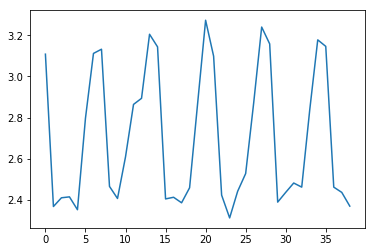

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.088908   
air_0164b9927d20bcc3_2017-04-23              1.228731   
air_0241aa3964b7f861_2017-04-23              2.193995   
air_0328696196e46f18_2017-04-23              2.381785   
air_034a3d5b40d5b1b1_2017-04-23              3.523005   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.076091  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.416890  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   7.970982  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   9.824206  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.886092

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')